<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_4_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.25, desired_action_stddev=0.25, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.4, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<12:34,  1.32episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:06<38:49,  2.33s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:07<29:51,  1.80s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:13<50:08,  3.02s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:13<37:51,  2.28s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:19<55:02,  3.32s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:20<41:16,  2.49s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:25<56:45,  3.43s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:26<42:32,  2.58s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:31<58:08,  3.52s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.0031982201617211103|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.6104 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.017602029734930684 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.012555683318281777 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.04191841368776698 || eq_WSEE: 0.10557475616596732 || Reward: -0.63 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07523253944447521 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.031887124745134096, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:44<1:21:07,  4.93s/episode]

Loss: 0.0018036700785160065|| Global step: 600 || Episode: 12 || Reward: 0.59 || Distance: 0.5667 ||
wsee: 0.08835789956609476, eqwsee: 0.13152993615391398, reward: 0.5858937157635635


  1%|1         | 13/1000 [00:46<1:08:03,  4.14s/episode]

Loss: 0.001917342422530055|| Global step: 650 || Episode: 13 || Reward: -0.57 || Distance: 0.5397 ||
wsee: 0.13540392778963722, eqwsee: 0.13109976637185683, reward: -0.571288606182319
|| Test Run No: 1100 || WSEE: 0.0148222865221461 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.010516283637663573 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.037231726364926616 || eq_WSEE: 0.10557475616596732 || Reward: -0.68 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07341393163008872 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.030245920030438703, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:53<1:23:56,  5.11s/episode]

Loss: 0.0011626409832388163|| Global step: 700 || Episode: 14 || Reward: 0.23 || Distance: 0.9728 ||
wsee: 0.08711237018125569, eqwsee: 0.13152993615391398, reward: 0.2329404477738862


  2%|1         | 15/1000 [00:55<1:09:52,  4.26s/episode]

Loss: 0.0010943666566163301|| Global step: 750 || Episode: 15 || Reward: 0.23 || Distance: 0.6913 ||
wsee: 0.11362883296728682, eqwsee: 0.08896563362710563, reward: 0.23232846100025645
|| Test Run No: 1100 || WSEE: 0.015726050968155054 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.009462839187553675 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.034630109793696774 || eq_WSEE: 0.10557475616596732 || Reward: -0.70 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0726502571966646 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.0297302742253886, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [01:03<1:25:29,  5.21s/episode]

Loss: 0.001336747081950307|| Global step: 800 || Episode: 16 || Reward: 0.90 || Distance: 0.5069 ||
wsee: 0.08669099040056939, eqwsee: 0.13152993615391398, reward: 0.9014666152774405


  2%|1         | 17/1000 [01:05<1:11:14,  4.35s/episode]

Loss: 0.0008455649367533624|| Global step: 850 || Episode: 17 || Reward: -0.53 || Distance: 0.8544 ||
wsee: 0.1498842137957764, eqwsee: 0.1498842137957764, reward: -0.5293442742891475
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.009549099739802227 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.034457452411552576 || eq_WSEE: 0.10557475616596732 || Reward: -0.70 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07276239283480894 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.029729589791877505, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [01:13<1:26:38,  5.29s/episode]

Loss: 0.0011696170549839735|| Global step: 900 || Episode: 18 || Reward: 0.00 || Distance: 0.6083 ||
wsee: 0.08679900789732953, eqwsee: 0.13152993615391398, reward: 0.0


  2%|1         | 19/1000 [01:15<1:12:15,  4.42s/episode]

Loss: 0.0007836957229301333|| Global step: 950 || Episode: 19 || Reward: -0.41 || Distance: 0.7373 ||
wsee: 0.10658873034354317, eqwsee: 0.10658873034354317, reward: -0.40909384024747864
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.010655951707296777 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.03644325524489096 || eq_WSEE: 0.10557475616596732 || Reward: -0.68 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07372842190219604 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.03041566788803199, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:23<1:27:42,  5.37s/episode]

Loss: 0.0011597973061725497|| Global step: 1000 || Episode: 20 || Reward: 0.00 || Distance: 0.6832 ||
wsee: 0.08747491795632373, eqwsee: 0.13152993615391398, reward: 0.0


  2%|2         | 21/1000 [01:25<1:13:17,  4.49s/episode]

Loss: 0.000898064870852977|| Global step: 1050 || Episode: 21 || Reward: 1.06 || Distance: 0.2552 ||
wsee: 0.13490735970772258, eqwsee: 0.10375368536381287, reward: 1.062112162867967
|| Test Run No: 1100 || WSEE: 0.016012661883606935 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.012937614446669615 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.04134910725607444 || eq_WSEE: 0.10557475616596732 || Reward: -0.63 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0763334919687192 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.03192595423759422, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:33<1:28:46,  5.45s/episode]

Loss: 0.0010195440845564008|| Global step: 1100 || Episode: 22 || Reward: 1.45 || Distance: 1.0407 ||
wsee: 0.08922381257496798, eqwsee: 0.13152993615391398, reward: 1.4499590792441244


  2%|2         | 23/1000 [01:35<1:14:10,  4.56s/episode]

Loss: 0.0009586162632331252|| Global step: 1150 || Episode: 23 || Reward: 1.15 || Distance: 0.6473 ||
wsee: 0.14680703943532492, eqwsee: 0.12460080593306919, reward: 1.1522422751219308
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.015380925008518287 || eq_WSEE: 0.15875344714719553 || Reward: -1.29 ||
|| Test Run No: 1140 || WSEE: 0.04766943623963316 || eq_WSEE: 0.10557475616596732 || Reward: -0.56 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0812246456209611 || eq_WSEE: 0.13084527637398705 || Reward: -0.62 ||
wsee:0.034266405670063886, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:43<1:29:53,  5.53s/episode]

Loss: 0.0009347349405288696|| Global step: 1200 || Episode: 24 || Reward: 0.12 || Distance: 0.6566 ||
wsee: 0.09244391813984804, eqwsee: 0.13152993615391398, reward: 0.12473739319745643


  2%|2         | 25/1000 [01:46<1:15:18,  4.63s/episode]

Loss: 0.0009731957106851041|| Global step: 1250 || Episode: 25 || Reward: -0.04 || Distance: 0.9499 ||
wsee: 0.10382871884477077, eqwsee: 0.09376202016680894, reward: -0.035138550324769216
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.020367548299600552 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.05412565283652018 || eq_WSEE: 0.10557475616596732 || Reward: -0.49 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08705830230978497 || eq_WSEE: 0.13084527637398705 || Reward: -0.56 ||
wsee:0.03826578164478625, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:53<1:30:29,  5.57s/episode]

Loss: 0.0006406046450138092|| Global step: 1300 || Episode: 26 || Reward: 0.11 || Distance: 1.2195 ||
wsee: 0.09641295870549052, eqwsee: 0.13152993615391398, reward: 0.10771245094614315


  3%|2         | 27/1000 [01:56<1:15:53,  4.68s/episode]

Loss: 0.001366300624795258|| Global step: 1350 || Episode: 27 || Reward: -5.55 || Distance: 0.5932 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.548038057278274
|| Test Run No: 1100 || WSEE: 0.016516105926206837 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.024318023050386755 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.05869147350980512 || eq_WSEE: 0.10557475616596732 || Reward: -0.44 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09207953150213694 || eq_WSEE: 0.13084527637398705 || Reward: -0.50 ||
wsee:0.04179832363155594, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [02:04<1:31:43,  5.66s/episode]

Loss: 0.0008422032697126269|| Global step: 1400 || Episode: 28 || Reward: 0.22 || Distance: 0.4790 ||
wsee: 0.10030090906190817, eqwsee: 0.13152993615391398, reward: 0.22143140958792612


  3%|2         | 29/1000 [02:07<1:16:48,  4.75s/episode]

Loss: 0.0016608114819973707|| Global step: 1450 || Episode: 29 || Reward: -4.54 || Distance: 0.7762 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.539471828385334
|| Test Run No: 1100 || WSEE: 0.019418565390008087 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.028302456762233946 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.06340272263287612 || eq_WSEE: 0.10557475616596732 || Reward: -0.39 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09677220066322618 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.04561041207841954, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [02:14<1:31:54,  5.69s/episode]

Loss: 0.0017787570832297206|| Global step: 1500 || Episode: 30 || Reward: 0.04 || Distance: 0.3079 ||
wsee: 0.10438177294091401, eqwsee: 0.13152993615391398, reward: 0.035244593222089504


  3%|3         | 31/1000 [02:17<1:18:10,  4.84s/episode]

Loss: 0.0011348475236445665|| Global step: 1550 || Episode: 31 || Reward: 0.04 || Distance: 0.7801 ||
wsee: 0.11408816315779949, eqwsee: 0.11408816315779949, reward: 0.03586052161915343
|| Test Run No: 1100 || WSEE: 0.017236986797112084 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.03242285877941722 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.06826661387818198 || eq_WSEE: 0.10557475616596732 || Reward: -0.34 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10100605024265706 || eq_WSEE: 0.13084527637398705 || Reward: -0.40 ||
wsee:0.04911913074930281, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [02:25<1:33:43,  5.81s/episode]

Loss: 0.0006750746397301555|| Global step: 1600 || Episode: 32 || Reward: 0.73 || Distance: 0.5970 ||
wsee: 0.1082397853360544, eqwsee: 0.13152993615391398, reward: 0.7288569509463981


  3%|3         | 33/1000 [02:28<1:18:52,  4.89s/episode]

Loss: 0.0009135037544183433|| Global step: 1650 || Episode: 33 || Reward: 0.37 || Distance: 0.4156 ||
wsee: 0.12747766087200432, eqwsee: 0.12747766087200432, reward: 0.37225423470587027
|| Test Run No: 1100 || WSEE: 0.01778658791676353 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.040734041375340584 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07664417092351847 || eq_WSEE: 0.10557475616596732 || Reward: -0.26 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10666751037174041 || eq_WSEE: 0.13084527637398705 || Reward: -0.34 ||
wsee:0.057733194025539634, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [02:36<1:32:46,  5.76s/episode]

Loss: 0.0011415076442062855|| Global step: 1700 || Episode: 34 || Reward: 1.06 || Distance: 0.5643 ||
wsee: 0.11542922903005497, eqwsee: 0.13152993615391398, reward: 1.0565609435436858


  4%|3         | 35/1000 [02:39<1:17:50,  4.84s/episode]

Loss: 0.001227585249580443|| Global step: 1750 || Episode: 35 || Reward: 0.30 || Distance: 0.4950 ||
wsee: 0.18098994303700508, eqwsee: 0.1546985766937026, reward: 0.29924648410746374
|| Test Run No: 1100 || WSEE: 0.017921343595246376 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.05604061212114218 || eq_WSEE: 0.15875344714719553 || Reward: -0.93 ||
|| Test Run No: 1140 || WSEE: 0.08595783545485151 || eq_WSEE: 0.10557475616596732 || Reward: -0.17 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.11264181892144436 || eq_WSEE: 0.13084527637398705 || Reward: -0.27 ||
wsee:0.06715324170953457, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:46<1:32:00,  5.73s/episode]

Loss: 0.0016979669453576207|| Global step: 1800 || Episode: 36 || Reward: 1.78 || Distance: 0.6049 ||
wsee: 0.12288657549847762, eqwsee: 0.13152993615391398, reward: 1.7778142807334294


  4%|3         | 37/1000 [02:49<1:17:25,  4.82s/episode]

Loss: 0.0013617142103612423|| Global step: 1850 || Episode: 37 || Reward: -0.28 || Distance: 0.5453 ||
wsee: 0.12942636481142852, eqwsee: 0.12942636481142852, reward: -0.2755160060530313
|| Test Run No: 1100 || WSEE: 0.05472070257066953 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.07583892840401008 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.09516476205145007 || eq_WSEE: 0.10557475616596732 || Reward: -0.08 ||
|| Test Run No: 1160 || WSEE: 0.06649418519452234 || eq_WSEE: 0.10639065246086721 || Reward: -0.41 ||
|| Test Run No: 1180 || WSEE: 0.11901137530965625 || eq_WSEE: 0.13084527637398705 || Reward: -0.19 ||
wsee:0.07941217180211632, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:57<1:31:55,  5.73s/episode]

Loss: 0.001146333059296012|| Global step: 1900 || Episode: 38 || Reward: 0.00 || Distance: 0.7978 ||
wsee: 0.1315673518482057, eqwsee: 0.13152993615391398, reward: 0.0


  4%|3         | 39/1000 [03:00<1:17:26,  4.84s/episode]

Loss: 0.0015459745191037655|| Global step: 1950 || Episode: 39 || Reward: 0.57 || Distance: 0.3503 ||
wsee: 0.15591180656387438, eqwsee: 0.13366216924837832, reward: 0.5714053323153319
|| Test Run No: 1100 || WSEE: 0.07837427170932054 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.09433114144428432 || eq_WSEE: 0.15875344714719553 || Reward: -0.66 ||
|| Test Run No: 1140 || WSEE: 0.10433760337049877 || eq_WSEE: 0.10557475616596732 || Reward: 0.00 ||
|| Test Run No: 1160 || WSEE: 0.09468054504828129 || eq_WSEE: 0.10639065246086721 || Reward: -0.12 ||
|| Test Run No: 1180 || WSEE: 0.12442424015295687 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.09168985534535139, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [03:08<1:31:25,  5.71s/episode]

Loss: 0.0009998835157603025|| Global step: 2000 || Episode: 40 || Reward: 1.32 || Distance: 0.5461 ||
wsee: 0.13877988637152194, eqwsee: 0.13152993615391398, reward: 1.3162148676622147


  4%|4         | 41/1000 [03:10<1:16:56,  4.81s/episode]

Loss: 0.0012104356428608298|| Global step: 2050 || Episode: 41 || Reward: -6.43 || Distance: 0.8435 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -6.426105142507675
|| Test Run No: 1100 || WSEE: 0.06778340168849853 || eq_WSEE: 0.10417327110291066 || Reward: -0.10 ||
|| Test Run No: 1120 || WSEE: 0.10870869605551893 || eq_WSEE: 0.15875344714719553 || Reward: -0.56 ||
|| Test Run No: 1140 || WSEE: 0.11179224327740231 || eq_WSEE: 0.10557475616596732 || Reward: 0.07 ||
|| Test Run No: 1160 || WSEE: 0.10768250668317901 || eq_WSEE: 0.10639065246086721 || Reward: 0.02 ||
|| Test Run No: 1180 || WSEE: 0.12930769259500108 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.10722174129431815, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [03:18<1:31:42,  5.74s/episode]

Loss: 0.001512351562269032|| Global step: 2100 || Episode: 42 || Reward: -1.06 || Distance: 0.7003 ||
wsee: 0.14487494844109589, eqwsee: 0.13152993615391398, reward: -1.0598823581329695


  4%|4         | 43/1000 [03:21<1:17:21,  4.85s/episode]

Loss: 0.0017927000299096107|| Global step: 2150 || Episode: 43 || Reward: 0.15 || Distance: 0.2069 ||
wsee: 0.12418039270551982, eqwsee: 0.10543505078886685, reward: 0.14725178207161385
|| Test Run No: 1100 || WSEE: 0.0821226273448907 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.11831223421443003 || eq_WSEE: 0.15875344714719553 || Reward: -0.48 ||
|| Test Run No: 1140 || WSEE: 0.11691252074937626 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11454517607674405 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.13318398880740037 || eq_WSEE: 0.13084527637398705 || Reward: -0.00 ||
wsee:0.12152242572928884, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [03:29<1:32:17,  5.79s/episode]

Loss: 0.001223619794473052|| Global step: 2200 || Episode: 44 || Reward: 1.23 || Distance: 0.4423 ||
wsee: 0.14916969521161136, eqwsee: 0.13152993615391398, reward: 1.226714294424849


  4%|4         | 45/1000 [03:32<1:18:02,  4.90s/episode]

Loss: 0.002477304544299841|| Global step: 2250 || Episode: 45 || Reward: -0.14 || Distance: 0.7838 ||
wsee: 0.10474612443857328, eqwsee: 0.09938214209364687, reward: -0.14202741207206082
|| Test Run No: 1100 || WSEE: 0.08983417406259332 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.12478560717147959 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11975671695412397 || eq_WSEE: 0.10557475616596732 || Reward: 0.15 ||
|| Test Run No: 1160 || WSEE: 0.11841496558317588 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13577067905371518 || eq_WSEE: 0.13084527637398705 || Reward: 0.03 ||
wsee:0.12762708265505815, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [03:40<1:32:32,  5.82s/episode]

Loss: 0.0015675550093874335|| Global step: 2300 || Episode: 46 || Reward: 1.39 || Distance: 0.3418 ||
wsee: 0.1516441471027122, eqwsee: 0.13152993615391398, reward: 1.389581269156415


  5%|4         | 47/1000 [03:43<1:18:08,  4.92s/episode]

Loss: 0.0010853286366909742|| Global step: 2350 || Episode: 47 || Reward: 1.05 || Distance: 0.5691 ||
wsee: 0.14991244108015206, eqwsee: 0.12716993041365515, reward: 1.0506015044970032
|| Test Run No: 1100 || WSEE: 0.07219266007303132 || eq_WSEE: 0.10417327110291066 || Reward: -0.06 ||
|| Test Run No: 1120 || WSEE: 0.13109781811481797 || eq_WSEE: 0.15875344714719553 || Reward: -0.36 ||
|| Test Run No: 1140 || WSEE: 0.12224661304260692 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.12182566218948364 || eq_WSEE: 0.10639065246086721 || Reward: 0.16 ||
|| Test Run No: 1180 || WSEE: 0.13830009758243816 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.13398317293881243, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [03:51<1:33:34,  5.90s/episode]

Loss: 0.0007987617864273489|| Global step: 2400 || Episode: 48 || Reward: 0.04 || Distance: 0.8088 ||
wsee: 0.1537939773400263, eqwsee: 0.13152993615391398, reward: 0.03984075842215366


  5%|4         | 49/1000 [03:54<1:19:19,  5.00s/episode]

Loss: 0.00148757454007864|| Global step: 2450 || Episode: 49 || Reward: -4.64 || Distance: 0.2166 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -4.6365701626513
|| Test Run No: 1100 || WSEE: 0.13109547536028335 || eq_WSEE: 0.10417327110291066 || Reward: -0.24 ||
|| Test Run No: 1120 || WSEE: 0.13620485113632078 || eq_WSEE: 0.15875344714719553 || Reward: -0.31 ||
|| Test Run No: 1140 || WSEE: 0.1240615481392035 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.12410522677086894 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.1404823555632507 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.13888952478551192, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [04:02<1:34:01,  5.94s/episode]

Loss: 0.0016694965306669474|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.3847 ||
wsee: 0.15549703428881725, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [04:05<1:19:50,  5.05s/episode]

Loss: 0.0015621819766238332|| Global step: 2550 || Episode: 51 || Reward: 0.06 || Distance: 0.6935 ||
wsee: 0.10952309960500513, eqwsee: 0.09371570435552588, reward: 0.05980818553074618
|| Test Run No: 1100 || WSEE: 0.07467625392328742 || eq_WSEE: 0.10417327110291066 || Reward: -0.03 ||
|| Test Run No: 1120 || WSEE: 0.14003250651974083 || eq_WSEE: 0.15875344714719553 || Reward: -0.26 ||
|| Test Run No: 1140 || WSEE: 0.12536200715166296 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12561895181986082 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.1421883502308126 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.14081802074417962, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [04:13<1:33:47,  5.94s/episode]

Loss: 0.00218278169631958|| Global step: 2600 || Episode: 52 || Reward: 0.32 || Distance: 0.3278 ||
wsee: 0.15676167730687512, eqwsee: 0.13152993615391398, reward: 0.3210104755461538


  5%|5         | 53/1000 [04:16<1:19:37,  5.04s/episode]

Loss: 0.0028488014359027147|| Global step: 2650 || Episode: 53 || Reward: -2.74 || Distance: 0.2397 ||
wsee: 0.034517030864591736, eqwsee: 0.10080306344627107, reward: -2.7367920756518385
|| Test Run No: 1100 || WSEE: 0.14036149958283173 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1427450189363134 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.126240196673245 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12658583832167952 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14340725898255458 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14288449324560137, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [04:24<1:33:32,  5.93s/episode]

Loss: 0.0026208623312413692|| Global step: 2700 || Episode: 54 || Reward: 1.09 || Distance: 0.2094 ||
wsee: 0.15764158931840339, eqwsee: 0.13152993615391398, reward: 1.0923927734861563


  6%|5         | 55/1000 [04:27<1:19:25,  5.04s/episode]

Loss: 0.001330811996012926|| Global step: 2750 || Episode: 55 || Reward: 0.91 || Distance: 0.1207 ||
wsee: 0.14297533770025278, eqwsee: 0.1195833502440462, reward: 0.913366049003332
|| Test Run No: 1100 || WSEE: 0.129366056587484 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1440514000788675 || eq_WSEE: 0.15875344714719553 || Reward: -0.21 ||
|| Test Run No: 1140 || WSEE: 0.12663869810829678 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12700998905070324 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14396096355960855 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14343694621003117, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [04:35<1:33:33,  5.95s/episode]

Loss: 0.002311170566827059|| Global step: 2800 || Episode: 56 || Reward: 1.10 || Distance: 0.3812 ||
wsee: 0.15804442667544272, eqwsee: 0.13152993615391398, reward: 1.1030335652322993


  6%|5         | 57/1000 [04:38<1:19:44,  5.07s/episode]

Loss: 0.0029238108545541763|| Global step: 2850 || Episode: 57 || Reward: -4.15 || Distance: 0.1484 ||
wsee: 7.309871567986143e-05, eqwsee: 0.09568350753601491, reward: -4.154889363456915
|| Test Run No: 1100 || WSEE: 0.12772507244315925 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.14488256772364227 || eq_WSEE: 0.15875344714719553 || Reward: -0.20 ||
|| Test Run No: 1140 || WSEE: 0.1268858414330505 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12727424268302265 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14431644256474996 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1438243971236456, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [04:46<1:33:45,  5.97s/episode]

Loss: 0.002176655223593116|| Global step: 2900 || Episode: 58 || Reward: 0.00 || Distance: 0.4399 ||
wsee: 0.1582986715436368, eqwsee: 0.13152993615391398, reward: 0.004179355991974637


  6%|5         | 59/1000 [04:49<1:19:51,  5.09s/episode]

Loss: 0.0013970639556646347|| Global step: 2950 || Episode: 59 || Reward: 0.95 || Distance: 0.8375 ||
wsee: 0.1740430919314778, eqwsee: 0.14337031954840265, reward: 0.9455713862636796
|| Test Run No: 1100 || WSEE: 0.07720767090384764 || eq_WSEE: 0.10417327110291066 || Reward: 0.00 ||
|| Test Run No: 1120 || WSEE: 0.14545488348138352 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.12705455862505474 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12744906768719916 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14456403266999265 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14358918965847775, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [04:57<1:34:21,  6.02s/episode]

Loss: 0.001619517570361495|| Global step: 3000 || Episode: 60 || Reward: 0.54 || Distance: 0.6272 ||
wsee: 0.15847428062138463, eqwsee: 0.13152993615391398, reward: 0.5363377846622733


  6%|6         | 61/1000 [05:00<1:20:48,  5.16s/episode]

Loss: 0.0022659189999103546|| Global step: 3050 || Episode: 61 || Reward: 1.75 || Distance: 0.4806 ||
wsee: 0.18186248723637682, eqwsee: 0.14523213734839777, reward: 1.746499067688743
|| Test Run No: 1100 || WSEE: 0.13384230538234823 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.1458598465580571 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.1271709624710597 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12756992939128176 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14474271285149598 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1443415576029472, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [05:08<1:34:36,  6.05s/episode]

Loss: 0.0025228329468518496|| Global step: 3100 || Episode: 62 || Reward: -4.28 || Distance: 0.3312 ||
wsee: 0.15860105416113135, eqwsee: 0.13152993615391398, reward: -4.281916104990432


  6%|6         | 63/1000 [05:12<1:21:14,  5.20s/episode]

Loss: 0.0018218773184344172|| Global step: 3150 || Episode: 63 || Reward: 1.47 || Distance: 0.2059 ||
wsee: 0.16197863145591712, eqwsee: 0.13208198076632058, reward: 1.4688626285284432
|| Test Run No: 1100 || WSEE: 0.07584979741258147 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.14622980963457682 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.1272762440426939 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1276825608697613 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14490064663745822 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14394370118152364, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [05:20<1:35:23,  6.12s/episode]

Loss: 0.0025330004282295704|| Global step: 3200 || Episode: 64 || Reward: 0.16 || Distance: 0.5098 ||
wsee: 0.15871632655757628, eqwsee: 0.13152993615391398, reward: 0.15565565269975923


  6%|6         | 65/1000 [05:23<1:21:22,  5.22s/episode]

Loss: 0.002132440684363246|| Global step: 3250 || Episode: 65 || Reward: -3.00 || Distance: 0.2319 ||
wsee: 0.0005064283168590595, eqwsee: 0.12165755228267655, reward: -2.998931055069221
|| Test Run No: 1100 || WSEE: 0.0851981654676146 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.14640683010293482 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.1273272154201917 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12773723440821086 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14497612889743952 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1441271551742175, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [05:31<1:35:23,  6.13s/episode]

Loss: 0.0033148941583931446|| Global step: 3300 || Episode: 66 || Reward: 0.25 || Distance: 0.3973 ||
wsee: 0.15877232631796906, eqwsee: 0.13152993615391398, reward: 0.24607184126706916


  7%|6         | 67/1000 [05:34<1:21:11,  5.22s/episode]

Loss: 0.0035643998999148607|| Global step: 3350 || Episode: 67 || Reward: 1.76 || Distance: 0.3326 ||
wsee: 0.16202492331079904, eqwsee: 0.12686051062707315, reward: 1.7581175840200443
|| Test Run No: 1100 || WSEE: 0.09780027629179301 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1464457192156079 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.12733798513416028 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12774913263763585 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14499256038192337 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14427362703966262, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [05:42<1:34:29,  6.08s/episode]

Loss: 0.002281359862536192|| Global step: 3400 || Episode: 68 || Reward: 1.67 || Distance: 0.2228 ||
wsee: 0.15878400422380176, eqwsee: 0.13152993615391398, reward: 1.6674213058690777


  7%|6         | 69/1000 [05:46<1:21:12,  5.23s/episode]

Loss: 0.002210577018558979|| Global step: 3450 || Episode: 69 || Reward: 0.51 || Distance: 0.3086 ||
wsee: 0.15332115636403443, eqwsee: 0.13495539352471292, reward: 0.5056866672768304
|| Test Run No: 1100 || WSEE: 0.08255061117167013 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.1465339579594212 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.12736300226387137 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12777581661340473 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14503009712710008 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14416212152110242, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [05:54<1:34:53,  6.12s/episode]

Loss: 0.0019806530326604843|| Global step: 3500 || Episode: 70 || Reward: 0.97 || Distance: 0.5396 ||
wsee: 0.15881185630946354, eqwsee: 0.13152993615391398, reward: 0.9659731197888771


  7%|7         | 71/1000 [05:57<1:21:19,  5.25s/episode]

Loss: 0.0024133501574397087|| Global step: 3550 || Episode: 71 || Reward: 0.39 || Distance: 0.4525 ||
wsee: 0.13702130634360507, eqwsee: 0.1217394096666866, reward: 0.39170095827407436
|| Test Run No: 1100 || WSEE: 0.13399588272423693 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.14651695160356717 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.12735827452744158 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12777065072199886 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.1450226164606751 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14466866799698574, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [06:05<1:34:45,  6.13s/episode]

Loss: 0.002063075313344598|| Global step: 3600 || Episode: 72 || Reward: -5.76 || Distance: 0.2351 ||
wsee: 0.1588065984756061, eqwsee: 0.13152993615391398, reward: -5.760461581281229


  7%|7         | 73/1000 [06:09<1:21:37,  5.28s/episode]

Loss: 0.0012921226443722844|| Global step: 3650 || Episode: 73 || Reward: -0.66 || Distance: 0.6403 ||
wsee: 0.1530237040005797, eqwsee: 0.15288602961823075, reward: -0.661529169362167
|| Test Run No: 1100 || WSEE: 0.11083908747394564 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1464371300275515 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.1273359144936398 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1277457103056605 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14498854703321223 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14439665051910244, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [06:17<1:36:02,  6.22s/episode]

Loss: 0.0030720122158527374|| Global step: 3700 || Episode: 74 || Reward: 0.83 || Distance: 0.3102 ||
wsee: 0.15878181611193326, eqwsee: 0.13152993615391398, reward: 0.8316958774903815


  8%|7         | 75/1000 [06:20<1:22:50,  5.37s/episode]

Loss: 0.001230253023095429|| Global step: 3750 || Episode: 75 || Reward: 0.70 || Distance: 0.6245 ||
wsee: 0.11080258220438084, eqwsee: 0.09627257334639852, reward: 0.701943601120058
|| Test Run No: 1100 || WSEE: 0.10758552230095982 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.14635525659657686 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.12731299946817132 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12771959655106757 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14495408526816256 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14432081846079137, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [06:29<1:37:01,  6.30s/episode]

Loss: 0.0022232471965253353|| Global step: 3800 || Episode: 76 || Reward: 1.83 || Distance: 0.1997 ||
wsee: 0.15875653714028298, eqwsee: 0.13152993615391398, reward: 1.829859460876191


  8%|7         | 77/1000 [06:32<1:23:10,  5.41s/episode]

Loss: 0.0019844244234263897|| Global step: 3850 || Episode: 77 || Reward: 2.38 || Distance: 0.1017 ||
wsee: 0.19823655260697087, eqwsee: 0.15128695705743034, reward: 2.3775585872068574
|| Test Run No: 1100 || WSEE: 0.08523056652314386 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.14629566502382088 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.1272960209291924 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12770053055144148 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14492863618742383 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14406560093147716, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [06:40<1:36:35,  6.29s/episode]

Loss: 0.003090089187026024|| Global step: 3900 || Episode: 78 || Reward: 1.12 || Distance: 0.3197 ||
wsee: 0.1587379108175078, eqwsee: 0.13152993615391398, reward: 1.1191688908196125


  8%|7         | 79/1000 [06:44<1:23:24,  5.43s/episode]

Loss: 0.002194818574935198|| Global step: 3950 || Episode: 79 || Reward: 1.34 || Distance: 0.1139 ||
wsee: 0.14153186418796648, eqwsee: 0.11141469645881293, reward: 1.3388134793690523
|| Test Run No: 1100 || WSEE: 0.08870906249907776 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.14625132622595954 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.12728343680822704 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1276862119664474 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.1449095110769254 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1440766273317498, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [06:52<1:37:07,  6.33s/episode]

Loss: 0.0016914382576942444|| Global step: 4000 || Episode: 80 || Reward: 1.32 || Distance: 0.2947 ||
wsee: 0.15872393866749174, eqwsee: 0.13152993615391398, reward: 1.3239904532998519


  8%|8         | 81/1000 [06:56<1:23:41,  5.46s/episode]

Loss: 0.0032321109902113676|| Global step: 4050 || Episode: 81 || Reward: -0.50 || Distance: 0.2343 ||
wsee: 0.1188224338303564, eqwsee: 0.11480777355807266, reward: -0.5021775518173106
|| Test Run No: 1100 || WSEE: 0.13392371347134635 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.14621272815773306 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.12727233795949192 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12767386234824424 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14489239063784193 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14450839676656219, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [07:04<1:36:59,  6.34s/episode]

Loss: 0.0015524533810093999|| Global step: 4100 || Episode: 82 || Reward: -6.55 || Distance: 0.2525 ||
wsee: 0.1587116330510449, eqwsee: 0.13152993615391398, reward: -6.55292791869609


  8%|8         | 83/1000 [07:08<1:23:35,  5.47s/episode]

Loss: 0.002498028567060828|| Global step: 4150 || Episode: 83 || Reward: -4.91 || Distance: 0.2957 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -4.91229120829776
|| Test Run No: 1100 || WSEE: 0.08389334400843666 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1461965661847338 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.12726764372633542 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1276681070171087 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.1448857320231132 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14399819681591727, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [07:16<1:36:48,  6.34s/episode]

Loss: 0.0024005696177482605|| Global step: 4200 || Episode: 84 || Reward: 0.31 || Distance: 0.2121 ||
wsee: 0.15870646892295032, eqwsee: 0.13152993615391398, reward: 0.3109116226101689


  8%|8         | 85/1000 [07:19<1:23:26,  5.47s/episode]

Loss: 0.0028453338891267776|| Global step: 4250 || Episode: 85 || Reward: 1.32 || Distance: 0.1892 ||
wsee: 0.11398519367702137, eqwsee: 0.09230989531623571, reward: 1.3183550846077339
|| Test Run No: 1100 || WSEE: 0.13388798166099522 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.14606651655884548 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.1272305390102103 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1276254138011815 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14482968415222017 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14442837931552766, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [07:28<1:36:19,  6.32s/episode]

Loss: 0.001828681444749236|| Global step: 4300 || Episode: 86 || Reward: -5.49 || Distance: 0.2528 ||
wsee: 0.15866533985874007, eqwsee: 0.13152993615391398, reward: -5.488648690421602


  9%|8         | 87/1000 [07:31<1:23:26,  5.48s/episode]

Loss: 0.002210136502981186|| Global step: 4350 || Episode: 87 || Reward: -4.43 || Distance: 0.0913 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -4.431410315622207
|| Test Run No: 1100 || WSEE: 0.1339096010689867 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.14615665593217558 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.12725660765746613 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1276551175826174 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14486887045744687 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1444772675630707, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [07:40<1:37:30,  6.41s/episode]

Loss: 0.002639742335304618|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.3234 ||
wsee: 0.1586945919381249, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [07:43<1:24:32,  5.57s/episode]

Loss: 0.0037529803812503815|| Global step: 4450 || Episode: 89 || Reward: 1.60 || Distance: 0.3888 ||
wsee: 0.14343014942900045, eqwsee: 0.13078292750269094, reward: 1.6004391014502835
|| Test Run No: 1100 || WSEE: 0.13389553360516596 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.1461021749785934 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.1272411397184407 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12763744884569955 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14484488999742215 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14444975104691798, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [07:52<1:38:00,  6.46s/episode]

Loss: 0.003176923608407378|| Global step: 4500 || Episode: 90 || Reward: -5.74 || Distance: 0.1899 ||
wsee: 0.15867730432156124, eqwsee: 0.13152993615391398, reward: -5.739227990731037


  9%|9         | 91/1000 [07:55<1:24:34,  5.58s/episode]

Loss: 0.0023347537498921156|| Global step: 4550 || Episode: 91 || Reward: 1.62 || Distance: 0.1943 ||
wsee: 0.20784200584023121, eqwsee: 0.17312453190109664, reward: 1.6190917171191668
|| Test Run No: 1100 || WSEE: 0.08178859408837327 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.14610542790432415 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.12724211059187285 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12763854255843318 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14484641029653858 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14393031240053766, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [08:04<1:37:57,  6.47s/episode]

Loss: 0.0023921451065689325|| Global step: 4600 || Episode: 92 || Reward: 0.96 || Distance: 0.6545 ||
wsee: 0.1586784397914827, eqwsee: 0.13152993615391398, reward: 0.960436427606683


  9%|9         | 93/1000 [08:08<1:24:48,  5.61s/episode]

Loss: 0.0021068912465125322|| Global step: 4650 || Episode: 93 || Reward: 2.17 || Distance: 0.3468 ||
wsee: 0.20463634483639395, eqwsee: 0.16126954815004813, reward: 2.169093201108638
|| Test Run No: 1100 || WSEE: 0.09781693901174021 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.14608070370809478 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.12723543675256246 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1276308244296485 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.1448355059785215 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14408001842349213, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [08:16<1:38:38,  6.53s/episode]

Loss: 0.0024170889519155025|| Global step: 4700 || Episode: 94 || Reward: 1.96 || Distance: 0.2208 ||
wsee: 0.15867081289055113, eqwsee: 0.13152993615391398, reward: 1.9638955986430868


 10%|9         | 95/1000 [08:20<1:25:34,  5.67s/episode]

Loss: 0.004923414438962936|| Global step: 4750 || Episode: 95 || Reward: 0.56 || Distance: 0.1419 ||
wsee: 0.13197069407955642, eqwsee: 0.11205650903237177, reward: 0.5579765374972714
|| Test Run No: 1100 || WSEE: 0.0906235204965662 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.14618126827281713 || eq_WSEE: 0.15875344714719553 || Reward: -0.18 ||
|| Test Run No: 1140 || WSEE: 0.1272646772237082 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12766507253713294 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.1448805777252857 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1440615313864115, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [08:29<1:39:33,  6.61s/episode]

Loss: 0.002615845063701272|| Global step: 4800 || Episode: 96 || Reward: 1.22 || Distance: 0.3727 ||
wsee: 0.1587043773821351, eqwsee: 0.13152993615391398, reward: 1.2202658801841406


 10%|9         | 97/1000 [08:32<1:26:21,  5.74s/episode]

Loss: 0.004057332407683134|| Global step: 4850 || Episode: 97 || Reward: 1.56 || Distance: 0.3597 ||
wsee: 0.18140966192375108, eqwsee: 0.1438770677374375, reward: 1.5612382401868474
|| Test Run No: 1100 || WSEE: 0.07601515682250011 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.14608740342177717 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.12723791411589255 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1276355268982666 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14483876471023893 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.143870446300005, fpa_wsee: 0.12424997011815597


 10%|9         | 98/1000 [08:41<1:39:28,  6.62s/episode]

Loss: 0.0024395189248025417|| Global step: 4900 || Episode: 98 || Reward: 0.14 || Distance: 0.5432 ||
wsee: 0.1586744272299498, eqwsee: 0.13152993615391398, reward: 0.1378275864262746


 10%|9         | 99/1000 [08:45<1:26:30,  5.76s/episode]

Loss: 0.002617603400722146|| Global step: 4950 || Episode: 99 || Reward: 0.39 || Distance: 0.3728 ||
wsee: 0.11343907381049896, eqwsee: 0.10245243408924709, reward: 0.3919066605020502
|| Test Run No: 1100 || WSEE: 0.13388798479537936 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.14608538270820573 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.1272364741482603 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12763679063865338 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.1448350122085468 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14445418099784896, fpa_wsee: 0.12424997011815597


 10%|#         | 100/1000 [08:53<1:38:59,  6.60s/episode]

Loss: 0.0036440491676330566|| Global step: 5000 || Episode: 100 || Reward: -6.92 || Distance: 0.1631 ||
wsee: 0.1586731717434466, eqwsee: 0.13152993615391398, reward: -6.922454010102329


 10%|#         | 101/1000 [08:57<1:26:08,  5.75s/episode]

Loss: 0.003440207801759243|| Global step: 5050 || Episode: 101 || Reward: -0.16 || Distance: 0.5926 ||
wsee: 0.0903939833962715, eqwsee: 0.0903939833962715, reward: -0.1576196844229576
|| Test Run No: 1100 || WSEE: 0.08595062528763907 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.14576815067108806 || eq_WSEE: 0.15875344714719553 || Reward: -0.19 ||
|| Test Run No: 1140 || WSEE: 0.12713586970666596 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12751840218888755 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14468687801962424 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14378120498441008, fpa_wsee: 0.12424997011815597


 10%|#         | 102/1000 [09:06<1:38:39,  6.59s/episode]

Loss: 0.0020643076859414577|| Global step: 5100 || Episode: 102 || Reward: 1.31 || Distance: 0.3012 ||
wsee: 0.1585562273433056, eqwsee: 0.13152993615391398, reward: 1.3068679249094575


 10%|#         | 103/1000 [09:09<1:25:26,  5.71s/episode]

Loss: 0.0033282837830483913|| Global step: 5150 || Episode: 103 || Reward: 1.39 || Distance: 0.3087 ||
wsee: 0.15894063479207177, eqwsee: 0.13455395481375648, reward: 1.385732036697045
|| Test Run No: 1100 || WSEE: 0.09141716380860611 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.14328870331558638 || eq_WSEE: 0.15875344714719553 || Reward: -0.22 ||
|| Test Run No: 1140 || WSEE: 0.1264176480271321 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12668716122331192 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1436918559782752 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14280332239916352, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [09:18<1:38:19,  6.58s/episode]

Loss: 0.00313582899980247|| Global step: 5200 || Episode: 104 || Reward: 0.63 || Distance: 0.2570 ||
wsee: 0.15774315681651774, eqwsee: 0.13152993615391398, reward: 0.630156807364666


 10%|#         | 105/1000 [09:22<1:25:30,  5.73s/episode]

Loss: 0.002323613967746496|| Global step: 5250 || Episode: 105 || Reward: -4.43 || Distance: 0.1965 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -4.4337456341540715
|| Test Run No: 1100 || WSEE: 0.08561972957936098 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.14251004729612735 || eq_WSEE: 0.15875344714719553 || Reward: -0.22 ||
|| Test Run No: 1140 || WSEE: 0.12618041063301885 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12638968897649033 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14334189916680884 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14232902205471334, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [09:30<1:38:07,  6.59s/episode]

Loss: 0.0027706059627234936|| Global step: 5300 || Episode: 106 || Reward: 0.22 || Distance: 0.1487 ||
wsee: 0.15747612782665427, eqwsee: 0.13152993615391398, reward: 0.2244406477154043


 11%|#         | 107/1000 [09:34<1:25:40,  5.76s/episode]

Loss: 0.0032048551365733147|| Global step: 5350 || Episode: 107 || Reward: -5.00 || Distance: 0.1566 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -4.996009116608097
|| Test Run No: 1100 || WSEE: 0.08112811888070745 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.1424418027039514 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.1261584530333584 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12636485549919274 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14330872990007018 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14224695644553714, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [09:43<1:38:31,  6.63s/episode]

Loss: 0.00522094639018178|| Global step: 5400 || Episode: 108 || Reward: -0.17 || Distance: 0.4159 ||
wsee: 0.15745119152910003, eqwsee: 0.13152993615391398, reward: -0.17072011735914114


 11%|#         | 109/1000 [09:47<1:26:06,  5.80s/episode]

Loss: 0.003658916801214218|| Global step: 5450 || Episode: 109 || Reward: 1.36 || Distance: 0.2557 ||
wsee: 0.12108255646706796, eqwsee: 0.09374848365668549, reward: 1.358954519547058
|| Test Run No: 1100 || WSEE: 0.08871468464585373 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1385164687760376 || eq_WSEE: 0.15875344714719553 || Reward: -0.28 ||
|| Test Run No: 1140 || WSEE: 0.12483745874133864 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.12475000886160631 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14142706740018648 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.13980645253795243, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [09:55<1:38:54,  6.67s/episode]

Loss: 0.003395314095541835|| Global step: 5500 || Episode: 110 || Reward: 0.98 || Distance: 0.2995 ||
wsee: 0.15598577912618936, eqwsee: 0.13152993615391398, reward: 0.9804127186098717


 11%|#1        | 111/1000 [09:59<1:26:39,  5.85s/episode]

Loss: 0.004185643047094345|| Global step: 5550 || Episode: 111 || Reward: 1.19 || Distance: 0.4156 ||
wsee: 0.1372879257808411, eqwsee: 0.1133930359662023, reward: 1.191952594011705
|| Test Run No: 1100 || WSEE: 0.07734850847171737 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.1399063078193204 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12521740514534996 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12502826385475077 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14195417971352922 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.13992977593150951, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [10:08<1:40:01,  6.76s/episode]

Loss: 0.001589516643434763|| Global step: 5600 || Episode: 112 || Reward: 0.56 || Distance: 0.7172 ||
wsee: 0.15636817358859512, eqwsee: 0.13152993615391398, reward: 0.5629402125513189


 11%|#1        | 113/1000 [10:12<1:27:25,  5.91s/episode]

Loss: 0.003326503559947014|| Global step: 5650 || Episode: 113 || Reward: 1.10 || Distance: 0.2215 ||
wsee: 0.10476248184408551, eqwsee: 0.08060645463185492, reward: 1.102678572499232
|| Test Run No: 1100 || WSEE: 0.08606821496593278 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.13985922382998478 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12520323936247413 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.1250107014893444 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14193078029352993 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.1399950080199063, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [10:21<1:40:45,  6.82s/episode]

Loss: 0.0018992143450304866|| Global step: 5700 || Episode: 114 || Reward: 0.90 || Distance: 0.1518 ||
wsee: 0.1563507620683027, eqwsee: 0.13152993615391398, reward: 0.8986153824869456


 12%|#1        | 115/1000 [10:25<1:27:51,  5.96s/episode]

Loss: 0.002601800486445427|| Global step: 5750 || Episode: 115 || Reward: 0.61 || Distance: 0.6100 ||
wsee: 0.1493580656397654, eqwsee: 0.13499431860432443, reward: 0.6105716107918542
|| Test Run No: 1100 || WSEE: 0.07332839832718241 || eq_WSEE: 0.10417327110291066 || Reward: -0.05 ||
|| Test Run No: 1120 || WSEE: 0.13849347983986426 || eq_WSEE: 0.15875344714719553 || Reward: -0.28 ||
|| Test Run No: 1140 || WSEE: 0.12476971871143344 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.12452708821518493 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14129859855525448 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.13918881435141672, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [10:34<1:40:57,  6.85s/episode]

Loss: 0.0026776099111884832|| Global step: 5800 || Episode: 116 || Reward: 0.15 || Distance: 0.2822 ||
wsee: 0.15587232898246134, eqwsee: 0.13152993615391398, reward: 0.1509527156286622


 12%|#1        | 117/1000 [10:38<1:28:19,  6.00s/episode]

Loss: 0.0045090289786458015|| Global step: 5850 || Episode: 117 || Reward: 0.34 || Distance: 0.2934 ||
wsee: 0.09513673991838982, eqwsee: 0.08652146543575229, reward: 0.3431344112692327
|| Test Run No: 1100 || WSEE: 0.1319573991373565 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.13943736222548017 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12513092384937555 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12501218782249435 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.1418446527038208 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.14044706424232387, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [10:47<1:41:31,  6.91s/episode]

Loss: 0.002414072398096323|| Global step: 5900 || Episode: 118 || Reward: -4.19 || Distance: 0.3324 ||
wsee: 0.15628642451143387, eqwsee: 0.13152993615391398, reward: -4.18763837003284


 12%|#1        | 119/1000 [10:51<1:28:42,  6.04s/episode]

Loss: 0.001997563987970352|| Global step: 5950 || Episode: 119 || Reward: -5.10 || Distance: 0.2512 ||
wsee: 0.00010949786149624875, eqwsee: 0.13222857554697048, reward: -5.1023448760022125
|| Test Run No: 1100 || WSEE: 0.07775611468951044 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.14412527031424838 || eq_WSEE: 0.15875344714719553 || Reward: -0.21 ||
|| Test Run No: 1140 || WSEE: 0.12661253614417534 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12678514857010864 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14402303196178215 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14269135126493515, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [11:00<1:41:30,  6.92s/episode]

Loss: 0.0017722481861710548|| Global step: 6000 || Episode: 120 || Reward: 0.09 || Distance: 0.3720 ||
wsee: 0.15793541911116155, eqwsee: 0.13152993615391398, reward: 0.09143376762128852


 12%|#2        | 121/1000 [11:04<1:28:49,  6.06s/episode]

Loss: 0.0018690212164074183|| Global step: 6050 || Episode: 121 || Reward: 0.70 || Distance: 0.4347 ||
wsee: 0.11152021048986681, eqwsee: 0.1068064543895102, reward: 0.6991179562178935
|| Test Run No: 1100 || WSEE: 0.07736431036935978 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.14371417848678184 || eq_WSEE: 0.15875344714719553 || Reward: -0.21 ||
|| Test Run No: 1140 || WSEE: 0.1264950546567632 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1266640012212535 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14384472840491902 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14255986562918074, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [11:13<1:42:22,  7.00s/episode]

Loss: 0.0030546453781425953|| Global step: 6100 || Episode: 122 || Reward: 0.45 || Distance: 0.3761 ||
wsee: 0.15780811374258982, eqwsee: 0.13152993615391398, reward: 0.4482503222532814


 12%|#2        | 123/1000 [11:17<1:29:34,  6.13s/episode]

Loss: 0.002203079406172037|| Global step: 6150 || Episode: 123 || Reward: 0.81 || Distance: 0.1618 ||
wsee: 0.16515694834349331, eqwsee: 0.14704602472359213, reward: 0.8109748439424546
|| Test Run No: 1100 || WSEE: 0.1328721090845926 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.14260454116760354 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12616035912264767 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12628389718343655 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14332649570109143 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14262912008014428, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [11:27<1:42:33,  7.02s/episode]

Loss: 0.0035987403243780136|| Global step: 6200 || Episode: 124 || Reward: -3.61 || Distance: 0.2669 ||
wsee: 0.1574332164279093, eqwsee: 0.13152993615391398, reward: -3.612381291383276


 12%|#2        | 125/1000 [11:31<1:29:43,  6.15s/episode]

Loss: 0.0023280943278223276|| Global step: 6250 || Episode: 125 || Reward: 0.98 || Distance: 0.2789 ||
wsee: 0.16057304190272506, eqwsee: 0.1266206041293283, reward: 0.9755339796991511
|| Test Run No: 1100 || WSEE: 0.07746812667546579 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.14435354835749759 || eq_WSEE: 0.15875344714719553 || Reward: -0.21 ||
|| Test Run No: 1140 || WSEE: 0.12667416895555159 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12686845628505367 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14410608318189952 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1428429289101811, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [11:40<1:42:27,  7.03s/episode]

Loss: 0.0023659737780690193|| Global step: 6300 || Episode: 126 || Reward: 0.63 || Distance: 0.1928 ||
wsee: 0.15800318387889958, eqwsee: 0.13152993615391398, reward: 0.6299934503361245


 13%|#2        | 127/1000 [11:44<1:30:09,  6.20s/episode]

Loss: 0.002447405131533742|| Global step: 6350 || Episode: 127 || Reward: 0.49 || Distance: 0.4058 ||
wsee: 0.1410700603707553, eqwsee: 0.12531465515260803, reward: 0.49160297873746206
|| Test Run No: 1100 || WSEE: 0.08574018973007312 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.14367248080466416 || eq_WSEE: 0.15875344714719553 || Reward: -0.22 ||
|| Test Run No: 1140 || WSEE: 0.1264423784323955 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12656212483364906 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14373256063006126 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14219678282132553, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [11:53<1:43:42,  7.14s/episode]

Loss: 0.0029573170468211174|| Global step: 6400 || Episode: 128 || Reward: 1.61 || Distance: 0.4532 ||
wsee: 0.15773920676065517, eqwsee: 0.13152993615391398, reward: 1.6137920861069082


 13%|#2        | 129/1000 [11:58<1:30:50,  6.26s/episode]

Loss: 0.002941007725894451|| Global step: 6450 || Episode: 129 || Reward: 1.93 || Distance: 0.3136 ||
wsee: 0.16630634230085262, eqwsee: 0.12772584936887826, reward: 1.9336024794779656
|| Test Run No: 1100 || WSEE: 0.08387500945089513 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.14285861850214607 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.1261770485204619 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12621168333806043 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1433177910181932 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.1417096191887998, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [12:07<1:43:13,  7.12s/episode]

Loss: 0.0017616617260500789|| Global step: 6500 || Episode: 130 || Reward: 1.15 || Distance: 0.5605 ||
wsee: 0.15742867588461332, eqwsee: 0.13152993615391398, reward: 1.151327629252645


 13%|#3        | 131/1000 [12:11<1:30:43,  6.26s/episode]

Loss: 0.002556871622800827|| Global step: 6550 || Episode: 131 || Reward: 1.83 || Distance: 0.2999 ||
wsee: 0.15376323363453773, eqwsee: 0.12009873610401972, reward: 1.8343594918390962
|| Test Run No: 1100 || WSEE: 0.13293604876165327 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.14309832423226354 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12624957225088082 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1262945772902106 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1434278374909616 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.1423100916239991, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [12:20<1:42:49,  7.11s/episode]

Loss: 0.004455883987247944|| Global step: 6600 || Episode: 132 || Reward: -5.41 || Distance: 0.2929 ||
wsee: 0.15750854026154942, eqwsee: 0.13152993615391398, reward: -5.408736873557144


 13%|#3        | 133/1000 [12:24<1:30:19,  6.25s/episode]

Loss: 0.0043494813144207|| Global step: 6650 || Episode: 133 || Reward: -4.19 || Distance: 0.1394 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -4.187137099763954
|| Test Run No: 1100 || WSEE: 0.07545083973659689 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.14279164634366887 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12616290656596368 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1262263030919703 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1432966322485334 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14165228616714962, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [12:33<1:42:49,  7.12s/episode]

Loss: 0.0029027541168034077|| Global step: 6700 || Episode: 134 || Reward: 0.07 || Distance: 0.3183 ||
wsee: 0.15741561281812497, eqwsee: 0.13152993615391398, reward: 0.07232545356359882


 14%|#3        | 135/1000 [12:38<1:30:39,  6.29s/episode]

Loss: 0.0025526131503283978|| Global step: 6750 || Episode: 135 || Reward: 0.95 || Distance: 0.3855 ||
wsee: 0.12959508246090837, eqwsee: 0.10596101217868595, reward: 0.9490631276164684
|| Test Run No: 1100 || WSEE: 0.08707566009434986 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.14296426749505484 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12621540540876902 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1262832864430401 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14337624193197598 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.1418473283552606, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [12:47<1:44:00,  7.22s/episode]

Loss: 0.001871500164270401|| Global step: 6800 || Episode: 136 || Reward: 1.08 || Distance: 0.2536 ||
wsee: 0.15747423834443816, eqwsee: 0.13152993615391398, reward: 1.0839544217335915


 14%|#3        | 137/1000 [12:52<1:32:00,  6.40s/episode]

Loss: 0.0031378590501844883|| Global step: 6850 || Episode: 137 || Reward: 1.44 || Distance: 0.3530 ||
wsee: 0.15389784764667147, eqwsee: 0.11645374864848552, reward: 1.4444366651543492
|| Test Run No: 1100 || WSEE: 0.08867864683489333 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1440747829782297 || eq_WSEE: 0.15875344714719553 || Reward: -0.21 ||
|| Test Run No: 1140 || WSEE: 0.1265631527077791 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1267272077874987 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14392752454228494 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14253040132229258, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [13:01<1:45:44,  7.36s/episode]

Loss: 0.003818727796897292|| Global step: 6900 || Episode: 138 || Reward: 1.26 || Distance: 0.2338 ||
wsee: 0.15788694900389166, eqwsee: 0.13152993615391398, reward: 1.2639028196105893


 14%|#3        | 139/1000 [13:06<1:33:08,  6.49s/episode]

Loss: 0.002341131679713726|| Global step: 6950 || Episode: 139 || Reward: -3.07 || Distance: 0.2118 ||
wsee: 0.00016234107010550914, eqwsee: 0.07967767598104078, reward: -3.067505896437714
|| Test Run No: 1100 || WSEE: 0.1324481452779578 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.14139165457855193 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.12574705322102125 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12576809300410777 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.1426822018604434 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.1416588799182657, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [13:15<1:45:32,  7.36s/episode]

Loss: 0.0035199658013880253|| Global step: 7000 || Episode: 140 || Reward: -6.52 || Distance: 0.2780 ||
wsee: 0.15698715563596577, eqwsee: 0.13152993615391398, reward: -6.524020983973647


 14%|#4        | 141/1000 [13:20<1:32:58,  6.49s/episode]

Loss: 0.0023988119792193174|| Global step: 7050 || Episode: 141 || Reward: 0.18 || Distance: 0.2448 ||
wsee: 0.06930859135106393, eqwsee: 0.0596140608006554, reward: 0.17905120020056794
|| Test Run No: 1100 || WSEE: 0.1102783314671525 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.14972368345582376 || eq_WSEE: 0.15875344714719553 || Reward: -0.14 ||
|| Test Run No: 1140 || WSEE: 0.1282930258540221 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1287272028076186 || eq_WSEE: 0.10639065246086721 || Reward: 0.22 ||
|| Test Run No: 1180 || WSEE: 0.14680684541440678 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14582039331412958, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [13:29<1:45:13,  7.36s/episode]

Loss: 0.002230104524642229|| Global step: 7100 || Episode: 142 || Reward: 1.43 || Distance: 0.1081 ||
wsee: 0.15987126082537362, eqwsee: 0.13152993615391398, reward: 1.4316895468707578


 14%|#4        | 143/1000 [13:33<1:32:23,  6.47s/episode]

Loss: 0.002515226136893034|| Global step: 7150 || Episode: 143 || Reward: 0.66 || Distance: 0.4509 ||
wsee: 0.13986155740295436, eqwsee: 0.12082249036212048, reward: 0.6639230622988425
|| Test Run No: 1100 || WSEE: 0.13513037023921307 || eq_WSEE: 0.10417327110291066 || Reward: -0.21 ||
|| Test Run No: 1120 || WSEE: 0.150350985415738 || eq_WSEE: 0.15875344714719553 || Reward: -0.14 ||
|| Test Run No: 1140 || WSEE: 0.12843844993024917 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.128837562166063 || eq_WSEE: 0.10639065246086721 || Reward: 0.22 ||
|| Test Run No: 1180 || WSEE: 0.1470222645327307 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14620167895185607, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [13:43<1:44:50,  7.35s/episode]

Loss: 0.003038390539586544|| Global step: 7200 || Episode: 144 || Reward: -3.69 || Distance: 0.1199 ||
wsee: 0.16001460020000496, eqwsee: 0.13152993615391398, reward: -3.6886150757604543


 14%|#4        | 145/1000 [13:47<1:32:29,  6.49s/episode]

Loss: 0.001796894008293748|| Global step: 7250 || Episode: 145 || Reward: 1.64 || Distance: 0.1857 ||
wsee: 0.13484272479303847, eqwsee: 0.10804323163315988, reward: 1.6351131874550375
|| Test Run No: 1100 || WSEE: 0.08588420187104343 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1445543945960073 || eq_WSEE: 0.15875344714719553 || Reward: -0.21 ||
|| Test Run No: 1140 || WSEE: 0.12671389062100022 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12696872756779748 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14424186476073167 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14311563409125877, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [13:57<1:44:56,  7.37s/episode]

Loss: 0.0014082223642617464|| Global step: 7300 || Episode: 146 || Reward: 1.04 || Distance: 0.3825 ||
wsee: 0.1580677844543071, eqwsee: 0.13152993615391398, reward: 1.0356453942445492


 15%|#4        | 147/1000 [14:01<1:32:44,  6.52s/episode]

Loss: 0.0037387125194072723|| Global step: 7350 || Episode: 147 || Reward: 1.31 || Distance: 0.0850 ||
wsee: 0.14253167645421988, eqwsee: 0.10928827558944719, reward: 1.3095026011972042
|| Test Run No: 1100 || WSEE: 0.12252207579766394 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.14286370494718706 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12618516810508731 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1264016642847297 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1433978446125456 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14275655756663921, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [14:11<1:45:00,  7.40s/episode]

Loss: 0.0036007845774292946|| Global step: 7400 || Episode: 148 || Reward: 2.07 || Distance: 0.3152 ||
wsee: 0.15746414134014275, eqwsee: 0.13152993615391398, reward: 2.0718773412704548


 15%|#4        | 149/1000 [14:15<1:32:53,  6.55s/episode]

Loss: 0.00429594237357378|| Global step: 7450 || Episode: 149 || Reward: 1.99 || Distance: 0.3111 ||
wsee: 0.23773803343051714, eqwsee: 0.18824242066067803, reward: 1.9929334555555427
|| Test Run No: 1100 || WSEE: 0.08821364347917568 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.14565327333812741 || eq_WSEE: 0.15875344714719553 || Reward: -0.20 ||
|| Test Run No: 1140 || WSEE: 0.12697065168505325 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12711810761450065 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.144581452269023 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14284990698787015, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [14:25<1:46:03,  7.49s/episode]

Loss: 0.003284015227109194|| Global step: 7500 || Episode: 150 || Reward: 1.28 || Distance: 0.2446 ||
wsee: 0.15830541956930033, eqwsee: 0.13152993615391398, reward: 1.2817016778575852


 15%|#5        | 151/1000 [14:29<1:33:31,  6.61s/episode]

Loss: 0.0024491180665791035|| Global step: 7550 || Episode: 151 || Reward: 1.31 || Distance: 0.3278 ||
wsee: 0.1235839975903374, eqwsee: 0.09488279119230687, reward: 1.3078903842819058
|| Test Run No: 1100 || WSEE: 0.08933000535469296 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1429207408315851 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.1261509066676785 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12619921402995268 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14326931661578485 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14170836551144692, fpa_wsee: 0.12424997011815597


 15%|#5        | 152/1000 [14:39<1:46:12,  7.52s/episode]

Loss: 0.006265375763177872|| Global step: 7600 || Episode: 152 || Reward: 1.35 || Distance: 0.1440 ||
wsee: 0.157385478773374, eqwsee: 0.13152993615391398, reward: 1.3473359437227221


 15%|#5        | 153/1000 [14:44<1:33:54,  6.65s/episode]

Loss: 0.0035168402828276157|| Global step: 7650 || Episode: 153 || Reward: -4.86 || Distance: 0.0407 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -4.864252638236008
|| Test Run No: 1100 || WSEE: 0.13595115352784437 || eq_WSEE: 0.10417327110291066 || Reward: -0.20 ||
|| Test Run No: 1120 || WSEE: 0.15261331538352074 || eq_WSEE: 0.15875344714719553 || Reward: -0.11 ||
|| Test Run No: 1140 || WSEE: 0.12912727881094999 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12968818435634158 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.14817164130043264 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1473922190913179, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [14:54<1:47:21,  7.61s/episode]

Loss: 0.003008575877174735|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.5118 ||
wsee: 0.16079125543456482, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [14:58<1:34:48,  6.73s/episode]

Loss: 0.004709798842668533|| Global step: 7750 || Episode: 155 || Reward: 0.86 || Distance: 0.3136 ||
wsee: 0.14564845184644756, eqwsee: 0.12108352547142147, reward: 0.8575305580481938
|| Test Run No: 1100 || WSEE: 0.0812349989992611 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.15588931260847633 || eq_WSEE: 0.15875344714719553 || Reward: -0.07 ||
|| Test Run No: 1140 || WSEE: 0.1300002671092963 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13059606548552674 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.14968529465238797 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14812600650109198, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [15:08<1:47:11,  7.62s/episode]

Loss: 0.004355079494416714|| Global step: 7800 || Episode: 156 || Reward: 0.90 || Distance: 0.4373 ||
wsee: 0.16179410052851664, eqwsee: 0.13152993615391398, reward: 0.902866398945911


 16%|#5        | 157/1000 [15:13<1:34:51,  6.75s/episode]

Loss: 0.002600539242848754|| Global step: 7850 || Episode: 157 || Reward: 1.75 || Distance: 0.1878 ||
wsee: 0.1676649904350778, eqwsee: 0.13331824740891934, reward: 1.7456557637393637
|| Test Run No: 1100 || WSEE: 0.11131767821430325 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.15467141367612597 || eq_WSEE: 0.15875344714719553 || Reward: -0.08 ||
|| Test Run No: 1140 || WSEE: 0.12969877694893867 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13028221235741166 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.14914356315026675 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14796601410529867, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [15:22<1:47:23,  7.65s/episode]

Loss: 0.0032742186449468136|| Global step: 7900 || Episode: 158 || Reward: 1.47 || Distance: 0.1254 ||
wsee: 0.16144908452151313, eqwsee: 0.13152993615391398, reward: 1.4693871690817626


 16%|#5        | 159/1000 [15:27<1:35:00,  6.78s/episode]

Loss: 0.0033903787843883038|| Global step: 7950 || Episode: 159 || Reward: 1.23 || Distance: 0.2682 ||
wsee: 0.15102221380260714, eqwsee: 0.12025972556187904, reward: 1.227623976028308
|| Test Run No: 1100 || WSEE: 0.1381241702367268 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.16071646259547934 || eq_WSEE: 0.15875344714719553 || Reward: -0.01 ||
|| Test Run No: 1140 || WSEE: 0.13120369770899243 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13185226081880808 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1518166157282937 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.15047237647005585, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [15:37<1:47:19,  7.67s/episode]

Loss: 0.0020047177094966173|| Global step: 8000 || Episode: 160 || Reward: -4.30 || Distance: 0.2387 ||
wsee: 0.16317489064042898, eqwsee: 0.13152993615391398, reward: -4.304618193710592


 16%|#6        | 161/1000 [15:42<1:34:50,  6.78s/episode]

Loss: 0.0018985734786838293|| Global step: 8050 || Episode: 161 || Reward: 1.30 || Distance: 0.2301 ||
wsee: 0.1295542067152435, eqwsee: 0.10194385547852836, reward: 1.3023475301202687
|| Test Run No: 1100 || WSEE: 0.08908463940017554 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.0791590840544749 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.10095505689194155 || eq_WSEE: 0.10557475616596732 || Reward: -0.04 ||
|| Test Run No: 1160 || WSEE: 0.1002672670876377 || eq_WSEE: 0.10639065246086721 || Reward: -0.08 ||
|| Test Run No: 1180 || WSEE: 0.11088686177054602 || eq_WSEE: 0.13084527637398705 || Reward: -0.22 ||
wsee:0.108008778614639, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [15:51<1:47:46,  7.72s/episode]

Loss: 0.003016399685293436|| Global step: 8100 || Episode: 162 || Reward: 1.54 || Distance: 0.2449 ||
wsee: 0.13014290125947534, eqwsee: 0.13152993615391398, reward: 1.543815531998867


 16%|#6        | 163/1000 [15:56<1:35:30,  6.85s/episode]

Loss: 0.0027154097333550453|| Global step: 8150 || Episode: 163 || Reward: 1.85 || Distance: 0.3799 ||
wsee: 0.15769371926534267, eqwsee: 0.1193921110252658, reward: 1.8455412774254578
|| Test Run No: 1100 || WSEE: 0.11846355121901893 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.10044151381510273 || eq_WSEE: 0.15875344714719553 || Reward: -0.60 ||
|| Test Run No: 1140 || WSEE: 0.11065711043042101 || eq_WSEE: 0.10557475616596732 || Reward: 0.06 ||
|| Test Run No: 1160 || WSEE: 0.11054171310759543 || eq_WSEE: 0.10639065246086721 || Reward: 0.03 ||
|| Test Run No: 1180 || WSEE: 0.12224092316132272 || eq_WSEE: 0.13084527637398705 || Reward: -0.10 ||
wsee:0.12212395261534008, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [16:06<1:48:08,  7.76s/episode]

Loss: 0.0022264414001256227|| Global step: 8200 || Episode: 164 || Reward: -4.91 || Distance: 0.2999 ||
wsee: 0.1405106286563992, eqwsee: 0.13152993615391398, reward: -4.9074740026618215


 16%|#6        | 165/1000 [16:11<1:35:33,  6.87s/episode]

Loss: 0.002976197749376297|| Global step: 8250 || Episode: 165 || Reward: -3.93 || Distance: 0.2384 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -3.932394314907532
|| Test Run No: 1100 || WSEE: 0.08414038056574365 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.10652796599277832 || eq_WSEE: 0.15875344714719553 || Reward: -0.54 ||
|| Test Run No: 1140 || WSEE: 0.11344516342598256 || eq_WSEE: 0.10557475616596732 || Reward: 0.08 ||
|| Test Run No: 1160 || WSEE: 0.11368343772338667 || eq_WSEE: 0.10639065246086721 || Reward: 0.07 ||
|| Test Run No: 1180 || WSEE: 0.12607450538606665 || eq_WSEE: 0.13084527637398705 || Reward: -0.06 ||
wsee:0.12539057519494323, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [16:21<1:47:56,  7.77s/episode]

Loss: 0.004726247396320105|| Global step: 8300 || Episode: 166 || Reward: 1.81 || Distance: 0.3709 ||
wsee: 0.14382048049028703, eqwsee: 0.13152993615391398, reward: 1.8145201513294842


 17%|#6        | 167/1000 [16:26<1:35:23,  6.87s/episode]

Loss: 0.002304413355886936|| Global step: 8350 || Episode: 167 || Reward: 0.57 || Distance: 0.4409 ||
wsee: 0.10144553168234202, eqwsee: 0.08603068002953343, reward: 0.5660918431013537
|| Test Run No: 1100 || WSEE: 0.09507285894319607 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.15495679075386556 || eq_WSEE: 0.15875344714719553 || Reward: -0.09 ||
|| Test Run No: 1140 || WSEE: 0.1297525429019044 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13034273421198198 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.14927577226032282 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14789407456652448, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [16:35<1:47:15,  7.74s/episode]

Loss: 0.0021613980643451214|| Global step: 8400 || Episode: 168 || Reward: 1.20 || Distance: 0.3801 ||
wsee: 0.1615161589707016, eqwsee: 0.13152993615391398, reward: 1.2024185138962664


 17%|#6        | 169/1000 [16:40<1:34:52,  6.85s/episode]

Loss: 0.0032767977099865675|| Global step: 8450 || Episode: 169 || Reward: -4.82 || Distance: 0.1648 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -4.815233153564674
|| Test Run No: 1100 || WSEE: 0.11941959641046998 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.15665470259543843 || eq_WSEE: 0.15875344714719553 || Reward: -0.07 ||
|| Test Run No: 1140 || WSEE: 0.13020344723849733 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13075183118633135 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.15003757132186224 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14877618453466723, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [16:50<1:47:31,  7.77s/episode]

Loss: 0.004326198250055313|| Global step: 8500 || Episode: 170 || Reward: 1.61 || Distance: 0.1781 ||
wsee: 0.1620223652806382, eqwsee: 0.13152993615391398, reward: 1.607841703581993


 17%|#7        | 171/1000 [16:55<1:35:36,  6.92s/episode]

Loss: 0.0016767361667007208|| Global step: 8550 || Episode: 171 || Reward: -4.96 || Distance: 0.1086 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -4.959949184156309
|| Test Run No: 1100 || WSEE: 0.08872234044185534 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.11701708674937501 || eq_WSEE: 0.15875344714719553 || Reward: -0.47 ||
|| Test Run No: 1140 || WSEE: 0.11721731702398269 || eq_WSEE: 0.10557475616596732 || Reward: 0.12 ||
|| Test Run No: 1160 || WSEE: 0.11705537399334735 || eq_WSEE: 0.10639065246086721 || Reward: 0.11 ||
|| Test Run No: 1180 || WSEE: 0.13064781845195889 || eq_WSEE: 0.13084527637398705 || Reward: -0.02 ||
wsee:0.1302032329207133, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [17:05<1:48:03,  7.83s/episode]

Loss: 0.0026985350996255875|| Global step: 8600 || Episode: 172 || Reward: 0.62 || Distance: 0.2521 ||
wsee: 0.14751078371783702, eqwsee: 0.13152993615391398, reward: 0.6155705564573313


 17%|#7        | 173/1000 [17:10<1:35:48,  6.95s/episode]

Loss: 0.002620612271130085|| Global step: 8650 || Episode: 173 || Reward: -0.59 || Distance: 0.3398 ||
wsee: 0.14910486985563248, eqwsee: 0.1438335862080987, reward: -0.5924921031638897
|| Test Run No: 1100 || WSEE: 0.07071627128735364 || eq_WSEE: 0.10417327110291066 || Reward: -0.06 ||
|| Test Run No: 1120 || WSEE: 0.11217894780428458 || eq_WSEE: 0.15875344714719553 || Reward: -0.51 ||
|| Test Run No: 1140 || WSEE: 0.11525246538318182 || eq_WSEE: 0.10557475616596732 || Reward: 0.10 ||
|| Test Run No: 1160 || WSEE: 0.11480330312267809 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12799893015372008 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.12670903113262683, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [17:20<1:48:41,  7.90s/episode]

Loss: 0.004122283309698105|| Global step: 8700 || Episode: 174 || Reward: 0.30 || Distance: 0.4742 ||
wsee: 0.14530370868987003, eqwsee: 0.13152993615391398, reward: 0.2994871498979334


 18%|#7        | 175/1000 [17:25<1:36:30,  7.02s/episode]

Loss: 0.002092400100082159|| Global step: 8750 || Episode: 175 || Reward: 1.38 || Distance: 0.4332 ||
wsee: 0.09588439574522763, eqwsee: 0.07271622855893983, reward: 1.3752509159507842
|| Test Run No: 1100 || WSEE: 0.08270190956147253 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.11217269129849634 || eq_WSEE: 0.15875344714719553 || Reward: -0.51 ||
|| Test Run No: 1140 || WSEE: 0.11524625074791037 || eq_WSEE: 0.10557475616596732 || Reward: 0.10 ||
|| Test Run No: 1160 || WSEE: 0.1147906062589373 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12798522208868798 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.12681320484788833, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [17:35<1:48:48,  7.92s/episode]

Loss: 0.0015286898706108332|| Global step: 8800 || Episode: 176 || Reward: 2.17 || Distance: 0.1989 ||
wsee: 0.1452915317103486, eqwsee: 0.13152993615391398, reward: 2.1678173599557407


 18%|#7        | 177/1000 [17:40<1:36:37,  7.04s/episode]

Loss: 0.003314086701720953|| Global step: 8850 || Episode: 177 || Reward: 0.95 || Distance: 0.3634 ||
wsee: 0.08186006930919106, eqwsee: 0.0656670224731152, reward: 0.9537671706758655
|| Test Run No: 1100 || WSEE: 0.08898892420046152 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.11215289728932598 || eq_WSEE: 0.15875344714719553 || Reward: -0.51 ||
|| Test Run No: 1140 || WSEE: 0.11523844282183379 || eq_WSEE: 0.10557475616596732 || Reward: 0.10 ||
|| Test Run No: 1160 || WSEE: 0.11478198991741784 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.1279750779693338 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.12686571221044418, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [17:50<1:48:28,  7.92s/episode]

Loss: 0.0037221089005470276|| Global step: 8900 || Episode: 178 || Reward: 1.16 || Distance: 0.3149 ||
wsee: 0.14528295854366227, eqwsee: 0.13152993615391398, reward: 1.1594057635350052


 18%|#7        | 179/1000 [17:55<1:36:31,  7.05s/episode]

Loss: 0.003579524112865329|| Global step: 8950 || Episode: 179 || Reward: -5.59 || Distance: 0.1414 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -5.588296604998287
|| Test Run No: 1100 || WSEE: 0.12317648429804465 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.11237939397446978 || eq_WSEE: 0.15875344714719553 || Reward: -0.51 ||
|| Test Run No: 1140 || WSEE: 0.11534966992319702 || eq_WSEE: 0.10557475616596732 || Reward: 0.10 ||
|| Test Run No: 1160 || WSEE: 0.11489222018671699 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12811370627125365 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.1273586345797619, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [18:05<1:49:20,  8.00s/episode]

Loss: 0.0020230296067893505|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.2089 ||
wsee: 0.14539625482722476, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [18:10<1:37:14,  7.12s/episode]

Loss: 0.002653856063261628|| Global step: 9050 || Episode: 181 || Reward: 1.02 || Distance: 0.3570 ||
wsee: 0.1012611264149435, eqwsee: 0.08837355831320659, reward: 1.0222517576052519
|| Test Run No: 1100 || WSEE: 0.08113324583948127 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.11236997294761109 || eq_WSEE: 0.15875344714719553 || Reward: -0.51 ||
|| Test Run No: 1140 || WSEE: 0.11534554044415977 || eq_WSEE: 0.10557475616596732 || Reward: 0.10 ||
|| Test Run No: 1160 || WSEE: 0.1148876070849188 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12810818827768583 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.12693244283614102, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [18:21<1:50:16,  8.09s/episode]

Loss: 0.0026840041391551495|| Global step: 9100 || Episode: 182 || Reward: 0.75 || Distance: 0.1976 ||
wsee: 0.14539161559967478, eqwsee: 0.13152993615391398, reward: 0.7504484034128339


 18%|#8        | 183/1000 [18:26<1:38:14,  7.21s/episode]

Loss: 0.003620719537138939|| Global step: 9150 || Episode: 183 || Reward: -3.88 || Distance: 0.2847 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -3.8794857364286948
|| Test Run No: 1100 || WSEE: 0.12037906370797374 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.1056219679183946 || eq_WSEE: 0.15875344714719553 || Reward: -0.57 ||
|| Test Run No: 1140 || WSEE: 0.11239461686247805 || eq_WSEE: 0.10557475616596732 || Reward: 0.07 ||
|| Test Run No: 1160 || WSEE: 0.11176990401017563 || eq_WSEE: 0.10639065246086721 || Reward: 0.05 ||
|| Test Run No: 1180 || WSEE: 0.12440985514384383 || eq_WSEE: 0.13084527637398705 || Reward: -0.08 ||
wsee:0.12338715713355564, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [18:36<1:50:17,  8.11s/episode]

Loss: 0.004024868831038475|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.2447 ||
wsee: 0.14227508115138507, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [18:41<1:38:04,  7.22s/episode]

Loss: 0.003172634867951274|| Global step: 9250 || Episode: 185 || Reward: 0.74 || Distance: 0.3130 ||
wsee: 0.1354843585428488, eqwsee: 0.1093679537656583, reward: 0.735099435663896
|| Test Run No: 1100 || WSEE: 0.06806412662823019 || eq_WSEE: 0.10417327110291066 || Reward: -0.07 ||
|| Test Run No: 1120 || WSEE: 0.0905058564384 || eq_WSEE: 0.15875344714719553 || Reward: -0.69 ||
|| Test Run No: 1140 || WSEE: 0.10537039106916073 || eq_WSEE: 0.10557475616596732 || Reward: 0.00 ||
|| Test Run No: 1160 || WSEE: 0.10373146767190651 || eq_WSEE: 0.10639065246086721 || Reward: -0.03 ||
|| Test Run No: 1180 || WSEE: 0.11564217717270976 || eq_WSEE: 0.13084527637398705 || Reward: -0.18 ||
wsee:0.11184519435809452, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [18:51<1:50:29,  8.14s/episode]

Loss: 0.001045199460349977|| Global step: 9300 || Episode: 186 || Reward: 0.60 || Distance: 0.4528 ||
wsee: 0.13445213822092417, eqwsee: 0.13152993615391398, reward: 0.5972021565851728


 19%|#8        | 187/1000 [18:57<1:38:30,  7.27s/episode]

Loss: 0.002420959761366248|| Global step: 9350 || Episode: 187 || Reward: 0.30 || Distance: 0.3954 ||
wsee: 0.13666776459708746, eqwsee: 0.11472161726222613, reward: 0.2983144116670597
|| Test Run No: 1100 || WSEE: 0.11396948672427412 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.09205073412423587 || eq_WSEE: 0.15875344714719553 || Reward: -0.68 ||
|| Test Run No: 1140 || WSEE: 0.10609617753618257 || eq_WSEE: 0.10557475616596732 || Reward: 0.01 ||
|| Test Run No: 1160 || WSEE: 0.1046280586489443 || eq_WSEE: 0.10639065246086721 || Reward: -0.02 ||
|| Test Run No: 1180 || WSEE: 0.11652770343139114 || eq_WSEE: 0.13084527637398705 || Reward: -0.17 ||
wsee:0.1134753821942783, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [19:07<1:50:12,  8.14s/episode]

Loss: 0.0013708039186894894|| Global step: 9400 || Episode: 188 || Reward: -5.55 || Distance: 0.1661 ||
wsee: 0.13527655703271396, eqwsee: 0.13152993615391398, reward: -5.545871428365331


 19%|#8        | 189/1000 [19:12<1:38:26,  7.28s/episode]

Loss: 0.003610963001847267|| Global step: 9450 || Episode: 189 || Reward: 0.77 || Distance: 0.2176 ||
wsee: 0.10243516423699651, eqwsee: 0.0854466930093406, reward: 0.7710759693440276
|| Test Run No: 1100 || WSEE: 0.07385470971798028 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.09483436047654623 || eq_WSEE: 0.15875344714719553 || Reward: -0.65 ||
|| Test Run No: 1140 || WSEE: 0.10745185071631946 || eq_WSEE: 0.10557475616596732 || Reward: 0.02 ||
|| Test Run No: 1160 || WSEE: 0.1061700497982545 || eq_WSEE: 0.10639065246086721 || Reward: -0.01 ||
|| Test Run No: 1180 || WSEE: 0.11823095587654961 || eq_WSEE: 0.13084527637398705 || Reward: -0.15 ||
wsee:0.1152099442936429, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [19:22<1:50:47,  8.21s/episode]

Loss: 0.002222043229267001|| Global step: 9500 || Episode: 190 || Reward: 0.85 || Distance: 0.2770 ||
wsee: 0.136817777098491, eqwsee: 0.13152993615391398, reward: 0.8539830991635559


 19%|#9        | 191/1000 [19:28<1:38:57,  7.34s/episode]

Loss: 0.002670744201168418|| Global step: 9550 || Episode: 191 || Reward: -4.23 || Distance: 0.3890 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -4.233537023324066
|| Test Run No: 1100 || WSEE: 0.09556653734964138 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.09493693750298472 || eq_WSEE: 0.15875344714719553 || Reward: -0.65 ||
|| Test Run No: 1140 || WSEE: 0.10751902575293196 || eq_WSEE: 0.10557475616596732 || Reward: 0.03 ||
|| Test Run No: 1160 || WSEE: 0.10629354456711074 || eq_WSEE: 0.10639065246086721 || Reward: -0.00 ||
|| Test Run No: 1180 || WSEE: 0.11835952195301472 || eq_WSEE: 0.13084527637398705 || Reward: -0.15 ||
wsee:0.1155699258505911, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [19:38<1:50:30,  8.21s/episode]

Loss: 0.002421921817585826|| Global step: 9600 || Episode: 192 || Reward: 0.58 || Distance: 0.1958 ||
wsee: 0.1369400919585048, eqwsee: 0.13152993615391398, reward: 0.579614212662565


 19%|#9        | 193/1000 [19:43<1:38:30,  7.32s/episode]

Loss: 0.0032596406526863575|| Global step: 9650 || Episode: 193 || Reward: -4.59 || Distance: 0.1976 ||
wsee: 0.00018261382445684647, eqwsee: 0.12244205211833531, reward: -4.594162433215926
|| Test Run No: 1100 || WSEE: 0.07588352814073648 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.08216447293999328 || eq_WSEE: 0.15875344714719553 || Reward: -0.75 ||
|| Test Run No: 1140 || WSEE: 0.1010168880855762 || eq_WSEE: 0.10557475616596732 || Reward: -0.04 ||
|| Test Run No: 1160 || WSEE: 0.09879357472233556 || eq_WSEE: 0.10639065246086721 || Reward: -0.08 ||
|| Test Run No: 1180 || WSEE: 0.1103238424681326 || eq_WSEE: 0.13084527637398705 || Reward: -0.23 ||
wsee:0.10557438419778643, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [19:54<1:51:01,  8.27s/episode]

Loss: 0.00383207225240767|| Global step: 9700 || Episode: 194 || Reward: 0.49 || Distance: 0.2497 ||
wsee: 0.12947962972086105, eqwsee: 0.13152993615391398, reward: 0.49128671632435605


 20%|#9        | 195/1000 [19:59<1:39:15,  7.40s/episode]

Loss: 0.003310326486825943|| Global step: 9750 || Episode: 195 || Reward: 0.97 || Distance: 0.2544 ||
wsee: 0.1327280950833944, eqwsee: 0.11290926101019262, reward: 0.9676278795203053
|| Test Run No: 1100 || WSEE: 0.0709359234524663 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.08270588023121442 || eq_WSEE: 0.15875344714719553 || Reward: -0.75 ||
|| Test Run No: 1140 || WSEE: 0.10136233895007883 || eq_WSEE: 0.10557475616596732 || Reward: -0.04 ||
|| Test Run No: 1160 || WSEE: 0.09905881697618689 || eq_WSEE: 0.10639065246086721 || Reward: -0.08 ||
|| Test Run No: 1180 || WSEE: 0.11063063528207889 || eq_WSEE: 0.13084527637398705 || Reward: -0.23 ||
wsee:0.10590112729191498, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [20:10<1:51:16,  8.30s/episode]

Loss: 0.003046802245080471|| Global step: 9800 || Episode: 196 || Reward: 1.01 || Distance: 0.2761 ||
wsee: 0.12975384635757237, eqwsee: 0.13152993615391398, reward: 1.0136615331173446


 20%|#9        | 197/1000 [20:15<1:39:44,  7.45s/episode]

Loss: 0.001887564081698656|| Global step: 9850 || Episode: 197 || Reward: 1.04 || Distance: 0.2605 ||
wsee: 0.1379035809594891, eqwsee: 0.10909326771655171, reward: 1.0387085475677411
|| Test Run No: 1100 || WSEE: 0.0750084634420575 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.07266342654414275 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.09579512161681333 || eq_WSEE: 0.10557475616596732 || Reward: -0.09 ||
|| Test Run No: 1160 || WSEE: 0.09222037810496667 || eq_WSEE: 0.10639065246086721 || Reward: -0.15 ||
|| Test Run No: 1180 || WSEE: 0.10388865984069097 || eq_WSEE: 0.13084527637398705 || Reward: -0.30 ||
wsee:0.09743283827232797, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [20:25<1:51:21,  8.33s/episode]

Loss: 0.0022757649421691895|| Global step: 9900 || Episode: 198 || Reward: 1.93 || Distance: 0.2353 ||
wsee: 0.1231487115427197, eqwsee: 0.13152993615391398, reward: 1.9310069419853675


 20%|#9        | 199/1000 [20:31<1:39:31,  7.45s/episode]

Loss: 0.0030147158540785313|| Global step: 9950 || Episode: 199 || Reward: 1.20 || Distance: 0.3097 ||
wsee: 0.21548789507253055, eqwsee: 0.1759747793818985, reward: 1.1969777368945462
|| Test Run No: 1100 || WSEE: 0.06805444987302577 || eq_WSEE: 0.10417327110291066 || Reward: -0.05 ||
|| Test Run No: 1120 || WSEE: 0.08198278639203058 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.10059890677404382 || eq_WSEE: 0.10557475616596732 || Reward: -0.04 ||
|| Test Run No: 1160 || WSEE: 0.09797767017907501 || eq_WSEE: 0.10639065246086721 || Reward: -0.09 ||
|| Test Run No: 1180 || WSEE: 0.1094908597454793 || eq_WSEE: 0.13084527637398705 || Reward: -0.24 ||
wsee:0.1042985318155715, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [20:41<1:51:29,  8.36s/episode]

Loss: 0.0036564029287546873|| Global step: 10000 || Episode: 200 || Reward: 0.51 || Distance: 0.2775 ||
wsee: 0.128652306600142, eqwsee: 0.13152993615391398, reward: 0.5079116549955917


 20%|##        | 201/1000 [20:47<1:39:44,  7.49s/episode]

Loss: 0.0032109003514051437|| Global step: 10050 || Episode: 201 || Reward: -3.87 || Distance: 0.1951 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -3.870562911108818
|| Test Run No: 1100 || WSEE: 0.08300981496328892 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.10081435714188351 || eq_WSEE: 0.15875344714719553 || Reward: -0.61 ||
|| Test Run No: 1140 || WSEE: 0.11010208707483486 || eq_WSEE: 0.10557475616596732 || Reward: 0.05 ||
|| Test Run No: 1160 || WSEE: 0.10935788726454344 || eq_WSEE: 0.10639065246086721 || Reward: 0.03 ||
|| Test Run No: 1180 || WSEE: 0.1216838615333536 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.11900797797161487, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [20:57<1:51:38,  8.39s/episode]

Loss: 0.002638762118294835|| Global step: 10100 || Episode: 202 || Reward: 0.63 || Distance: 0.2259 ||
wsee: 0.13989156843267725, eqwsee: 0.13152993615391398, reward: 0.634892147351003


 20%|##        | 203/1000 [21:03<1:39:50,  7.52s/episode]

Loss: 0.0036921727005392313|| Global step: 10150 || Episode: 203 || Reward: -3.32 || Distance: 0.2291 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -3.318039783189531
|| Test Run No: 1100 || WSEE: 0.08117066779348436 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.09614048992288113 || eq_WSEE: 0.15875344714719553 || Reward: -0.65 ||
|| Test Run No: 1140 || WSEE: 0.10788596288550381 || eq_WSEE: 0.10557475616596732 || Reward: 0.03 ||
|| Test Run No: 1160 || WSEE: 0.10700157061614177 || eq_WSEE: 0.10639065246086721 || Reward: 0.00 ||
|| Test Run No: 1180 || WSEE: 0.11892469725397553 || eq_WSEE: 0.13084527637398705 || Reward: -0.14 ||
wsee:0.11611724522554877, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [21:13<1:51:34,  8.41s/episode]

Loss: 0.0019806544296443462|| Global step: 10200 || Episode: 204 || Reward: 0.04 || Distance: 0.0833 ||
wsee: 0.1374484003814086, eqwsee: 0.13152993615391398, reward: 0.04161195493646819


 20%|##        | 205/1000 [21:19<1:40:07,  7.56s/episode]

Loss: 0.002832222729921341|| Global step: 10250 || Episode: 205 || Reward: 1.38 || Distance: 0.1821 ||
wsee: 0.1978796870110282, eqwsee: 0.1624468121755209, reward: 1.384342423835683
|| Test Run No: 1100 || WSEE: 0.1177115225569927 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.09960152425839731 || eq_WSEE: 0.15875344714719553 || Reward: -0.62 ||
|| Test Run No: 1140 || WSEE: 0.10950644611832946 || eq_WSEE: 0.10557475616596732 || Reward: 0.04 ||
|| Test Run No: 1160 || WSEE: 0.10884542183087986 || eq_WSEE: 0.10639065246086721 || Reward: 0.02 ||
|| Test Run No: 1180 || WSEE: 0.12099856681788546 || eq_WSEE: 0.13084527637398705 || Reward: -0.12 ||
wsee:0.11872809988978637, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [21:29<1:51:52,  8.45s/episode]

Loss: 0.0021691236179322004|| Global step: 10300 || Episode: 206 || Reward: -2.72 || Distance: 0.2964 ||
wsee: 0.13929756239328572, eqwsee: 0.13152993615391398, reward: -2.723527989643061


 21%|##        | 207/1000 [21:35<1:40:28,  7.60s/episode]

Loss: 0.0040457043796777725|| Global step: 10350 || Episode: 207 || Reward: 1.29 || Distance: 0.3101 ||
wsee: 0.1891713460231573, eqwsee: 0.1559885536480079, reward: 1.2905764202089092
|| Test Run No: 1100 || WSEE: 0.08043391735434467 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.10139502837350178 || eq_WSEE: 0.15875344714719553 || Reward: -0.60 ||
|| Test Run No: 1140 || WSEE: 0.11030474930710321 || eq_WSEE: 0.10557475616596732 || Reward: 0.05 ||
|| Test Run No: 1160 || WSEE: 0.10973538420871146 || eq_WSEE: 0.10639065246086721 || Reward: 0.03 ||
|| Test Run No: 1180 || WSEE: 0.12200479381223642 || eq_WSEE: 0.13084527637398705 || Reward: -0.11 ||
wsee:0.11942503678824519, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [21:46<1:52:27,  8.52s/episode]

Loss: 0.0035330308601260185|| Global step: 10400 || Episode: 208 || Reward: 1.11 || Distance: 0.1451 ||
wsee: 0.14018524791846798, eqwsee: 0.13152993615391398, reward: 1.1103267563520876


 21%|##        | 209/1000 [21:51<1:40:34,  7.63s/episode]

Loss: 0.0037457928992807865|| Global step: 10450 || Episode: 209 || Reward: 1.24 || Distance: 0.2139 ||
wsee: 0.15318519512772144, eqwsee: 0.12071660613719319, reward: 1.2371890051872663
|| Test Run No: 1100 || WSEE: 0.09775233007574657 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.14476915927166203 || eq_WSEE: 0.15875344714719553 || Reward: -0.22 ||
|| Test Run No: 1140 || WSEE: 0.12698931009939438 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12753628985028714 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14537424016801268 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14353703003872087, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [22:02<1:52:24,  8.54s/episode]

Loss: 0.0031544656958431005|| Global step: 10500 || Episode: 210 || Reward: 1.86 || Distance: 0.1980 ||
wsee: 0.15873012006656728, eqwsee: 0.13152993615391398, reward: 1.858010249043028


 21%|##1       | 211/1000 [22:07<1:40:21,  7.63s/episode]

Loss: 0.003986942116171122|| Global step: 10550 || Episode: 211 || Reward: -5.97 || Distance: 0.1131 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -5.969439364393816
|| Test Run No: 1100 || WSEE: 0.09721199838832845 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.16555182929172185 || eq_WSEE: 0.15875344714719553 || Reward: 0.02 ||
|| Test Run No: 1140 || WSEE: 0.13249156260333717 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13322413817969053 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.154570580960025 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.1515352515819148, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##1       | 212/1000 [22:18<1:52:19,  8.55s/episode]

Loss: 0.0035499949008226395|| Global step: 10600 || Episode: 212 || Reward: 0.78 || Distance: 0.5872 ||
wsee: 0.16483184890985217, eqwsee: 0.13152993615391398, reward: 0.7823223857852143


 21%|##1       | 213/1000 [22:24<1:40:33,  7.67s/episode]

Loss: 0.0034520099870860577|| Global step: 10650 || Episode: 213 || Reward: 1.13 || Distance: 0.1976 ||
wsee: 0.13266995702204692, eqwsee: 0.11240789577447549, reward: 1.132412237275989
|| Test Run No: 1100 || WSEE: 0.13974155516275621 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.16749413663653845 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.13292922858074685 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13366643304171433 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1554045525162787 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.15283461065218887, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##1       | 214/1000 [22:34<1:52:19,  8.58s/episode]

Loss: 0.0036162245087325573|| Global step: 10700 || Episode: 214 || Reward: -4.18 || Distance: 0.3055 ||
wsee: 0.1653254943273348, eqwsee: 0.13152993615391398, reward: -4.183202708456676


 22%|##1       | 215/1000 [22:40<1:41:00,  7.72s/episode]

Loss: 0.004351617302745581|| Global step: 10750 || Episode: 215 || Reward: 2.04 || Distance: 0.4945 ||
wsee: 0.15870811699450135, eqwsee: 0.12440176567673004, reward: 2.0404246916965403
|| Test Run No: 1100 || WSEE: 0.0857194876998564 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.16771760547769948 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.1329782789545389 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13371500951571608 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15550498111044375 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.15252359779451813, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##1       | 216/1000 [22:51<1:53:00,  8.65s/episode]

Loss: 0.0032454871106892824|| Global step: 10800 || Episode: 216 || Reward: 0.69 || Distance: 0.3907 ||
wsee: 0.16538195979332204, eqwsee: 0.13152993615391398, reward: 0.6931702942431903


 22%|##1       | 217/1000 [22:57<1:41:34,  7.78s/episode]

Loss: 0.0023083651904016733|| Global step: 10850 || Episode: 217 || Reward: 0.91 || Distance: 0.3315 ||
wsee: 0.11583042970006541, eqwsee: 0.0947835325971672, reward: 0.9109048333899514
|| Test Run No: 1100 || WSEE: 0.08072004324264917 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.16834680174417246 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.13310960431106517 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13384745499362544 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15575969416030028 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.1527298763775507, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##1       | 218/1000 [23:08<1:53:40,  8.72s/episode]

Loss: 0.0014446091372519732|| Global step: 10900 || Episode: 218 || Reward: 0.17 || Distance: 0.7063 ||
wsee: 0.16553237278104296, eqwsee: 0.13152993615391398, reward: 0.17012872881067992


 22%|##1       | 219/1000 [23:13<1:42:09,  7.85s/episode]

Loss: 0.0026137824170291424|| Global step: 10950 || Episode: 219 || Reward: 1.92 || Distance: 0.3234 ||
wsee: 0.15602881968352025, eqwsee: 0.11916338826684061, reward: 1.9194344883475094
|| Test Run No: 1100 || WSEE: 0.10256568207518134 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.15649887825912231 || eq_WSEE: 0.15875344714719553 || Reward: -0.07 ||
|| Test Run No: 1140 || WSEE: 0.13025810808195806 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13128593279877443 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15049359041034693 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14887571800515592, fpa_wsee: 0.12424997011815597


 22%|##2       | 220/1000 [23:24<1:53:41,  8.75s/episode]

Loss: 0.0026820285711437464|| Global step: 11000 || Episode: 220 || Reward: 1.63 || Distance: 0.2349 ||
wsee: 0.16234256950672954, eqwsee: 0.13152993615391398, reward: 1.6276182118746696


 22%|##2       | 221/1000 [23:30<1:42:11,  7.87s/episode]

Loss: 0.002477074507623911|| Global step: 11050 || Episode: 221 || Reward: 1.95 || Distance: 0.3740 ||
wsee: 0.19421755680998845, eqwsee: 0.15508714737980372, reward: 1.9466323006271966
|| Test Run No: 1100 || WSEE: 0.0886698508706186 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.15721232691567263 || eq_WSEE: 0.15875344714719553 || Reward: -0.06 ||
|| Test Run No: 1140 || WSEE: 0.13045223605412878 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13147325765918444 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.150844437036327 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.14899416451252048, fpa_wsee: 0.12424997011815597


 22%|##2       | 222/1000 [23:41<1:54:30,  8.83s/episode]

Loss: 0.0028776349499821663|| Global step: 11100 || Episode: 222 || Reward: 1.34 || Distance: 0.2597 ||
wsee: 0.16256000773327886, eqwsee: 0.13152993615391398, reward: 1.3350289216559523


 22%|##2       | 223/1000 [23:47<1:43:02,  7.96s/episode]

Loss: 0.0031134882010519505|| Global step: 11150 || Episode: 223 || Reward: 0.84 || Distance: 0.2410 ||
wsee: 0.1343966008690037, eqwsee: 0.1152582368708269, reward: 0.8369884913433253
|| Test Run No: 1100 || WSEE: 0.08168031032947888 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.15732739479771113 || eq_WSEE: 0.15875344714719553 || Reward: -0.06 ||
|| Test Run No: 1140 || WSEE: 0.1304834149177673 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13149949196183294 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15089979970561931 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.14896887706160244, fpa_wsee: 0.12424997011815597


 22%|##2       | 224/1000 [23:58<1:55:34,  8.94s/episode]

Loss: 0.0032823169603943825|| Global step: 11200 || Episode: 224 || Reward: 0.70 || Distance: 0.3312 ||
wsee: 0.1625927042612832, eqwsee: 0.13152993615391398, reward: 0.695853413767666


 22%|##2       | 225/1000 [24:04<1:43:39,  8.03s/episode]

Loss: 0.002546981442719698|| Global step: 11250 || Episode: 225 || Reward: 0.86 || Distance: 0.2199 ||
wsee: 0.09027385348284055, eqwsee: 0.07366986585324131, reward: 0.861519934143327
|| Test Run No: 1100 || WSEE: 0.13191691731795202 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.16358535596282123 || eq_WSEE: 0.15875344714719553 || Reward: 0.01 ||
|| Test Run No: 1140 || WSEE: 0.13207106236947685 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13295782885115442 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15384444787152796 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.15213882287738487, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##2       | 226/1000 [24:15<1:54:29,  8.88s/episode]

Loss: 0.0034192875027656555|| Global step: 11300 || Episode: 226 || Reward: 1.21 || Distance: 0.4885 ||
wsee: 0.16435811884236054, eqwsee: 0.13152993615391398, reward: 1.2084309934728794


 23%|##2       | 227/1000 [24:21<1:43:02,  8.00s/episode]

Loss: 0.004094681236892939|| Global step: 11350 || Episode: 227 || Reward: 1.50 || Distance: 0.2508 ||
wsee: 0.15179573990327133, eqwsee: 0.12167494506024959, reward: 1.5043902727314378
|| Test Run No: 1100 || WSEE: 0.1402689565604176 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.16924437700881587 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.1333135320025601 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13408715372313568 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1562601674096509 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15424931761825847, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##2       | 228/1000 [24:32<1:55:00,  8.94s/episode]

Loss: 0.0025027981027960777|| Global step: 11400 || Episode: 228 || Reward: -6.03 || Distance: 0.0803 ||
wsee: 0.16576745821515282, eqwsee: 0.13152993615391398, reward: -6.030255498273218


 23%|##2       | 229/1000 [24:38<1:43:23,  8.05s/episode]

Loss: 0.004317544400691986|| Global step: 11450 || Episode: 229 || Reward: 1.85 || Distance: 0.2180 ||
wsee: 0.1548260874984617, eqwsee: 0.1260310188067621, reward: 1.8513310194829535
|| Test Run No: 1100 || WSEE: 0.10682691909022811 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.16912287241103785 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.13328858140013486 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.134065274147976 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15621106346228486 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15387881649427307, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 230/1000 [24:49<1:54:50,  8.95s/episode]

Loss: 0.003110181074589491|| Global step: 11500 || Episode: 230 || Reward: 1.76 || Distance: 0.2213 ||
wsee: 0.16573920105523918, eqwsee: 0.13152993615391398, reward: 1.7608708881624187


 23%|##3       | 231/1000 [24:55<1:43:35,  8.08s/episode]

Loss: 0.00374238146468997|| Global step: 11550 || Episode: 231 || Reward: 1.60 || Distance: 0.2943 ||
wsee: 0.12854332877032976, eqwsee: 0.09891900639191681, reward: 1.5985218792836813
|| Test Run No: 1100 || WSEE: 0.09494533164373058 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.16854466384603517 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.13316783272534508 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1339554913415186 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1559704756267773 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15357200082321998, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 232/1000 [25:06<1:55:08,  9.00s/episode]

Loss: 0.0039517986588180065|| Global step: 11600 || Episode: 232 || Reward: 0.90 || Distance: 0.4316 ||
wsee: 0.16560153833852873, eqwsee: 0.13152993615391398, reward: 0.8971429995788145


 23%|##3       | 233/1000 [25:12<1:43:59,  8.13s/episode]

Loss: 0.0028133555315434933|| Global step: 11650 || Episode: 233 || Reward: 0.16 || Distance: 0.3951 ||
wsee: 0.09232353005939588, eqwsee: 0.09232353005939588, reward: 0.15622912903187403
|| Test Run No: 1100 || WSEE: 0.140221415189129 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.16898104054884908 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.13326234548039956 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13404421859315407 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15616290438774078 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15416252171266184, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 234/1000 [25:23<1:55:02,  9.01s/episode]

Loss: 0.0025706463493406773|| Global step: 11700 || Episode: 234 || Reward: -6.31 || Distance: 0.3314 ||
wsee: 0.16571082093658968, eqwsee: 0.13152993615391398, reward: -6.310322221235236


 24%|##3       | 235/1000 [25:30<1:43:52,  8.15s/episode]

Loss: 0.004782290663570166|| Global step: 11750 || Episode: 235 || Reward: 0.86 || Distance: 0.1296 ||
wsee: 0.09721745744478048, eqwsee: 0.07763278502225465, reward: 0.8604281667797221
|| Test Run No: 1100 || WSEE: 0.08488987068269563 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.16906145922051338 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.13328186164183953 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13405593821934808 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15620613478363904 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.1536495768576963, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##3       | 236/1000 [25:41<1:54:34,  9.00s/episode]

Loss: 0.004289704374969006|| Global step: 11800 || Episode: 236 || Reward: 0.63 || Distance: 0.6488 ||
wsee: 0.16573344704905774, eqwsee: 0.13152993615391398, reward: 0.6317992969023255


 24%|##3       | 237/1000 [25:47<1:43:14,  8.12s/episode]

Loss: 0.003644927404820919|| Global step: 11850 || Episode: 237 || Reward: 1.69 || Distance: 0.2045 ||
wsee: 0.11899285262868384, eqwsee: 0.09822328217820347, reward: 1.6949411788364033
|| Test Run No: 1100 || WSEE: 0.10237322343538491 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.16921310003892343 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.1333151791306695 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1340832087113771 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15627937378411172 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15386257580426552, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##3       | 238/1000 [25:58<1:55:41,  9.11s/episode]

Loss: 0.003322063945233822|| Global step: 11900 || Episode: 238 || Reward: 1.00 || Distance: 0.3274 ||
wsee: 0.16577328642494063, eqwsee: 0.13152993615391398, reward: 0.9968170796478945


 24%|##3       | 239/1000 [26:04<1:44:01,  8.20s/episode]

Loss: 0.0035505276173353195|| Global step: 11950 || Episode: 239 || Reward: 0.63 || Distance: 0.4788 ||
wsee: 0.12836763357070768, eqwsee: 0.11435105846603218, reward: 0.6316829659534147
|| Test Run No: 1100 || WSEE: 0.14032161126784112 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.1695038932555203 || eq_WSEE: 0.15875344714719553 || Reward: 0.08 ||
|| Test Run No: 1140 || WSEE: 0.13337519401663864 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13413636156387557 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15640230700407 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15433225063352551, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 240/1000 [26:15<1:54:27,  9.04s/episode]

Loss: 0.0035804160870611668|| Global step: 12000 || Episode: 240 || Reward: -5.31 || Distance: 0.3457 ||
wsee: 0.16584273091113655, eqwsee: 0.13152993615391398, reward: -5.311863826253845


 24%|##4       | 241/1000 [26:21<1:43:29,  8.18s/episode]

Loss: 0.003159003797918558|| Global step: 12050 || Episode: 241 || Reward: 1.07 || Distance: 0.3182 ||
wsee: 0.13849743023849273, eqwsee: 0.12055256678864162, reward: 1.0664507892215325
|| Test Run No: 1100 || WSEE: 0.14063217915524515 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.17113588324520587 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13371019466607093 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13444773979932945 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15710742230509456 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.1548764293124167, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 242/1000 [26:32<1:54:39,  9.08s/episode]

Loss: 0.003358861431479454|| Global step: 12100 || Episode: 242 || Reward: -5.64 || Distance: 0.5677 ||
wsee: 0.16623150086191932, eqwsee: 0.13152993615391398, reward: -5.640869821588357


 24%|##4       | 243/1000 [26:39<1:43:16,  8.19s/episode]

Loss: 0.0028627014253288507|| Global step: 12150 || Episode: 243 || Reward: 1.99 || Distance: 0.3343 ||
wsee: 0.17165421158488184, eqwsee: 0.13842951438353351, reward: 1.9894284478992716
|| Test Run No: 1100 || WSEE: 0.140595863044014 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.17091282384549142 || eq_WSEE: 0.15875344714719553 || Reward: 0.09 ||
|| Test Run No: 1140 || WSEE: 0.13366880184319802 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1344098975564733 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15702482167925239 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15482620047950166, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 244/1000 [26:50<1:54:02,  9.05s/episode]

Loss: 0.0033530602231621742|| Global step: 12200 || Episode: 244 || Reward: -4.88 || Distance: 0.2354 ||
wsee: 0.16618326875758604, eqwsee: 0.13152993615391398, reward: -4.88250497154124


 24%|##4       | 245/1000 [26:56<1:43:14,  8.20s/episode]

Loss: 0.0025944304652512074|| Global step: 12250 || Episode: 245 || Reward: -5.18 || Distance: 0.4382 ||
wsee: 0.00032907626702620744, eqwsee: 0.1454410834312328, reward: -5.178751124034663
|| Test Run No: 1100 || WSEE: 0.1405362439565523 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.17058713800520503 || eq_WSEE: 0.15875344714719553 || Reward: 0.09 ||
|| Test Run No: 1140 || WSEE: 0.13359741886102827 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13433757971174673 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1568694246537588 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.154705105070928, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##4       | 246/1000 [27:07<1:53:53,  9.06s/episode]

Loss: 0.0030468644108623266|| Global step: 12300 || Episode: 246 || Reward: -5.98 || Distance: 0.2281 ||
wsee: 0.16609923170201035, eqwsee: 0.13152993615391398, reward: -5.983229868144101


 25%|##4       | 247/1000 [27:13<1:43:14,  8.23s/episode]

Loss: 0.004466243553906679|| Global step: 12350 || Episode: 247 || Reward: 1.31 || Distance: 0.4874 ||
wsee: 0.15557563914795144, eqwsee: 0.12767306731308792, reward: 1.3100772589248895
|| Test Run No: 1100 || WSEE: 0.15540797309192433 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.16769829299970376 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.13299176012876895 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13375104318758566 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15562934119305202 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15394631852592508, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##4       | 248/1000 [27:24<1:54:35,  9.14s/episode]

Loss: 0.0029537114314734936|| Global step: 12400 || Episode: 248 || Reward: -0.77 || Distance: 0.2181 ||
wsee: 0.16539264722867672, eqwsee: 0.13152993615391398, reward: -0.7740008804094183


 25%|##4       | 249/1000 [27:31<1:44:11,  8.32s/episode]

Loss: 0.001973973121494055|| Global step: 12450 || Episode: 249 || Reward: 1.05 || Distance: 0.2093 ||
wsee: 0.12493755248031883, eqwsee: 0.10580049850597681, reward: 1.0507928385232042
|| Test Run No: 1100 || WSEE: 0.08520779245874488 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.1608382302464523 || eq_WSEE: 0.15875344714719553 || Reward: -0.01 ||
|| Test Run No: 1140 || WSEE: 0.13143310348258497 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1322569274959011 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15268120148756303 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15111018743142265, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 250/1000 [27:42<1:54:40,  9.17s/episode]

Loss: 0.0033465749584138393|| Global step: 12500 || Episode: 250 || Reward: 0.58 || Distance: 0.2087 ||
wsee: 0.16359930833289837, eqwsee: 0.13152993615391398, reward: 0.5847720359191446


 25%|##5       | 251/1000 [27:48<1:43:56,  8.33s/episode]

Loss: 0.0024586908984929323|| Global step: 12550 || Episode: 251 || Reward: 1.59 || Distance: 0.1354 ||
wsee: 0.21737305960576056, eqwsee: 0.1777707255764258, reward: 1.5936488909500408
|| Test Run No: 1100 || WSEE: 0.09043528932165587 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.16549663509354387 || eq_WSEE: 0.15875344714719553 || Reward: 0.03 ||
|| Test Run No: 1140 || WSEE: 0.1324816984447218 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13325296856589472 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15459957777268638 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.152521431750546, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 252/1000 [28:00<1:55:11,  9.24s/episode]

Loss: 0.003219102043658495|| Global step: 12600 || Episode: 252 || Reward: 1.12 || Distance: 0.1626 ||
wsee: 0.1647942432318309, eqwsee: 0.13152993615391398, reward: 1.1167623623119625


 25%|##5       | 253/1000 [28:06<1:44:40,  8.41s/episode]

Loss: 0.0028415191918611526|| Global step: 12650 || Episode: 253 || Reward: 0.75 || Distance: 0.1932 ||
wsee: 0.15972348614309861, eqwsee: 0.14039495709082161, reward: 0.7510012909934689
|| Test Run No: 1100 || WSEE: 0.09710528415477054 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.17005769406223392 || eq_WSEE: 0.15875344714719553 || Reward: 0.08 ||
|| Test Run No: 1140 || WSEE: 0.13348307615513377 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1342324415106532 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15660876661252346 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15407230509468536, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 254/1000 [28:18<1:56:39,  9.38s/episode]

Loss: 0.0029805474914610386|| Global step: 12700 || Episode: 254 || Reward: 1.17 || Distance: 0.2548 ||
wsee: 0.16596328634157434, eqwsee: 0.13152993615391398, reward: 1.170679522670046


 26%|##5       | 255/1000 [28:24<1:45:28,  8.49s/episode]

Loss: 0.004004598595201969|| Global step: 12750 || Episode: 255 || Reward: 2.24 || Distance: 0.1963 ||
wsee: 0.17707166862929852, eqwsee: 0.13581260768450565, reward: 2.238655637856723
|| Test Run No: 1100 || WSEE: 0.09565250173678051 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.17031591188775205 || eq_WSEE: 0.15875344714719553 || Reward: 0.09 ||
|| Test Run No: 1140 || WSEE: 0.13353654760638334 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13427986501484496 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15671874827272508 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15412954675859472, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##5       | 256/1000 [28:36<1:57:22,  9.47s/episode]

Loss: 0.0030842660926282406|| Global step: 12800 || Episode: 256 || Reward: 1.14 || Distance: 0.3300 ||
wsee: 0.1660252736334456, eqwsee: 0.13152993615391398, reward: 1.1448238205916699


 26%|##5       | 257/1000 [28:43<1:46:04,  8.57s/episode]

Loss: 0.0031610564328730106|| Global step: 12850 || Episode: 257 || Reward: 1.04 || Distance: 0.1882 ||
wsee: 0.13206954869135412, eqwsee: 0.10588461111176428, reward: 1.044153606698368
|| Test Run No: 1100 || WSEE: 0.148881062433127 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.16942976214989608 || eq_WSEE: 0.15875344714719553 || Reward: 0.08 ||
|| Test Run No: 1140 || WSEE: 0.13335809723053021 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13415794063465009 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15636855763385923 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15441389607829495, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##5       | 258/1000 [28:54<1:57:26,  9.50s/episode]

Loss: 0.0029466222040355206|| Global step: 12900 || Episode: 258 || Reward: -0.01 || Distance: 0.1440 ||
wsee: 0.16583100794823885, eqwsee: 0.13152993615391398, reward: -0.006308801559083588


 26%|##5       | 259/1000 [29:01<1:46:49,  8.65s/episode]

Loss: 0.00231708656065166|| Global step: 12950 || Episode: 259 || Reward: 1.75 || Distance: 0.6016 ||
wsee: 0.1589081781550141, eqwsee: 0.12354971535589435, reward: 1.750845910340514
|| Test Run No: 1100 || WSEE: 0.13847863867615545 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.16086862378186212 || eq_WSEE: 0.15875344714719553 || Reward: -0.02 ||
|| Test Run No: 1140 || WSEE: 0.13133847634573767 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13230507055582022 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1524339031860194 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.1510997290708048, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [29:12<1:57:15,  9.51s/episode]

Loss: 0.0024502919986844063|| Global step: 13000 || Episode: 260 || Reward: -4.19 || Distance: 0.4740 ||
wsee: 0.16353126063391232, eqwsee: 0.13152993615391398, reward: -4.189911610417379


 26%|##6       | 261/1000 [29:19<1:46:01,  8.61s/episode]

Loss: 0.00270676938816905|| Global step: 13050 || Episode: 261 || Reward: 1.73 || Distance: 0.1743 ||
wsee: 0.1936390628203387, eqwsee: 0.15395853065847603, reward: 1.7295911428443218
|| Test Run No: 1100 || WSEE: 0.0995394113364709 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1693896143966342 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.1333203587090446 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1340565797545568 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15628870487560806 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15369878515409086, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##6       | 262/1000 [29:30<1:56:33,  9.48s/episode]

Loss: 0.0035956762731075287|| Global step: 13100 || Episode: 262 || Reward: 1.14 || Distance: 0.1950 ||
wsee: 0.16579194516936013, eqwsee: 0.13152993615391398, reward: 1.1367353595244638


 26%|##6       | 263/1000 [29:37<1:45:47,  8.61s/episode]

Loss: 0.005326024256646633|| Global step: 13150 || Episode: 263 || Reward: 1.28 || Distance: 0.2790 ||
wsee: 0.14445535119875716, eqwsee: 0.12484488918664194, reward: 1.2827436953210984
|| Test Run No: 1100 || WSEE: 0.1390832217039542 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.16364595499036266 || eq_WSEE: 0.15875344714719553 || Reward: 0.01 ||
|| Test Run No: 1140 || WSEE: 0.13199420036787876 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13278568741388727 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15364712711009929 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.15207834992789246, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##6       | 264/1000 [29:49<1:57:26,  9.57s/episode]

Loss: 0.002116817981004715|| Global step: 13200 || Episode: 264 || Reward: -4.56 || Distance: 0.1517 ||
wsee: 0.1642473219617284, eqwsee: 0.13152993615391398, reward: -4.564370442120204


 26%|##6       | 265/1000 [29:55<1:46:31,  8.70s/episode]

Loss: 0.0018499564612284303|| Global step: 13250 || Episode: 265 || Reward: 1.25 || Distance: 0.4786 ||
wsee: 0.14446651814071887, eqwsee: 0.12695472560923804, reward: 1.246513443947447
|| Test Run No: 1100 || WSEE: 0.08283539748899812 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.16417146660354331 || eq_WSEE: 0.15875344714719553 || Reward: 0.01 ||
|| Test Run No: 1140 || WSEE: 0.13213085847924375 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13293825297093084 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1539464856514563 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.151712974109901, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##6       | 266/1000 [30:07<1:57:54,  9.64s/episode]

Loss: 0.0022276872768998146|| Global step: 13300 || Episode: 266 || Reward: 0.53 || Distance: 0.2857 ||
wsee: 0.1644234792949448, eqwsee: 0.13152993615391398, reward: 0.5344048499289895


 27%|##6       | 267/1000 [30:14<1:47:07,  8.77s/episode]

Loss: 0.003774296957999468|| Global step: 13350 || Episode: 267 || Reward: 1.73 || Distance: 0.2376 ||
wsee: 0.16814764861409917, eqwsee: 0.14426185472255149, reward: 1.7280128318316845
|| Test Run No: 1100 || WSEE: 0.11086870888981934 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.16522658282035751 || eq_WSEE: 0.15875344714719553 || Reward: 0.03 ||
|| Test Run No: 1140 || WSEE: 0.13239707610338172 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1332090845942566 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15449294639665465 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.152423930242645, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##6       | 268/1000 [30:26<1:57:42,  9.65s/episode]

Loss: 0.0032323463819921017|| Global step: 13400 || Episode: 268 || Reward: 1.04 || Distance: 0.0974 ||
wsee: 0.16474386320992995, eqwsee: 0.13152993615391398, reward: 1.0369325557393148


 27%|##6       | 269/1000 [30:32<1:46:38,  8.75s/episode]

Loss: 0.003541334765031934|| Global step: 13450 || Episode: 269 || Reward: -0.15 || Distance: 0.4631 ||
wsee: 0.1286293192976376, eqwsee: 0.12984638770387963, reward: -0.14797364700419752
|| Test Run No: 1100 || WSEE: 0.10037735618376281 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.16443870569220553 || eq_WSEE: 0.15875344714719553 || Reward: 0.02 ||
|| Test Run No: 1140 || WSEE: 0.13223266921701232 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1330214380900987 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1541883444136618 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.15209105641960347, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 270/1000 [30:44<1:57:05,  9.62s/episode]

Loss: 0.003985113464295864|| Global step: 13500 || Episode: 270 || Reward: 1.10 || Distance: 0.3028 ||
wsee: 0.16454727804842278, eqwsee: 0.13152993615391398, reward: 1.10450279028247


 27%|##7       | 271/1000 [30:51<1:46:04,  8.73s/episode]

Loss: 0.0032742973417043686|| Global step: 13550 || Episode: 271 || Reward: 0.17 || Distance: 0.3922 ||
wsee: 0.08146960312045717, eqwsee: 0.07284470389984232, reward: 0.16822636126580154
|| Test Run No: 1100 || WSEE: 0.10135038960459598 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.16414671315755242 || eq_WSEE: 0.15875344714719553 || Reward: 0.02 ||
|| Test Run No: 1140 || WSEE: 0.13216346129187817 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13294725049149592 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1540454607877821 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.1520070907206807, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 272/1000 [31:02<1:56:48,  9.63s/episode]

Loss: 0.0027288312558084726|| Global step: 13600 || Episode: 272 || Reward: 1.54 || Distance: 0.2424 ||
wsee: 0.16446164423208817, eqwsee: 0.13152993615391398, reward: 1.5407793603417488


 27%|##7       | 273/1000 [31:09<1:45:57,  8.74s/episode]

Loss: 0.003772122785449028|| Global step: 13650 || Episode: 273 || Reward: 0.25 || Distance: 0.3541 ||
wsee: 0.1663683133947278, eqwsee: 0.15503860439130218, reward: 0.24556477357288845
|| Test Run No: 1100 || WSEE: 0.08696125667532288 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.1669337659937415 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.13281602175301668 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13357646104858287 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15533640041733904 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.1528245692099273, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 274/1000 [31:21<1:56:29,  9.63s/episode]

Loss: 0.004696196876466274|| Global step: 13700 || Episode: 274 || Reward: 0.56 || Distance: 0.2096 ||
wsee: 0.16522096978429957, eqwsee: 0.13152993615391398, reward: 0.5566385647378993


 28%|##7       | 275/1000 [31:27<1:45:32,  8.73s/episode]

Loss: 0.003585264552384615|| Global step: 13750 || Episode: 275 || Reward: 0.63 || Distance: 0.4750 ||
wsee: 0.1087807154838924, eqwsee: 0.1087807154838924, reward: 0.6255736724247748
|| Test Run No: 1100 || WSEE: 0.09204812659472861 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.17266742922404038 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13399339370813562 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1346989445438464 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15774496569784252 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15458712161882074, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##7       | 276/1000 [31:39<1:56:46,  9.68s/episode]

Loss: 0.0042044660076498985|| Global step: 13800 || Episode: 276 || Reward: 0.59 || Distance: 0.2569 ||
wsee: 0.16658661542381928, eqwsee: 0.13152993615391398, reward: 0.5888302310938266


 28%|##7       | 277/1000 [31:46<1:46:20,  8.83s/episode]

Loss: 0.0037297045346349478|| Global step: 13850 || Episode: 277 || Reward: 1.16 || Distance: 0.2309 ||
wsee: 0.16212630102128364, eqwsee: 0.1372067195771099, reward: 1.155722101150134
|| Test Run No: 1100 || WSEE: 0.09148033335070381 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.17227117978137446 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.1339122609198946 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13462375530356202 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15756433448617468 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15445772894518797, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##7       | 278/1000 [31:58<1:57:08,  9.74s/episode]

Loss: 0.0021617915481328964|| Global step: 13900 || Episode: 278 || Reward: 0.94 || Distance: 0.3630 ||
wsee: 0.16649118203341706, eqwsee: 0.13152993615391398, reward: 0.9366584663527975


 28%|##7       | 279/1000 [32:05<1:46:24,  8.86s/episode]

Loss: 0.0031010464299470186|| Global step: 13950 || Episode: 279 || Reward: 0.92 || Distance: 0.3297 ||
wsee: 0.18894147595210087, eqwsee: 0.168965200940453, reward: 0.9207575475432487
|| Test Run No: 1100 || WSEE: 0.0976797014970488 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.17254213418106668 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13396493743150337 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1346738215851774 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15767811753063624 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15459807392324956, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 280/1000 [32:17<1:57:43,  9.81s/episode]

Loss: 0.0026396834291517735|| Global step: 14000 || Episode: 280 || Reward: 0.60 || Distance: 0.2675 ||
wsee: 0.1665528550709589, eqwsee: 0.13152993615391398, reward: 0.5997786856989159


 28%|##8       | 281/1000 [32:24<1:46:53,  8.92s/episode]

Loss: 0.002447155537083745|| Global step: 14050 || Episode: 281 || Reward: 0.77 || Distance: 0.3115 ||
wsee: 0.15923273283790776, eqwsee: 0.14015771308982583, reward: 0.7739505695888494
|| Test Run No: 1100 || WSEE: 0.14086318685574853 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17266597242822565 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13398522112323152 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13468690424448104 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15771532808121702 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15503938457789043, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 282/1000 [32:36<1:57:47,  9.84s/episode]

Loss: 0.003921817056834698|| Global step: 14100 || Episode: 282 || Reward: -3.73 || Distance: 0.4918 ||
wsee: 0.16657556263863943, eqwsee: 0.13152993615391398, reward: -3.7336841929950473


 28%|##8       | 283/1000 [32:43<1:47:11,  8.97s/episode]

Loss: 0.0040630754083395|| Global step: 14150 || Episode: 283 || Reward: 1.50 || Distance: 0.1556 ||
wsee: 0.1474018109144148, eqwsee: 0.11892559072304831, reward: 1.502279758640353
|| Test Run No: 1100 || WSEE: 0.14087780266943029 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17269126675238305 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13399646681115568 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1347006160069375 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1577505773122447 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15508358319711985, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 284/1000 [32:55<1:57:58,  9.89s/episode]

Loss: 0.003177667036652565|| Global step: 14200 || Episode: 284 || Reward: -4.85 || Distance: 0.4224 ||
wsee: 0.16658894916383138, eqwsee: 0.13152993615391398, reward: -4.8497460064516025


 28%|##8       | 285/1000 [33:02<1:47:31,  9.02s/episode]

Loss: 0.004112564958631992|| Global step: 14250 || Episode: 285 || Reward: -4.23 || Distance: 0.3153 ||
wsee: 0.00020461493849562165, eqwsee: 0.11049674426779822, reward: -4.22999465812037
|| Test Run No: 1100 || WSEE: 0.08189928876416425 || eq_WSEE: 0.10417327110291066 || Reward: 0.00 ||
|| Test Run No: 1120 || WSEE: 0.17113056767965648 || eq_WSEE: 0.15875344714719553 || Reward: 0.09 ||
|| Test Run No: 1140 || WSEE: 0.13366823411457568 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13437619010332857 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1570080370807968 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15395973005922256, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##8       | 286/1000 [33:14<1:57:53,  9.91s/episode]

Loss: 0.004182106349617243|| Global step: 14300 || Episode: 286 || Reward: -0.78 || Distance: 0.4781 ||
wsee: 0.16619901600143286, eqwsee: 0.13152993615391398, reward: -0.7825271315005526


 29%|##8       | 287/1000 [33:21<1:47:12,  9.02s/episode]

Loss: 0.002645350992679596|| Global step: 14350 || Episode: 287 || Reward: -0.48 || Distance: 0.4396 ||
wsee: 0.13142733226984962, eqwsee: 0.13142733226984962, reward: -0.48359273862094543
|| Test Run No: 1100 || WSEE: 0.09914539976370124 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.17169956906472955 || eq_WSEE: 0.15875344714719553 || Reward: 0.09 ||
|| Test Run No: 1140 || WSEE: 0.13378184070588783 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1344741001199651 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15723327174323243 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15429283917086012, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##8       | 288/1000 [33:32<1:57:07,  9.87s/episode]

Loss: 0.0033662356436252594|| Global step: 14400 || Episode: 288 || Reward: 1.16 || Distance: 0.1609 ||
wsee: 0.16633048335504433, eqwsee: 0.13152993615391398, reward: 1.1636674733694632


 29%|##8       | 289/1000 [33:39<1:46:22,  8.98s/episode]

Loss: 0.003180751809850335|| Global step: 14450 || Episode: 289 || Reward: 0.92 || Distance: 0.2774 ||
wsee: 0.08614888290715902, eqwsee: 0.07067148582198653, reward: 0.9178058096800829
|| Test Run No: 1100 || WSEE: 0.12353730378772518 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.17288047512125035 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1340223824546179 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13469881266037084 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15777145585521826 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1549009242211634, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 290/1000 [33:51<1:56:49,  9.87s/episode]

Loss: 0.005193835124373436|| Global step: 14500 || Episode: 290 || Reward: 1.53 || Distance: 0.1346 ||
wsee: 0.1666156164857539, eqwsee: 0.13152993615391398, reward: 1.5297029126498427


 29%|##9       | 291/1000 [33:58<1:46:25,  9.01s/episode]

Loss: 0.0017681648023426533|| Global step: 14550 || Episode: 291 || Reward: -3.72 || Distance: 0.3078 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -3.7246940539920637
|| Test Run No: 1100 || WSEE: 0.13767108576492795 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1768763891922087 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13476356120483812 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1354462167460727 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1595241080857031 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15628573681743071, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 292/1000 [34:10<1:57:17,  9.94s/episode]

Loss: 0.0017740377224981785|| Global step: 14600 || Episode: 292 || Reward: 0.43 || Distance: 0.1646 ||
wsee: 0.16749014941703508, eqwsee: 0.13152993615391398, reward: 0.4267348740730616


 29%|##9       | 293/1000 [34:17<1:47:10,  9.10s/episode]

Loss: 0.0022079015616327524|| Global step: 14650 || Episode: 293 || Reward: 0.62 || Distance: 0.8254 ||
wsee: 0.18826074597242076, eqwsee: 0.17226948734384567, reward: 0.6160072265305414
|| Test Run No: 1100 || WSEE: 0.10681143332718972 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1768813583489926 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13476453448877257 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1354470270340595 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15952838295070954 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15598161437794533, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 294/1000 [34:30<1:57:26,  9.98s/episode]

Loss: 0.004933604970574379|| Global step: 14700 || Episode: 294 || Reward: 1.29 || Distance: 0.4661 ||
wsee: 0.16749161036306057, eqwsee: 0.13152993615391398, reward: 1.2897278790280504


 30%|##9       | 295/1000 [34:37<1:46:51,  9.09s/episode]

Loss: 0.003152457531541586|| Global step: 14750 || Episode: 295 || Reward: -4.94 || Distance: 0.3417 ||
wsee: 0.021134134354833342, eqwsee: 0.14251139203897542, reward: -4.936831233714184
|| Test Run No: 1100 || WSEE: 0.08397275463516493 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.17633087213452042 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13467384990977954 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13535895959415353 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15931205362590908 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15561530853320676, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|##9       | 296/1000 [34:49<1:58:18, 10.08s/episode]

Loss: 0.0026581876445561647|| Global step: 14800 || Episode: 296 || Reward: -0.41 || Distance: 0.5014 ||
wsee: 0.16738483267142287, eqwsee: 0.13152993615391398, reward: -0.414942465934321


 30%|##9       | 297/1000 [34:56<1:47:24,  9.17s/episode]

Loss: 0.0032082246616482735|| Global step: 14850 || Episode: 297 || Reward: 1.35 || Distance: 0.0852 ||
wsee: 0.15817462328912343, eqwsee: 0.12878647169149535, reward: 1.3475729718849294
|| Test Run No: 1100 || WSEE: 0.12458238521907943 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.176155857080891 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13464317271997592 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1353295338956769 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15923741944168815 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15597311103788716, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|##9       | 298/1000 [35:08<1:57:42, 10.06s/episode]

Loss: 0.004651675932109356|| Global step: 14900 || Episode: 298 || Reward: 2.40 || Distance: 0.1710 ||
wsee: 0.16734908072163543, eqwsee: 0.13152993615391398, reward: 2.4026473963135677


 30%|##9       | 299/1000 [35:15<1:47:31,  9.20s/episode]

Loss: 0.004425048828125|| Global step: 14950 || Episode: 299 || Reward: 1.56 || Distance: 0.3251 ||
wsee: 0.18575682938974958, eqwsee: 0.15245544412380457, reward: 1.5649674098038189
|| Test Run No: 1100 || WSEE: 0.1316938698706214 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.17618466067515026 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.1346523491925865 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13533181847344386 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1592598029006131 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1560558916998257, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 300/1000 [35:27<1:57:38, 10.08s/episode]

Loss: 0.003706941846758127|| Global step: 15000 || Episode: 300 || Reward: 1.11 || Distance: 0.3336 ||
wsee: 0.167357534666876, eqwsee: 0.13152993615391398, reward: 1.113504663393924


 30%|###       | 301/1000 [35:35<1:47:10,  9.20s/episode]

Loss: 0.002565720584243536|| Global step: 15050 || Episode: 301 || Reward: 1.24 || Distance: 0.3136 ||
wsee: 0.17428924906991836, eqwsee: 0.14842995815682827, reward: 1.2441935844415712
|| Test Run No: 1100 || WSEE: 0.09787124360933727 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17574206723194524 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13457895153643173 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13525447064323065 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1590898835893924 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15561529826177797, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 302/1000 [35:47<1:57:10, 10.07s/episode]

Loss: 0.0026570349000394344|| Global step: 15100 || Episode: 302 || Reward: -2.10 || Distance: 0.2566 ||
wsee: 0.16726972261500653, eqwsee: 0.13152993615391398, reward: -2.100386935444134


 30%|###       | 303/1000 [35:54<1:47:14,  9.23s/episode]

Loss: 0.004152006469666958|| Global step: 15150 || Episode: 303 || Reward: 1.17 || Distance: 0.1440 ||
wsee: 0.1771410937863648, eqwsee: 0.146481306186028, reward: 1.1718802324878559
|| Test Run No: 1100 || WSEE: 0.10147428751329945 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1722397203992049 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13392058777755478 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13462191048338595 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1575865649303936 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15465899628892765, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 304/1000 [36:06<1:57:45, 10.15s/episode]

Loss: 0.0019745570607483387|| Global step: 15200 || Episode: 304 || Reward: 1.48 || Distance: 0.3026 ||
wsee: 0.16649682521975562, eqwsee: 0.13152993615391398, reward: 1.476295269696823


 30%|###       | 305/1000 [36:14<1:47:44,  9.30s/episode]

Loss: 0.00197684857994318|| Global step: 15250 || Episode: 305 || Reward: 1.49 || Distance: 0.4116 ||
wsee: 0.1721182038961004, eqwsee: 0.13987816186276575, reward: 1.4911666462236577
|| Test Run No: 1100 || WSEE: 0.11738970733133001 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.17164056519450235 || eq_WSEE: 0.15875344714719553 || Reward: 0.10 ||
|| Test Run No: 1140 || WSEE: 0.13379802138684174 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13450461015815027 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1573143172135023 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15463553427867083, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###       | 306/1000 [36:26<1:58:09, 10.21s/episode]

Loss: 0.002319377614185214|| Global step: 15300 || Episode: 306 || Reward: 2.08 || Distance: 0.5067 ||
wsee: 0.1663522731494711, eqwsee: 0.13152993615391398, reward: 2.076965830190773


 31%|###       | 307/1000 [36:33<1:47:45,  9.33s/episode]

Loss: 0.003172201570123434|| Global step: 15350 || Episode: 307 || Reward: -5.51 || Distance: 0.3114 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -5.5091439078290385
|| Test Run No: 1100 || WSEE: 0.1406281773482024 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.1711295538114633 || eq_WSEE: 0.15875344714719553 || Reward: 0.09 ||
|| Test Run No: 1140 || WSEE: 0.13371521574499054 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1344350882427903 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1571665757275269 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.1547809749834251, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###       | 308/1000 [36:46<1:58:23, 10.26s/episode]

Loss: 0.0031344578601419926|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.1180 ||
wsee: 0.16625886843658902, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [36:53<1:48:11,  9.39s/episode]

Loss: 0.0030575916171073914|| Global step: 15450 || Episode: 309 || Reward: 1.36 || Distance: 0.3964 ||
wsee: 0.18584548563762346, eqwsee: 0.15684970358649933, reward: 1.3642449420027967
|| Test Run No: 1100 || WSEE: 0.0913676767371241 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.17458940865994868 || eq_WSEE: 0.15875344714719553 || Reward: 0.13 ||
|| Test Run No: 1140 || WSEE: 0.13438541019676745 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13506690522138748 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15866963273693988 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15526140244414552, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 310/1000 [37:05<1:58:14, 10.28s/episode]

Loss: 0.002792537910863757|| Global step: 15500 || Episode: 310 || Reward: 0.75 || Distance: 0.3740 ||
wsee: 0.16704645616141772, eqwsee: 0.13152993615391398, reward: 0.7460967243901662


 31%|###1      | 311/1000 [37:13<1:47:59,  9.40s/episode]

Loss: 0.0028612790629267693|| Global step: 15550 || Episode: 311 || Reward: -3.03 || Distance: 0.1861 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -3.0339643023591027
|| Test Run No: 1100 || WSEE: 0.09316016650848752 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1746885467332292 || eq_WSEE: 0.15875344714719553 || Reward: 0.13 ||
|| Test Run No: 1140 || WSEE: 0.13440339722084618 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13508339769401184 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15871098187206636 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1553050663845932, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 312/1000 [37:25<1:58:00, 10.29s/episode]

Loss: 0.0021164966747164726|| Global step: 15600 || Episode: 312 || Reward: -0.22 || Distance: 0.2002 ||
wsee: 0.16706741866065905, eqwsee: 0.13152993615391398, reward: -0.22283410425418904


 31%|###1      | 313/1000 [37:33<1:48:12,  9.45s/episode]

Loss: 0.005603400990366936|| Global step: 15650 || Episode: 313 || Reward: 2.06 || Distance: 0.1836 ||
wsee: 0.2060537904441655, eqwsee: 0.16569532740425252, reward: 2.058370260302058
|| Test Run No: 1100 || WSEE: 0.10741574769812735 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.17517512948906025 || eq_WSEE: 0.15875344714719553 || Reward: 0.13 ||
|| Test Run No: 1140 || WSEE: 0.1344904988576352 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13516518095194602 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15891188601489656 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1555709857647036, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 314/1000 [37:45<1:58:30, 10.36s/episode]

Loss: 0.002082159975543618|| Global step: 15700 || Episode: 314 || Reward: 1.61 || Distance: 0.1191 ||
wsee: 0.16716924407107883, eqwsee: 0.13152993615391398, reward: 1.6086793240898125


 32%|###1      | 315/1000 [37:53<1:48:16,  9.48s/episode]

Loss: 0.0032833681907504797|| Global step: 15750 || Episode: 315 || Reward: 1.79 || Distance: 0.0938 ||
wsee: 0.19152861696131054, eqwsee: 0.15306058512443263, reward: 1.785916091540967
|| Test Run No: 1100 || WSEE: 0.14146471513269926 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17624325549700431 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13467901815190023 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1353411944037983 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1593642112904202 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1561992385801125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###1      | 316/1000 [38:05<1:58:52, 10.43s/episode]

Loss: 0.00172935810405761|| Global step: 15800 || Episode: 316 || Reward: -4.04 || Distance: 0.2002 ||
wsee: 0.16738899214109085, eqwsee: 0.13152993615391398, reward: -4.038499838124418


 32%|###1      | 317/1000 [38:13<1:48:55,  9.57s/episode]

Loss: 0.002840399742126465|| Global step: 15850 || Episode: 317 || Reward: -4.64 || Distance: 0.3374 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -4.640030464493065
|| Test Run No: 1100 || WSEE: 0.14145198442844123 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17616236293554918 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13466466032248917 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13532560039074912 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1593272182106854 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15617750851691894, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###1      | 318/1000 [38:25<1:59:00, 10.47s/episode]

Loss: 0.0023174509406089783|| Global step: 15900 || Episode: 318 || Reward: -5.25 || Distance: 0.3704 ||
wsee: 0.16737167629629648, eqwsee: 0.13152993615391398, reward: -5.252324951711619


 32%|###1      | 319/1000 [38:33<1:48:55,  9.60s/episode]

Loss: 0.002440619980916381|| Global step: 15950 || Episode: 319 || Reward: -5.57 || Distance: 0.4838 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -5.572878364976423
|| Test Run No: 1100 || WSEE: 0.10054187021930072 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.17609529281153943 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13465659476080144 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13531746585441842 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15931457792695985 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1557662634084005, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 320/1000 [38:45<1:59:09, 10.51s/episode]

Loss: 0.00273650954477489|| Global step: 16000 || Episode: 320 || Reward: 0.39 || Distance: 0.3776 ||
wsee: 0.16736155903425265, eqwsee: 0.13152993615391398, reward: 0.3875544574119134


 32%|###2      | 321/1000 [38:53<1:48:50,  9.62s/episode]

Loss: 0.002950265072286129|| Global step: 16050 || Episode: 321 || Reward: 0.99 || Distance: 0.4415 ||
wsee: 0.12630862136872043, eqwsee: 0.10197329345565556, reward: 0.9918364044766639
|| Test Run No: 1100 || WSEE: 0.10050244649851033 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.17602745646141424 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.1346449798850328 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13530614987639145 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15928661613226228 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15574804778560175, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 322/1000 [39:06<2:00:18, 10.65s/episode]

Loss: 0.0029399835038930178|| Global step: 16100 || Episode: 322 || Reward: 1.38 || Distance: 0.6505 ||
wsee: 0.1673479996609873, eqwsee: 0.13152993615391398, reward: 1.377523340866088


 32%|###2      | 323/1000 [39:14<1:49:53,  9.74s/episode]

Loss: 0.0033832506742328405|| Global step: 16150 || Episode: 323 || Reward: -5.42 || Distance: 0.3133 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -5.422423680842016
|| Test Run No: 1100 || WSEE: 0.08640849295946645 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.17571084817465354 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.1345838188119782 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13523890052038054 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15912677977684936 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15550213745345465, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 324/1000 [39:26<1:59:03, 10.57s/episode]

Loss: 0.004765119403600693|| Global step: 16200 || Episode: 324 || Reward: -0.19 || Distance: 0.5645 ||
wsee: 0.16727602058482738, eqwsee: 0.13152993615391398, reward: -0.19075381148690795


 32%|###2      | 325/1000 [39:34<1:49:30,  9.73s/episode]

Loss: 0.004920020699501038|| Global step: 16250 || Episode: 325 || Reward: 1.40 || Distance: 0.1858 ||
wsee: 0.1394263569967535, eqwsee: 0.10804555317034047, reward: 1.3985590541985276
|| Test Run No: 1100 || WSEE: 0.09267945681581159 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1756943526081826 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13458148458412994 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13523957365317454 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15912245321945293 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1555631083216952, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###2      | 326/1000 [39:47<2:00:01, 10.68s/episode]

Loss: 0.0030953832902014256|| Global step: 16300 || Episode: 326 || Reward: 0.63 || Distance: 0.2161 ||
wsee: 0.16727364218918064, eqwsee: 0.13152993615391398, reward: 0.6303725976791181


 33%|###2      | 327/1000 [39:55<1:49:51,  9.79s/episode]

Loss: 0.003250707872211933|| Global step: 16350 || Episode: 327 || Reward: -4.84 || Distance: 0.1889 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -4.839531086899784
|| Test Run No: 1100 || WSEE: 0.12722879516949076 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.17667415234495182 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13475748388847225 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13540780451259354 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15956692662151886 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15619443387383836, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###2      | 328/1000 [40:07<1:59:50, 10.70s/episode]

Loss: 0.002861380809918046|| Global step: 16400 || Episode: 328 || Reward: 1.20 || Distance: 0.3672 ||
wsee: 0.1674789625365292, eqwsee: 0.13152993615391398, reward: 1.203681384256107


 33%|###2      | 329/1000 [40:15<1:49:48,  9.82s/episode]

Loss: 0.0033168294467031956|| Global step: 16450 || Episode: 329 || Reward: 1.41 || Distance: 0.3890 ||
wsee: 0.16340256270392217, eqwsee: 0.13272760372369863, reward: 1.4061274227757663
|| Test Run No: 1100 || WSEE: 0.08717747931582237 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.17685496509152906 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13478340163299005 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1354344104105924 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15962512681291463 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15583181180529862, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 330/1000 [40:28<1:59:02, 10.66s/episode]

Loss: 0.003663151990622282|| Global step: 16500 || Episode: 330 || Reward: 0.46 || Distance: 0.2861 ||
wsee: 0.16751019895106145, eqwsee: 0.13152993615391398, reward: 0.46121442808204166


 33%|###3      | 331/1000 [40:36<1:49:00,  9.78s/episode]

Loss: 0.004484338220208883|| Global step: 16550 || Episode: 331 || Reward: 1.37 || Distance: 0.2227 ||
wsee: 0.13260508103618696, eqwsee: 0.10342804688440324, reward: 1.3671770489149648
|| Test Run No: 1100 || WSEE: 0.08945168217502747 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.17586890307775385 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13464292683334908 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13531675239288224 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15932936975519615 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15570679455393235, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 332/1000 [40:48<1:58:39, 10.66s/episode]

Loss: 0.0026394501328468323|| Global step: 16600 || Episode: 332 || Reward: 1.08 || Distance: 0.5351 ||
wsee: 0.16734288395949967, eqwsee: 0.13152993615391398, reward: 1.0819990181935908


 33%|###3      | 333/1000 [40:56<1:49:04,  9.81s/episode]

Loss: 0.0017980241682380438|| Global step: 16650 || Episode: 333 || Reward: 2.24 || Distance: 0.2924 ||
wsee: 0.20942164791047507, eqwsee: 0.16324142847770337, reward: 2.2409259099598597
|| Test Run No: 1100 || WSEE: 0.08388001172603018 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.1757087280589045 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13461528473915246 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13529150966813022 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15926430478340972 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1556074279846767, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 334/1000 [41:09<1:59:21, 10.75s/episode]

Loss: 0.0030796369537711143|| Global step: 16700 || Episode: 334 || Reward: -0.03 || Distance: 0.6470 ||
wsee: 0.16731138969652512, eqwsee: 0.13152993615391398, reward: -0.03295223807192234


 34%|###3      | 335/1000 [41:17<1:49:44,  9.90s/episode]

Loss: 0.0028610494919121265|| Global step: 16750 || Episode: 335 || Reward: 0.10 || Distance: 0.5982 ||
wsee: 0.12138467047609842, eqwsee: 0.12084423517745674, reward: 0.0976818465101473
|| Test Run No: 1100 || WSEE: 0.09231185201044409 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.16768100122323304 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.13297649282804463 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13376363724858673 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15565877694752434 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15327635998022393, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###3      | 336/1000 [41:30<1:59:23, 10.79s/episode]

Loss: 0.002949371701106429|| Global step: 16800 || Episode: 336 || Reward: 0.75 || Distance: 0.3218 ||
wsee: 0.16541441362946874, eqwsee: 0.13152993615391398, reward: 0.7456066689789035


 34%|###3      | 337/1000 [41:38<1:49:33,  9.91s/episode]

Loss: 0.003839734476059675|| Global step: 16850 || Episode: 337 || Reward: 1.58 || Distance: 0.3201 ||
wsee: 0.1941835754995252, eqwsee: 0.1582581783843741, reward: 1.5790571625878294
|| Test Run No: 1100 || WSEE: 0.08801397715814342 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.16984785697628346 || eq_WSEE: 0.15875344714719553 || Reward: 0.08 ||
|| Test Run No: 1140 || WSEE: 0.13345001109307575 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13418572607361282 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15663010308200223 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15387214970717242, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###3      | 338/1000 [41:51<1:59:07, 10.80s/episode]

Loss: 0.0037766124587506056|| Global step: 16900 || Episode: 338 || Reward: 0.96 || Distance: 0.4199 ||
wsee: 0.16595873618084403, eqwsee: 0.13152993615391398, reward: 0.9565281092153264


 34%|###3      | 339/1000 [41:58<1:49:29,  9.94s/episode]

Loss: 0.0015193454455584288|| Global step: 16950 || Episode: 339 || Reward: -2.94 || Distance: 0.1466 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -2.939898634219199
|| Test Run No: 1100 || WSEE: 0.0947821860131989 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.16329914707269907 || eq_WSEE: 0.15875344714719553 || Reward: 0.01 ||
|| Test Run No: 1140 || WSEE: 0.13189173900867107 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13274190193871632 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1534485519827068 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15164301476563835, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###4      | 340/1000 [42:11<1:58:55, 10.81s/episode]

Loss: 0.002278171246871352|| Global step: 17000 || Episode: 340 || Reward: -0.27 || Distance: 0.4435 ||
wsee: 0.1641368536438666, eqwsee: 0.13152993615391398, reward: -0.2696121792012536


 34%|###4      | 341/1000 [42:19<1:49:17,  9.95s/episode]

Loss: 0.0030473964288830757|| Global step: 17050 || Episode: 341 || Reward: 1.62 || Distance: 0.2235 ||
wsee: 0.16201923063695448, eqwsee: 0.13056349940672268, reward: 1.6169679724137445
|| Test Run No: 1100 || WSEE: 0.13647365587554314 || eq_WSEE: 0.10417327110291066 || Reward: -0.20 ||
|| Test Run No: 1120 || WSEE: 0.15254766078589968 || eq_WSEE: 0.15875344714719553 || Reward: -0.10 ||
|| Test Run No: 1140 || WSEE: 0.1288441041126947 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12994986880226672 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.1477704512065228 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14793191116734689, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [42:32<1:58:24, 10.80s/episode]

Loss: 0.0026861783117055893|| Global step: 17100 || Episode: 342 || Reward: -4.78 || Distance: 0.3628 ||
wsee: 0.16056745214425935, eqwsee: 0.13152993615391398, reward: -4.778418648674962


 34%|###4      | 343/1000 [42:40<1:48:44,  9.93s/episode]

Loss: 0.002028935356065631|| Global step: 17150 || Episode: 343 || Reward: -5.85 || Distance: 0.2415 ||
wsee: 0.00010816584571211474, eqwsee: 0.16881396148644967, reward: -5.850438442084259
|| Test Run No: 1100 || WSEE: 0.13511472403953886 || eq_WSEE: 0.10417327110291066 || Reward: -0.21 ||
|| Test Run No: 1120 || WSEE: 0.14752780724028017 || eq_WSEE: 0.15875344714719553 || Reward: -0.14 ||
|| Test Run No: 1140 || WSEE: 0.12722508453518877 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12850462118319544 || eq_WSEE: 0.10639065246086721 || Reward: 0.22 ||
|| Test Run No: 1180 || WSEE: 0.14495407659602935 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1461020604783261, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [42:53<1:58:55, 10.88s/episode]

Loss: 0.00226355018094182|| Global step: 17200 || Episode: 344 || Reward: -2.91 || Distance: 0.6532 ||
wsee: 0.1586855824591608, eqwsee: 0.13152993615391398, reward: -2.913967206878924


 34%|###4      | 345/1000 [43:01<1:49:09, 10.00s/episode]

Loss: 0.004686698317527771|| Global step: 17250 || Episode: 345 || Reward: 1.22 || Distance: 0.2735 ||
wsee: 0.1425835898655856, eqwsee: 0.11596668052121505, reward: 1.2231460817013386
|| Test Run No: 1100 || WSEE: 0.08736125152763041 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.13458369306358522 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12244916293899644 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.12443558789899874 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.13723831143969914 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.1405353617817114, fpa_wsee: 0.12424997011815597


 35%|###4      | 346/1000 [43:14<1:59:12, 10.94s/episode]

Loss: 0.0036693979054689407|| Global step: 17300 || Episode: 346 || Reward: 1.21 || Distance: 0.5062 ||
wsee: 0.15323440703139107, eqwsee: 0.13152993615391398, reward: 1.2064626098959008


 35%|###4      | 347/1000 [43:22<1:49:24, 10.05s/episode]

Loss: 0.003364987438544631|| Global step: 17350 || Episode: 347 || Reward: -0.42 || Distance: 0.3407 ||
wsee: 0.15076485781058205, eqwsee: 0.14172496958837452, reward: -0.4150290127934352
|| Test Run No: 1100 || WSEE: 0.08158857820750418 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1283583769714271 || eq_WSEE: 0.15875344714719553 || Reward: -0.33 ||
|| Test Run No: 1140 || WSEE: 0.11984783926458752 || eq_WSEE: 0.10557475616596732 || Reward: 0.14 ||
|| Test Run No: 1160 || WSEE: 0.12233779966827786 || eq_WSEE: 0.10639065246086721 || Reward: 0.16 ||
|| Test Run No: 1180 || WSEE: 0.13334351140306877 || eq_WSEE: 0.13084527637398705 || Reward: 0.02 ||
wsee:0.1378259840566516, fpa_wsee: 0.12424997011815597


 35%|###4      | 348/1000 [43:35<1:59:29, 11.00s/episode]

Loss: 0.003088461235165596|| Global step: 17400 || Episode: 348 || Reward: 0.81 || Distance: 0.6430 ||
wsee: 0.15033980138588052, eqwsee: 0.13152993615391398, reward: 0.808727517250691


 35%|###4      | 349/1000 [43:43<1:50:01, 10.14s/episode]

Loss: 0.002413933165371418|| Global step: 17450 || Episode: 349 || Reward: 0.03 || Distance: 0.1690 ||
wsee: 0.11667172143083576, eqwsee: 0.12202070486546901, reward: 0.03372660905136676
|| Test Run No: 1100 || WSEE: 0.06955270601629318 || eq_WSEE: 0.10417327110291066 || Reward: -0.08 ||
|| Test Run No: 1120 || WSEE: 0.1100315983544425 || eq_WSEE: 0.15875344714719553 || Reward: -0.50 ||
|| Test Run No: 1140 || WSEE: 0.11086546297815106 || eq_WSEE: 0.10557475616596732 || Reward: 0.06 ||
|| Test Run No: 1160 || WSEE: 0.11516361046368073 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.12087632985291215 || eq_WSEE: 0.13084527637398705 || Reward: -0.10 ||
wsee:0.1285265611145252, fpa_wsee: 0.12424997011815597


 35%|###5      | 350/1000 [43:57<1:59:32, 11.04s/episode]

Loss: 0.0012140553444623947|| Global step: 17500 || Episode: 350 || Reward: -0.83 || Distance: 0.4237 ||
wsee: 0.14042088929894303, eqwsee: 0.13152993615391398, reward: -0.8338743251154255


 35%|###5      | 351/1000 [44:05<1:49:45, 10.15s/episode]

Loss: 0.003666206495836377|| Global step: 17550 || Episode: 351 || Reward: 1.33 || Distance: 0.4711 ||
wsee: 0.15772564783500115, eqwsee: 0.1330342522363284, reward: 1.3311837641297102
|| Test Run No: 1100 || WSEE: 0.1245421807122507 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.11557556831781488 || eq_WSEE: 0.15875344714719553 || Reward: -0.45 ||
|| Test Run No: 1140 || WSEE: 0.11382832279598777 || eq_WSEE: 0.10557475616596732 || Reward: 0.09 ||
|| Test Run No: 1160 || WSEE: 0.11751796852119793 || eq_WSEE: 0.10639065246086721 || Reward: 0.10 ||
|| Test Run No: 1180 || WSEE: 0.12486462383877339 || eq_WSEE: 0.13084527637398705 || Reward: -0.06 ||
wsee:0.1318606322812639, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [44:18<1:59:24, 11.06s/episode]

Loss: 0.004572601057589054|| Global step: 17600 || Episode: 352 || Reward: -5.58 || Distance: 0.1395 ||
wsee: 0.14370254429885104, eqwsee: 0.13152993615391398, reward: -5.584063494359756


 35%|###5      | 353/1000 [44:26<1:49:35, 10.16s/episode]

Loss: 0.0029078745283186436|| Global step: 17650 || Episode: 353 || Reward: 1.68 || Distance: 0.2224 ||
wsee: 0.12863093510826953, eqwsee: 0.10014120861230018, reward: 1.6806652944421343
|| Test Run No: 1100 || WSEE: 0.1252790981851436 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.1174641003898545 || eq_WSEE: 0.15875344714719553 || Reward: -0.43 ||
|| Test Run No: 1140 || WSEE: 0.11479283821378283 || eq_WSEE: 0.10557475616596732 || Reward: 0.10 ||
|| Test Run No: 1160 || WSEE: 0.11832337090923742 || eq_WSEE: 0.10639065246086721 || Reward: 0.11 ||
|| Test Run No: 1180 || WSEE: 0.12621788843953155 || eq_WSEE: 0.13084527637398705 || Reward: -0.05 ||
wsee:0.13281092616044837, fpa_wsee: 0.12424997011815597


 35%|###5      | 354/1000 [44:39<1:58:12, 10.98s/episode]

Loss: 0.003649319289252162|| Global step: 17700 || Episode: 354 || Reward: -4.01 || Distance: 0.2699 ||
wsee: 0.14479884737618764, eqwsee: 0.13152993615391398, reward: -4.008336959431917


 36%|###5      | 355/1000 [44:47<1:48:44, 10.12s/episode]

Loss: 0.003010454587638378|| Global step: 17750 || Episode: 355 || Reward: 1.33 || Distance: 0.1830 ||
wsee: 0.17769441584371662, eqwsee: 0.13925313882136758, reward: 1.3273025791330038
|| Test Run No: 1100 || WSEE: 0.08617901787531489 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1509373896087186 || eq_WSEE: 0.15875344714719553 || Reward: -0.11 ||
|| Test Run No: 1140 || WSEE: 0.1283565076299004 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1294324463788448 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.14689978182933425 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.1468249017541834, fpa_wsee: 0.12424997011815597


 36%|###5      | 356/1000 [45:00<1:58:32, 11.04s/episode]

Loss: 0.0035531867761164904|| Global step: 17800 || Episode: 356 || Reward: 0.37 || Distance: 0.4361 ||
wsee: 0.15997387912063032, eqwsee: 0.13152993615391398, reward: 0.3745641731178496


 36%|###5      | 357/1000 [45:08<1:49:22, 10.21s/episode]

Loss: 0.0024769683368504047|| Global step: 17850 || Episode: 357 || Reward: 1.56 || Distance: 0.2716 ||
wsee: 0.1358072088613555, eqwsee: 0.10645401897853049, reward: 1.5633907339255073
|| Test Run No: 1100 || WSEE: 0.09502735291606393 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.15153948562880687 || eq_WSEE: 0.15875344714719553 || Reward: -0.10 ||
|| Test Run No: 1140 || WSEE: 0.12859836030793464 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.12957407582285232 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.14734825496125564 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.1471495064401022, fpa_wsee: 0.12424997011815597


 36%|###5      | 358/1000 [45:22<1:59:05, 11.13s/episode]

Loss: 0.0016822749748826027|| Global step: 17900 || Episode: 358 || Reward: 1.54 || Distance: 0.3051 ||
wsee: 0.16024077110219703, eqwsee: 0.13152993615391398, reward: 1.5416202370008376


 36%|###5      | 359/1000 [45:30<1:49:32, 10.25s/episode]

Loss: 0.002863265573978424|| Global step: 17950 || Episode: 359 || Reward: 1.57 || Distance: 0.1793 ||
wsee: 0.1552521758409541, eqwsee: 0.12391964756782252, reward: 1.571389161617137
|| Test Run No: 1100 || WSEE: 0.13809027506500565 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.1589617286859481 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13079240042576018 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13159407539266013 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15134607949138765 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15054567626716156, fpa_wsee: 0.12424997011815597


 36%|###6      | 360/1000 [45:43<1:58:50, 11.14s/episode]

Loss: 0.0027073435485363007|| Global step: 18000 || Episode: 360 || Reward: -5.51 || Distance: 0.0920 ||
wsee: 0.16281524728813346, eqwsee: 0.13152993615391398, reward: -5.506235499083895


 36%|###6      | 361/1000 [45:51<1:49:04, 10.24s/episode]

Loss: 0.003067683894187212|| Global step: 18050 || Episode: 361 || Reward: 1.37 || Distance: 0.5233 ||
wsee: 0.11226200454810897, eqwsee: 0.09642657198939965, reward: 1.3724821663484787
|| Test Run No: 1100 || WSEE: 0.13941126873725357 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.1649617442366685 || eq_WSEE: 0.15875344714719553 || Reward: 0.03 ||
|| Test Run No: 1140 || WSEE: 0.13235682154947315 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1329936480313462 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15435843004402647 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.15282698508774803, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 362/1000 [46:04<1:57:44, 11.07s/episode]

Loss: 0.002552646677941084|| Global step: 18100 || Episode: 362 || Reward: -3.87 || Distance: 0.0787 ||
wsee: 0.16463151061750408, eqwsee: 0.13152993615391398, reward: -3.8683788756881055


 36%|###6      | 363/1000 [46:12<1:48:24, 10.21s/episode]

Loss: 0.003257670206949115|| Global step: 18150 || Episode: 363 || Reward: -3.39 || Distance: 0.1573 ||
wsee: 0.00024686927370234593, eqwsee: 0.09323161825549492, reward: -3.393856902084448
|| Test Run No: 1100 || WSEE: 0.09187884649591674 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.16109324847444348 || eq_WSEE: 0.15875344714719553 || Reward: -0.01 ||
|| Test Run No: 1140 || WSEE: 0.13137531407130848 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13206383781713738 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1524394058111645 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.15098148883444146, fpa_wsee: 0.12424997011815597


 36%|###6      | 364/1000 [46:26<1:57:52, 11.12s/episode]

Loss: 0.003045385703444481|| Global step: 18200 || Episode: 364 || Reward: -0.13 || Distance: 0.3752 ||
wsee: 0.16347457015407793, eqwsee: 0.13152993615391398, reward: -0.13358947928908432


 36%|###6      | 365/1000 [46:34<1:48:20, 10.24s/episode]

Loss: 0.002888146322220564|| Global step: 18250 || Episode: 365 || Reward: 1.42 || Distance: 0.3731 ||
wsee: 0.10180526745217476, eqwsee: 0.07498927861100133, reward: 1.4152153371329106
|| Test Run No: 1100 || WSEE: 0.13875752992456272 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.16191344251563597 || eq_WSEE: 0.15875344714719553 || Reward: -0.00 ||
|| Test Run No: 1140 || WSEE: 0.13159136809990257 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1322623922573719 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15285450490104255 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15176123042386708, fpa_wsee: 0.12424997011815597


 37%|###6      | 366/1000 [46:47<1:57:05, 11.08s/episode]

Loss: 0.0017294525168836117|| Global step: 18300 || Episode: 366 || Reward: -4.71 || Distance: 0.3387 ||
wsee: 0.1637273511447573, eqwsee: 0.13152993615391398, reward: -4.7148075886264715


 37%|###6      | 367/1000 [46:55<1:47:49, 10.22s/episode]

Loss: 0.003731724340468645|| Global step: 18350 || Episode: 367 || Reward: -2.30 || Distance: 0.3170 ||
wsee: 0.0004318825487213696, eqwsee: 0.0777948330943821, reward: -2.299149314930344
|| Test Run No: 1100 || WSEE: 0.10324532516229121 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1675309917390178 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.13296694336162407 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1335296312616404 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15558506698751368 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.1533139077477866, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###6      | 368/1000 [47:08<1:56:34, 11.07s/episode]

Loss: 0.0037884609773755074|| Global step: 18400 || Episode: 368 || Reward: 0.81 || Distance: 0.2390 ||
wsee: 0.16533693220191703, eqwsee: 0.13152993615391398, reward: 0.8098656826106246


 37%|###6      | 369/1000 [47:16<1:47:51, 10.26s/episode]

Loss: 0.002526204800233245|| Global step: 18450 || Episode: 369 || Reward: 0.31 || Distance: 0.3095 ||
wsee: 0.14722901367389585, eqwsee: 0.14252969993646555, reward: 0.31430047986412846
|| Test Run No: 1100 || WSEE: 0.14119474423278672 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17460017442650358 || eq_WSEE: 0.15875344714719553 || Reward: 0.13 ||
|| Test Run No: 1140 || WSEE: 0.13442141985520323 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1349119754704801 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15875216875154993 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15577805100886613, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 370/1000 [47:30<1:56:53, 11.13s/episode]

Loss: 0.00261581945233047|| Global step: 18500 || Episode: 370 || Reward: -4.18 || Distance: 0.4470 ||
wsee: 0.16705236937794357, eqwsee: 0.13152993615391398, reward: -4.177020260076206


 37%|###7      | 371/1000 [47:38<1:47:47, 10.28s/episode]

Loss: 0.002546397503465414|| Global step: 18550 || Episode: 371 || Reward: 1.19 || Distance: 0.4101 ||
wsee: 0.18848452889755005, eqwsee: 0.16750340669481822, reward: 1.188364042916151
|| Test Run No: 1100 || WSEE: 0.09416938837745861 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.17464223322572492 || eq_WSEE: 0.15875344714719553 || Reward: 0.13 ||
|| Test Run No: 1140 || WSEE: 0.1344291626557909 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1349198429650226 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15877050410113983 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15531954947327223, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 372/1000 [47:51<1:56:59, 11.18s/episode]

Loss: 0.0038172444328665733|| Global step: 18600 || Episode: 372 || Reward: 0.94 || Distance: 0.3739 ||
wsee: 0.16706157257413098, eqwsee: 0.13152993615391398, reward: 0.9378270018097419


 37%|###7      | 373/1000 [48:00<1:47:54, 10.33s/episode]

Loss: 0.0026454783510416746|| Global step: 18650 || Episode: 373 || Reward: 0.62 || Distance: 0.4824 ||
wsee: 0.18835408560363867, eqwsee: 0.16718088435029227, reward: 0.6191130656697098
|| Test Run No: 1100 || WSEE: 0.10850130717326747 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.17396242633004697 || eq_WSEE: 0.15875344714719553 || Reward: 0.12 ||
|| Test Run No: 1140 || WSEE: 0.13430099421554764 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1347871809139556 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15846144162925466 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15526759532465303, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 374/1000 [48:13<1:56:16, 11.14s/episode]

Loss: 0.003345741657540202|| Global step: 18700 || Episode: 374 || Reward: 1.30 || Distance: 0.3009 ||
wsee: 0.16690747984696883, eqwsee: 0.13152993615391398, reward: 1.2997154521827627


 38%|###7      | 375/1000 [48:21<1:47:26, 10.31s/episode]

Loss: 0.003801495535299182|| Global step: 18750 || Episode: 375 || Reward: 1.34 || Distance: 0.2810 ||
wsee: 0.18213183409028236, eqwsee: 0.1593133116508774, reward: 1.3385209561318567
|| Test Run No: 1100 || WSEE: 0.14100816626653093 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17348883984931526 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13421009815625884 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1346849393152342 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15824694840319573 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15545241252064163, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 376/1000 [48:34<1:56:18, 11.18s/episode]

Loss: 0.002204375108703971|| Global step: 18800 || Episode: 376 || Reward: -5.24 || Distance: 0.2644 ||
wsee: 0.16679684138692427, eqwsee: 0.13152993615391398, reward: -5.239931823020774


 38%|###7      | 377/1000 [48:43<1:47:20, 10.34s/episode]

Loss: 0.0034777470864355564|| Global step: 18850 || Episode: 377 || Reward: 1.37 || Distance: 0.1987 ||
wsee: 0.14969551449167925, eqwsee: 0.12334699196177243, reward: 1.3677591335442276
|| Test Run No: 1100 || WSEE: 0.09261725474291368 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.18265660145255688 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.13560982746787006 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13606218610036397 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16199839014368542 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15726066044721826, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 378/1000 [48:56<1:56:32, 11.24s/episode]

Loss: 0.002348110778257251|| Global step: 18900 || Episode: 378 || Reward: 0.71 || Distance: 0.6390 ||
wsee: 0.16844168389586764, eqwsee: 0.13152993615391398, reward: 0.711186288964927


 38%|###7      | 379/1000 [49:04<1:47:53, 10.42s/episode]

Loss: 0.0020852377638220787|| Global step: 18950 || Episode: 379 || Reward: -5.26 || Distance: 0.3245 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -5.255281884863462
|| Test Run No: 1100 || WSEE: 0.15857429187762168 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18331316319602348 || eq_WSEE: 0.15875344714719553 || Reward: 0.22 ||
|| Test Run No: 1140 || WSEE: 0.13567183182848291 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13612310178376483 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16223338789254135 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15805336598623268, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 380/1000 [49:18<1:57:06, 11.33s/episode]

Loss: 0.004052937962114811|| Global step: 19000 || Episode: 380 || Reward: -1.67 || Distance: 0.3425 ||
wsee: 0.16851138651548084, eqwsee: 0.13152993615391398, reward: -1.6687553691102215


 38%|###8      | 381/1000 [49:26<1:48:14, 10.49s/episode]

Loss: 0.003929605707526207|| Global step: 19050 || Episode: 381 || Reward: -5.53 || Distance: 0.2516 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -5.533821582243807
|| Test Run No: 1100 || WSEE: 0.14196786839780842 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19068381770862938 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354766903672565 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13602238256205618 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400794928425735 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15856140466546675, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 382/1000 [49:40<1:57:37, 11.42s/episode]

Loss: 0.0028000848833471537|| Global step: 19100 || Episode: 382 || Reward: -5.77 || Distance: 0.2276 ||
wsee: 0.16822159447566973, eqwsee: 0.13152993615391398, reward: -5.771659286478937


 38%|###8      | 383/1000 [49:49<1:48:33, 10.56s/episode]

Loss: 0.002992514055222273|| Global step: 19150 || Episode: 383 || Reward: 1.01 || Distance: 0.3287 ||
wsee: 0.1312081260411068, eqwsee: 0.10818925366770366, reward: 1.0059800593071944
|| Test Run No: 1100 || WSEE: 0.14204380763837798 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19038219252484392 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13554770859221774 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360949757603943 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163987908398181 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15860311913867534, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 384/1000 [50:02<1:57:12, 11.42s/episode]

Loss: 0.0031148043926805258|| Global step: 19200 || Episode: 384 || Reward: -6.06 || Distance: 0.1978 ||
wsee: 0.16830513943429481, eqwsee: 0.13152993615391398, reward: -6.060301168759138


 38%|###8      | 385/1000 [50:11<1:49:03, 10.64s/episode]

Loss: 0.0032406984828412533|| Global step: 19250 || Episode: 385 || Reward: 1.62 || Distance: 0.2000 ||
wsee: 0.1713687565997615, eqwsee: 0.14163731413951222, reward: 1.6215898957142116
|| Test Run No: 1100 || WSEE: 0.12137026278147053 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19046231725409432 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13552957016996445 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13607776346953976 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1639937932881953 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15838700175621756, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 386/1000 [50:24<1:58:03, 11.54s/episode]

Loss: 0.005213713273406029|| Global step: 19300 || Episode: 386 || Reward: 1.26 || Distance: 0.3115 ||
wsee: 0.16828279971923463, eqwsee: 0.13152993615391398, reward: 1.2550183928337353


 39%|###8      | 387/1000 [50:33<1:48:43, 10.64s/episode]

Loss: 0.00201507774181664|| Global step: 19350 || Episode: 387 || Reward: -5.13 || Distance: 0.2810 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -5.1283205411061585
|| Test Run No: 1100 || WSEE: 0.09841004505926762 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.19036468371012205 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13555148666138392 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360989417414128 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16398575681231778 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15816824707918975, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 388/1000 [50:47<1:57:48, 11.55s/episode]

Loss: 0.004190061241388321|| Global step: 19400 || Episode: 388 || Reward: -0.72 || Distance: 0.3713 ||
wsee: 0.16830853481437305, eqwsee: 0.13152993615391398, reward: -0.718871237153552


 39%|###8      | 389/1000 [50:55<1:48:45, 10.68s/episode]

Loss: 0.00291438028216362|| Global step: 19450 || Episode: 389 || Reward: -2.63 || Distance: 0.4278 ||
wsee: 0.00037267539279963076, eqwsee: 0.07076031717146083, reward: -2.632599143477037
|| Test Run No: 1100 || WSEE: 0.14206422304580552 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19028966020753543 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13556770522096087 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13611373931258855 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16397929956168159 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15861254425816163, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 390/1000 [51:09<1:57:21, 11.54s/episode]

Loss: 0.0025747395120561123|| Global step: 19500 || Episode: 390 || Reward: -7.35 || Distance: 0.1693 ||
wsee: 0.16832858212892848, eqwsee: 0.13152993615391398, reward: -7.3527090219302496


 39%|###9      | 391/1000 [51:18<1:48:39, 10.71s/episode]

Loss: 0.0028654304333031178|| Global step: 19550 || Episode: 391 || Reward: -4.33 || Distance: 0.2692 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -4.3301523345747235
|| Test Run No: 1100 || WSEE: 0.14190132049247106 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.190906509325843 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354122893050674 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13596765855267584 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401061505691678 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15852394674916206, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 392/1000 [51:31<1:57:26, 11.59s/episode]

Loss: 0.004054241348057985|| Global step: 19600 || Episode: 392 || Reward: -7.24 || Distance: 0.3688 ||
wsee: 0.1681376676814504, eqwsee: 0.13152993615391398, reward: -7.243555408624435


 39%|###9      | 393/1000 [51:40<1:48:35, 10.73s/episode]

Loss: 0.003763255663216114|| Global step: 19650 || Episode: 393 || Reward: -4.69 || Distance: 0.4764 ||
wsee: 0.0004753800707971565, eqwsee: 0.1294172963732943, reward: -4.687891359944471
|| Test Run No: 1100 || WSEE: 0.12457701223818056 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19085670485643397 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13542689754808326 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359816982806577 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401000306255767 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15836033995810492, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 394/1000 [51:54<1:57:33, 11.64s/episode]

Loss: 0.0036198741290718317|| Global step: 19700 || Episode: 394 || Reward: -0.23 || Distance: 0.1980 ||
wsee: 0.16815536873094022, eqwsee: 0.13152993615391398, reward: -0.23380452112636174


 40%|###9      | 395/1000 [52:03<1:48:52, 10.80s/episode]

Loss: 0.0032289871014654636|| Global step: 19750 || Episode: 395 || Reward: 0.91 || Distance: 0.2366 ||
wsee: 0.1560562644711305, eqwsee: 0.13683130646590777, reward: 0.9089027205848993
|| Test Run No: 1100 || WSEE: 0.14666441250016338 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19084236810524466 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13543069027929747 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13598427393705886 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401055419014599 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585847955615888, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 396/1000 [52:16<1:57:58, 11.72s/episode]

Loss: 0.004772089421749115|| Global step: 19800 || Episode: 396 || Reward: 0.98 || Distance: 0.1615 ||
wsee: 0.1681608794877797, eqwsee: 0.13152993615391398, reward: 0.9848788291553299


 40%|###9      | 397/1000 [52:25<1:48:54, 10.84s/episode]

Loss: 0.003331901738420129|| Global step: 19850 || Episode: 397 || Reward: 0.65 || Distance: 0.3239 ||
wsee: 0.09012453293864889, eqwsee: 0.07846748700443817, reward: 0.6478488376499449
|| Test Run No: 1100 || WSEE: 0.12173525269307485 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.190829864489504 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13543440467583867 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13598763561555086 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401020864895022 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15833752133666645, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 398/1000 [52:39<1:57:28, 11.71s/episode]

Loss: 0.0037721171975135803|| Global step: 19900 || Episode: 398 || Reward: 1.43 || Distance: 0.3465 ||
wsee: 0.16816546164512916, eqwsee: 0.13152993615391398, reward: 1.430731953468894


 40%|###9      | 399/1000 [52:48<1:48:41, 10.85s/episode]

Loss: 0.0027125300839543343|| Global step: 19950 || Episode: 399 || Reward: 0.58 || Distance: 0.4359 ||
wsee: 0.10169617740032993, eqwsee: 0.09066094192120373, reward: 0.5812880557866597
|| Test Run No: 1100 || WSEE: 0.1142927429333597 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19085137699457363 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354273766686322 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359780706928786 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401273423124857 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582611188494682, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 400/1000 [53:02<1:57:29, 11.75s/episode]

Loss: 0.002351348986849189|| Global step: 20000 || Episode: 400 || Reward: 0.92 || Distance: 0.1693 ||
wsee: 0.16815876016696096, eqwsee: 0.13152993615391398, reward: 0.9247460184804764


 40%|####      | 401/1000 [53:11<1:48:52, 10.91s/episode]

Loss: 0.004602508619427681|| Global step: 20050 || Episode: 401 || Reward: 0.63 || Distance: 0.4123 ||
wsee: 0.1745530089986331, eqwsee: 0.16595860597219106, reward: 0.6260651231659451
|| Test Run No: 1100 || WSEE: 0.10573390184593832 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19085513705044252 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354263587164011 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13597736004422736 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401283412251866 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581751597667188, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 402/1000 [53:25<1:57:54, 11.83s/episode]

Loss: 0.0020792437717318535|| Global step: 20100 || Episode: 402 || Reward: 0.86 || Distance: 0.3603 ||
wsee: 0.16815804311917243, eqwsee: 0.13152993615391398, reward: 0.8618488022168885


 40%|####      | 403/1000 [53:34<1:49:20, 10.99s/episode]

Loss: 0.002857421524822712|| Global step: 20150 || Episode: 403 || Reward: -5.55 || Distance: 0.3742 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -5.548839656736151
|| Test Run No: 1100 || WSEE: 0.11315972969803344 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19096533288368428 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13539323892432406 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13594485150912197 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401589905817815 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582307913182298, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 404/1000 [53:48<1:58:10, 11.90s/episode]

Loss: 0.0031681768596172333|| Global step: 20200 || Episode: 404 || Reward: -0.88 || Distance: 0.2488 ||
wsee: 0.16812151779251136, eqwsee: 0.13152993615391398, reward: -0.8792041811164644


 40%|####      | 405/1000 [53:57<1:49:14, 11.02s/episode]

Loss: 0.002942801918834448|| Global step: 20250 || Episode: 405 || Reward: -3.80 || Distance: 0.5297 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -3.803704576345107
|| Test Run No: 1100 || WSEE: 0.12377482793113914 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19094596242483935 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1353991527108478 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13595039693563535 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401573987838172 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15834066855317327, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 406/1000 [54:11<1:57:55, 11.91s/episode]

Loss: 0.005198739469051361|| Global step: 20300 || Episode: 406 || Reward: 0.66 || Distance: 0.2292 ||
wsee: 0.16812844733490076, eqwsee: 0.13152993615391398, reward: 0.6553805823408388


 41%|####      | 407/1000 [54:20<1:49:09, 11.04s/episode]

Loss: 0.001938532805070281|| Global step: 20350 || Episode: 407 || Reward: 0.69 || Distance: 0.3923 ||
wsee: 0.15197786489438317, eqwsee: 0.1379271282896849, reward: 0.6883409090396617
|| Test Run No: 1100 || WSEE: 0.14189195565641535 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.190938871128453 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13540146637958156 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13595309041094794 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401534510141957 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15852305101549832, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 408/1000 [54:34<1:57:25, 11.90s/episode]

Loss: 0.004638678394258022|| Global step: 20400 || Episode: 408 || Reward: -6.96 || Distance: 0.3515 ||
wsee: 0.16813097584169887, eqwsee: 0.13152993615391398, reward: -6.957721697482631


 41%|####      | 409/1000 [54:42<1:48:16, 10.99s/episode]

Loss: 0.003951570950448513|| Global step: 20450 || Episode: 409 || Reward: -4.86 || Distance: 0.1846 ||
wsee: 0.0005277502000654177, eqwsee: 0.11868739040808492, reward: -4.857486939988864
|| Test Run No: 1100 || WSEE: 0.1112918268737229 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19093969315814782 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354012086125867 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359528569036153 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401533855292905 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582168529149121, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 410/1000 [54:56<1:56:21, 11.83s/episode]

Loss: 0.003082079580053687|| Global step: 20500 || Episode: 410 || Reward: 0.59 || Distance: 0.2644 ||
wsee: 0.16813061564893433, eqwsee: 0.13152993615391398, reward: 0.5894714542064752


 41%|####1     | 411/1000 [55:05<1:47:35, 10.96s/episode]

Loss: 0.0032526301220059395|| Global step: 20550 || Episode: 411 || Reward: 0.95 || Distance: 0.2302 ||
wsee: 0.1454012284595525, eqwsee: 0.12636265501480015, reward: 0.9487877181281051
|| Test Run No: 1100 || WSEE: 0.14189020757683912 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19094452305517418 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1353997347512969 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13595153997659884 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401540079553642 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585218871079993, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 412/1000 [55:19<1:56:44, 11.91s/episode]

Loss: 0.00354498578235507|| Global step: 20600 || Episode: 412 || Reward: -4.99 || Distance: 0.3567 ||
wsee: 0.16812888968177223, eqwsee: 0.13152993615391398, reward: -4.986052062172788


 41%|####1     | 413/1000 [55:28<1:48:18, 11.07s/episode]

Loss: 0.002681025303900242|| Global step: 20650 || Episode: 413 || Reward: 1.24 || Distance: 0.4269 ||
wsee: 0.12552648841911251, eqwsee: 0.1011991718870916, reward: 1.242669439585311
|| Test Run No: 1100 || WSEE: 0.12635779748700254 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1908153948827093 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13543982729313664 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13600684350058992 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640051420969297 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15838943238538616, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 414/1000 [55:42<1:55:57, 11.87s/episode]

Loss: 0.0020733503624796867|| Global step: 20700 || Episode: 414 || Reward: 1.96 || Distance: 0.2379 ||
wsee: 0.16817370697030484, eqwsee: 0.13152993615391398, reward: 1.9606638208770508


 42%|####1     | 415/1000 [55:51<1:47:07, 10.99s/episode]

Loss: 0.00416290108114481|| Global step: 20750 || Episode: 415 || Reward: 1.04 || Distance: 0.2434 ||
wsee: 0.1112783479950573, eqwsee: 0.09757300072048439, reward: 1.0434216191211318
|| Test Run No: 1100 || WSEE: 0.14193385358791027 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1908014677645749 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13544377846462263 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136010895450127 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400452156599205 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585476806786111, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 416/1000 [56:05<1:55:36, 11.88s/episode]

Loss: 0.003349022474139929|| Global step: 20800 || Episode: 416 || Reward: -4.76 || Distance: 0.2099 ||
wsee: 0.16817832286183554, eqwsee: 0.13152993615391398, reward: -4.755551580120075


 42%|####1     | 417/1000 [56:14<1:46:49, 10.99s/episode]

Loss: 0.004688465967774391|| Global step: 20850 || Episode: 417 || Reward: 0.68 || Distance: 0.3712 ||
wsee: 0.1262177653201655, eqwsee: 0.11138147671585223, reward: 0.6844839509756402
|| Test Run No: 1100 || WSEE: 0.1062272769214722 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19070971168145562 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13546917437101627 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360362126291549 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400022878789144 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15820623215271026, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 418/1000 [56:28<1:54:53, 11.84s/episode]

Loss: 0.002964890096336603|| Global step: 20900 || Episode: 418 || Reward: 1.24 || Distance: 0.2309 ||
wsee: 0.1682088638997381, eqwsee: 0.13152993615391398, reward: 1.2432120240294289


 42%|####1     | 419/1000 [56:37<1:46:04, 10.95s/episode]

Loss: 0.0033331236336380243|| Global step: 20950 || Episode: 419 || Reward: -4.74 || Distance: 0.1540 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -4.736204887562638
|| Test Run No: 1100 || WSEE: 0.09368355234947325 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.19070648143060123 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13547003737883165 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13603719286395685 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16399996249107873 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15808127019317447, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 420/1000 [56:50<1:53:52, 11.78s/episode]

Loss: 0.0029959618113934994|| Global step: 21000 || Episode: 420 || Reward: -0.98 || Distance: 0.6090 ||
wsee: 0.1682097917309494, eqwsee: 0.13152993615391398, reward: -0.9823547246265691


 42%|####2     | 421/1000 [56:59<1:45:31, 10.94s/episode]

Loss: 0.0028230291791260242|| Global step: 21050 || Episode: 421 || Reward: 0.96 || Distance: 0.1667 ||
wsee: 0.11135715535674515, eqwsee: 0.09195879225575405, reward: 0.9609320759089525
|| Test Run No: 1100 || WSEE: 0.13785849515982107 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19078138476885553 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354495743108343 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13601657720176136 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400384831970696 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15851017470246265, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 422/1000 [57:13<1:53:31, 11.78s/episode]

Loss: 0.004250043071806431|| Global step: 21100 || Episode: 422 || Reward: 1.63 || Distance: 0.1593 ||
wsee: 0.16818511478506096, eqwsee: 0.13152993615391398, reward: 1.6307326866244127


 42%|####2     | 423/1000 [57:22<1:44:52, 10.91s/episode]

Loss: 0.0036353380419313908|| Global step: 21150 || Episode: 423 || Reward: -5.57 || Distance: 0.1922 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741555, reward: -5.569600581280197
|| Test Run No: 1100 || WSEE: 0.1185432439435789 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19078888054619386 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13544747469622337 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13601439795312945 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400428684604398 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15831570953968155, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 424/1000 [57:36<1:53:12, 11.79s/episode]

Loss: 0.0014966002199798822|| Global step: 21200 || Episode: 424 || Reward: 0.25 || Distance: 0.2216 ||
wsee: 0.16818275094251325, eqwsee: 0.13152993615391398, reward: 0.25298357182361814


 42%|####2     | 425/1000 [57:45<1:44:44, 10.93s/episode]

Loss: 0.003793027251958847|| Global step: 21250 || Episode: 425 || Reward: 1.05 || Distance: 0.3839 ||
wsee: 0.08616279257977519, eqwsee: 0.06515589978636617, reward: 1.0505024291954705
|| Test Run No: 1100 || WSEE: 0.12094768453685033 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19075359782270995 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354570872582851 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360241782690908 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.164002529417025 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15834604925327436, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 426/1000 [57:59<1:53:52, 11.90s/episode]

Loss: 0.0030364547856152058|| Global step: 21300 || Episode: 426 || Reward: 2.01 || Distance: 0.5285 ||
wsee: 0.16819446698513513, eqwsee: 0.13152993615391398, reward: 2.013801452901837


 43%|####2     | 427/1000 [58:08<1:44:48, 10.98s/episode]

Loss: 0.0028279474936425686|| Global step: 21350 || Episode: 427 || Reward: 1.79 || Distance: 0.4246 ||
wsee: 0.15570468902179163, eqwsee: 0.12010258686463408, reward: 1.7913609085574105
|| Test Run No: 1100 || WSEE: 0.14948638197439854 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19058285551914386 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13550189018200443 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360687332964387 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1639925787895528 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1586591842563967, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 428/1000 [58:22<1:52:52, 11.84s/episode]

Loss: 0.0021042388398200274|| Global step: 21400 || Episode: 428 || Reward: 1.78 || Distance: 0.2633 ||
wsee: 0.16824902465902453, eqwsee: 0.13152993615391398, reward: 1.7761986082126302


 43%|####2     | 429/1000 [58:30<1:44:24, 10.97s/episode]

Loss: 0.0038910817820578814|| Global step: 21450 || Episode: 429 || Reward: -4.48 || Distance: 0.3917 ||
wsee: 7.765378618683748e-05, eqwsee: 0.13717578996562185, reward: -4.48294681139047
|| Test Run No: 1100 || WSEE: 0.14795272233959106 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19056706047835711 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13550577137837366 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13607255666666246 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1639915910341246 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15864636668100568, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 430/1000 [58:44<1:52:15, 11.82s/episode]

Loss: 0.003961685113608837|| Global step: 21500 || Episode: 430 || Reward: -0.38 || Distance: 0.4078 ||
wsee: 0.16825411572079754, eqwsee: 0.13152993615391398, reward: -0.3804808459462984


 43%|####3     | 431/1000 [58:53<1:44:07, 10.98s/episode]

Loss: 0.0032158258836716413|| Global step: 21550 || Episode: 431 || Reward: 1.64 || Distance: 0.3476 ||
wsee: 0.13797762885807183, eqwsee: 0.10620728886993407, reward: 1.643056157163875
|| Test Run No: 1100 || WSEE: 0.10918653283544175 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19060454193048304 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13549618013239523 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13606288901739655 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16399418373244487 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15825309400994683, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 432/1000 [59:07<1:51:55, 11.82s/episode]

Loss: 0.0033368957228958607|| Global step: 21600 || Episode: 432 || Reward: 1.40 || Distance: 0.3066 ||
wsee: 0.1682421815138728, eqwsee: 0.13152993615391398, reward: 1.4010877701101372


 43%|####3     | 433/1000 [59:16<1:43:44, 10.98s/episode]

Loss: 0.0037566926330327988|| Global step: 21650 || Episode: 433 || Reward: 1.61 || Distance: 0.2417 ||
wsee: 0.15818420590210988, eqwsee: 0.1261239482253695, reward: 1.60957600718339
|| Test Run No: 1100 || WSEE: 0.10147376974270901 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19060516258849425 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354960654145974 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13606243546230384 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16399443131651872 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581759848119313, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 434/1000 [59:30<1:52:00, 11.87s/episode]

Loss: 0.0036459562834352255|| Global step: 21700 || Episode: 434 || Reward: 0.56 || Distance: 0.1964 ||
wsee: 0.16824224510227936, eqwsee: 0.13152993615391398, reward: 0.5564875244172576


 44%|####3     | 435/1000 [59:39<1:43:35, 11.00s/episode]

Loss: 0.004126304294914007|| Global step: 21750 || Episode: 435 || Reward: -4.76 || Distance: 0.1874 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -4.758780526022694
|| Test Run No: 1100 || WSEE: 0.15935209921194135 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1905612745649054 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13550719789400173 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13607349687933235 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1639915027515324 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1587614518108166, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 436/1000 [59:53<1:52:15, 11.94s/episode]

Loss: 0.003689579199999571|| Global step: 21800 || Episode: 436 || Reward: -2.59 || Distance: 0.2374 ||
wsee: 0.1682562767737741, eqwsee: 0.13152993615391398, reward: -2.589453739073769


 44%|####3     | 437/1000 [1:00:02<1:43:47, 11.06s/episode]

Loss: 0.004150091670453548|| Global step: 21850 || Episode: 437 || Reward: 0.78 || Distance: 0.5070 ||
wsee: 0.16795877346822913, eqwsee: 0.1502347935190261, reward: 0.781132235059947
|| Test Run No: 1100 || WSEE: 0.11207358944099272 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19052375204926852 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13551647296839192 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13608278985298727 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16398873824947768 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15829410875222583, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 438/1000 [1:00:16<1:51:32, 11.91s/episode]

Loss: 0.0038172188214957714|| Global step: 21900 || Episode: 438 || Reward: 1.32 || Distance: 0.3311 ||
wsee: 0.1682679033503312, eqwsee: 0.13152993615391398, reward: 1.3243296837208662


 44%|####3     | 439/1000 [1:00:25<1:43:18, 11.05s/episode]

Loss: 0.0031364355236291885|| Global step: 21950 || Episode: 439 || Reward: 1.13 || Distance: 0.1311 ||
wsee: 0.11106507499807053, eqwsee: 0.08764643715630718, reward: 1.1295222096432331
|| Test Run No: 1100 || WSEE: 0.12988734891503878 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19052886689009205 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13551509993619537 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13608130480452066 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1639890818968388 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584715324699957, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 440/1000 [1:00:39<1:51:56, 11.99s/episode]

Loss: 0.003929730970412493|| Global step: 22000 || Episode: 440 || Reward: 1.51 || Distance: 0.2303 ||
wsee: 0.1682659974247211, eqwsee: 0.13152993615391398, reward: 1.5078487302460493


 44%|####4     | 441/1000 [1:00:48<1:43:07, 11.07s/episode]

Loss: 0.0036077830009162426|| Global step: 22050 || Episode: 441 || Reward: 1.21 || Distance: 0.4521 ||
wsee: 0.19365355455736027, eqwsee: 0.16717572189233082, reward: 1.2115574565286524
|| Test Run No: 1100 || WSEE: 0.14203340823817542 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19042055602649913 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.135540907292282 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610694365101406 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1639800462400972 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15860777490914757, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 442/1000 [1:01:02<1:50:50, 11.92s/episode]

Loss: 0.0037729558534920216|| Global step: 22100 || Episode: 442 || Reward: -3.88 || Distance: 0.2330 ||
wsee: 0.1682976846839821, eqwsee: 0.13152993615391398, reward: -3.8791136241619633


 44%|####4     | 443/1000 [1:01:11<1:42:19, 11.02s/episode]

Loss: 0.0010335138067603111|| Global step: 22150 || Episode: 443 || Reward: 0.60 || Distance: 0.3639 ||
wsee: 0.11728592491725834, eqwsee: 0.10402237377460036, reward: 0.599458175634381
|| Test Run No: 1100 || WSEE: 0.10878411086372931 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19040000353581385 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13554556852360444 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13611155168685188 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16397819115929918 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158277970089817, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 444/1000 [1:01:25<1:50:01, 11.87s/episode]

Loss: 0.003888356499373913|| Global step: 22200 || Episode: 444 || Reward: 0.74 || Distance: 0.3360 ||
wsee: 0.16830333843720863, eqwsee: 0.13152993615391398, reward: 0.7401134832334275


 44%|####4     | 445/1000 [1:01:34<1:41:43, 11.00s/episode]

Loss: 0.0036299615167081356|| Global step: 22250 || Episode: 445 || Reward: 1.57 || Distance: 0.1157 ||
wsee: 0.19600151339263927, eqwsee: 0.16478037695934752, reward: 1.565226194581615
|| Test Run No: 1100 || WSEE: 0.14203414662586375 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19041673969649986 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13554182014405897 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610763678998625 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16397979981466096 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15860832606930456, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 446/1000 [1:01:47<1:48:57, 11.80s/episode]

Loss: 0.003141683991998434|| Global step: 22300 || Episode: 446 || Reward: -4.78 || Distance: 0.6851 ||
wsee: 0.1682988595249896, eqwsee: 0.13152993615391398, reward: -4.781202245050685


 45%|####4     | 447/1000 [1:01:57<1:41:11, 10.98s/episode]

Loss: 0.0024778861552476883|| Global step: 22350 || Episode: 447 || Reward: 0.56 || Distance: 0.3171 ||
wsee: 0.09564452113594357, eqwsee: 0.08432502034163945, reward: 0.5569545525887596
|| Test Run No: 1100 || WSEE: 0.142033952789811 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19041759235191552 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13554162532023908 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610742138067022 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16397988877615283 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15860821557337657, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 448/1000 [1:02:11<1:49:15, 11.88s/episode]

Loss: 0.0035722684115171432|| Global step: 22400 || Episode: 448 || Reward: -4.80 || Distance: 0.1986 ||
wsee: 0.16829863053669022, eqwsee: 0.13152993615391398, reward: -4.795602561799397


 45%|####4     | 449/1000 [1:02:20<1:41:15, 11.03s/episode]

Loss: 0.0029782424680888653|| Global step: 22450 || Episode: 449 || Reward: 0.87 || Distance: 0.4993 ||
wsee: 0.1546811517586492, eqwsee: 0.1385031597933069, reward: 0.8677789710170865
|| Test Run No: 1100 || WSEE: 0.11060082592539497 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1904447342156913 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13553535003371966 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610105992680122 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1639823273205892 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582902730400835, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 450/1000 [1:02:34<1:49:35, 11.95s/episode]

Loss: 0.0032713671680539846|| Global step: 22500 || Episode: 450 || Reward: 0.73 || Distance: 0.4283 ||
wsee: 0.16829092066951357, eqwsee: 0.13152993615391398, reward: 0.7294700525848961


 45%|####5     | 451/1000 [1:02:43<1:41:23, 11.08s/episode]

Loss: 0.004801075905561447|| Global step: 22550 || Episode: 451 || Reward: 1.08 || Distance: 0.2214 ||
wsee: 0.20758842058316906, eqwsee: 0.1843892115710513, reward: 1.0844345599655894
|| Test Run No: 1100 || WSEE: 0.12971718871755458 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19046030600879577 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13553171216228868 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13609743971841953 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16398366497892491 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15847931913963603, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 452/1000 [1:02:57<1:48:55, 11.93s/episode]

Loss: 0.0049179354682564735|| Global step: 22600 || Episode: 452 || Reward: 1.43 || Distance: 0.3152 ||
wsee: 0.16828648295579768, eqwsee: 0.13152993615391398, reward: 1.4276105068922702


 45%|####5     | 453/1000 [1:03:06<1:40:56, 11.07s/episode]

Loss: 0.002299047075212002|| Global step: 22650 || Episode: 453 || Reward: 1.06 || Distance: 0.2501 ||
wsee: 0.18262639612125858, eqwsee: 0.16356237955464067, reward: 1.0636453547276536
|| Test Run No: 1100 || WSEE: 0.10691313794243597 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19072610049227592 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13546438582611608 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136030648751925 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640018914384807 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582100497597025, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 454/1000 [1:03:20<1:48:51, 11.96s/episode]

Loss: 0.0031689598690718412|| Global step: 22700 || Episode: 454 || Reward: 0.35 || Distance: 0.3391 ||
wsee: 0.16820335258208785, eqwsee: 0.13152993615391398, reward: 0.35005471252133363


 46%|####5     | 455/1000 [1:03:29<1:40:31, 11.07s/episode]

Loss: 0.00407427316531539|| Global step: 22750 || Episode: 455 || Reward: 1.77 || Distance: 0.1852 ||
wsee: 0.15856300055629283, eqwsee: 0.12332303338061744, reward: 1.769292701737505
|| Test Run No: 1100 || WSEE: 0.11011952130841333 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19074309659607444 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13545971922307432 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360260367519059 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400272864527007 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582390727706347, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 456/1000 [1:03:43<1:48:33, 11.97s/episode]

Loss: 0.003010375890880823|| Global step: 22800 || Episode: 456 || Reward: 1.28 || Distance: 0.1552 ||
wsee: 0.16819757677234368, eqwsee: 0.13152993615391398, reward: 1.2751360803211165


 46%|####5     | 457/1000 [1:03:52<1:40:20, 11.09s/episode]

Loss: 0.0024771965108811855|| Global step: 22850 || Episode: 457 || Reward: 0.64 || Distance: 0.5577 ||
wsee: 0.19488956421084486, eqwsee: 0.17974055312586273, reward: 0.6423384696558434
|| Test Run No: 1100 || WSEE: 0.1107643820244899 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19075277326026588 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1354570400330053 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13602336191604847 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640032167228688 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15824379211112835, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 458/1000 [1:04:06<1:48:19, 11.99s/episode]

Loss: 0.0032528387382626534|| Global step: 22900 || Episode: 458 || Reward: 0.65 || Distance: 0.2421 ||
wsee: 0.1681943001922417, eqwsee: 0.13152993615391398, reward: 0.6501073301589161


 46%|####5     | 459/1000 [1:04:15<1:40:06, 11.10s/episode]

Loss: 0.002737065777182579|| Global step: 22950 || Episode: 459 || Reward: 0.93 || Distance: 0.1494 ||
wsee: 0.11765578221038803, eqwsee: 0.09633106148855397, reward: 0.9289302504149188
|| Test Run No: 1100 || WSEE: 0.09596987490874113 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.1907558049139079 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13545619989286728 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13602249773057834 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400337458310488 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158095304443162, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 460/1000 [1:04:29<1:47:43, 11.97s/episode]

Loss: 0.0012155956355854869|| Global step: 23000 || Episode: 460 || Reward: 0.02 || Distance: 0.5646 ||
wsee: 0.16819327491218172, eqwsee: 0.13152993615391398, reward: 0.017514517724460783


 46%|####6     | 461/1000 [1:04:38<1:39:30, 11.08s/episode]

Loss: 0.003197351936250925|| Global step: 23050 || Episode: 461 || Reward: -4.08 || Distance: 0.1553 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -4.084560137693724
|| Test Run No: 1100 || WSEE: 0.10657005853128056 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19075616294560854 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13545610091375954 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360224044460946 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400339061302677 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15820123950051695, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 462/1000 [1:04:52<1:46:40, 11.90s/episode]

Loss: 0.0030868807807564735|| Global step: 23100 || Episode: 462 || Reward: 0.18 || Distance: 0.5056 ||
wsee: 0.16819315124873557, eqwsee: 0.13152993615391398, reward: 0.18244888424519343


 46%|####6     | 463/1000 [1:05:01<1:38:49, 11.04s/episode]

Loss: 0.0029696477577090263|| Global step: 23150 || Episode: 463 || Reward: 1.58 || Distance: 0.3942 ||
wsee: 0.16740358488249363, eqwsee: 0.14063484557224631, reward: 1.577267275027312
|| Test Run No: 1100 || WSEE: 0.1333250782244557 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1907602488298894 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.135454973550548 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360212674324739 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400360609958275 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15846805712535503, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 464/1000 [1:05:15<1:46:37, 11.94s/episode]

Loss: 0.0033537272829562426|| Global step: 23200 || Episode: 464 || Reward: 1.92 || Distance: 0.2991 ||
wsee: 0.1681918061914785, eqwsee: 0.13152993615391398, reward: 1.9155981974052692


 46%|####6     | 465/1000 [1:05:24<1:38:35, 11.06s/episode]

Loss: 0.003872921224683523|| Global step: 23250 || Episode: 465 || Reward: 1.11 || Distance: 0.5264 ||
wsee: 0.16053581420357937, eqwsee: 0.13742149497220768, reward: 1.114965908958808
|| Test Run No: 1100 || WSEE: 0.1419346950523792 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19080238520726966 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13544313224283838 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13600956323875402 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400547795526105 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158546404644832, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 466/1000 [1:05:38<1:46:27, 11.96s/episode]

Loss: 0.0022979071363806725|| Global step: 23300 || Episode: 466 || Reward: -5.43 || Distance: 0.1729 ||
wsee: 0.16817738482756628, eqwsee: 0.13152993615391398, reward: -5.428940379322387


 47%|####6     | 467/1000 [1:05:47<1:38:57, 11.14s/episode]

Loss: 0.004218695219606161|| Global step: 23350 || Episode: 467 || Reward: -3.03 || Distance: 0.1642 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -3.0335027005492776
|| Test Run No: 1100 || WSEE: 0.14555608214657173 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1906850353785251 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13547449578065554 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360413637156527 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1639998546557107 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15860460568066506, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 468/1000 [1:06:01<1:46:57, 12.06s/episode]

Loss: 0.003340893890708685|| Global step: 23400 || Episode: 468 || Reward: 0.47 || Distance: 0.1539 ||
wsee: 0.16821798447756223, eqwsee: 0.13152993615391398, reward: 0.4706571141105954


 47%|####6     | 469/1000 [1:06:10<1:38:37, 11.14s/episode]

Loss: 0.003105413168668747|| Global step: 23450 || Episode: 469 || Reward: 1.26 || Distance: 0.2927 ||
wsee: 0.182914160748486, eqwsee: 0.15522937396277822, reward: 1.2620714032076765
|| Test Run No: 1100 || WSEE: 0.13621575504593797 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19076229460432473 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13545391936972725 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13602110629371522 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400426159989182 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15849769017283516, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 470/1000 [1:06:24<1:46:09, 12.02s/episode]

Loss: 0.0033759786747395992|| Global step: 23500 || Episode: 470 || Reward: 2.04 || Distance: 0.1982 ||
wsee: 0.1681931282590021, eqwsee: 0.13152993615391398, reward: 2.0387745285045553


 47%|####7     | 471/1000 [1:06:34<1:38:17, 11.15s/episode]

Loss: 0.004825090058147907|| Global step: 23550 || Episode: 471 || Reward: 1.72 || Distance: 0.4472 ||
wsee: 0.1505089679790153, eqwsee: 0.11616538539567278, reward: 1.7177190232441626
|| Test Run No: 1100 || WSEE: 0.10799222080457194 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19078651626258045 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13544710574199234 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13601441473215556 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16400533948660026 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15821104335494743, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 472/1000 [1:06:48<1:46:02, 12.05s/episode]

Loss: 0.003279960947111249|| Global step: 23600 || Episode: 472 || Reward: 0.94 || Distance: 0.3241 ||
wsee: 0.168184850598372, eqwsee: 0.13152993615391398, reward: 0.9370036088237257


 47%|####7     | 473/1000 [1:06:57<1:38:08, 11.17s/episode]

Loss: 0.004583497531712055|| Global step: 23650 || Episode: 473 || Reward: 1.47 || Distance: 0.2783 ||
wsee: 0.15959938232254386, eqwsee: 0.1348737408350798, reward: 1.4717031583006084
|| Test Run No: 1100 || WSEE: 0.12980720608648988 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19094804424233713 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13539922430859141 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13596609170398788 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401122853274797 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15839746520959191, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 474/1000 [1:07:11<1:45:39, 12.05s/episode]

Loss: 0.004410777240991592|| Global step: 23700 || Episode: 474 || Reward: 1.79 || Distance: 0.4909 ||
wsee: 0.16812803062703788, eqwsee: 0.13152993615391398, reward: 1.7948881470965465


 48%|####7     | 475/1000 [1:07:20<1:37:53, 11.19s/episode]

Loss: 0.0035868179984390736|| Global step: 23750 || Episode: 475 || Reward: -4.11 || Distance: 0.3489 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -4.105787425103964
|| Test Run No: 1100 || WSEE: 0.14189668395004598 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19094451776745852 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13540020667747382 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135967134278671 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640110823465372 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585191602416142, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 476/1000 [1:07:34<1:45:24, 12.07s/episode]

Loss: 0.004103066865354776|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.1923 ||
wsee: 0.16812909533849046, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [1:07:43<1:37:38, 11.20s/episode]

Loss: 0.0027607751544564962|| Global step: 23850 || Episode: 477 || Reward: 0.39 || Distance: 0.6082 ||
wsee: 0.15605827686880328, eqwsee: 0.14807505335980295, reward: 0.3909174692212098
|| Test Run No: 1100 || WSEE: 0.14188537061025194 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.190981302271196 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13538858064161177 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13595552905247058 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401202967185158 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15851148117250013, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 478/1000 [1:07:58<1:45:22, 12.11s/episode]

Loss: 0.0032813623547554016|| Global step: 23900 || Episode: 478 || Reward: -4.79 || Distance: 0.5133 ||
wsee: 0.16811541701282084, eqwsee: 0.13152993615391398, reward: -4.790179711854206


 48%|####7     | 479/1000 [1:08:07<1:37:29, 11.23s/episode]

Loss: 0.004612562712281942|| Global step: 23950 || Episode: 479 || Reward: 1.19 || Distance: 0.1233 ||
wsee: 0.12650272812629, eqwsee: 0.10072338797964131, reward: 1.1903121693943601
|| Test Run No: 1100 || WSEE: 0.11422506469963672 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19099613603473897 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1353838403314872 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359509046357536 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401227881893357 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15823167726299905, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 480/1000 [1:08:21<1:45:02, 12.12s/episode]

Loss: 0.0030558472499251366|| Global step: 24000 || Episode: 480 || Reward: 0.82 || Distance: 0.3955 ||
wsee: 0.16810973916010816, eqwsee: 0.13152993615391398, reward: 0.8216858785629315


 48%|####8     | 481/1000 [1:08:30<1:37:07, 11.23s/episode]

Loss: 0.00456886924803257|| Global step: 24050 || Episode: 481 || Reward: 1.49 || Distance: 0.4981 ||
wsee: 0.15959362075026653, eqwsee: 0.13472601010546462, reward: 1.489146711306403
|| Test Run No: 1100 || WSEE: 0.13493015735884098 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1909973615626968 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13538337597973438 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359504114112166 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401241899855648 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584386303987541, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 482/1000 [1:08:44<1:44:36, 12.12s/episode]

Loss: 0.001993343001231551|| Global step: 24100 || Episode: 482 || Reward: 1.64 || Distance: 0.2890 ||
wsee: 0.16810939365767227, eqwsee: 0.13152993615391398, reward: 1.6400739192685378


 48%|####8     | 483/1000 [1:08:53<1:36:35, 11.21s/episode]

Loss: 0.0037699895910918713|| Global step: 24150 || Episode: 483 || Reward: 0.32 || Distance: 0.2516 ||
wsee: 0.1237316332102298, eqwsee: 0.11795950842165587, reward: 0.31887837430694976
|| Test Run No: 1100 || WSEE: 0.1217149239576643 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19100671139773132 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13538039328534118 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13594740841578662 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640125454707084 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15830440076612315, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 484/1000 [1:09:08<1:43:59, 12.09s/episode]

Loss: 0.0020025274716317654|| Global step: 24200 || Episode: 484 || Reward: 0.87 || Distance: 0.3383 ||
wsee: 0.16810576697763263, eqwsee: 0.13152993615391398, reward: 0.8698290021740451


 48%|####8     | 485/1000 [1:09:17<1:36:08, 11.20s/episode]

Loss: 0.002668763045221567|| Global step: 24250 || Episode: 485 || Reward: 1.01 || Distance: 0.2763 ||
wsee: 0.12389280186661793, eqwsee: 0.1074972753336427, reward: 1.0072299463677978
|| Test Run No: 1100 || WSEE: 0.12969357811479415 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1910532573669954 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13536523321605476 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135932567472184 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640128747423114 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15837360811940912, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 486/1000 [1:09:31<1:43:08, 12.04s/episode]

Loss: 0.003784439992159605|| Global step: 24300 || Episode: 486 || Reward: 1.86 || Distance: 0.2750 ||
wsee: 0.16808748795720962, eqwsee: 0.13152993615391398, reward: 1.8619756305274238


 49%|####8     | 487/1000 [1:09:40<1:35:06, 11.12s/episode]

Loss: 0.003976548556238413|| Global step: 24350 || Episode: 487 || Reward: -5.18 || Distance: 0.1209 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -5.177499678674394
|| Test Run No: 1100 || WSEE: 0.14320489347639642 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19106875783818314 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13536008766450436 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359275891308545 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401289668402325 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15850509652403333, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 488/1000 [1:09:54<1:42:24, 12.00s/episode]

Loss: 0.0031937628518790007|| Global step: 24400 || Episode: 488 || Reward: 0.18 || Distance: 0.2037 ||
wsee: 0.1680813175523972, eqwsee: 0.13152993615391398, reward: 0.17921554689602726


 49%|####8     | 489/1000 [1:10:03<1:34:57, 11.15s/episode]

Loss: 0.0030780662782490253|| Global step: 24450 || Episode: 489 || Reward: 2.17 || Distance: 0.4757 ||
wsee: 0.19938704123432988, eqwsee: 0.1558486995897364, reward: 2.1682492827630155
|| Test Run No: 1100 || WSEE: 0.10623676820854545 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19106949478583063 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1353598413975881 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592734433387266 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401290002962063 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15813524226946427, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 490/1000 [1:10:17<1:42:10, 12.02s/episode]

Loss: 0.00284220976755023|| Global step: 24500 || Episode: 490 || Reward: 1.10 || Distance: 0.3559 ||
wsee: 0.16808102303199474, eqwsee: 0.13152993615391398, reward: 1.100547972224779


 49%|####9     | 491/1000 [1:10:26<1:34:37, 11.15s/episode]

Loss: 0.0055395932868123055|| Global step: 24550 || Episode: 491 || Reward: 0.66 || Distance: 0.2526 ||
wsee: 0.13040252315833606, eqwsee: 0.1162265810960651, reward: 0.6640247413077773
|| Test Run No: 1100 || WSEE: 0.10824648431148258 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1910622140562152 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1353623650176246 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592980160104184 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401271281110527 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15815681075102136, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 492/1000 [1:10:40<1:42:14, 12.07s/episode]

Loss: 0.004241040907800198|| Global step: 24600 || Episode: 492 || Reward: 0.66 || Distance: 0.2830 ||
wsee: 0.16808374964230013, eqwsee: 0.13152993615391398, reward: 0.6596468188277443


 49%|####9     | 493/1000 [1:10:49<1:34:33, 11.19s/episode]

Loss: 0.004133725073188543|| Global step: 24650 || Episode: 493 || Reward: 0.01 || Distance: 0.5423 ||
wsee: 0.15930401364478294, eqwsee: 0.15930401364478294, reward: 0.011888399259690957
|| Test Run No: 1100 || WSEE: 0.1418592067608808 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19106333112624851 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13536200026216202 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359294528325634 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401270690262526 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15849266603872159, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 494/1000 [1:11:04<1:42:14, 12.12s/episode]

Loss: 0.0032668057829141617|| Global step: 24700 || Episode: 494 || Reward: -5.48 || Distance: 0.2453 ||
wsee: 0.168083298137269, eqwsee: 0.13152993615391398, reward: -5.48444294891266


 50%|####9     | 495/1000 [1:11:13<1:34:42, 11.25s/episode]

Loss: 0.0037298304960131645|| Global step: 24750 || Episode: 495 || Reward: 0.96 || Distance: 0.2824 ||
wsee: 0.13970263303515973, eqwsee: 0.12095842044559056, reward: 0.9630537060648425
|| Test Run No: 1100 || WSEE: 0.11442593092488948 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1910630588728996 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13536206148259597 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592943911614463 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640127645535537 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15821845609632698, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 496/1000 [1:11:27<1:42:03, 12.15s/episode]

Loss: 0.0035944520495831966|| Global step: 24800 || Episode: 496 || Reward: 0.98 || Distance: 0.1702 ||
wsee: 0.16808343807939813, eqwsee: 0.13152993615391398, reward: 0.9781802044541155


 50%|####9     | 497/1000 [1:11:36<1:34:19, 11.25s/episode]

Loss: 0.0028580250218510628|| Global step: 24850 || Episode: 497 || Reward: 0.86 || Distance: 0.2105 ||
wsee: 0.09131044758010791, eqwsee: 0.07454283941322655, reward: 0.8570474231259659
|| Test Run No: 1100 || WSEE: 0.11075569248764847 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1910635340684239 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13536189567614512 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592899508768233 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.164012854224524 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581816765998904, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 498/1000 [1:11:50<1:40:55, 12.06s/episode]

Loss: 0.0031950860284268856|| Global step: 24900 || Episode: 498 || Reward: 1.31 || Distance: 0.3118 ||
wsee: 0.1680832288936518, eqwsee: 0.13152993615391398, reward: 1.3096183169805211


 50%|####9     | 499/1000 [1:11:59<1:33:24, 11.19s/episode]

Loss: 0.003399390261620283|| Global step: 24950 || Episode: 499 || Reward: 1.39 || Distance: 0.2480 ||
wsee: 0.15502699730638295, eqwsee: 0.1281592905628322, reward: 1.3930004351021297
|| Test Run No: 1100 || WSEE: 0.1007536711421743 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19106142773610552 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13536259839095463 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592971032938825 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401284502131272 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15808214696393663, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 500/1000 [1:12:14<1:40:42, 12.09s/episode]

Loss: 0.003831014269962907|| Global step: 25000 || Episode: 500 || Reward: 0.33 || Distance: 0.4318 ||
wsee: 0.16808407637813885, eqwsee: 0.13152993615391398, reward: 0.3330587378730381


 50%|#####     | 501/1000 [1:12:23<1:32:51, 11.17s/episode]

Loss: 0.002535697538405657|| Global step: 25050 || Episode: 501 || Reward: -4.32 || Distance: 0.2714 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -4.316468109798508
|| Test Run No: 1100 || WSEE: 0.13995778310809348 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19106415659385276 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13536169554749133 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592884128920546 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401283406643544 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15847353453511828, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 502/1000 [1:12:37<1:40:04, 12.06s/episode]

Loss: 0.0033638605382293463|| Global step: 25100 || Episode: 502 || Reward: 1.01 || Distance: 0.2181 ||
wsee: 0.16808297131116567, eqwsee: 0.13152993615391398, reward: 1.0117536077185851


 50%|#####     | 503/1000 [1:12:46<1:32:29, 11.17s/episode]

Loss: 0.00240226904861629|| Global step: 25150 || Episode: 503 || Reward: 0.43 || Distance: 0.3823 ||
wsee: 0.17550582522038088, eqwsee: 0.17154847604416565, reward: 0.428576815800069
|| Test Run No: 1100 || WSEE: 0.09407213894031738 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.19107103751237695 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13535940382017028 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592659620272698 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401284686424358 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15801306322997202, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 504/1000 [1:13:00<1:39:47, 12.07s/episode]

Loss: 0.0032388390973210335|| Global step: 25200 || Episode: 504 || Reward: 0.04 || Distance: 0.8461 ||
wsee: 0.16808022655839386, eqwsee: 0.13152993615391398, reward: 0.03619687793453996


 50%|#####     | 505/1000 [1:13:09<1:32:08, 11.17s/episode]

Loss: 0.0027757170610129833|| Global step: 25250 || Episode: 505 || Reward: -5.68 || Distance: 0.1191 ||
wsee: 0.00017827004045628013, eqwsee: 0.1427801917471584, reward: -5.675847697773302
|| Test Run No: 1100 || WSEE: 0.1020889404399677 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19107379155871268 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1353584679250846 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592567596870855 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640128747345183 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580926132248248, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 506/1000 [1:13:23<1:39:17, 12.06s/episode]

Loss: 0.0035750283859670162|| Global step: 25300 || Episode: 506 || Reward: -0.05 || Distance: 0.4052 ||
wsee: 0.16807915545296806, eqwsee: 0.13152993615391398, reward: -0.05167759272615163


 51%|#####     | 507/1000 [1:13:32<1:31:54, 11.19s/episode]

Loss: 0.00251998589374125|| Global step: 25350 || Episode: 507 || Reward: 0.70 || Distance: 0.2475 ||
wsee: 0.10075940613128455, eqwsee: 0.08678608878455545, reward: 0.6993987221691877
|| Test Run No: 1100 || WSEE: 0.10221311491254946 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19108018342225852 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1353563388154708 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592363192988716 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401284976868202 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580923130488167, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 508/1000 [1:13:47<1:39:30, 12.14s/episode]

Loss: 0.002630837494507432|| Global step: 25400 || Episode: 508 || Reward: 0.84 || Distance: 0.1912 ||
wsee: 0.16807656197446547, eqwsee: 0.13152993615391398, reward: 0.8391472405397502


 51%|#####     | 509/1000 [1:13:56<1:32:07, 11.26s/episode]

Loss: 0.0027337567880749702|| Global step: 25450 || Episode: 509 || Reward: 1.37 || Distance: 0.3176 ||
wsee: 0.14262008205347496, eqwsee: 0.11317168719988961, reward: 1.3701836815100565
|| Test Run No: 1100 || WSEE: 0.09408948583680268 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.19108297383876416 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13535539744072322 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13592270878435542 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401285294817655 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15801041555590317, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 510/1000 [1:14:10<1:38:53, 12.11s/episode]

Loss: 0.003627883270382881|| Global step: 25500 || Episode: 510 || Reward: -0.09 || Distance: 0.6217 ||
wsee: 0.16807543346279663, eqwsee: 0.13152993615391398, reward: -0.0929207124751346


 51%|#####1    | 511/1000 [1:14:19<1:31:30, 11.23s/episode]

Loss: 0.003127988427877426|| Global step: 25550 || Episode: 511 || Reward: 0.55 || Distance: 0.2473 ||
wsee: 0.06774087281408878, eqwsee: 0.056177140919504556, reward: 0.5456166308386893
|| Test Run No: 1100 || WSEE: 0.14222693621959143 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19107867453239125 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1353566189012496 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359232394400173 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401293713443474 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584928848552234, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 512/1000 [1:14:34<1:38:46, 12.14s/episode]

Loss: 0.0023576258681714535|| Global step: 25600 || Episode: 512 || Reward: 1.00 || Distance: 0.0947 ||
wsee: 0.16807678257689454, eqwsee: 0.13152993615391398, reward: 0.9994747930613693


 51%|#####1    | 513/1000 [1:14:43<1:31:08, 11.23s/episode]

Loss: 0.002915609860792756|| Global step: 25650 || Episode: 513 || Reward: 1.68 || Distance: 0.3463 ||
wsee: 0.12892432484460303, eqwsee: 0.10524001418560977, reward: 1.6787596058439198
|| Test Run No: 1100 || WSEE: 0.13247089618077088 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1910918661272527 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13535219690313546 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591865460490374 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401228705590706 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15839164603693684, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 514/1000 [1:14:57<1:38:06, 12.11s/episode]

Loss: 0.002705414779484272|| Global step: 25700 || Episode: 514 || Reward: 1.11 || Distance: 0.2677 ||
wsee: 0.1680703410871673, eqwsee: 0.13152993615391398, reward: 1.1082858872119319


 52%|#####1    | 515/1000 [1:15:06<1:30:40, 11.22s/episode]

Loss: 0.003193595912307501|| Global step: 25750 || Episode: 515 || Reward: 1.37 || Distance: 0.2836 ||
wsee: 0.1487492089234111, eqwsee: 0.12032630903229555, reward: 1.3684754772592795
|| Test Run No: 1100 || WSEE: 0.11864845048330741 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19102313636444593 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13537499728380634 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13594177562903617 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401189814489128 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15826920141822992, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 516/1000 [1:15:20<1:37:35, 12.10s/episode]

Loss: 0.0029674717225134373|| Global step: 25800 || Episode: 516 || Reward: 1.24 || Distance: 0.4251 ||
wsee: 0.16809769613575107, eqwsee: 0.13152993615391398, reward: 1.2392077029096826


 52%|#####1    | 517/1000 [1:15:29<1:30:11, 11.20s/episode]

Loss: 0.0015007356414571404|| Global step: 25850 || Episode: 517 || Reward: 0.99 || Distance: 0.1692 ||
wsee: 0.13314219708994865, eqwsee: 0.11175651354754572, reward: 0.985010092581073
|| Test Run No: 1100 || WSEE: 0.09849445087726777 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19099242017780857 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13538476464241272 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13595161593318894 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1640115742487114 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580745621034929, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 518/1000 [1:15:43<1:37:08, 12.09s/episode]

Loss: 0.0031231592874974012|| Global step: 25900 || Episode: 518 || Reward: 0.45 || Distance: 0.2820 ||
wsee: 0.1681095094917264, eqwsee: 0.13152993615391398, reward: 0.45460397434294497


 52%|#####1    | 519/1000 [1:15:53<1:29:52, 11.21s/episode]

Loss: 0.003980880603194237|| Global step: 25950 || Episode: 519 || Reward: 1.20 || Distance: 0.2878 ||
wsee: 0.1918317116665868, eqwsee: 0.16938058697006803, reward: 1.197705988433436
|| Test Run No: 1100 || WSEE: 0.14188249578447898 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1909909391103455 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13538521184587896 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13595203706118741 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16401162015161747 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15850883466929505, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 520/1000 [1:16:07<1:37:10, 12.15s/episode]

Loss: 0.0035174707882106304|| Global step: 26000 || Episode: 520 || Reward: -4.07 || Distance: 0.3241 ||
wsee: 0.16811015539553356, eqwsee: 0.13152993615391398, reward: -4.0724669084699165


 52%|#####2    | 521/1000 [1:16:16<1:29:50, 11.25s/episode]

Loss: 0.004046804271638393|| Global step: 26050 || Episode: 521 || Reward: 1.19 || Distance: 0.2066 ||
wsee: 0.14932497402432182, eqwsee: 0.12960795678411063, reward: 1.188722803349379
|| Test Run No: 1100 || WSEE: 0.14187393605574752 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19101808603696638 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13537662072377815 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13594359722302451 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.164011774981949 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585025492030775, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 522/1000 [1:16:30<1:37:07, 12.19s/episode]

Loss: 0.0032859016209840775|| Global step: 26100 || Episode: 522 || Reward: -4.95 || Distance: 0.2024 ||
wsee: 0.16809964175278116, eqwsee: 0.13152993615391398, reward: -4.949997029860057


 52%|#####2    | 523/1000 [1:16:40<1:29:55, 11.31s/episode]

Loss: 0.003876620437949896|| Global step: 26150 || Episode: 523 || Reward: -3.95 || Distance: 0.2453 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -3.952138342763527
|| Test Run No: 1100 || WSEE: 0.11378139334066387 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1912472555111385 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13529865873746236 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13586805737710098 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400800502197738 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15816345947854538, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 524/1000 [1:16:54<1:36:25, 12.15s/episode]

Loss: 0.0030882623977959156|| Global step: 26200 || Episode: 524 || Reward: 0.03 || Distance: 0.3106 ||
wsee: 0.16800488532569155, eqwsee: 0.13152993615391398, reward: 0.03310599579138962


 52%|#####2    | 525/1000 [1:17:03<1:29:11, 11.27s/episode]

Loss: 0.0038264356553554535|| Global step: 26250 || Episode: 525 || Reward: 1.66 || Distance: 0.4908 ||
wsee: 0.1711963751054983, eqwsee: 0.1371462510790451, reward: 1.6603806566902257
|| Test Run No: 1100 || WSEE: 0.1084448783610777 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.191247915163908 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1352983850579127 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358677332686028 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400804323171522 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581099766123082, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 526/1000 [1:17:17<1:36:06, 12.17s/episode]

Loss: 0.00255774799734354|| Global step: 26300 || Episode: 526 || Reward: 1.20 || Distance: 0.2318 ||
wsee: 0.16800463235919158, eqwsee: 0.13152993615391398, reward: 1.1970211297416409


 53%|#####2    | 527/1000 [1:17:26<1:28:41, 11.25s/episode]

Loss: 0.002686707302927971|| Global step: 26350 || Episode: 527 || Reward: 2.20 || Distance: 0.3454 ||
wsee: 0.19835905705795986, eqwsee: 0.15409197571556008, reward: 2.2049964011243066
|| Test Run No: 1100 || WSEE: 0.1522427035562855 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19124852115412191 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13529818281431008 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13586761533235814 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400797122239985 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15854774083278678, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 528/1000 [1:17:40<1:35:18, 12.12s/episode]

Loss: 0.0025088589172810316|| Global step: 26400 || Episode: 528 || Reward: 1.58 || Distance: 0.1512 ||
wsee: 0.16800433144850274, eqwsee: 0.13152993615391398, reward: 1.5840943406046275


 53%|#####2    | 529/1000 [1:17:50<1:28:20, 11.25s/episode]

Loss: 0.004579274449497461|| Global step: 26450 || Episode: 529 || Reward: -4.67 || Distance: 0.1798 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -4.666828665641755
|| Test Run No: 1100 || WSEE: 0.14177489021465683 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19130160633012208 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527890052817979 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584864356738408 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640048578236202 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158426987315216, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 530/1000 [1:18:04<1:35:14, 12.16s/episode]

Loss: 0.0038697123527526855|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.2068 ||
wsee: 0.16797913089293595, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [1:18:13<1:27:51, 11.24s/episode]

Loss: 0.0029532660264521837|| Global step: 26550 || Episode: 531 || Reward: 1.33 || Distance: 0.3793 ||
wsee: 0.14584327326981072, eqwsee: 0.1213714572706546, reward: 1.3327165392862708
|| Test Run No: 1100 || WSEE: 0.1066323435452671 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19129847769248468 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13528009286981704 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584984409401554 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400503290605345 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158076489269412, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 532/1000 [1:18:27<1:34:32, 12.12s/episode]

Loss: 0.0024997442960739136|| Global step: 26600 || Episode: 532 || Reward: 0.73 || Distance: 0.3276 ||
wsee: 0.1679806431399432, eqwsee: 0.13152993615391398, reward: 0.73390368068671


 53%|#####3    | 533/1000 [1:18:36<1:27:21, 11.22s/episode]

Loss: 0.003564158920198679|| Global step: 26650 || Episode: 533 || Reward: 1.22 || Distance: 0.2517 ||
wsee: 0.13760195469628883, eqwsee: 0.11470194579958493, reward: 1.2211947107754395
|| Test Run No: 1100 || WSEE: 0.1142241475975688 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19130115091127095 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527914875074015 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584882050437413 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400481497542235 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15815150947035042, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 534/1000 [1:18:51<1:34:19, 12.14s/episode]

Loss: 0.0036284630186855793|| Global step: 26700 || Episode: 534 || Reward: 1.73 || Distance: 0.3944 ||
wsee: 0.167979264467097, eqwsee: 0.13152993615391398, reward: 1.7294412498852723


 54%|#####3    | 535/1000 [1:19:00<1:27:13, 11.25s/episode]

Loss: 0.003246752079576254|| Global step: 26750 || Episode: 535 || Reward: -3.80 || Distance: 0.1513 ||
wsee: 0.028872742083800453, eqwsee: 0.12120938441951647, reward: -3.795813890397269
|| Test Run No: 1100 || WSEE: 0.14177582983404 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19129937535803354 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527961734744537 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358491895702063 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400523946616102 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584279245575497, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 536/1000 [1:19:15<1:34:59, 12.28s/episode]

Loss: 0.0037736291997134686|| Global step: 26800 || Episode: 536 || Reward: -4.39 || Distance: 0.2264 ||
wsee: 0.16798041522214924, eqwsee: 0.13152993615391398, reward: -4.390772117436351


 54%|#####3    | 537/1000 [1:19:24<1:27:32, 11.34s/episode]

Loss: 0.0041233450174331665|| Global step: 26850 || Episode: 537 || Reward: 1.11 || Distance: 0.3220 ||
wsee: 0.15675317958777085, eqwsee: 0.13901795103800327, reward: 1.1101560856726276
|| Test Run No: 1100 || WSEE: 0.1417749615137775 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19130205139462453 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527831509699828 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584823705808155 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640054273126112 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842758353961434, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 538/1000 [1:19:38<1:34:24, 12.26s/episode]

Loss: 0.002950419206172228|| Global step: 26900 || Episode: 538 || Reward: -4.83 || Distance: 0.1378 ||
wsee: 0.16797949732685502, eqwsee: 0.13152993615391398, reward: -4.833652605194968


 54%|#####3    | 539/1000 [1:19:47<1:27:16, 11.36s/episode]

Loss: 0.002800122369080782|| Global step: 26950 || Episode: 539 || Reward: 1.25 || Distance: 0.2496 ||
wsee: 0.14203975779723224, eqwsee: 0.11906115387714553, reward: 1.25278952854839
|| Test Run No: 1100 || WSEE: 0.0962761912616858 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.191300419419062 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527894871390442 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584887988385053 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640054854470489 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15797304581763974, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 540/1000 [1:20:02<1:33:59, 12.26s/episode]

Loss: 0.0034178155474364758|| Global step: 27000 || Episode: 540 || Reward: 0.33 || Distance: 0.2662 ||
wsee: 0.1679802324898695, eqwsee: 0.13152993615391398, reward: 0.3312038912931027


 54%|#####4    | 541/1000 [1:20:11<1:26:38, 11.33s/episode]

Loss: 0.004144659265875816|| Global step: 27050 || Episode: 541 || Reward: 1.57 || Distance: 0.3045 ||
wsee: 0.13647673942471353, eqwsee: 0.10526667307960791, reward: 1.5688745618783777
|| Test Run No: 1100 || WSEE: 0.09975874709752185 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19130575606768027 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527673347431995 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584725930722819 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400539458348296 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15800659395854175, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 542/1000 [1:20:25<1:32:51, 12.17s/episode]

Loss: 0.003236982971429825|| Global step: 27100 || Episode: 542 || Reward: 0.35 || Distance: 0.5128 ||
wsee: 0.16797802589850702, eqwsee: 0.13152993615391398, reward: 0.35036050877628033


 54%|#####4    | 543/1000 [1:20:34<1:25:51, 11.27s/episode]

Loss: 0.005237504839897156|| Global step: 27150 || Episode: 543 || Reward: -3.03 || Distance: 0.2355 ||
wsee: 0.00020544039484641293, eqwsee: 0.1038072877764848, reward: -3.0286077342167603
|| Test Run No: 1100 || WSEE: 0.11855455013007767 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19130489588974844 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527711901336684 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584783614024176 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400532051701594 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581946914636371, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 544/1000 [1:20:48<1:31:59, 12.10s/episode]

Loss: 0.002948588225990534|| Global step: 27200 || Episode: 544 || Reward: 0.33 || Distance: 0.2396 ||
wsee: 0.16797836961702056, eqwsee: 0.13152993615391398, reward: 0.33234912586485277


 55%|#####4    | 545/1000 [1:20:57<1:24:57, 11.20s/episode]

Loss: 0.004099414683878422|| Global step: 27250 || Episode: 545 || Reward: 1.24 || Distance: 0.3121 ||
wsee: 0.14586429559845135, eqwsee: 0.11954370941529363, reward: 1.242578467545024
|| Test Run No: 1100 || WSEE: 0.1264912133361789 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19130508471019197 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527706258814345 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584779092000335 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400528957395807 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158273977798523, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 546/1000 [1:21:12<1:31:43, 12.12s/episode]

Loss: 0.0031082979403436184|| Global step: 27300 || Episode: 546 || Reward: 1.41 || Distance: 0.2897 ||
wsee: 0.16797826509161326, eqwsee: 0.13152993615391398, reward: 1.4057052950712767


 55%|#####4    | 547/1000 [1:21:21<1:24:54, 11.25s/episode]

Loss: 0.005866711959242821|| Global step: 27350 || Episode: 547 || Reward: 1.19 || Distance: 0.4271 ||
wsee: 0.16488114770952753, eqwsee: 0.1405445828469824, reward: 1.1929835390683736
|| Test Run No: 1100 || WSEE: 0.09442576642782 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1913051979980478 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527702239219788 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358475960479667 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400531310329752 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15795330730103985, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 548/1000 [1:21:35<1:31:18, 12.12s/episode]

Loss: 0.0022157945204526186|| Global step: 27400 || Episode: 548 || Reward: 0.35 || Distance: 0.4493 ||
wsee: 0.16797820271638603, eqwsee: 0.13152993615391398, reward: 0.3545332464376314


 55%|#####4    | 549/1000 [1:21:44<1:24:29, 11.24s/episode]

Loss: 0.0027785454876720905|| Global step: 27450 || Episode: 549 || Reward: 0.35 || Distance: 0.2802 ||
wsee: 0.08256013693793017, eqwsee: 0.07627706909498665, reward: 0.35144694876981897
|| Test Run No: 1100 || WSEE: 0.141773712025684 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19130528543385023 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352769891832255 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584756543551874 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640053087664496 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842676109759396, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 550/1000 [1:21:58<1:31:02, 12.14s/episode]

Loss: 0.0033929499331861734|| Global step: 27500 || Episode: 550 || Reward: -6.26 || Distance: 0.1937 ||
wsee: 0.16797816287196038, eqwsee: 0.13152993615391398, reward: -6.258956709222463


 55%|#####5    | 551/1000 [1:22:07<1:23:58, 11.22s/episode]

Loss: 0.0025515686720609665|| Global step: 27550 || Episode: 551 || Reward: 1.77 || Distance: 0.4006 ||
wsee: 0.1920507334767969, eqwsee: 0.15708891837023017, reward: 1.7728288284618932
|| Test Run No: 1100 || WSEE: 0.14177354146804763 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913057598963581 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527680385647875 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584739146483937 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640052894173442 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842662664766366, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 552/1000 [1:22:22<1:30:32, 12.13s/episode]

Loss: 0.002812282182276249|| Global step: 27600 || Episode: 552 || Reward: -4.18 || Distance: 0.1365 ||
wsee: 0.1679779505315762, eqwsee: 0.13152993615391398, reward: -4.1833551767843895


 55%|#####5    | 553/1000 [1:22:31<1:23:44, 11.24s/episode]

Loss: 0.004061301238834858|| Global step: 27650 || Episode: 553 || Reward: 1.88 || Distance: 0.2809 ||
wsee: 0.197745042429874, eqwsee: 0.16183763178373017, reward: 1.8758844083306652
|| Test Run No: 1100 || WSEE: 0.15227450188906083 || eq_WSEE: 0.10417327110291066 || Reward: 0.36 ||
|| Test Run No: 1120 || WSEE: 0.19130805557193847 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527592641823982 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584655765604536 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400516378937782 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15853095875849704, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 554/1000 [1:22:45<1:29:47, 12.08s/episode]

Loss: 0.0036396055947989225|| Global step: 27700 || Episode: 554 || Reward: 0.59 || Distance: 0.2900 ||
wsee: 0.16797687069373704, eqwsee: 0.13152993615391398, reward: 0.5930518717238628


 56%|#####5    | 555/1000 [1:22:54<1:23:18, 11.23s/episode]

Loss: 0.0035265639889985323|| Global step: 27750 || Episode: 555 || Reward: 0.17 || Distance: 0.4406 ||
wsee: 0.09299700554004138, eqwsee: 0.08869789151377093, reward: 0.16638426992500624
|| Test Run No: 1100 || WSEE: 0.11410355982377209 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19130890710041723 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527560575661207 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358462494402876 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400510965207804 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581489900498045, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 556/1000 [1:23:08<1:29:35, 12.11s/episode]

Loss: 0.0015853121876716614|| Global step: 27800 || Episode: 556 || Reward: 0.78 || Distance: 0.2479 ||
wsee: 0.1679764614920198, eqwsee: 0.13152993615391398, reward: 0.7806297477143076


 56%|#####5    | 557/1000 [1:23:18<1:23:04, 11.25s/episode]

Loss: 0.004289308562874794|| Global step: 27850 || Episode: 557 || Reward: 1.06 || Distance: 0.5435 ||
wsee: 0.16054682352696364, eqwsee: 0.13818152769910005, reward: 1.0637507357254221
|| Test Run No: 1100 || WSEE: 0.11321674019240542 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19131498113662854 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527322217426271 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358440244839017 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400481036323059 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581383876179115, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 558/1000 [1:23:32<1:29:28, 12.15s/episode]

Loss: 0.0032891472801566124|| Global step: 27900 || Episode: 558 || Reward: 1.40 || Distance: 0.3479 ||
wsee: 0.1679736376256432, eqwsee: 0.13152993615391398, reward: 1.395248066723025


 56%|#####5    | 559/1000 [1:23:41<1:22:34, 11.24s/episode]

Loss: 0.0023176497779786587|| Global step: 27950 || Episode: 559 || Reward: -4.36 || Distance: 0.1609 ||
wsee: 0.00015640949966955095, eqwsee: 0.11430031859559298, reward: -4.362070956161929
|| Test Run No: 1100 || WSEE: 0.10234160068439037 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19131774302187862 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527215686206387 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584301292426154 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400466643014017 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15802883128881223, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 560/1000 [1:23:55<1:29:01, 12.14s/episode]

Loss: 0.0033207840751856565|| Global step: 28000 || Episode: 560 || Reward: 0.05 || Distance: 0.4500 ||
wsee: 0.167972344293798, eqwsee: 0.13152993615391398, reward: 0.050744184907533046


 56%|#####6    | 561/1000 [1:24:04<1:22:26, 11.27s/episode]

Loss: 0.0036815283820033073|| Global step: 28050 || Episode: 561 || Reward: 0.08 || Distance: 0.5294 ||
wsee: 0.1351401489414207, eqwsee: 0.12927577817954616, reward: 0.08479337922904798
|| Test Run No: 1100 || WSEE: 0.09445341437699986 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1913229759887559 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527014891711542 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584110992700363 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043375020608 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794836460763917, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 562/1000 [1:24:19<1:28:31, 12.13s/episode]

Loss: 0.004152156878262758|| Global step: 28100 || Episode: 562 || Reward: 0.01 || Distance: 0.4541 ||
wsee: 0.1679698344189543, eqwsee: 0.13152993615391398, reward: 0.0074153916770161865


 56%|#####6    | 563/1000 [1:24:28<1:21:49, 11.23s/episode]

Loss: 0.0021996935829520226|| Global step: 28150 || Episode: 563 || Reward: 1.52 || Distance: 0.2033 ||
wsee: 0.1874539214044785, eqwsee: 0.1555456188703135, reward: 1.5243628698358744
|| Test Run No: 1100 || WSEE: 0.10160915504210148 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19132459423525455 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352695268410354 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358405192598865 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400423207393638 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15801942855181006, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 564/1000 [1:24:42<1:28:00, 12.11s/episode]

Loss: 0.0031580391805619|| Global step: 28200 || Episode: 564 || Reward: 1.43 || Distance: 0.1987 ||
wsee: 0.16796905181133404, eqwsee: 0.13152993615391398, reward: 1.4345749600389686


 56%|#####6    | 565/1000 [1:24:51<1:21:20, 11.22s/episode]

Loss: 0.002870306372642517|| Global step: 28250 || Episode: 565 || Reward: 1.12 || Distance: 0.1618 ||
wsee: 0.12540644079912744, eqwsee: 0.10319859330665067, reward: 1.1182051988290826
|| Test Run No: 1100 || WSEE: 0.14176622215733806 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132494216901733 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13526939955613382 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584039530764636 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400419993270549 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842088279146055, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 566/1000 [1:25:05<1:27:46, 12.13s/episode]

Loss: 0.0041114818304777145|| Global step: 28300 || Episode: 566 || Reward: -5.88 || Distance: 0.5460 ||
wsee: 0.16796887536559982, eqwsee: 0.13152993615391398, reward: -5.8775409152246265


 57%|#####6    | 567/1000 [1:25:14<1:21:15, 11.26s/episode]

Loss: 0.002429878804832697|| Global step: 28350 || Episode: 567 || Reward: -4.82 || Distance: 0.2305 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -4.817012385599247
|| Test Run No: 1100 || WSEE: 0.12475605992816452 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19132671225744527 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135268715946259 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583975220656905 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400408512088996 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582502421532409, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 568/1000 [1:25:29<1:27:21, 12.13s/episode]

Loss: 0.004191859625279903|| Global step: 28400 || Episode: 568 || Reward: -0.21 || Distance: 0.4037 ||
wsee: 0.16796801936064146, eqwsee: 0.13152993615391398, reward: -0.20720321024893645


 57%|#####6    | 569/1000 [1:25:38<1:20:42, 11.24s/episode]

Loss: 0.0028421967290341854|| Global step: 28450 || Episode: 569 || Reward: 1.51 || Distance: 0.1772 ||
wsee: 0.1820715231903356, eqwsee: 0.15313293410568513, reward: 1.5064246923782347
|| Test Run No: 1100 || WSEE: 0.14176549631011764 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132682499894854 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352686726885241 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583971104075115 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640040774981781 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842030259337025, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 570/1000 [1:25:52<1:26:38, 12.09s/episode]

Loss: 0.0019955921452492476|| Global step: 28500 || Episode: 570 || Reward: -4.85 || Distance: 0.3644 ||
wsee: 0.16796796688454257, eqwsee: 0.13152993615391398, reward: -4.854981334247036


 57%|#####7    | 571/1000 [1:26:01<1:20:06, 11.20s/episode]

Loss: 0.00393105112016201|| Global step: 28550 || Episode: 571 || Reward: 0.73 || Distance: 0.4542 ||
wsee: 0.10385824560438754, eqwsee: 0.09835134824941415, reward: 0.730966761491584
|| Test Run No: 1100 || WSEE: 0.15044495008906783 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132797100737306 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13526822983397613 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358392911368355 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400400198063794 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15850674589280378, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 572/1000 [1:26:15<1:26:14, 12.09s/episode]

Loss: 0.004365343134850264|| Global step: 28600 || Episode: 572 || Reward: -0.02 || Distance: 0.1529 ||
wsee: 0.16796740780507602, eqwsee: 0.13152993615391398, reward: -0.022414881670351272


 57%|#####7    | 573/1000 [1:26:24<1:19:53, 11.23s/episode]

Loss: 0.0047121793031692505|| Global step: 28650 || Episode: 573 || Reward: 1.28 || Distance: 0.1843 ||
wsee: 0.1690883934990004, eqwsee: 0.14593546322169407, reward: 1.2796911646628215
|| Test Run No: 1100 || WSEE: 0.14176896422106536 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131746416836415 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527235250046804 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584313150062305 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400461846418105 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842307626161486, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 574/1000 [1:26:39<1:25:59, 12.11s/episode]

Loss: 0.005643672309815884|| Global step: 28700 || Episode: 574 || Reward: -4.68 || Distance: 0.4201 ||
wsee: 0.1679723776032775, eqwsee: 0.13152993615391398, reward: -4.676501752705239


 57%|#####7    | 575/1000 [1:26:48<1:19:43, 11.26s/episode]

Loss: 0.0025635187048465014|| Global step: 28750 || Episode: 575 || Reward: -2.96 || Distance: 0.1574 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -2.956595983269182
|| Test Run No: 1100 || WSEE: 0.10249596693882332 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19131669835607706 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527265484285544 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584340428672093 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400467117912773 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15803057542780913, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 576/1000 [1:27:02<1:26:20, 12.22s/episode]

Loss: 0.0027091591618955135|| Global step: 28800 || Episode: 576 || Reward: -0.52 || Distance: 0.3039 ||
wsee: 0.167972741641182, eqwsee: 0.13152993615391398, reward: -0.5160118699088954


 58%|#####7    | 577/1000 [1:27:12<1:20:06, 11.36s/episode]

Loss: 0.0033774529583752155|| Global step: 28850 || Episode: 577 || Reward: 0.87 || Distance: 0.3800 ||
wsee: 0.1184561902354426, eqwsee: 0.0960185564556954, reward: 0.867745330113215
|| Test Run No: 1100 || WSEE: 0.1417691815064864 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19131675601101647 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527265610517214 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584339164401052 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463800093268 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584232542140297, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 578/1000 [1:27:26<1:26:13, 12.26s/episode]

Loss: 0.0030684920493513346|| Global step: 28900 || Episode: 578 || Reward: -3.98 || Distance: 0.3774 ||
wsee: 0.16797268042956232, eqwsee: 0.13152993615391398, reward: -3.978693272111043


 58%|#####7    | 579/1000 [1:27:35<1:19:28, 11.33s/episode]

Loss: 0.0033582542091608047|| Global step: 28950 || Episode: 579 || Reward: -3.08 || Distance: 0.5957 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -3.082815579116915
|| Test Run No: 1100 || WSEE: 0.10132419076108753 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19131630281246648 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527283088420342 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584355654051114 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400466718733367 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15801894184573043, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 580/1000 [1:27:49<1:25:13, 12.17s/episode]

Loss: 0.004148182459175587|| Global step: 29000 || Episode: 580 || Reward: -0.13 || Distance: 0.5218 ||
wsee: 0.16797289982242977, eqwsee: 0.13152993615391398, reward: -0.1256915604517176


 58%|#####8    | 581/1000 [1:27:59<1:19:03, 11.32s/episode]

Loss: 0.0029957108199596405|| Global step: 29050 || Episode: 581 || Reward: -0.00 || Distance: 0.4496 ||
wsee: 0.09754851655707432, eqwsee: 0.09754851655707432, reward: -0.003579663083284862
|| Test Run No: 1100 || WSEE: 0.0944437416177311 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19131629254034746 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527283453815245 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584356140930726 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400466805065989 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15795014056312567, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 582/1000 [1:28:13<1:25:12, 12.23s/episode]

Loss: 0.0026349551044404507|| Global step: 29100 || Episode: 582 || Reward: 0.00 || Distance: 0.5293 ||
wsee: 0.1679729045253806, eqwsee: 0.13152993615391398, reward: 0.0


 58%|#####8    | 583/1000 [1:28:22<1:18:47, 11.34s/episode]

Loss: 0.002927205990999937|| Global step: 29150 || Episode: 583 || Reward: 1.12 || Distance: 0.4299 ||
wsee: 0.14436657215319645, eqwsee: 0.1209161101253803, reward: 1.1179780167785212
|| Test Run No: 1100 || WSEE: 0.14176934866045357 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131631225285467 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352728272302468 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584355429923947 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400466692736573 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842339045769038, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 584/1000 [1:28:37<1:24:51, 12.24s/episode]

Loss: 0.003526443149894476|| Global step: 29200 || Episode: 584 || Reward: -4.54 || Distance: 0.3059 ||
wsee: 0.16797289511946828, eqwsee: 0.13152993615391398, reward: -4.542356411633354


 58%|#####8    | 585/1000 [1:28:46<1:18:20, 11.33s/episode]

Loss: 0.0034655025228857994|| Global step: 29250 || Episode: 585 || Reward: 1.24 || Distance: 0.2205 ||
wsee: 0.13623804179127555, eqwsee: 0.11439660656243059, reward: 1.2404305610364679
|| Test Run No: 1100 || WSEE: 0.10927824984447852 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19131631225285467 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352728272302468 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584355429923947 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400466692736573 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15809847946953062, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 586/1000 [1:29:00<1:24:01, 12.18s/episode]

Loss: 0.0020243097096681595|| Global step: 29300 || Episode: 586 || Reward: 0.58 || Distance: 0.4390 ||
wsee: 0.16797289511946828, eqwsee: 0.13152993615391398, reward: 0.582214339939569


 59%|#####8    | 587/1000 [1:29:09<1:17:39, 11.28s/episode]

Loss: 0.0030226351227611303|| Global step: 29350 || Episode: 587 || Reward: 0.17 || Distance: 0.4443 ||
wsee: 0.12643754582704558, eqwsee: 0.1228758464327363, reward: 0.17136222020201164
|| Test Run No: 1100 || WSEE: 0.12824959810288664 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19131630097811772 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527283194117745 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358435589959388 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400466794768034 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15828819642308845, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 588/1000 [1:29:23<1:23:47, 12.20s/episode]

Loss: 0.003008791711181402|| Global step: 29400 || Episode: 588 || Reward: 1.25 || Distance: 0.2311 ||
wsee: 0.16797290177271343, eqwsee: 0.13152993615391398, reward: 1.245518492605732


 59%|#####8    | 589/1000 [1:29:33<1:17:32, 11.32s/episode]

Loss: 0.00312587758526206|| Global step: 29450 || Episode: 589 || Reward: 2.31 || Distance: 0.1535 ||
wsee: 0.2165363404989764, eqwsee: 0.17041539077364123, reward: 2.312583864110237
|| Test Run No: 1100 || WSEE: 0.14176934598305407 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131632152223396 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527282405931412 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584355220903907 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640046662209793 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842338787814025, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 590/1000 [1:29:47<1:23:30, 12.22s/episode]

Loss: 0.0039133005775511265|| Global step: 29500 || Episode: 590 || Reward: -4.04 || Distance: 0.1394 ||
wsee: 0.16797289084403946, eqwsee: 0.13152993615391398, reward: -4.039642028320016


 59%|#####9    | 591/1000 [1:29:56<1:16:55, 11.29s/episode]

Loss: 0.0031742407009005547|| Global step: 29550 || Episode: 591 || Reward: 1.85 || Distance: 0.2796 ||
wsee: 0.18931039564891608, eqwsee: 0.15496387283725319, reward: 1.8502192258412924
|| Test Run No: 1100 || WSEE: 0.14176934483559595 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131632428594286 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352728227807139 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358435502489038 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640046671137775 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842338750990362, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 592/1000 [1:30:10<1:22:42, 12.16s/episode]

Loss: 0.002788582583889365|| Global step: 29600 || Episode: 592 || Reward: -4.30 || Distance: 0.3642 ||
wsee: 0.1679728906566101, eqwsee: 0.13152993615391398, reward: -4.303936176416561


 59%|#####9    | 593/1000 [1:30:20<1:16:37, 11.30s/episode]

Loss: 0.004986590705811977|| Global step: 29650 || Episode: 593 || Reward: 1.69 || Distance: 0.2921 ||
wsee: 0.16276857150085097, eqwsee: 0.13023024240619668, reward: 1.6942134161229192
|| Test Run No: 1100 || WSEE: 0.10942037526126033 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19131674852768116 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527266091890455 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584339642419388 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463742271212 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15809976634955827, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 594/1000 [1:30:34<1:22:24, 12.18s/episode]

Loss: 0.003983741160482168|| Global step: 29700 || Episode: 594 || Reward: 1.13 || Distance: 0.2428 ||
wsee: 0.16797268147228966, eqwsee: 0.13152993615391398, reward: 1.1302956025819468


 60%|#####9    | 595/1000 [1:30:43<1:16:19, 11.31s/episode]

Loss: 0.002325625391677022|| Global step: 29750 || Episode: 595 || Reward: 0.00 || Distance: 0.5079 ||
wsee: 0.14885296757123784, eqwsee: 0.14885296757123784, reward: 0.004891653519887074
|| Test Run No: 1100 || WSEE: 0.14176909122915135 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131698907996 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527256860965003 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584331072597167 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400462179317285 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842318090202506, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 596/1000 [1:30:57<1:22:15, 12.22s/episode]

Loss: 0.003992925398051739|| Global step: 29800 || Episode: 596 || Reward: -4.79 || Distance: 0.5301 ||
wsee: 0.16797256596851667, eqwsee: 0.13152993615391398, reward: -4.793950080475005


 60%|#####9    | 597/1000 [1:31:07<1:16:10, 11.34s/episode]

Loss: 0.0028970506973564625|| Global step: 29850 || Episode: 597 || Reward: -6.11 || Distance: 0.1437 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -6.11104714627172
|| Test Run No: 1100 || WSEE: 0.1121016657788196 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19131732629428 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135272436968694 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358431929498729 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400459453729546 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15812640077182727, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 598/1000 [1:31:21<1:21:49, 12.21s/episode]

Loss: 0.0032924646511673927|| Global step: 29900 || Episode: 598 || Reward: -0.75 || Distance: 0.7469 ||
wsee: 0.1679723984744143, eqwsee: 0.13152993615391398, reward: -0.7549391010106579


 60%|#####9    | 599/1000 [1:31:30<1:15:47, 11.34s/episode]

Loss: 0.003284716745838523|| Global step: 29950 || Episode: 599 || Reward: 1.26 || Distance: 0.2609 ||
wsee: 0.19255701889582152, eqwsee: 0.16325667951424744, reward: 1.2572895352720022
|| Test Run No: 1100 || WSEE: 0.09454491769755764 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1913173443110946 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527243106876483 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584318680768387 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.164004593121411 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579508280998715, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 600/1000 [1:31:45<1:21:29, 12.22s/episode]

Loss: 0.00217579398304224|| Global step: 30000 || Episode: 600 || Reward: 0.22 || Distance: 0.3085 ||
wsee: 0.16797239034917713, eqwsee: 0.13152993615391398, reward: 0.2239012743013278


 60%|######    | 601/1000 [1:31:54<1:15:07, 11.30s/episode]

Loss: 0.004289691336452961|| Global step: 30050 || Episode: 601 || Reward: 1.43 || Distance: 0.3506 ||
wsee: 0.18888632936124222, eqwsee: 0.16446265996050924, reward: 1.4254783205904826
|| Test Run No: 1100 || WSEE: 0.09480520318448993 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1913173188869958 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527244049274495 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584319486906973 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640045941172186 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15795343857439667, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 602/1000 [1:32:08<1:20:46, 12.18s/episode]

Loss: 0.002034584991633892|| Global step: 30100 || Episode: 602 || Reward: 0.08 || Distance: 0.2034 ||
wsee: 0.16797240408596956, eqwsee: 0.13152993615391398, reward: 0.07896888282720553


 60%|######    | 603/1000 [1:32:17<1:14:53, 11.32s/episode]

Loss: 0.0026076617650687695|| Global step: 30150 || Episode: 603 || Reward: -4.60 || Distance: 0.1681 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -4.599766112164289
|| Test Run No: 1100 || WSEE: 0.15547559619945348 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19131727955235994 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352724553334242 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584320991133667 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400459870600734 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15856015474579419, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 604/1000 [1:32:32<1:20:56, 12.26s/episode]

Loss: 0.0037354726810008287|| Global step: 30200 || Episode: 604 || Reward: 0.43 || Distance: 0.1475 ||
wsee: 0.16797242332979306, eqwsee: 0.13152993615391398, reward: 0.4266100477405876


 60%|######    | 605/1000 [1:32:41<1:14:50, 11.37s/episode]

Loss: 0.003682279959321022|| Global step: 30250 || Episode: 605 || Reward: 1.25 || Distance: 0.4939 ||
wsee: 0.14539548225948512, eqwsee: 0.12008640756414252, reward: 1.2538498391794095
|| Test Run No: 1100 || WSEE: 0.10111453133321048 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1913172728784077 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527245722614728 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584321217421125 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400459865322928 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15801654585678582, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 606/1000 [1:32:55<1:20:17, 12.23s/episode]

Loss: 0.003180337604135275|| Global step: 30300 || Episode: 606 || Reward: 0.70 || Distance: 0.4177 ||
wsee: 0.16797242522805478, eqwsee: 0.13152993615391398, reward: 0.7021733714865979


 61%|######    | 607/1000 [1:33:05<1:14:17, 11.34s/episode]

Loss: 0.0016801153542473912|| Global step: 30350 || Episode: 607 || Reward: -3.17 || Distance: 0.1949 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.165740820555023
|| Test Run No: 1100 || WSEE: 0.13777177454173378 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19131732086711845 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352724396572193 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584319439438058 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400459440591714 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15838310361114086, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 608/1000 [1:33:19<1:19:42, 12.20s/episode]

Loss: 0.0028447997756302357|| Global step: 30400 || Episode: 608 || Reward: 1.12 || Distance: 0.2174 ||
wsee: 0.16797240104027206, eqwsee: 0.13152993615391398, reward: 1.1217764140329483


 61%|######    | 609/1000 [1:33:28<1:13:37, 11.30s/episode]

Loss: 0.003399863373488188|| Global step: 30450 || Episode: 609 || Reward: 1.11 || Distance: 0.3312 ||
wsee: 0.15118864150121358, eqwsee: 0.129461991178109, reward: 1.1084590258805775
|| Test Run No: 1100 || WSEE: 0.14176893438049915 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131740897027177 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527240636038193 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584316172315572 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400459039534152 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842304882010788, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 610/1000 [1:33:42<1:19:03, 12.16s/episode]

Loss: 0.0024307877756655216|| Global step: 30500 || Episode: 610 || Reward: -5.31 || Distance: 0.4880 ||
wsee: 0.1679723617489286, eqwsee: 0.13152993615391398, reward: -5.313544621401054


 61%|######1   | 611/1000 [1:33:51<1:13:12, 11.29s/episode]

Loss: 0.0036461851559579372|| Global step: 30550 || Episode: 611 || Reward: 1.24 || Distance: 0.5331 ||
wsee: 0.1106993788038798, eqwsee: 0.0882121542763379, reward: 1.2431787792360494
|| Test Run No: 1100 || WSEE: 0.106136581618722 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131693925186322 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527258388113714 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584333272698182 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400462126383505 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580668690736646, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 612/1000 [1:34:06<1:18:49, 12.19s/episode]

Loss: 0.004243975505232811|| Global step: 30600 || Episode: 612 || Reward: 0.81 || Distance: 0.3741 ||
wsee: 0.1679725886840702, eqwsee: 0.13152993615391398, reward: 0.8109736272634527


 61%|######1   | 613/1000 [1:34:15<1:12:50, 11.29s/episode]

Loss: 0.0011937853414565325|| Global step: 30650 || Episode: 613 || Reward: -0.09 || Distance: 0.3576 ||
wsee: 0.1162510995189271, eqwsee: 0.1162510995189271, reward: -0.09467025593958028
|| Test Run No: 1100 || WSEE: 0.09444449988176175 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19131681741214554 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527262967791706 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584337750511272 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463006258456 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579499856487014, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 614/1000 [1:34:29<1:18:23, 12.18s/episode]

Loss: 0.003637167625129223|| Global step: 30700 || Episode: 614 || Reward: 0.00 || Distance: 0.6121 ||
wsee: 0.16797264902794917, eqwsee: 0.13152993615391398, reward: 0.0


 62%|######1   | 615/1000 [1:34:38<1:12:26, 11.29s/episode]

Loss: 0.004108675289899111|| Global step: 30750 || Episode: 615 || Reward: 1.62 || Distance: 0.5232 ||
wsee: 0.1402702202799781, eqwsee: 0.10704174912531923, reward: 1.617797489792344
|| Test Run No: 1100 || WSEE: 0.11687079258846172 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19131672459157617 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527266534606255 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584341193883961 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463461328413 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15817427700846812, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 616/1000 [1:34:52<1:17:43, 12.14s/episode]

Loss: 0.0033874677028506994|| Global step: 30800 || Episode: 616 || Reward: 1.40 || Distance: 0.5865 ||
wsee: 0.16797269459235134, eqwsee: 0.13152993615391398, reward: 1.4008290478058432


 62%|######1   | 617/1000 [1:35:02<1:12:05, 11.29s/episode]

Loss: 0.0021609305404126644|| Global step: 30850 || Episode: 617 || Reward: 1.41 || Distance: 0.1725 ||
wsee: 0.179798994712994, eqwsee: 0.15002069732286513, reward: 1.4077977276326896
|| Test Run No: 1100 || WSEE: 0.12224970765227001 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19131672459157617 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527266534606255 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584341193883961 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463461328413 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582280661591062, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 618/1000 [1:35:16<1:18:11, 12.28s/episode]

Loss: 0.002451447769999504|| Global step: 30900 || Episode: 618 || Reward: 1.50 || Distance: 0.6462 ||
wsee: 0.16797269459235134, eqwsee: 0.13152993615391398, reward: 1.5032969065892818


 62%|######1   | 619/1000 [1:35:26<1:12:18, 11.39s/episode]

Loss: 0.0034709186293184757|| Global step: 30950 || Episode: 619 || Reward: 0.79 || Distance: 0.2405 ||
wsee: 0.17036049595021097, eqwsee: 0.15102874547839448, reward: 0.7863918234913085
|| Test Run No: 1100 || WSEE: 0.10523501058502174 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19131670106803864 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527267371171484 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584342001931404 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640046359738233 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15805792616867995, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 620/1000 [1:35:40<1:17:46, 12.28s/episode]

Loss: 0.0025135749019682407|| Global step: 31000 || Episode: 620 || Reward: 0.92 || Distance: 0.2493 ||
wsee: 0.1679727052819202, eqwsee: 0.13152993615391398, reward: 0.9197036633114699


 62%|######2   | 621/1000 [1:35:49<1:11:54, 11.38s/episode]

Loss: 0.003963471855968237|| Global step: 31050 || Episode: 621 || Reward: 1.38 || Distance: 0.1466 ||
wsee: 0.13953726638862085, eqwsee: 0.11123602150899582, reward: 1.3844819195547209
|| Test Run No: 1100 || WSEE: 0.13671941037686666 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1913166991851682 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527267406407195 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358434206657499 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463552757308 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15837277050700713, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 622/1000 [1:36:04<1:17:21, 12.28s/episode]

Loss: 0.0037016409914940596|| Global step: 31100 || Episode: 622 || Reward: 1.85 || Distance: 0.2536 ||
wsee: 0.16797270570950182, eqwsee: 0.13152993615391398, reward: 1.8491978519355574


 62%|######2   | 623/1000 [1:36:13<1:11:22, 11.36s/episode]

Loss: 0.002759047318249941|| Global step: 31150 || Episode: 623 || Reward: -3.78 || Distance: 0.2891 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -3.7753843897957404
|| Test Run No: 1100 || WSEE: 0.14176921861067066 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913166991851682 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527267428572018 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358434206657499 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463552757308 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584232686211839, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 624/1000 [1:36:27<1:16:44, 12.25s/episode]

Loss: 0.0033006698358803988|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.1581 ||
wsee: 0.16797270570950182, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:36:36<1:10:51, 11.34s/episode]

Loss: 0.002774863038212061|| Global step: 31250 || Episode: 625 || Reward: -3.60 || Distance: 0.4199 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -3.5979318673208445
|| Test Run No: 1100 || WSEE: 0.10568228578645832 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913166945390634 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527267617821323 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584342260505566 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640046365236974 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15806240090036286, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 626/1000 [1:36:51<1:16:19, 12.24s/episode]

Loss: 0.004581393674015999|| Global step: 31300 || Episode: 626 || Reward: -0.26 || Distance: 0.4511 ||
wsee: 0.16797270827498956, eqwsee: 0.13152993615391398, reward: -0.2617088614947958


 63%|######2   | 627/1000 [1:37:00<1:10:30, 11.34s/episode]

Loss: 0.003728908021003008|| Global step: 31350 || Episode: 627 || Reward: 1.67 || Distance: 0.1277 ||
wsee: 0.15110433326913048, eqwsee: 0.11828254416625733, reward: 1.6706782918077745
|| Test Run No: 1100 || WSEE: 0.14176923008603462 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131666918119095 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527268560087857 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358434321503456 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463804121265 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842327771288653, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 628/1000 [1:37:14<1:16:00, 12.26s/episode]

Loss: 0.003093566745519638|| Global step: 31400 || Episode: 628 || Reward: -5.17 || Distance: 0.2914 ||
wsee: 0.167972719152021, eqwsee: 0.13152993615391398, reward: -5.170190827719701


 63%|######2   | 629/1000 [1:37:24<1:10:15, 11.36s/episode]

Loss: 0.0019067577086389065|| Global step: 31450 || Episode: 629 || Reward: 0.13 || Distance: 0.7344 ||
wsee: 0.10185053395993642, eqwsee: 0.10185053395993642, reward: 0.13401176702472034
|| Test Run No: 1100 || WSEE: 0.10191706629306237 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19131662411342037 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527270220124346 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584344682529698 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400464084028668 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580247702454667, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 630/1000 [1:37:38<1:15:25, 12.23s/episode]

Loss: 0.003561733290553093|| Global step: 31500 || Episode: 630 || Reward: 0.43 || Distance: 0.3606 ||
wsee: 0.16797274053083874, eqwsee: 0.13152993615391398, reward: 0.4289215369171571


 63%|######3   | 631/1000 [1:37:47<1:09:56, 11.37s/episode]

Loss: 0.003028381383046508|| Global step: 31550 || Episode: 631 || Reward: 0.47 || Distance: 0.4994 ||
wsee: 0.1943514585319011, eqwsee: 0.19145260111912593, reward: 0.4652765861396694
|| Test Run No: 1100 || WSEE: 0.12282762276769651 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19131663536212185 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527269832537406 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584344344199728 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400463989778225 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15823387255238308, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 632/1000 [1:38:02<1:15:00, 12.23s/episode]

Loss: 0.0020184803288429976|| Global step: 31600 || Episode: 632 || Reward: 0.79 || Distance: 0.5296 ||
wsee: 0.1679727364951453, eqwsee: 0.13152993615391398, reward: 0.787306421257304


 63%|######3   | 633/1000 [1:38:11<1:09:10, 11.31s/episode]

Loss: 0.004922785796225071|| Global step: 31650 || Episode: 633 || Reward: 0.94 || Distance: 0.4227 ||
wsee: 0.0951905499989207, eqwsee: 0.07622021572313133, reward: 0.9409157606339345
|| Test Run No: 1100 || WSEE: 0.11525817697928264 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19131662311087827 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527270268430264 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584344796696007 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.164004641443648 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15815818167117293, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 634/1000 [1:38:25<1:14:12, 12.16s/episode]

Loss: 0.0031199161894619465|| Global step: 31700 || Episode: 634 || Reward: 1.18 || Distance: 0.2947 ||
wsee: 0.16797274205361545, eqwsee: 0.13152993615391398, reward: 1.1761746393841719


 64%|######3   | 635/1000 [1:38:34<1:08:46, 11.31s/episode]

Loss: 0.002052995841950178|| Global step: 31750 || Episode: 635 || Reward: 1.61 || Distance: 0.1104 ||
wsee: 0.17045761990608346, eqwsee: 0.14149150298244262, reward: 1.6146184793854255
|| Test Run No: 1100 || WSEE: 0.1258729387326676 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19131647701930055 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527275812189118 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358435014678077 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400465009881432 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582643739732618, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 636/1000 [1:38:49<1:14:10, 12.23s/episode]

Loss: 0.0034653025213629007|| Global step: 31800 || Episode: 636 || Reward: 1.39 || Distance: 0.1643 ||
wsee: 0.167972812174573, eqwsee: 0.13152993615391398, reward: 1.387347655698154


 64%|######3   | 637/1000 [1:38:58<1:08:31, 11.33s/episode]

Loss: 0.004387665539979935|| Global step: 31850 || Episode: 637 || Reward: 1.63 || Distance: 0.5880 ||
wsee: 0.14405608433596376, eqwsee: 0.11067656580618809, reward: 1.6315008315808255
|| Test Run No: 1100 || WSEE: 0.1252419035257328 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19131879989189196 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527188701808301 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584266374766304 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640044949514861 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582573475980712, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 638/1000 [1:39:12<1:13:40, 12.21s/episode]

Loss: 0.0026154574006795883|| Global step: 31900 || Episode: 638 || Reward: 1.52 || Distance: 0.2589 ||
wsee: 0.16797168978211946, eqwsee: 0.13152993615391398, reward: 1.5207413715663805


 64%|######3   | 639/1000 [1:39:21<1:08:06, 11.32s/episode]

Loss: 0.0029783202335238457|| Global step: 31950 || Episode: 639 || Reward: 1.81 || Distance: 0.2816 ||
wsee: 0.1620494265022077, eqwsee: 0.12274307296928257, reward: 1.8129913077303603
|| Test Run No: 1100 || WSEE: 0.11353762039482065 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19131881205839374 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527188243535185 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584265954344335 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400449445008325 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15814030098191267, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 640/1000 [1:39:35<1:13:00, 12.17s/episode]

Loss: 0.003526075277477503|| Global step: 32000 || Episode: 640 || Reward: 1.69 || Distance: 0.3484 ||
wsee: 0.16797168379308008, eqwsee: 0.13152993615391398, reward: 1.6896398068462304


 64%|######4   | 641/1000 [1:39:45<1:07:27, 11.27s/episode]

Loss: 0.0015990401152521372|| Global step: 32050 || Episode: 641 || Reward: 2.15 || Distance: 0.2410 ||
wsee: 0.19271111322510315, eqwsee: 0.1506084112269192, reward: 2.1472376172354513
|| Test Run No: 1100 || WSEE: 0.14176840902798732 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131872036831957 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527191706116581 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584269285344275 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640045007667748 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842263737738105, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 642/1000 [1:39:59<1:12:33, 12.16s/episode]

Loss: 0.002654030919075012|| Global step: 32100 || Episode: 642 || Reward: -4.23 || Distance: 0.2547 ||
wsee: 0.16797172785489406, eqwsee: 0.13152993615391398, reward: -4.2267886279106754


 64%|######4   | 643/1000 [1:40:08<1:07:07, 11.28s/episode]

Loss: 0.003783733583986759|| Global step: 32150 || Episode: 643 || Reward: 0.91 || Distance: 0.2217 ||
wsee: 0.12170427453018948, eqwsee: 0.1041656216103437, reward: 0.9142903081068722
|| Test Run No: 1100 || WSEE: 0.11655605859952793 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19131867074712228 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527193600562165 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358427111349022 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640045032957033 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15817052908544724, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 644/1000 [1:40:22<1:12:10, 12.16s/episode]

Loss: 0.0031417771242558956|| Global step: 32200 || Episode: 644 || Reward: 0.96 || Distance: 0.3891 ||
wsee: 0.1679717524778767, eqwsee: 0.13152993615391398, reward: 0.9570702901933836


 64%|######4   | 645/1000 [1:40:32<1:06:43, 11.28s/episode]

Loss: 0.0034072271082550287|| Global step: 32250 || Episode: 645 || Reward: 0.86 || Distance: 0.2326 ||
wsee: 0.13686985405520277, eqwsee: 0.11707447234548438, reward: 0.862490944476071
|| Test Run No: 1100 || WSEE: 0.10454481638898776 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1913186763420635 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352719338905764 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584270919456082 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640045034256769 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15805041502691752, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 646/1000 [1:40:46<1:11:58, 12.20s/episode]

Loss: 0.0034428799990564585|| Global step: 32300 || Episode: 646 || Reward: 0.84 || Distance: 0.3041 ||
wsee: 0.16797174991122396, eqwsee: 0.13152993615391398, reward: 0.8352616255078437


 65%|######4   | 647/1000 [1:40:55<1:06:37, 11.33s/episode]

Loss: 0.002256985753774643|| Global step: 32350 || Episode: 647 || Reward: 0.89 || Distance: 0.4626 ||
wsee: 0.1077042129174701, eqwsee: 0.09485442459122706, reward: 0.8946632359023241
|| Test Run No: 1100 || WSEE: 0.11021697248812996 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1913186763420635 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352719338905764 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584270919456082 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640045034256769 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810713658790895, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 648/1000 [1:41:10<1:11:54, 12.26s/episode]

Loss: 0.0012781232362613082|| Global step: 32400 || Episode: 648 || Reward: 0.82 || Distance: 0.4139 ||
wsee: 0.16797174991122396, eqwsee: 0.13152993615391398, reward: 0.8223321805387601


 65%|######4   | 649/1000 [1:41:19<1:06:36, 11.39s/episode]

Loss: 0.003633667714893818|| Global step: 32450 || Episode: 649 || Reward: -0.03 || Distance: 0.2903 ||
wsee: 0.14198996713801293, eqwsee: 0.1398504200540317, reward: -0.02960494646272749
|| Test Run No: 1100 || WSEE: 0.1190153183712333 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19131867541364958 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527193402130872 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584271001285136 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400450290129265 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15819512018326537, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 650/1000 [1:41:33<1:11:30, 12.26s/episode]

Loss: 0.0037665816489607096|| Global step: 32500 || Episode: 650 || Reward: 1.29 || Distance: 0.3689 ||
wsee: 0.1679717492437866, eqwsee: 0.13152993615391398, reward: 1.2916072434241557


 65%|######5   | 651/1000 [1:41:43<1:06:07, 11.37s/episode]

Loss: 0.004094288684427738|| Global step: 32550 || Episode: 651 || Reward: 0.97 || Distance: 0.3919 ||
wsee: 0.12017081532669471, eqwsee: 0.10270972447533794, reward: 0.9705216831014534
|| Test Run No: 1100 || WSEE: 0.14453594791664404 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1913223541194742 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527053842378456 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584137821586625 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640042513617025 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15844919236489674, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 652/1000 [1:41:57<1:10:56, 12.23s/episode]

Loss: 0.003611715277656913|| Global step: 32600 || Episode: 652 || Reward: 0.45 || Distance: 0.2157 ||
wsee: 0.1679699668631754, eqwsee: 0.13152993615391398, reward: 0.4492848367987195


 65%|######5   | 653/1000 [1:42:06<1:05:38, 11.35s/episode]

Loss: 0.0018142242915928364|| Global step: 32650 || Episode: 653 || Reward: 1.19 || Distance: 0.3579 ||
wsee: 0.15031012936947216, eqwsee: 0.12901515754373338, reward: 1.1872803333913045
|| Test Run No: 1100 || WSEE: 0.10422020065829296 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19132247920323903 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352704909391512 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358413327258496 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640042421986521 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580459965225578, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 654/1000 [1:42:20<1:10:40, 12.26s/episode]

Loss: 0.002489874605089426|| Global step: 32700 || Episode: 654 || Reward: 0.84 || Distance: 0.2317 ||
wsee: 0.16796990625593572, eqwsee: 0.13152993615391398, reward: 0.8431837393531945


 66%|######5   | 655/1000 [1:42:30<1:05:14, 11.34s/episode]

Loss: 0.003129357937723398|| Global step: 32750 || Episode: 655 || Reward: -4.26 || Distance: 0.1470 ||
wsee: 0.0002710835157653481, eqwsee: 0.11454423007778317, reward: -4.259110072992763
|| Test Run No: 1100 || WSEE: 0.09445279256103162 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132196240587673 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527068681524942 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584151932623012 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400427824815692 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794848220513238, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 656/1000 [1:42:44<1:10:00, 12.21s/episode]

Loss: 0.0024972239043563604|| Global step: 32800 || Episode: 656 || Reward: -0.94 || Distance: 0.4555 ||
wsee: 0.16797015876000318, eqwsee: 0.13152993615391398, reward: -0.9395122591372023


 66%|######5   | 657/1000 [1:42:53<1:04:44, 11.33s/episode]

Loss: 0.0030974261462688446|| Global step: 32850 || Episode: 657 || Reward: 1.30 || Distance: 0.3925 ||
wsee: 0.1239783888196054, eqwsee: 0.0975657124129497, reward: 1.3046057673569105
|| Test Run No: 1100 || WSEE: 0.12984179413785038 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19132191468418633 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527070462357793 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584153697505463 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400428125169192 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15830238682035078, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 658/1000 [1:43:08<1:10:01, 12.29s/episode]

Loss: 0.00330695160664618|| Global step: 32900 || Episode: 658 || Reward: 1.81 || Distance: 0.3991 ||
wsee: 0.16797018102104225, eqwsee: 0.13152993615391398, reward: 1.8093161130738489


 66%|######5   | 659/1000 [1:43:17<1:04:40, 11.38s/episode]

Loss: 0.0027355505153536797|| Global step: 32950 || Episode: 659 || Reward: 1.18 || Distance: 0.1417 ||
wsee: 0.13612067385504897, eqwsee: 0.112452894877603, reward: 1.1795954613122577
|| Test Run No: 1100 || WSEE: 0.14176715375284984 || eq_WSEE: 0.10417327110291066 || Reward: -0.11 ||
|| Test Run No: 1120 || WSEE: 0.19132192868838674 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527069955418358 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584153212004038 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640042806634079 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584216362168184, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 660/1000 [1:43:31<1:09:11, 12.21s/episode]

Loss: 0.003810592694208026|| Global step: 33000 || Episode: 660 || Reward: -2.84 || Distance: 0.2514 ||
wsee: 0.167970175027709, eqwsee: 0.13152993615391398, reward: -2.835044976240353


 66%|######6   | 661/1000 [1:43:40<1:03:50, 11.30s/episode]

Loss: 0.0033741937950253487|| Global step: 33050 || Episode: 661 || Reward: 0.93 || Distance: 0.2941 ||
wsee: 0.12196833381456204, eqwsee: 0.11033264129479255, reward: 0.9293599623032116
|| Test Run No: 1100 || WSEE: 0.11063642756875522 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19132197540925422 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352706815238104 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358415152891904 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400427705663687 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15811031428294875, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 662/1000 [1:43:55<1:08:56, 12.24s/episode]

Loss: 0.0021822312846779823|| Global step: 33100 || Episode: 662 || Reward: 1.04 || Distance: 0.1785 ||
wsee: 0.1679701512432757, eqwsee: 0.13152993615391398, reward: 1.0443345300007247


 66%|######6   | 663/1000 [1:44:04<1:03:52, 11.37s/episode]

Loss: 0.003874309128150344|| Global step: 33150 || Episode: 663 || Reward: 1.20 || Distance: 0.1637 ||
wsee: 0.10119533047764918, eqwsee: 0.07727044835713673, reward: 1.2043419833019997
|| Test Run No: 1100 || WSEE: 0.1269444642308468 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19132229491533756 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527056024505285 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584140022762892 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400425479903333 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15827329584674288, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 664/1000 [1:44:18<1:08:34, 12.25s/episode]

Loss: 0.0034489561803638935|| Global step: 33200 || Episode: 664 || Reward: 1.56 || Distance: 0.1181 ||
wsee: 0.1679699973105416, eqwsee: 0.13152993615391398, reward: 1.5603052766456234


 66%|######6   | 665/1000 [1:44:28<1:03:27, 11.37s/episode]

Loss: 0.0036433758214116096|| Global step: 33250 || Episode: 665 || Reward: 0.92 || Distance: 0.4019 ||
wsee: 0.12875323323196972, eqwsee: 0.10381491621000948, reward: 0.9249593337937138
|| Test Run No: 1100 || WSEE: 0.13997536283477202 || eq_WSEE: 0.10417327110291066 || Reward: 0.36 ||
|| Test Run No: 1120 || WSEE: 0.19132297866585013 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527030063490847 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584115272812952 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400420926154896 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15840339380511556, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 666/1000 [1:44:42<1:08:11, 12.25s/episode]

Loss: 0.0031630522571504116|| Global step: 33300 || Episode: 666 || Reward: 2.21 || Distance: 0.4111 ||
wsee: 0.16796966647808195, eqwsee: 0.13152993615391398, reward: 2.2099146789954824


 67%|######6   | 667/1000 [1:44:51<1:02:58, 11.35s/episode]

Loss: 0.003763948567211628|| Global step: 33350 || Episode: 667 || Reward: 0.56 || Distance: 0.3908 ||
wsee: 0.13767309092869764, eqwsee: 0.12837764516038186, reward: 0.5574884119674454
|| Test Run No: 1100 || WSEE: 0.10577155441214668 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.191322972179296 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527030288273192 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584115531819324 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400420981877345 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15806135789407133, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 668/1000 [1:45:05<1:07:21, 12.17s/episode]

Loss: 0.00327334669418633|| Global step: 33400 || Episode: 668 || Reward: 0.81 || Distance: 0.3957 ||
wsee: 0.16796966880843983, eqwsee: 0.13152993615391398, reward: 0.8106101349673606


 67%|######6   | 669/1000 [1:45:15<1:02:24, 11.31s/episode]

Loss: 0.004196301568299532|| Global step: 33450 || Episode: 669 || Reward: -3.37 || Distance: 0.2203 ||
wsee: 0.0002952140294369908, eqwsee: 0.08926482790144943, reward: -3.373332436935561
|| Test Run No: 1100 || WSEE: 0.12767758990551528 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19132299176141443 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135270295564351 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135841147377552 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400420867053853 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15828041229872125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 670/1000 [1:45:29<1:07:09, 12.21s/episode]

Loss: 0.0025962688960134983|| Global step: 33500 || Episode: 670 || Reward: 1.18 || Distance: 0.2418 ||
wsee: 0.16796965981624754, eqwsee: 0.13152993615391398, reward: 1.1775261328011972


 67%|######7   | 671/1000 [1:45:38<1:02:11, 11.34s/episode]

Loss: 0.004189042840152979|| Global step: 33550 || Episode: 671 || Reward: 1.20 || Distance: 0.2453 ||
wsee: 0.12321989819634893, eqwsee: 0.1002348764313966, reward: 1.1953770489356832
|| Test Run No: 1100 || WSEE: 0.14176673551433983 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132299176141443 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135270295564351 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135841147377552 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400420867053853 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584213037548095, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 672/1000 [1:45:53<1:07:02, 12.26s/episode]

Loss: 0.003053304273635149|| Global step: 33600 || Episode: 672 || Reward: -2.72 || Distance: 0.3282 ||
wsee: 0.16796965981624754, eqwsee: 0.13152993615391398, reward: -2.716884435524797


 67%|######7   | 673/1000 [1:46:02<1:01:58, 11.37s/episode]

Loss: 0.003979411907494068|| Global step: 33650 || Episode: 673 || Reward: 0.40 || Distance: 0.5514 ||
wsee: 0.12063458693882985, eqwsee: 0.11733179603950664, reward: 0.40323731415979663
|| Test Run No: 1100 || WSEE: 0.12074825706443434 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1913230357788086 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352702794248382 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584113216078117 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400420621462036 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158211105930661, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 674/1000 [1:46:16<1:06:45, 12.29s/episode]

Loss: 0.002245677635073662|| Global step: 33700 || Episode: 674 || Reward: 1.13 || Distance: 0.2730 ||
wsee: 0.1679696403577541, eqwsee: 0.13152993615391398, reward: 1.1303281467046937


 68%|######7   | 675/1000 [1:46:26<1:01:37, 11.38s/episode]

Loss: 0.0023828225675970316|| Global step: 33750 || Episode: 675 || Reward: 1.64 || Distance: 0.1368 ||
wsee: 0.1404055990680414, eqwsee: 0.10646081658428427, reward: 1.6405923478087332
|| Test Run No: 1100 || WSEE: 0.12854549399279672 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19132313285643973 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527024229672335 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584109605222666 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400419866238122 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582890481514809, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 676/1000 [1:46:40<1:06:19, 12.28s/episode]

Loss: 0.003272093366831541|| Global step: 33800 || Episode: 676 || Reward: 1.15 || Distance: 0.2076 ||
wsee: 0.16796959192065303, eqwsee: 0.13152993615391398, reward: 1.1456749666589472


 68%|######7   | 677/1000 [1:46:49<1:01:17, 11.38s/episode]

Loss: 0.003524643834680319|| Global step: 33850 || Episode: 677 || Reward: -3.56 || Distance: 0.1320 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -3.5571614325622636
|| Test Run No: 1100 || WSEE: 0.14176669184642712 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132310476463682 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527025279098098 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584110707744956 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400419932164684 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842126845861537, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 678/1000 [1:47:04<1:05:43, 12.25s/episode]

Loss: 0.0027815578505396843|| Global step: 33900 || Episode: 678 || Reward: -6.25 || Distance: 0.1219 ||
wsee: 0.16796960476704256, eqwsee: 0.13152993615391398, reward: -6.249946299055564


 68%|######7   | 679/1000 [1:47:13<1:00:36, 11.33s/episode]

Loss: 0.004556306172162294|| Global step: 33950 || Episode: 679 || Reward: 1.30 || Distance: 0.1984 ||
wsee: 0.12066923791971157, eqwsee: 0.09458783243506866, reward: 1.3003512148775909
|| Test Run No: 1100 || WSEE: 0.0944544876426514 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132302068321247 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527028436466088 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584113669345407 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640042049965406 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794817219886537, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 680/1000 [1:47:27<1:04:55, 12.17s/episode]

Loss: 0.0024764020927250385|| Global step: 34000 || Episode: 680 || Reward: 0.19 || Distance: 0.3168 ||
wsee: 0.1679696445903463, eqwsee: 0.13152993615391398, reward: 0.1934685294528288


 68%|######8   | 681/1000 [1:47:36<1:00:10, 11.32s/episode]

Loss: 0.0034182872623205185|| Global step: 34050 || Episode: 681 || Reward: 0.16 || Distance: 0.3461 ||
wsee: 0.17013446204756066, eqwsee: 0.16043843206357827, reward: 0.16098865972540072
|| Test Run No: 1100 || WSEE: 0.1158011347062953 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1913229768125509 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527030134058965 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358411528814486 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400420881768932 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581616525926316, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 682/1000 [1:47:50<1:04:30, 12.17s/episode]

Loss: 0.004370193462818861|| Global step: 34100 || Episode: 682 || Reward: 1.21 || Distance: 0.2502 ||
wsee: 0.16796966666744514, eqwsee: 0.13152993615391398, reward: 1.2116557359279072


 68%|######8   | 683/1000 [1:48:00<59:38, 11.29s/episode]  

Loss: 0.0029508050065487623|| Global step: 34150 || Episode: 683 || Reward: -5.23 || Distance: 0.4225 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -5.231997942827106
|| Test Run No: 1100 || WSEE: 0.14549010969533258 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132299646813683 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352702939309227 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584114575875464 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400420774904556 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15845853646506602, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 684/1000 [1:48:14<1:04:12, 12.19s/episode]

Loss: 0.002837664447724819|| Global step: 34200 || Episode: 684 || Reward: -0.12 || Distance: 0.4398 ||
wsee: 0.1679696565800089, eqwsee: 0.13152993615391398, reward: -0.12296633903250115


 68%|######8   | 685/1000 [1:48:23<59:40, 11.37s/episode]  

Loss: 0.004254619125276804|| Global step: 34250 || Episode: 685 || Reward: 1.63 || Distance: 0.3738 ||
wsee: 0.14146745910271874, eqwsee: 0.11561208458209148, reward: 1.6346388386709312
|| Test Run No: 1100 || WSEE: 0.14176702315959264 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132226554348508 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527056994060255 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584141056844598 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400425838984628 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842153151814814, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 686/1000 [1:48:38<1:03:53, 12.21s/episode]

Loss: 0.0037138545885682106|| Global step: 34300 || Episode: 686 || Reward: -4.82 || Distance: 0.3261 ||
wsee: 0.1679700114388493, eqwsee: 0.13152993615391398, reward: -4.822697294413163


 69%|######8   | 687/1000 [1:48:47<59:04, 11.33s/episode]  

Loss: 0.004587271716445684|| Global step: 34350 || Episode: 687 || Reward: 1.09 || Distance: 0.4834 ||
wsee: 0.15830031574737977, eqwsee: 0.1340924717368567, reward: 1.0942762928167284
|| Test Run No: 1100 || WSEE: 0.1417672628923722 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913216607362338 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527079984152873 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584163167121338 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640042980568434 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842172028595392, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 688/1000 [1:49:01<1:03:33, 12.22s/episode]

Loss: 0.0016491049900650978|| Global step: 34400 || Episode: 688 || Reward: -4.63 || Distance: 0.1388 ||
wsee: 0.1679703050259029, eqwsee: 0.13152993615391398, reward: -4.632094386387741


 69%|######8   | 689/1000 [1:49:10<58:37, 11.31s/episode]  

Loss: 0.002299306448549032|| Global step: 34450 || Episode: 689 || Reward: 0.91 || Distance: 0.3679 ||
wsee: 0.11606318187662641, eqwsee: 0.10056053001995145, reward: 0.913861829054909
|| Test Run No: 1100 || WSEE: 0.11747490831170002 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19132109645454154 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527101252150703 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584183751232135 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433618239021 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15817897022624483, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 690/1000 [1:49:25<1:03:08, 12.22s/episode]

Loss: 0.0019622663967311382|| Global step: 34500 || Episode: 690 || Reward: 1.09 || Distance: 0.3076 ||
wsee: 0.16797057888443231, eqwsee: 0.13152993615391398, reward: 1.0860992306374084


 69%|######9   | 691/1000 [1:49:34<58:29, 11.36s/episode]  

Loss: 0.003698251908645034|| Global step: 34550 || Episode: 691 || Reward: -4.87 || Distance: 0.1855 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -4.873305853409422
|| Test Run No: 1100 || WSEE: 0.13162118159037522 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19132114416862755 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527099440316698 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182036157424 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433326544722 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15832041845461187, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 692/1000 [1:49:48<1:03:04, 12.29s/episode]

Loss: 0.0025986500550061464|| Global step: 34600 || Episode: 692 || Reward: 0.81 || Distance: 0.4962 ||
wsee: 0.16797055553233622, eqwsee: 0.13152993615391398, reward: 0.8117519950694309


 69%|######9   | 693/1000 [1:49:58<58:24, 11.41s/episode]  

Loss: 0.0025473362766206264|| Global step: 34650 || Episode: 693 || Reward: 0.07 || Distance: 0.5965 ||
wsee: 0.13475747869412727, eqwsee: 0.13475747869412727, reward: 0.07011877590598184
|| Test Run No: 1100 || WSEE: 0.14525113411914814 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1913213481444831 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527091770737423 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584174673131116 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043213719003 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15845665594755026, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 694/1000 [1:50:12<1:02:28, 12.25s/episode]

Loss: 0.0025873316917568445|| Global step: 34700 || Episode: 694 || Reward: 0.96 || Distance: 0.1715 ||
wsee: 0.16797045770255525, eqwsee: 0.13152993615391398, reward: 0.9559185184633918


 70%|######9   | 695/1000 [1:50:21<57:49, 11.37s/episode]  

Loss: 0.0031665179412811995|| Global step: 34750 || Episode: 695 || Reward: 1.16 || Distance: 0.3168 ||
wsee: 0.1456197702108404, eqwsee: 0.12006341737835438, reward: 1.1587441181989693
|| Test Run No: 1100 || WSEE: 0.14035957666185436 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132138633553145 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527090298446717 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358417324739798 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400431811919042 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584077285895755, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 696/1000 [1:50:36<1:02:03, 12.25s/episode]

Loss: 0.0022716319654136896|| Global step: 34800 || Episode: 696 || Reward: 1.82 || Distance: 0.2470 ||
wsee: 0.16797043972484085, eqwsee: 0.13152993615391398, reward: 1.816283789953976


 70%|######9   | 697/1000 [1:50:45<57:22, 11.36s/episode]  

Loss: 0.0022773907985538244|| Global step: 34850 || Episode: 697 || Reward: -5.92 || Distance: 0.1691 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -5.924213322547103
|| Test Run No: 1100 || WSEE: 0.1417673624524261 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913214182308114 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352708908612451 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584171983466156 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400431715170724 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842179727532665, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 698/1000 [1:50:59<1:01:33, 12.23s/episode]

Loss: 0.0042159585282206535|| Global step: 34900 || Episode: 698 || Reward: -7.39 || Distance: 0.1999 ||
wsee: 0.16797042517133906, eqwsee: 0.13152993615391398, reward: -7.394349545158373


 70%|######9   | 699/1000 [1:51:08<56:55, 11.35s/episode]  

Loss: 0.0036036460660398006|| Global step: 34950 || Episode: 699 || Reward: 0.96 || Distance: 0.1348 ||
wsee: 0.10553559518031501, eqwsee: 0.0853154600149534, reward: 0.9643516835378049
|| Test Run No: 1100 || WSEE: 0.14176736436698806 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132141266707714 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527089310833035 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584172128194677 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400431823090114 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842179911426557, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 700/1000 [1:51:23<1:01:09, 12.23s/episode]

Loss: 0.004341096617281437|| Global step: 35000 || Episode: 700 || Reward: -3.61 || Distance: 0.2124 ||
wsee: 0.16797042883483818, eqwsee: 0.13152993615391398, reward: -3.606138415927367


 70%|#######   | 701/1000 [1:51:32<56:36, 11.36s/episode]  

Loss: 0.0032155546359717846|| Global step: 35050 || Episode: 701 || Reward: 1.60 || Distance: 0.2594 ||
wsee: 0.16512234511867635, eqwsee: 0.1329479077731473, reward: 1.602425065761858
|| Test Run No: 1100 || WSEE: 0.09445142227366224 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.19132113311324447 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709991585941 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182388477867 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043357404888 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794872538096896, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 702/1000 [1:51:46<1:00:52, 12.26s/episode]

Loss: 0.004222292918711901|| Global step: 35100 || Episode: 702 || Reward: 0.63 || Distance: 0.6742 ||
wsee: 0.1679705645710802, eqwsee: 0.13152993615391398, reward: 0.6267897743529846


 70%|#######   | 703/1000 [1:51:56<56:20, 11.38s/episode]  

Loss: 0.003398960456252098|| Global step: 35150 || Episode: 703 || Reward: -3.47 || Distance: 0.5561 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -3.473652656123967
|| Test Run No: 1100 || WSEE: 0.14176747732250308 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132113030654696 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352710002166896 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182535007694 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043359783728 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842188669934848, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 704/1000 [1:52:10<1:00:45, 12.32s/episode]

Loss: 0.003081824164837599|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.4108 ||
wsee: 0.16797056585513268, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:52:20<56:13, 11.43s/episode]  

Loss: 0.0026369791012257338|| Global step: 35250 || Episode: 705 || Reward: 0.14 || Distance: 0.4230 ||
wsee: 0.0971796202040686, eqwsee: 0.09678283658151236, reward: 0.14142704223175023
|| Test Run No: 1100 || WSEE: 0.12268805614188044 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19132112837828963 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100056938798 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182567367598 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433605766715 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15823109270803218, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 706/1000 [1:52:34<1:00:13, 12.29s/episode]

Loss: 0.004413261078298092|| Global step: 35300 || Episode: 706 || Reward: 1.29 || Distance: 0.1644 ||
wsee: 0.16797056628315, eqwsee: 0.13152993615391398, reward: 1.2880695909925128


 71%|#######   | 707/1000 [1:52:43<55:45, 11.42s/episode]  

Loss: 0.003213659394532442|| Global step: 35350 || Episode: 707 || Reward: 0.09 || Distance: 0.6714 ||
wsee: 0.14544893641451392, eqwsee: 0.14544893641451392, reward: 0.08603814894241324
|| Test Run No: 1100 || WSEE: 0.14292394106615333 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19132112837828963 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100056938798 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182567367598 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433605766715 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584334515572749, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 708/1000 [1:52:58<59:55, 12.31s/episode]

Loss: 0.00265144114382565|| Global step: 35400 || Episode: 708 || Reward: 1.51 || Distance: 0.4492 ||
wsee: 0.16797056628315, eqwsee: 0.13152993615391398, reward: 1.5119510554955928


 71%|#######   | 709/1000 [1:53:07<55:17, 11.40s/episode]

Loss: 0.003211299190297723|| Global step: 35450 || Episode: 709 || Reward: 2.11 || Distance: 0.5693 ||
wsee: 0.18981702033593623, eqwsee: 0.14787055347169956, reward: 2.1078625751572857
|| Test Run No: 1100 || WSEE: 0.1136714680696601 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19132112842725285 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100092208627 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182599727496 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433613696133 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581409270203364, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 710/1000 [1:53:21<59:22, 12.28s/episode]

Loss: 0.0038959155790507793|| Global step: 35500 || Episode: 710 || Reward: 1.34 || Distance: 0.4900 ||
wsee: 0.16797056671116725, eqwsee: 0.13152993615391398, reward: 1.3353728232543869


 71%|#######1  | 711/1000 [1:53:31<55:00, 11.42s/episode]

Loss: 0.003433085046708584|| Global step: 35550 || Episode: 711 || Reward: 0.74 || Distance: 0.4747 ||
wsee: 0.11279160090283648, eqwsee: 0.11279160090283648, reward: 0.7446504976683316
|| Test Run No: 1100 || WSEE: 0.09949219150743975 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19132112745088284 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100127478447 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418263208738 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043362162554 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579991344764675, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 712/1000 [1:53:45<59:26, 12.38s/episode]

Loss: 0.004276357591152191|| Global step: 35600 || Episode: 712 || Reward: 0.31 || Distance: 0.4549 ||
wsee: 0.16797056713918435, eqwsee: 0.13152993615391398, reward: 0.3052625888821373


 71%|#######1  | 713/1000 [1:53:55<54:59, 11.50s/episode]

Loss: 0.00365796172991395|| Global step: 35650 || Episode: 713 || Reward: 0.27 || Distance: 0.6433 ||
wsee: 0.12257185512608407, eqwsee: 0.11862341567473605, reward: 0.2712957459778036
|| Test Run No: 1100 || WSEE: 0.10109153387377864 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19132112747536445 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100127478447 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418263208738 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043362162554 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580151279289124, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 714/1000 [1:54:09<59:00, 12.38s/episode]

Loss: 0.0028361750300973654|| Global step: 35700 || Episode: 714 || Reward: 0.32 || Distance: 0.4171 ||
wsee: 0.16797056713918435, eqwsee: 0.13152993615391398, reward: 0.3190393625767156


 72%|#######1  | 715/1000 [1:54:19<54:31, 11.48s/episode]

Loss: 0.003824966959655285|| Global step: 35750 || Episode: 715 || Reward: -5.27 || Distance: 0.2530 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -5.272218073373614
|| Test Run No: 1100 || WSEE: 0.13322316964457354 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19132112940362248 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100056938798 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182517917462 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433658152577 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15833644382119505, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 716/1000 [1:54:33<58:35, 12.38s/episode]

Loss: 0.0024133138358592987|| Global step: 35800 || Episode: 716 || Reward: 0.69 || Distance: 0.1995 ||
wsee: 0.16797056628315, eqwsee: 0.13152993615391398, reward: 0.6928935199077005


 72%|#######1  | 717/1000 [1:54:42<54:05, 11.47s/episode]

Loss: 0.004418165422976017|| Global step: 35850 || Episode: 717 || Reward: 1.05 || Distance: 0.3218 ||
wsee: 0.18937241680510716, eqwsee: 0.16586490055898173, reward: 1.0477962593741157
|| Test Run No: 1100 || WSEE: 0.11086738166271674 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19132112940362248 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100056938798 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182517917462 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433658152577 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581128859413765, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 718/1000 [1:54:57<58:04, 12.36s/episode]

Loss: 0.002853762824088335|| Global step: 35900 || Episode: 718 || Reward: 1.31 || Distance: 0.2992 ||
wsee: 0.16797056628315, eqwsee: 0.13152993615391398, reward: 1.3130096957429847


 72%|#######1  | 719/1000 [1:55:06<53:35, 11.44s/episode]

Loss: 0.003237771335989237|| Global step: 35950 || Episode: 719 || Reward: 1.59 || Distance: 0.3489 ||
wsee: 0.12130217870214369, eqwsee: 0.09878175569807635, reward: 1.593488074843319
|| Test Run No: 1100 || WSEE: 0.1099376731522264 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19132112940362248 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100056938798 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182517917462 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433658152577 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581035888562716, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 720/1000 [1:55:21<57:48, 12.39s/episode]

Loss: 0.0025016034487634897|| Global step: 36000 || Episode: 720 || Reward: 0.84 || Distance: 0.3054 ||
wsee: 0.16797056628315, eqwsee: 0.13152993615391398, reward: 0.8448249532839176


 72%|#######2  | 721/1000 [1:55:30<53:26, 11.49s/episode]

Loss: 0.0022888300009071827|| Global step: 36050 || Episode: 721 || Reward: 1.21 || Distance: 0.5189 ||
wsee: 0.13233062943828738, eqwsee: 0.10775211235748842, reward: 1.2077155492848601
|| Test Run No: 1100 || WSEE: 0.09445141758600041 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132112937914092 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100056938798 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182517917462 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433658152577 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794872629636653, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 722/1000 [1:55:45<57:30, 12.41s/episode]

Loss: 0.002637932077050209|| Global step: 36100 || Episode: 722 || Reward: -0.01 || Distance: 0.6235 ||
wsee: 0.16797056628315, eqwsee: 0.13152993615391398, reward: -0.006775912736509862


 72%|#######2  | 723/1000 [1:55:54<53:07, 11.51s/episode]

Loss: 0.0040326667949557304|| Global step: 36150 || Episode: 723 || Reward: -2.76 || Distance: 0.2542 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -2.7552826372085475
|| Test Run No: 1100 || WSEE: 0.1272621603745058 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19132113125843425 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709998639912 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182403747555 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433650223123 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15827683349958077, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 724/1000 [1:56:08<56:51, 12.36s/episode]

Loss: 0.003331420011818409|| Global step: 36200 || Episode: 724 || Reward: 0.88 || Distance: 0.2037 ||
wsee: 0.16797056652234055, eqwsee: 0.13152993615391398, reward: 0.8798621440625822


 72%|#######2  | 725/1000 [1:56:18<52:28, 11.45s/episode]

Loss: 0.0027643688954412937|| Global step: 36250 || Episode: 725 || Reward: -4.68 || Distance: 0.1472 ||
wsee: 0.00017546300023498193, eqwsee: 0.1170534568436264, reward: -4.684072112230114
|| Test Run No: 1100 || WSEE: 0.1134277609652272 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19132114629272698 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527099422080632 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181984888186 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433523349817 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15813848507605818, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 726/1000 [1:56:32<56:11, 12.30s/episode]

Loss: 0.003069570055231452|| Global step: 36300 || Episode: 726 || Reward: -0.37 || Distance: 0.3108 ||
wsee: 0.16797055857882487, eqwsee: 0.13152993615391398, reward: -0.37043068287114006


 73%|#######2  | 727/1000 [1:56:41<51:53, 11.40s/episode]

Loss: 0.003382679307833314|| Global step: 36350 || Episode: 727 || Reward: 1.79 || Distance: 0.4945 ||
wsee: 0.18705449721443107, eqwsee: 0.15191498508832726, reward: 1.7903021802367167
|| Test Run No: 1100 || WSEE: 0.14309731756884891 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1913211433881183 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709947954459 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182049608243 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043359159474 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15843518119069872, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 728/1000 [1:56:56<55:57, 12.34s/episode]

Loss: 0.004216503817588091|| Global step: 36400 || Episode: 728 || Reward: 1.86 || Distance: 0.3393 ||
wsee: 0.16797055943486244, eqwsee: 0.13152993615391398, reward: 1.863195952836488


 73%|#######2  | 729/1000 [1:57:05<51:44, 11.46s/episode]

Loss: 0.0045110066421329975|| Global step: 36450 || Episode: 729 || Reward: 2.10 || Distance: 0.3979 ||
wsee: 0.2011350895981803, eqwsee: 0.1588465646376977, reward: 2.103862991629962
|| Test Run No: 1100 || WSEE: 0.11869556617772403 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19132113406513065 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135270998675136 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182274307954 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433618505156 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15819116654091925, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 730/1000 [1:57:20<55:43, 12.38s/episode]

Loss: 0.003812261624261737|| Global step: 36500 || Episode: 730 || Reward: 1.96 || Distance: 0.6079 ||
wsee: 0.16797056371504482, eqwsee: 0.13152993615391398, reward: 1.957509420759064


 73%|#######3  | 731/1000 [1:57:29<51:28, 11.48s/episode]

Loss: 0.003964359872043133|| Global step: 36550 || Episode: 731 || Reward: 1.30 || Distance: 0.2338 ||
wsee: 0.146308230509054, eqwsee: 0.1214442607622829, reward: 1.3001137052832878
|| Test Run No: 1100 || WSEE: 0.12633140743423885 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19132113792163497 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709973951001 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135841822266782 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433655031788 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15826752431866542, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 732/1000 [1:57:44<55:06, 12.34s/episode]

Loss: 0.0038832968566566706|| Global step: 36600 || Episode: 732 || Reward: 1.58 || Distance: 0.3325 ||
wsee: 0.16797056352621634, eqwsee: 0.13152993615391398, reward: 1.5782206154084442


 73%|#######3  | 733/1000 [1:57:53<50:52, 11.43s/episode]

Loss: 0.0029267193749547005|| Global step: 36650 || Episode: 733 || Reward: -4.31 || Distance: 0.1616 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -4.313200461235575
|| Test Run No: 1100 || WSEE: 0.14176747693961514 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132113037999177 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352710002166896 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182436107434 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433658152577 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842188709025407, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 734/1000 [1:58:07<54:20, 12.26s/episode]

Loss: 0.003773546777665615|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.1771 ||
wsee: 0.16797056585513268, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:58:16<50:19, 11.40s/episode]

Loss: 0.003899963805451989|| Global step: 36750 || Episode: 735 || Reward: 1.04 || Distance: 0.1782 ||
wsee: 0.13563262823580463, eqwsee: 0.11383981611997383, reward: 1.0448841474163268
|| Test Run No: 1100 || WSEE: 0.1186715472502398 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19132111722490114 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100515446006 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418306985575 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043370884802 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15819093146969698, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 736/1000 [1:58:31<54:13, 12.32s/episode]

Loss: 0.004070280119776726|| Global step: 36800 || Episode: 736 || Reward: 1.48 || Distance: 0.2920 ||
wsee: 0.1679705711801579, eqwsee: 0.13152993615391398, reward: 1.4842646192300595


 74%|#######3  | 737/1000 [1:58:40<50:08, 11.44s/episode]

Loss: 0.003430409822613001|| Global step: 36850 || Episode: 737 || Reward: 0.36 || Distance: 0.4905 ||
wsee: 0.13910845767841049, eqwsee: 0.13910845767841049, reward: 0.35742724070512705
|| Test Run No: 1100 || WSEE: 0.15412373615500494 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19132111346629024 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100656524899 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418319929491 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433732635655 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15854545433438944, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 738/1000 [1:58:55<54:04, 12.38s/episode]

Loss: 0.0036593908444046974|| Global step: 36900 || Episode: 738 || Reward: 0.10 || Distance: 0.6569 ||
wsee: 0.16797057246420566, eqwsee: 0.13152993615391398, reward: 0.09555301129059562


 74%|#######3  | 739/1000 [1:59:04<49:57, 11.48s/episode]

Loss: 0.003945808857679367|| Global step: 36950 || Episode: 739 || Reward: -0.03 || Distance: 0.4207 ||
wsee: 0.0778341702887356, eqwsee: 0.0778341702887356, reward: -0.0312729049174114
|| Test Run No: 1100 || WSEE: 0.09445139102255146 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132111251439585 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100669600817 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418323165468 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043374056484 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794873106894328, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 740/1000 [1:59:19<53:42, 12.39s/episode]

Loss: 0.0023688820656389|| Global step: 37000 || Episode: 740 || Reward: 0.00 || Distance: 0.5749 ||
wsee: 0.16797057289222136, eqwsee: 0.13152993615391398, reward: 0.0


 74%|#######4  | 741/1000 [1:59:28<49:34, 11.48s/episode]

Loss: 0.003640943206846714|| Global step: 37050 || Episode: 741 || Reward: 1.36 || Distance: 0.2358 ||
wsee: 0.14763663182249945, eqwsee: 0.11917768293389312, reward: 1.3571689395674975
|| Test Run No: 1100 || WSEE: 0.11436093270175679 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19132111251439585 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100669600817 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418323165468 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043374056484 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15814782648573533, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 742/1000 [1:59:43<53:11, 12.37s/episode]

Loss: 0.0022490734700113535|| Global step: 37100 || Episode: 742 || Reward: 1.08 || Distance: 0.1349 ||
wsee: 0.16797057289222136, eqwsee: 0.13152993615391398, reward: 1.0831140455120698


 74%|#######4  | 743/1000 [1:59:52<49:02, 11.45s/episode]

Loss: 0.002507760189473629|| Global step: 37150 || Episode: 743 || Reward: 0.72 || Distance: 0.3334 ||
wsee: 0.1807702465783929, eqwsee: 0.16530505992304073, reward: 0.7203585815840508
|| Test Run No: 1100 || WSEE: 0.14176748383158583 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132111251439585 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100669600817 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418323165468 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043374056484 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842189199703363, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 744/1000 [2:00:06<52:42, 12.35s/episode]

Loss: 0.004566058982163668|| Global step: 37200 || Episode: 744 || Reward: -5.25 || Distance: 0.2555 ||
wsee: 0.16797057289222136, eqwsee: 0.13152993615391398, reward: -5.253787680178554


 74%|#######4  | 745/1000 [2:00:16<48:48, 11.48s/episode]

Loss: 0.0028052686247974634|| Global step: 37250 || Episode: 745 || Reward: 1.88 || Distance: 0.2061 ||
wsee: 0.15546950930927364, eqwsee: 0.1184321717836403, reward: 1.8753243468839607
|| Test Run No: 1100 || WSEE: 0.10982125164654583 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19132111346629024 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100621255186 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584183166935132 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043367232029 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810242919819456, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 746/1000 [2:00:30<52:14, 12.34s/episode]

Loss: 0.0031225127167999744|| Global step: 37300 || Episode: 746 || Reward: 0.92 || Distance: 0.4217 ||
wsee: 0.167970573131415, eqwsee: 0.13152993615391398, reward: 0.9183810341331455


 75%|#######4  | 747/1000 [2:00:39<48:13, 11.44s/episode]

Loss: 0.004868742078542709|| Global step: 37350 || Episode: 747 || Reward: 1.19 || Distance: 0.3066 ||
wsee: 0.11841063613139183, eqwsee: 0.0930502723624666, reward: 1.1929693806535617
|| Test Run No: 1100 || WSEE: 0.1404511659544964 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19132111251439585 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100669600817 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418323165468 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433688178626 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15840872873810308, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 748/1000 [2:00:54<51:45, 12.33s/episode]

Loss: 0.0033117742277681828|| Global step: 37400 || Episode: 748 || Reward: 1.06 || Distance: 0.2507 ||
wsee: 0.16797057289222136, eqwsee: 0.13152993615391398, reward: 1.0553152388967872


 75%|#######4  | 749/1000 [2:01:03<47:47, 11.42s/episode]

Loss: 0.002324432833120227|| Global step: 37450 || Episode: 749 || Reward: 1.32 || Distance: 0.3317 ||
wsee: 0.11438295644865158, eqwsee: 0.08788887260380869, reward: 1.3231862912007584
|| Test Run No: 1100 || WSEE: 0.1510354076521705 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1913211134907717 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100669600817 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418323165468 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043363579239 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15851457112738893, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 750/1000 [2:01:18<51:13, 12.29s/episode]

Loss: 0.0024222619831562042|| Global step: 37500 || Episode: 750 || Reward: 0.90 || Distance: 0.1419 ||
wsee: 0.16797057289222136, eqwsee: 0.13152993615391398, reward: 0.8985796698969927


 75%|#######5  | 751/1000 [2:01:27<47:16, 11.39s/episode]

Loss: 0.0022937410976737738|| Global step: 37550 || Episode: 751 || Reward: -4.60 || Distance: 0.1937 ||
wsee: 0.0006480900336142566, eqwsee: 0.11896739611612744, reward: -4.595165953671721
|| Test Run No: 1100 || WSEE: 0.15875289121523312 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19132110878025888 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352710083287335 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584183279283504 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433719895127 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15859174720780578, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 752/1000 [2:01:41<50:50, 12.30s/episode]

Loss: 0.0032714619301259518|| Global step: 37600 || Episode: 752 || Reward: -0.61 || Distance: 0.1488 ||
wsee: 0.16797057460428338, eqwsee: 0.13152993615391398, reward: -0.613692190953304


 75%|#######5  | 753/1000 [2:01:51<46:59, 11.41s/episode]

Loss: 0.003649754449725151|| Global step: 37650 || Episode: 753 || Reward: -0.81 || Distance: 0.2766 ||
wsee: 0.08863819732866023, eqwsee: 0.1268360110282677, reward: -0.8061777516274078
|| Test Run No: 1100 || WSEE: 0.11852469226112403 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19132110692542878 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100881218931 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584183344002945 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043373575329 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581894658223363, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 754/1000 [2:02:05<50:18, 12.27s/episode]

Loss: 0.003364741336554289|| Global step: 37700 || Episode: 754 || Reward: 0.32 || Distance: 0.3397 ||
wsee: 0.16797057546031385, eqwsee: 0.13152993615391398, reward: 0.32469079215749963


 76%|#######5  | 755/1000 [2:02:14<46:33, 11.40s/episode]

Loss: 0.004976802505552769|| Global step: 37750 || Episode: 755 || Reward: 1.29 || Distance: 0.3103 ||
wsee: 0.13449538104979245, eqwsee: 0.10975850433375284, reward: 1.293509093223073
|| Test Run No: 1100 || WSEE: 0.1504486199930427 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132110692542878 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100881218931 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584183344002945 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043373575329 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585087050996555, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 756/1000 [2:02:29<50:00, 12.30s/episode]

Loss: 0.004303426016122103|| Global step: 37800 || Episode: 756 || Reward: 2.09 || Distance: 0.5519 ||
wsee: 0.16797057546031385, eqwsee: 0.13152993615391398, reward: 2.088741601573089


 76%|#######5  | 757/1000 [2:02:38<46:15, 11.42s/episode]

Loss: 0.0022685013245791197|| Global step: 37850 || Episode: 757 || Reward: 1.33 || Distance: 0.5776 ||
wsee: 0.14330126029957288, eqwsee: 0.11060028541504743, reward: 1.3331229204873538
|| Test Run No: 1100 || WSEE: 0.13275684525080503 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.191321114932291 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100669600817 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418295386448 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433884983062 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15833178660915787, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 758/1000 [2:02:52<49:19, 12.23s/episode]

Loss: 0.002341555431485176|| Global step: 37900 || Episode: 758 || Reward: 1.36 || Distance: 0.5079 ||
wsee: 0.16797057727312206, eqwsee: 0.13152993615391398, reward: 1.3590178858560837


 76%|#######5  | 759/1000 [2:03:02<45:46, 11.40s/episode]

Loss: 0.002458305563777685|| Global step: 37950 || Episode: 759 || Reward: 0.26 || Distance: 0.5379 ||
wsee: 0.1210416199227427, eqwsee: 0.1210416199227427, reward: 0.25516041557969216
|| Test Run No: 1100 || WSEE: 0.0944514035230048 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132111495677212 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100682676735 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418295386448 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433884983062 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794873213198238, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 760/1000 [2:03:16<49:14, 12.31s/episode]

Loss: 0.00391513854265213|| Global step: 38000 || Episode: 760 || Reward: 0.00 || Distance: 0.5166 ||
wsee: 0.16797057660591252, eqwsee: 0.13152993615391398, reward: 0.0


 76%|#######6  | 761/1000 [2:03:25<45:29, 11.42s/episode]

Loss: 0.003179644700139761|| Global step: 38050 || Episode: 761 || Reward: 1.38 || Distance: 0.2457 ||
wsee: 0.1505665406690955, eqwsee: 0.11890278754669344, reward: 1.3764793536576703
|| Test Run No: 1100 || WSEE: 0.11389832408064914 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1913211159576279 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527100669600817 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182872054346 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433997684677 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15814320119571149, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 762/1000 [2:03:40<48:56, 12.34s/episode]

Loss: 0.003348104190081358|| Global step: 38100 || Episode: 762 || Reward: 0.73 || Distance: 0.3524 ||
wsee: 0.16797057508267174, eqwsee: 0.13152993615391398, reward: 0.7346019844530975


 76%|#######6  | 763/1000 [2:03:49<45:18, 11.47s/episode]

Loss: 0.005463090725243092|| Global step: 38150 || Episode: 763 || Reward: -2.48 || Distance: 0.3800 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -2.47519964115231
|| Test Run No: 1100 || WSEE: 0.12069033723943307 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1913210832286704 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527101850531262 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584184019908768 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434283124807 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15821113274532597, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 764/1000 [2:04:04<48:34, 12.35s/episode]

Loss: 0.0039843483828008175|| Global step: 38200 || Episode: 764 || Reward: 0.46 || Distance: 0.3928 ||
wsee: 0.1679705931096414, eqwsee: 0.13152993615391398, reward: 0.46208996569901684


 76%|#######6  | 765/1000 [2:04:13<44:56, 11.48s/episode]

Loss: 0.0026408531703054905|| Global step: 38250 || Episode: 765 || Reward: 1.37 || Distance: 0.1717 ||
wsee: 0.12128299760558789, eqwsee: 0.09363379384268691, reward: 1.368665180679693
|| Test Run No: 1100 || WSEE: 0.11850875901003802 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1913211417536516 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709958535441 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584182180868043 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433555068503 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15818929685191596, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 766/1000 [2:04:28<48:25, 12.42s/episode]

Loss: 0.00274119945243001|| Global step: 38300 || Episode: 766 || Reward: 1.80 || Distance: 0.2872 ||
wsee: 0.1679705602908996, eqwsee: 0.13152993615391398, reward: 1.8021632365164495


 77%|#######6  | 767/1000 [2:04:37<44:47, 11.54s/episode]

Loss: 0.0021168494131416082|| Global step: 38350 || Episode: 767 || Reward: 1.92 || Distance: 0.2752 ||
wsee: 0.1922694240968432, eqwsee: 0.15418479903053858, reward: 1.9240366126869226
|| Test Run No: 1100 || WSEE: 0.11872150280982954 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19132115754390147 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709897268861 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135841816307462 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433472647707 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581914193002908, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 768/1000 [2:04:52<48:09, 12.45s/episode]

Loss: 0.0034035369753837585|| Global step: 38400 || Episode: 768 || Reward: 1.25 || Distance: 0.1573 ||
wsee: 0.16797055258655225, eqwsee: 0.13152993615391398, reward: 1.2530636668873258


 77%|#######6  | 769/1000 [2:05:01<44:27, 11.55s/episode]

Loss: 0.0023008007556200027|| Global step: 38450 || Episode: 769 || Reward: -2.75 || Distance: 0.1337 ||
wsee: 0.0003733592694070742, eqwsee: 0.10232722695363333, reward: -2.749910112717629
|| Test Run No: 1100 || WSEE: 0.10508292559215023 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19132115754390147 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709897268861 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135841816307462 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433472647707 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158055033528114, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 770/1000 [2:05:16<47:29, 12.39s/episode]

Loss: 0.0035027663689106703|| Global step: 38500 || Episode: 770 || Reward: -0.85 || Distance: 0.2270 ||
wsee: 0.16797055258655225, eqwsee: 0.13152993615391398, reward: -0.8465124283474303


 77%|#######7  | 771/1000 [2:05:25<43:43, 11.46s/episode]

Loss: 0.002238818909972906|| Global step: 38550 || Episode: 771 || Reward: 1.72 || Distance: 0.1853 ||
wsee: 0.17633540225737285, eqwsee: 0.14207157300735723, reward: 1.7244820482026533
|| Test Run No: 1100 || WSEE: 0.13111388590408768 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19132115754390147 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709897268861 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135841816307462 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433472647707 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15831534313123338, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 772/1000 [2:05:39<46:48, 12.32s/episode]

Loss: 0.0022763265296816826|| Global step: 38600 || Episode: 772 || Reward: 2.29 || Distance: 0.2510 ||
wsee: 0.16797055258655225, eqwsee: 0.13152993615391398, reward: 2.2902828048392947


 77%|#######7  | 773/1000 [2:05:48<43:11, 11.42s/episode]

Loss: 0.0038397370371967554|| Global step: 38650 || Episode: 773 || Reward: 0.76 || Distance: 0.3067 ||
wsee: 0.13500270948346133, eqwsee: 0.11933086615602878, reward: 0.7603554028239958
|| Test Run No: 1100 || WSEE: 0.10223348789204736 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19132115754390147 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709898576458 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135841816307462 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433472647707 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15802653917383214, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 774/1000 [2:06:03<46:22, 12.31s/episode]

Loss: 0.002980771940201521|| Global step: 38700 || Episode: 774 || Reward: 0.47 || Distance: 0.5497 ||
wsee: 0.16797055258655225, eqwsee: 0.13152993615391398, reward: 0.4699696759134614


 78%|#######7  | 775/1000 [2:06:12<42:55, 11.45s/episode]

Loss: 0.00341558619402349|| Global step: 38750 || Episode: 775 || Reward: 1.17 || Distance: 0.2481 ||
wsee: 0.15511378328271647, eqwsee: 0.13260106942848204, reward: 1.1655669524932628
|| Test Run No: 1100 || WSEE: 0.1300326308361134 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1913211585202598 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709895049452 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181598386022 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433464717787 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15830453034212605, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 776/1000 [2:06:27<45:56, 12.31s/episode]

Loss: 0.0014717625454068184|| Global step: 38800 || Episode: 776 || Reward: 1.62 || Distance: 0.4171 ||
wsee: 0.16797055215853215, eqwsee: 0.13152993615391398, reward: 1.6173462577568065


 78%|#######7  | 777/1000 [2:06:36<42:20, 11.39s/episode]

Loss: 0.0028751837089657784|| Global step: 38850 || Episode: 777 || Reward: 0.28 || Distance: 0.3840 ||
wsee: 0.11579424339970582, eqwsee: 0.10941850804321805, reward: 0.2767181738785974
|| Test Run No: 1100 || WSEE: 0.11182158056237677 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1913211585202598 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709895049452 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181598386022 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433412332538 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15812241981981823, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 778/1000 [2:06:50<45:32, 12.31s/episode]

Loss: 0.0026887557469308376|| Global step: 38900 || Episode: 778 || Reward: 1.36 || Distance: 0.2114 ||
wsee: 0.16797055215853215, eqwsee: 0.13152993615391398, reward: 1.3630106654248215


 78%|#######7  | 779/1000 [2:07:00<42:06, 11.43s/episode]

Loss: 0.0029942248947918415|| Global step: 38950 || Episode: 779 || Reward: 0.82 || Distance: 0.4171 ||
wsee: 0.07837356539632628, eqwsee: 0.07366230873740168, reward: 0.8153444846901663
|| Test Run No: 1100 || WSEE: 0.11248048575007479 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19132115110109155 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527099232654766 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181807817491 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433483701124 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581290113737609, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 780/1000 [2:07:14<45:19, 12.36s/episode]

Loss: 0.0031591083388775587|| Global step: 39000 || Episode: 780 || Reward: 0.89 || Distance: 0.3034 ||
wsee: 0.16797055601071012, eqwsee: 0.13152993615391398, reward: 0.8882861029184325


 78%|#######8  | 781/1000 [2:07:24<41:50, 11.47s/episode]

Loss: 0.002822812180966139|| Global step: 39050 || Episode: 781 || Reward: 1.86 || Distance: 0.2624 ||
wsee: 0.22122407881041062, eqwsee: 0.18505339247736766, reward: 1.8646124392249566
|| Test Run No: 1100 || WSEE: 0.14782984491751236 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132115110109155 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527099232654766 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181807817491 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433483701124 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15848250496543528, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 782/1000 [2:07:38<45:00, 12.39s/episode]

Loss: 0.003864151891320944|| Global step: 39100 || Episode: 782 || Reward: 1.66 || Distance: 0.1241 ||
wsee: 0.16797055601071012, eqwsee: 0.13152993615391398, reward: 1.6553663291675222


 78%|#######8  | 783/1000 [2:07:48<41:40, 11.52s/episode]

Loss: 0.0024458328261971474|| Global step: 39150 || Episode: 783 || Reward: 0.15 || Distance: 0.5072 ||
wsee: 0.14218405971648715, eqwsee: 0.1420512557165795, reward: 0.1543158553681014
|| Test Run No: 1100 || WSEE: 0.1417674673673894 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132115110109155 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527099232654766 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181807817491 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433483701124 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842188118993406, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 784/1000 [2:08:02<44:40, 12.41s/episode]

Loss: 0.002496256958693266|| Global step: 39200 || Episode: 784 || Reward: -5.92 || Distance: 0.3796 ||
wsee: 0.16797055601071012, eqwsee: 0.13152993615391398, reward: -5.924459530512887


 78%|#######8  | 785/1000 [2:08:12<41:11, 11.50s/episode]

Loss: 0.002841179259121418|| Global step: 39250 || Episode: 785 || Reward: 1.71 || Distance: 0.1961 ||
wsee: 0.1625250355163495, eqwsee: 0.12880828186291518, reward: 1.7110365739734452
|| Test Run No: 1100 || WSEE: 0.10046101593010157 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19132115110109155 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527099232654766 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181807817491 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433483701124 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580088166755612, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 786/1000 [2:08:26<44:09, 12.38s/episode]

Loss: 0.004793200641870499|| Global step: 39300 || Episode: 786 || Reward: 0.53 || Distance: 0.5186 ||
wsee: 0.16797055601071012, eqwsee: 0.13152993615391398, reward: 0.5253975458853132


 79%|#######8  | 787/1000 [2:08:35<40:43, 11.47s/episode]

Loss: 0.0037797526456415653|| Global step: 39350 || Episode: 787 || Reward: 1.41 || Distance: 0.2395 ||
wsee: 0.13694126855529268, eqwsee: 0.11269666439332733, reward: 1.4062118664105405
|| Test Run No: 1100 || WSEE: 0.10990559271034907 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19132115110109155 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527099232654766 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181807817491 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433483701124 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810326244336367, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 788/1000 [2:08:50<43:38, 12.35s/episode]

Loss: 0.003374136285856366|| Global step: 39400 || Episode: 788 || Reward: 0.90 || Distance: 0.3283 ||
wsee: 0.16797055601071012, eqwsee: 0.13152993615391398, reward: 0.8980195283093506


 79%|#######8  | 789/1000 [2:08:59<40:22, 11.48s/episode]

Loss: 0.0024381105322390795|| Global step: 39450 || Episode: 789 || Reward: -4.50 || Distance: 0.4913 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -4.497807018836651
|| Test Run No: 1100 || WSEE: 0.11490301548150948 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19132115110109155 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527099232654766 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181807817491 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433483701124 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15815323667107528, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 790/1000 [2:09:14<43:14, 12.36s/episode]

Loss: 0.002422481309622526|| Global step: 39500 || Episode: 790 || Reward: 0.30 || Distance: 0.2437 ||
wsee: 0.16797055601071012, eqwsee: 0.13152993615391398, reward: 0.3019871472603949


 79%|#######9  | 791/1000 [2:09:23<40:01, 11.49s/episode]

Loss: 0.0031239166855812073|| Global step: 39550 || Episode: 791 || Reward: 0.72 || Distance: 0.5173 ||
wsee: 0.14618935447022408, eqwsee: 0.13575956160757835, reward: 0.7219402698870865
|| Test Run No: 1100 || WSEE: 0.15873677377179138 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19132115849577794 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709895049452 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181598386022 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433412332538 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15859157174826147, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 792/1000 [2:09:38<43:04, 12.42s/episode]

Loss: 0.003279666882008314|| Global step: 39600 || Episode: 792 || Reward: 0.21 || Distance: 0.3014 ||
wsee: 0.16797055106330672, eqwsee: 0.13152993615391398, reward: 0.2106292210908119


 79%|#######9  | 793/1000 [2:09:47<39:44, 11.52s/episode]

Loss: 0.0012385405134409666|| Global step: 39650 || Episode: 793 || Reward: -1.95 || Distance: 0.5280 ||
wsee: 0.00035356071655977804, eqwsee: 0.06434195386155254, reward: -1.9450300576813822
|| Test Run No: 1100 || WSEE: 0.1187565233085221 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19132116969792964 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527098514177305 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418125951272 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043330924245 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15819176555558098, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 794/1000 [2:10:02<42:50, 12.48s/episode]

Loss: 0.0027722972445189953|| Global step: 39700 || Episode: 794 || Reward: 0.46 || Distance: 0.3691 ||
wsee: 0.16797054659426236, eqwsee: 0.13152993615391398, reward: 0.4574714492336442


 80%|#######9  | 795/1000 [2:10:11<39:27, 11.55s/episode]

Loss: 0.0037439935840666294|| Global step: 39750 || Episode: 795 || Reward: 1.87 || Distance: 0.3489 ||
wsee: 0.16618206405425662, eqwsee: 0.12866419757665812, reward: 1.8721424291776736
|| Test Run No: 1100 || WSEE: 0.11350576270637067 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19132116972241164 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527098536371468 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418125951272 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433369557565 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581392579453612, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 796/1000 [2:10:26<42:19, 12.45s/episode]

Loss: 0.0018728961003944278|| Global step: 39800 || Episode: 796 || Reward: 1.01 || Distance: 0.5954 ||
wsee: 0.16797054659426236, eqwsee: 0.13152993615391398, reward: 1.0111718474920812


 80%|#######9  | 797/1000 [2:10:35<39:00, 11.53s/episode]

Loss: 0.002715449081733823|| Global step: 39850 || Episode: 797 || Reward: 1.68 || Distance: 0.3568 ||
wsee: 0.18048954923046073, eqwsee: 0.1415948722656955, reward: 1.683643835772878
|| Test Run No: 1100 || WSEE: 0.1258455823054318 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19132116689127635 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527098619987715 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584181324233277 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043333303269 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582626567566209, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 798/1000 [2:10:49<41:38, 12.37s/episode]

Loss: 0.003420536406338215|| Global step: 39900 || Episode: 798 || Reward: 1.38 || Distance: 0.3409 ||
wsee: 0.16797054678310047, eqwsee: 0.13152993615391398, reward: 1.3806570875599864


 80%|#######9  | 799/1000 [2:10:59<38:28, 11.49s/episode]

Loss: 0.003731895936653018|| Global step: 39950 || Episode: 799 || Reward: -0.67 || Distance: 0.3720 ||
wsee: 0.07607053971253276, eqwsee: 0.09918017981273342, reward: -0.6699281070890286
|| Test Run No: 1100 || WSEE: 0.10915517723574221 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19132114639065384 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352709943119868 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418216741706 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433334474432 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15809575849674246, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 800/1000 [2:11:13<41:14, 12.37s/episode]

Loss: 0.0022867824882268906|| Global step: 40000 || Episode: 800 || Reward: 0.29 || Distance: 0.2115 ||
wsee: 0.16797055662756166, eqwsee: 0.13152993615391398, reward: 0.2908018550538472


 80%|########  | 801/1000 [2:11:23<38:06, 11.49s/episode]

Loss: 0.0021311796735972166|| Global step: 40050 || Episode: 801 || Reward: 0.58 || Distance: 0.3245 ||
wsee: 0.13692655218971606, eqwsee: 0.12407047969835441, reward: 0.5843651417990225
|| Test Run No: 1100 || WSEE: 0.11481604172149408 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1913214145737496 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527089309626872 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584171204005052 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433032529332 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15815229342823311, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 802/1000 [2:11:37<40:43, 12.34s/episode]

Loss: 0.004235285334289074|| Global step: 40100 || Episode: 802 || Reward: 1.06 || Distance: 0.1816 ||
wsee: 0.16797044382841264, eqwsee: 0.13152993615391398, reward: 1.0553713740223625


 80%|########  | 803/1000 [2:11:46<37:34, 11.45s/episode]

Loss: 0.002250810619443655|| Global step: 40150 || Episode: 803 || Reward: 1.23 || Distance: 0.1690 ||
wsee: 0.10727585353504462, eqwsee: 0.08222461665716838, reward: 1.230934169481451
|| Test Run No: 1100 || WSEE: 0.10052217856034093 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1913227363238357 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527039410385305 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584116751691672 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400432236628879 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580089952353742, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 804/1000 [2:12:01<40:17, 12.33s/episode]

Loss: 0.0012457157718017697|| Global step: 40200 || Episode: 804 || Reward: 0.58 || Distance: 0.3769 ||
wsee: 0.16796988928564963, eqwsee: 0.13152993615391398, reward: 0.5755595763761752


 80%|########  | 805/1000 [2:12:10<37:19, 11.48s/episode]

Loss: 0.0053777387365698814|| Global step: 40250 || Episode: 805 || Reward: 0.04 || Distance: 0.6045 ||
wsee: 0.11051909219314134, eqwsee: 0.10889973945728157, reward: 0.03657073703562469
|| Test Run No: 1100 || WSEE: 0.11775461107688172 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19132512298549847 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13526949138104755 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584017704485618 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400431203915233 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158180672418972, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 806/1000 [2:12:25<39:59, 12.37s/episode]

Loss: 0.003329626750200987|| Global step: 40300 || Episode: 806 || Reward: 1.38 || Distance: 0.2536 ||
wsee: 0.16796889640518348, eqwsee: 0.13152993615391398, reward: 1.3820278751557482


 81%|########  | 807/1000 [2:12:34<36:54, 11.48s/episode]

Loss: 0.002529863268136978|| Global step: 40350 || Episode: 807 || Reward: 1.48 || Distance: 0.4955 ||
wsee: 0.20157977002241628, eqwsee: 0.17449906210379068, reward: 1.4818829615132758
|| Test Run No: 1100 || WSEE: 0.14176691132433736 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132247177971598 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527049438164432 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584127701985002 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400432280018246 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584215142368551, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 808/1000 [2:12:49<39:30, 12.35s/episode]

Loss: 0.0011979725677520037|| Global step: 40400 || Episode: 808 || Reward: -5.05 || Distance: 0.2453 ||
wsee: 0.16797000216925478, eqwsee: 0.13152993615391398, reward: -5.0484710465603335


 81%|########  | 809/1000 [2:12:58<36:31, 11.47s/episode]

Loss: 0.003607567399740219|| Global step: 40450 || Episode: 809 || Reward: 0.37 || Distance: 0.2292 ||
wsee: 0.10043865306719783, eqwsee: 0.09368618715653734, reward: 0.3721414606983931
|| Test Run No: 1100 || WSEE: 0.10274031899010459 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19131945020574453 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527163433424683 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584252935468674 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433180290752 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15803206458010532, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 810/1000 [2:13:12<39:01, 12.33s/episode]

Loss: 0.0038271162193268538|| Global step: 40500 || Episode: 810 || Reward: 0.46 || Distance: 0.2987 ||
wsee: 0.16797125427400342, eqwsee: 0.13152993615391398, reward: 0.4591532627117054


 81%|########1 | 811/1000 [2:13:22<36:03, 11.44s/episode]

Loss: 0.0026309483218938112|| Global step: 40550 || Episode: 811 || Reward: 1.93 || Distance: 0.2691 ||
wsee: 0.1721554360910734, eqwsee: 0.13386528077468263, reward: 1.9338431882775449
|| Test Run No: 1100 || WSEE: 0.1293258096349956 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19131940795211427 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527165006898037 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584254604269053 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043324213165 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582979311836494, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 812/1000 [2:13:36<38:40, 12.34s/episode]

Loss: 0.0026501729153096676|| Global step: 40600 || Episode: 812 || Reward: 1.52 || Distance: 0.3126 ||
wsee: 0.16797127286039457, eqwsee: 0.13152993615391398, reward: 1.517166318362728


 81%|########1 | 813/1000 [2:13:46<35:52, 11.51s/episode]

Loss: 0.0040717460215091705|| Global step: 40650 || Episode: 813 || Reward: -4.85 || Distance: 0.1283 ||
wsee: 0.00016991319163869823, eqwsee: 0.12674619603567996, reward: -4.850350027664783
|| Test Run No: 1100 || WSEE: 0.11635508034380841 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19131917322299313 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527173886154545 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584264300999982 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433362625252 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15816828743698033, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 814/1000 [2:14:00<38:10, 12.31s/episode]

Loss: 0.0035577097442001104|| Global step: 40700 || Episode: 814 || Reward: -0.25 || Distance: 0.3035 ||
wsee: 0.16797137220712824, eqwsee: 0.13152993615391398, reward: -0.2467134791537828


 82%|########1 | 815/1000 [2:14:09<35:14, 11.43s/episode]

Loss: 0.0021247249096632004|| Global step: 40750 || Episode: 815 || Reward: 1.83 || Distance: 0.3924 ||
wsee: 0.1572083364391817, eqwsee: 0.12097555619094652, reward: 1.8311174957365801
|| Test Run No: 1100 || WSEE: 0.11050797024954964 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19131951226606686 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527161067237645 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584250176316492 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433314401341 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810972454302322, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 816/1000 [2:14:24<37:58, 12.38s/episode]

Loss: 0.002565896837040782|| Global step: 40800 || Episode: 816 || Reward: 1.14 || Distance: 0.4041 ||
wsee: 0.16797123193880892, eqwsee: 0.13152993615391398, reward: 1.1352021396241159


 82%|########1 | 817/1000 [2:14:33<35:08, 11.52s/episode]

Loss: 0.0026744671631604433|| Global step: 40850 || Episode: 817 || Reward: 1.11 || Distance: 0.5103 ||
wsee: 0.12561683383695554, eqwsee: 0.10601871968264942, reward: 1.106365302763551
|| Test Run No: 1100 || WSEE: 0.1515692595603756 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19131950569622275 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527161327112847 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584250534054715 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433256976363 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15852033911560895, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 818/1000 [2:14:48<37:39, 12.41s/episode]

Loss: 0.0032787718810141087|| Global step: 40900 || Episode: 818 || Reward: 0.27 || Distance: 0.2369 ||
wsee: 0.1679712338386698, eqwsee: 0.13152993615391398, reward: 0.2701549550966142


 82%|########1 | 819/1000 [2:14:57<34:49, 11.54s/episode]

Loss: 0.003296553622931242|| Global step: 40950 || Episode: 819 || Reward: 1.11 || Distance: 0.1867 ||
wsee: 0.10259293967489529, eqwsee: 0.08070959095161483, reward: 1.1055101999747092
|| Test Run No: 1100 || WSEE: 0.12030663760801966 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19131951131353753 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527161102494908 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584250290487615 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043326988383 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15820771147334356, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 820/1000 [2:15:12<37:33, 12.52s/episode]

Loss: 0.0025942362844944|| Global step: 41000 || Episode: 820 || Reward: 1.06 || Distance: 0.2097 ||
wsee: 0.16797123236667766, eqwsee: 0.13152993615391398, reward: 1.0592453743107928


 82%|########2 | 821/1000 [2:15:22<34:35, 11.60s/episode]

Loss: 0.001760941930115223|| Global step: 41050 || Episode: 821 || Reward: 1.58 || Distance: 0.3024 ||
wsee: 0.17344502415101945, eqwsee: 0.14228502245858268, reward: 1.5827642150010304
|| Test Run No: 1100 || WSEE: 0.14405133227908407 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19131929808909992 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352716915800185 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584259176767327 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433277374207 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15844521637536269, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 822/1000 [2:15:36<37:05, 12.50s/episode]

Loss: 0.003850240260362625|| Global step: 41100 || Episode: 822 || Reward: 2.19 || Distance: 0.2820 ||
wsee: 0.1679713198731665, eqwsee: 0.13152993615391398, reward: 2.1897603586895915


 82%|########2 | 823/1000 [2:15:46<34:11, 11.59s/episode]

Loss: 0.0031064744107425213|| Global step: 41150 || Episode: 823 || Reward: 1.17 || Distance: 0.2713 ||
wsee: 0.11723183352806156, eqwsee: 0.09339535806960604, reward: 1.1698971848407271
|| Test Run No: 1100 || WSEE: 0.110644759976284 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19131713683190849 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527250620445172 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584348625463757 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433921969065 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581117339452037, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 824/1000 [2:16:00<36:31, 12.45s/episode]

Loss: 0.003714592196047306|| Global step: 41200 || Episode: 824 || Reward: 1.12 || Distance: 0.2891 ||
wsee: 0.16797221577331586, eqwsee: 0.13152993615391398, reward: 1.1244052545267957


 82%|########2 | 825/1000 [2:16:10<33:40, 11.55s/episode]

Loss: 0.0037143707741051912|| Global step: 41250 || Episode: 825 || Reward: 2.07 || Distance: 0.3284 ||
wsee: 0.17728580941741473, eqwsee: 0.13545450543569038, reward: 2.0672637950203456
|| Test Run No: 1100 || WSEE: 0.09630955680936121 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19132155594013706 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527084067088896 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584164921145359 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043375163499 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579671943166772, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 826/1000 [2:16:24<36:01, 12.42s/episode]

Loss: 0.0018100523157045245|| Global step: 41300 || Episode: 826 || Reward: 0.23 || Distance: 0.3449 ||
wsee: 0.16797039485365386, eqwsee: 0.13152993615391398, reward: 0.22837533270745353


 83%|########2 | 827/1000 [2:16:33<33:09, 11.50s/episode]

Loss: 0.003169132862240076|| Global step: 41350 || Episode: 827 || Reward: 1.49 || Distance: 0.1122 ||
wsee: 0.1533265688430257, eqwsee: 0.12211264384385187, reward: 1.4925303566261083
|| Test Run No: 1100 || WSEE: 0.09445213477861428 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132152682843412 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352708513835556 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358416610508657 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433808781167 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579486282611403, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 828/1000 [2:16:48<35:24, 12.35s/episode]

Loss: 0.004105815663933754|| Global step: 41400 || Episode: 828 || Reward: -0.16 || Distance: 0.3240 ||
wsee: 0.16797040702813104, eqwsee: 0.13152993615391398, reward: -0.16190328985310914


 83%|########2 | 829/1000 [2:16:57<32:41, 11.47s/episode]

Loss: 0.003253031987696886|| Global step: 41450 || Episode: 829 || Reward: 1.16 || Distance: 0.2257 ||
wsee: 0.11819039970427593, eqwsee: 0.0977262813269331, reward: 1.1595092073721573
|| Test Run No: 1100 || WSEE: 0.14176736934483947 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132136920950318 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527091103328678 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584172641393485 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043389901806 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584218233266262, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 830/1000 [2:17:11<34:51, 12.30s/episode]

Loss: 0.0042070429772138596|| Global step: 41500 || Episode: 830 || Reward: -5.73 || Distance: 0.1942 ||
wsee: 0.16797047327487152, eqwsee: 0.13152993615391398, reward: -5.7324573803993655


 83%|########3 | 831/1000 [2:17:21<32:11, 11.43s/episode]

Loss: 0.0023171035572886467|| Global step: 41550 || Episode: 831 || Reward: 1.51 || Distance: 0.2818 ||
wsee: 0.1532290046423429, eqwsee: 0.11983954241607216, reward: 1.507970553875082
|| Test Run No: 1100 || WSEE: 0.14176736015494906 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132139080683958 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527090292078234 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358417171637463 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043389748952 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584218175005867, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 832/1000 [2:17:35<34:23, 12.28s/episode]

Loss: 0.002905381377786398|| Global step: 41600 || Episode: 832 || Reward: -4.68 || Distance: 0.2414 ||
wsee: 0.1679704638579905, eqwsee: 0.13152993615391398, reward: -4.677115535613699


 83%|########3 | 833/1000 [2:17:44<31:48, 11.43s/episode]

Loss: 0.0028684427961707115|| Global step: 41650 || Episode: 833 || Reward: 1.85 || Distance: 0.2179 ||
wsee: 0.16029201633038176, eqwsee: 0.1278187551314247, reward: 1.8465569217250208
|| Test Run No: 1100 || WSEE: 0.1256994715576679 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19132134195011838 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527092104008834 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358417376057831 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043387988856 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15826115181922795, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 834/1000 [2:17:59<34:02, 12.31s/episode]

Loss: 0.002473312197253108|| Global step: 41700 || Episode: 834 || Reward: 1.83 || Distance: 0.2010 ||
wsee: 0.16797048459274172, eqwsee: 0.13152993615391398, reward: 1.8280305138981134


 84%|########3 | 835/1000 [2:18:08<31:28, 11.44s/episode]

Loss: 0.0033205626532435417|| Global step: 41750 || Episode: 835 || Reward: 0.86 || Distance: 0.6191 ||
wsee: 0.2019998695499285, eqwsee: 0.18440594441436817, reward: 0.8552019873742673
|| Test Run No: 1100 || WSEE: 0.1417674336727458 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913212172176108 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527096856472304 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358417891866121 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434098356137 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842186530456379, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 836/1000 [2:18:23<33:54, 12.40s/episode]

Loss: 0.0020009009167551994|| Global step: 41800 || Episode: 836 || Reward: -3.18 || Distance: 0.2703 ||
wsee: 0.16797053628386824, eqwsee: 0.13152993615391398, reward: -3.177940339766151


 84%|########3 | 837/1000 [2:18:32<31:20, 11.54s/episode]

Loss: 0.0026245126500725746|| Global step: 41850 || Episode: 837 || Reward: 1.31 || Distance: 0.3161 ||
wsee: 0.14062875623289578, eqwsee: 0.119893505394547, reward: 1.309055592511821
|| Test Run No: 1100 || WSEE: 0.1044660516912127 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19132108483871313 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527101811303627 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584184548599637 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434086320972 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15804888723671776, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 838/1000 [2:18:47<33:41, 12.48s/episode]

Loss: 0.0028753522783517838|| Global step: 41900 || Episode: 838 || Reward: 0.92 || Distance: 0.3946 ||
wsee: 0.1679705924928161, eqwsee: 0.13152993615391398, reward: 0.9158461541062738


 84%|########3 | 839/1000 [2:18:57<31:03, 11.58s/episode]

Loss: 0.002732661087065935|| Global step: 41950 || Episode: 839 || Reward: 1.55 || Distance: 0.1745 ||
wsee: 0.13700354916697122, eqwsee: 0.1064509005027339, reward: 1.5455528883951877
|| Test Run No: 1100 || WSEE: 0.11027894439826208 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19132100983564737 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527104694258704 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358418739987172 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434133260713 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810703698598508, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 840/1000 [2:19:11<33:16, 12.48s/episode]

Loss: 0.0031848889775574207|| Global step: 42000 || Episode: 840 || Reward: 0.70 || Distance: 0.4409 ||
wsee: 0.1679706223526557, eqwsee: 0.13152993615391398, reward: 0.6950410622574725


 84%|########4 | 841/1000 [2:19:21<30:44, 11.60s/episode]

Loss: 0.0018527626525610685|| Global step: 42050 || Episode: 841 || Reward: 0.27 || Distance: 0.2944 ||
wsee: 0.1276902509697958, eqwsee: 0.12152262883955445, reward: 0.27304373046974206
|| Test Run No: 1100 || WSEE: 0.09445135664624285 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132107549100297 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527102177073874 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584184822744774 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043409736258 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794874285132093, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 842/1000 [2:19:35<32:50, 12.47s/episode]

Loss: 0.002850160701200366|| Global step: 42100 || Episode: 842 || Reward: 0.02 || Distance: 0.6320 ||
wsee: 0.16797059634492734, eqwsee: 0.13152993615391398, reward: 0.020914219447687996


 84%|########4 | 843/1000 [2:19:45<30:19, 11.59s/episode]

Loss: 0.0024013437796384096|| Global step: 42150 || Episode: 843 || Reward: 2.19 || Distance: 0.1146 ||
wsee: 0.1963891633265797, eqwsee: 0.15256790114670646, reward: 2.1936058668083755
|| Test Run No: 1100 || WSEE: 0.13491521655294922 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1913212547528337 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527095458722882 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358417734463178 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043403030046 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15835333325771198, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 844/1000 [2:19:59<32:21, 12.45s/episode]

Loss: 0.0018241140060126781|| Global step: 42200 || Episode: 844 || Reward: 1.90 || Distance: 0.1445 ||
wsee: 0.16797052178127775, eqwsee: 0.13152993615391398, reward: 1.9014774454157366


 84%|########4 | 845/1000 [2:20:09<29:44, 11.51s/episode]

Loss: 0.003103253897279501|| Global step: 42250 || Episode: 845 || Reward: 0.66 || Distance: 0.2100 ||
wsee: 0.11831643281924709, eqwsee: 0.10064953032244393, reward: 0.6637618422551597
|| Test Run No: 1100 || WSEE: 0.1417677250337704 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132052827309048 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527122907874473 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584207512944815 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434196329514 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842205540730145, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 846/1000 [2:20:23<31:54, 12.43s/episode]

Loss: 0.002629191381856799|| Global step: 42300 || Episode: 846 || Reward: -2.94 || Distance: 0.4631 ||
wsee: 0.16797082467436902, eqwsee: 0.13152993615391398, reward: -2.9379882870064367


 85%|########4 | 847/1000 [2:20:32<29:21, 11.52s/episode]

Loss: 0.0023339074105024338|| Global step: 42350 || Episode: 847 || Reward: 1.46 || Distance: 0.1813 ||
wsee: 0.17965506436881037, eqwsee: 0.15123174659119912, reward: 1.4585660642976797
|| Test Run No: 1100 || WSEE: 0.11020508374693111 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19132028135081702 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527132225540828 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584217795442072 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434295988592 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810649541410315, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 848/1000 [2:20:47<31:23, 12.39s/episode]

Loss: 0.0034062752965837717|| Global step: 42400 || Episode: 848 || Reward: 1.33 || Distance: 0.3872 ||
wsee: 0.16797092632364113, eqwsee: 0.13152993615391398, reward: 1.3320391549014519


 85%|########4 | 849/1000 [2:20:56<28:59, 11.52s/episode]

Loss: 0.0032242555171251297|| Global step: 42450 || Episode: 849 || Reward: 1.90 || Distance: 0.1742 ||
wsee: 0.1789460334901186, eqwsee: 0.1434633102012381, reward: 1.896501927723554
|| Test Run No: 1100 || WSEE: 0.09481917275325827 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132006446057814 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527140388188355 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584226829189586 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434442968542 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15795269503480772, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 850/1000 [2:21:11<31:00, 12.40s/episode]

Loss: 0.0022770771756768227|| Global step: 42500 || Episode: 850 || Reward: 0.15 || Distance: 0.3246 ||
wsee: 0.16797101731999042, eqwsee: 0.13152993615391398, reward: 0.14909418353000511


 85%|########5 | 851/1000 [2:21:20<28:36, 11.52s/episode]

Loss: 0.0026761265471577644|| Global step: 42550 || Episode: 851 || Reward: 1.47 || Distance: 0.4417 ||
wsee: 0.12767722700634634, eqwsee: 0.09837666969537678, reward: 1.4690161427674306
|| Test Run No: 1100 || WSEE: 0.09444961271064242 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132006822087383 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527140247142141 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584226650313816 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434419233345 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794899860939401, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 852/1000 [2:21:35<30:30, 12.37s/episode]

Loss: 0.002448800252750516|| Global step: 42600 || Episode: 852 || Reward: -0.49 || Distance: 0.6103 ||
wsee: 0.16797101560831626, eqwsee: 0.13152993615391398, reward: -0.4927802482555349


 85%|########5 | 853/1000 [2:21:44<28:09, 11.49s/episode]

Loss: 0.0022248460445553064|| Global step: 42650 || Episode: 853 || Reward: -0.08 || Distance: 0.6321 ||
wsee: 0.18348855316296442, eqwsee: 0.18286905084465457, reward: -0.07532774887203358
|| Test Run No: 1100 || WSEE: 0.11786985651557166 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1913200259294357 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352714184698024 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584228286923136 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043458637496 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581832127698674, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 854/1000 [2:21:59<30:06, 12.37s/episode]

Loss: 0.003860716475173831|| Global step: 42700 || Episode: 854 || Reward: 1.36 || Distance: 0.3803 ||
wsee: 0.16797103334143393, eqwsee: 0.13152993615391398, reward: 1.362999595680205


 86%|########5 | 855/1000 [2:22:08<27:44, 11.48s/episode]

Loss: 0.003013181034475565|| Global step: 42750 || Episode: 855 || Reward: 1.16 || Distance: 0.6519 ||
wsee: 0.15162630340581917, eqwsee: 0.1313974526213328, reward: 1.1618279193897239
|| Test Run No: 1100 || WSEE: 0.11690998204867838 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1913192388335729 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527171509832667 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584260717960278 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434811250128 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158173826881783, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 856/1000 [2:22:22<29:42, 12.38s/episode]

Loss: 0.0017709420062601566|| Global step: 42800 || Episode: 856 || Reward: 1.23 || Distance: 0.3673 ||
wsee: 0.1679713622463859, eqwsee: 0.13152993615391398, reward: 1.234509347269476


 86%|########5 | 857/1000 [2:22:32<27:22, 11.48s/episode]

Loss: 0.003206518478691578|| Global step: 42850 || Episode: 857 || Reward: 0.82 || Distance: 0.2473 ||
wsee: 0.07337753541305454, eqwsee: 0.056928167099302714, reward: 0.8211664642494504
|| Test Run No: 1100 || WSEE: 0.14919634392477574 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1913176501352293 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527231374987053 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358432648013219 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400435578255437 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15849712025808707, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 858/1000 [2:22:46<29:10, 12.32s/episode]

Loss: 0.004089196678251028|| Global step: 42900 || Episode: 858 || Reward: -0.33 || Distance: 0.2294 ||
wsee: 0.16797202276659443, eqwsee: 0.13152993615391398, reward: -0.329446190496237


 86%|########5 | 859/1000 [2:22:55<26:51, 11.43s/episode]

Loss: 0.0024845770094543695|| Global step: 42950 || Episode: 859 || Reward: 0.70 || Distance: 0.1657 ||
wsee: 0.16484754671392776, eqwsee: 0.14631526119030322, reward: 0.6958772904825186
|| Test Run No: 1100 || WSEE: 0.14176777939546797 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913203905092275 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527128060468363 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584212925541803 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043470472656 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842209469849078, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 860/1000 [2:23:10<28:41, 12.30s/episode]

Loss: 0.0029197914991527796|| Global step: 43000 || Episode: 860 || Reward: -2.23 || Distance: 0.2216 ||
wsee: 0.16797088606053687, eqwsee: 0.13152993615391398, reward: -2.2252334294484686


 86%|########6 | 861/1000 [2:23:19<26:29, 11.43s/episode]

Loss: 0.002213428495451808|| Global step: 43050 || Episode: 861 || Reward: 1.02 || Distance: 0.2950 ||
wsee: 0.15065362648265126, eqwsee: 0.13417626243464184, reward: 1.0174785669136575
|| Test Run No: 1100 || WSEE: 0.09445088786933073 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132079896988813 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527112711985714 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584196139670413 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434629192043 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794881601604838, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 862/1000 [2:23:34<28:20, 12.32s/episode]

Loss: 0.0030399300158023834|| Global step: 43100 || Episode: 862 || Reward: -0.00 || Distance: 0.5324 ||
wsee: 0.16797071622201132, eqwsee: 0.13152993615391398, reward: -0.0004796873891360909


 86%|########6 | 863/1000 [2:23:43<26:05, 11.43s/episode]

Loss: 0.0013149776495993137|| Global step: 43150 || Episode: 863 || Reward: 0.30 || Distance: 0.8523 ||
wsee: 0.10415771060666132, eqwsee: 0.10415771060666132, reward: 0.296869720356553
|| Test Run No: 1100 || WSEE: 0.14103770057995718 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19132086004257182 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527110415640417 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584193545541332 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434580792975 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15841466731503925, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 864/1000 [2:23:57<27:53, 12.30s/episode]

Loss: 0.002408671425655484|| Global step: 43200 || Episode: 864 || Reward: 1.58 || Distance: 0.2422 ||
wsee: 0.1679706873075293, eqwsee: 0.13152993615391398, reward: 1.5847006202972662


 86%|########6 | 865/1000 [2:24:07<25:44, 11.44s/episode]

Loss: 0.002909238450229168|| Global step: 43250 || Episode: 865 || Reward: 0.16 || Distance: 0.3599 ||
wsee: 0.13989923904198856, eqwsee: 0.13691504671306437, reward: 0.1595535749515007
|| Test Run No: 1100 || WSEE: 0.13970992539617116 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19132206037242405 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527065090310975 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584143927655232 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043406331112 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584010647210573, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 866/1000 [2:24:21<27:28, 12.30s/episode]

Loss: 0.004156478680670261|| Global step: 43300 || Episode: 866 || Reward: 0.67 || Distance: 0.2127 ||
wsee: 0.16797019001513336, eqwsee: 0.13152993615391398, reward: 0.6733241686873571


 87%|########6 | 867/1000 [2:24:30<25:19, 11.43s/episode]

Loss: 0.002682061865925789|| Global step: 43350 || Episode: 867 || Reward: 1.31 || Distance: 0.3206 ||
wsee: 0.1190669420160616, eqwsee: 0.10255457343508409, reward: 1.3099765539038923
|| Test Run No: 1100 || WSEE: 0.09939992618081679 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.191321969444711 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135270685474249 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358414760918796 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043423871399 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15799798979705304, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 868/1000 [2:24:45<27:05, 12.31s/episode]

Loss: 0.0025252611376345158|| Global step: 43400 || Episode: 868 || Reward: 0.43 || Distance: 0.4367 ||
wsee: 0.16797022958922264, eqwsee: 0.13152993615391398, reward: 0.4282901102604135


 87%|########6 | 869/1000 [2:24:54<24:58, 11.44s/episode]

Loss: 0.0025109874550253153|| Global step: 43450 || Episode: 869 || Reward: -5.17 || Distance: 0.3116 ||
wsee: 8.420223689201728e-05, eqwsee: 0.12137738299041664, reward: -5.168893463688179
|| Test Run No: 1100 || WSEE: 0.1331164160486507 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19132139895973885 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527090084403634 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584171111356674 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434589523752 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1583353099673588, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 870/1000 [2:25:09<26:50, 12.39s/episode]

Loss: 0.0018690479919314384|| Global step: 43500 || Episode: 870 || Reward: 0.29 || Distance: 0.3285 ||
wsee: 0.1679704682388954, eqwsee: 0.13152993615391398, reward: 0.2880286484774565


 87%|########7 | 871/1000 [2:25:18<24:44, 11.51s/episode]

Loss: 0.002285224851220846|| Global step: 43550 || Episode: 871 || Reward: 0.71 || Distance: 0.1862 ||
wsee: 0.14794278855592685, eqwsee: 0.13136994926820475, reward: 0.7089824155484162
|| Test Run No: 1100 || WSEE: 0.1335071784707141 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1913211897635225 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527098002157922 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584179756396825 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434685432486 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15833927444673512, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 872/1000 [2:25:33<26:34, 12.46s/episode]

Loss: 0.001998602645471692|| Global step: 43600 || Episode: 872 || Reward: 1.45 || Distance: 0.1520 ||
wsee: 0.16797055692965582, eqwsee: 0.13152993615391398, reward: 1.44747398450748


 87%|########7 | 873/1000 [2:25:42<24:25, 11.54s/episode]

Loss: 0.0031880985479801893|| Global step: 43650 || Episode: 873 || Reward: 0.50 || Distance: 0.2629 ||
wsee: 0.12475698683609343, eqwsee: 0.11875457112443558, reward: 0.4969996778656516
|| Test Run No: 1100 || WSEE: 0.10850685939403969 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19132098965185299 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527105474130982 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584188127034907 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434685409246 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15808932488725314, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 874/1000 [2:25:57<25:58, 12.37s/episode]

Loss: 0.0020183317828923464|| Global step: 43700 || Episode: 874 || Reward: 0.93 || Distance: 0.5515 ||
wsee: 0.1679706371944517, eqwsee: 0.13152993615391398, reward: 0.9265183553893601


 88%|########7 | 875/1000 [2:26:06<23:57, 11.50s/episode]

Loss: 0.004887379240244627|| Global step: 43750 || Episode: 875 || Reward: 0.76 || Distance: 0.2513 ||
wsee: 0.11516125854542145, eqwsee: 0.10376464240668112, reward: 0.7576726798052137
|| Test Run No: 1100 || WSEE: 0.11221952527540367 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19132074094756285 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527114911616145 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358419845781699 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434774385314 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15812651951546836, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 876/1000 [2:26:21<25:38, 12.41s/episode]

Loss: 0.0018509681103751063|| Global step: 43800 || Episode: 876 || Reward: 1.04 || Distance: 0.2256 ||
wsee: 0.16797074099448966, eqwsee: 0.13152993615391398, reward: 1.0416654259569849


 88%|########7 | 877/1000 [2:26:30<23:32, 11.48s/episode]

Loss: 0.0022504329681396484|| Global step: 43850 || Episode: 877 || Reward: 0.87 || Distance: 0.3157 ||
wsee: 0.14196709439496347, eqwsee: 0.12457638579048697, reward: 0.8715911192382233
|| Test Run No: 1100 || WSEE: 0.09445398304698083 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1913225904757649 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352704507521149 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584121798008345 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043413172349 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794836285002675, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 878/1000 [2:26:44<25:00, 12.30s/episode]

Loss: 0.003650706261396408|| Global step: 43900 || Episode: 878 || Reward: 0.05 || Distance: 0.4810 ||
wsee: 0.1679699738812749, eqwsee: 0.13152993615391398, reward: 0.053191510881762216


 88%|########7 | 879/1000 [2:26:53<23:00, 11.41s/episode]

Loss: 0.004659496247768402|| Global step: 43950 || Episode: 879 || Reward: 2.02 || Distance: 0.5059 ||
wsee: 0.19954162095639877, eqwsee: 0.1607140219674742, reward: 2.022915535029273
|| Test Run No: 1100 || WSEE: 0.11262577898703705 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19132323616721528 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527020857310676 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584096691852995 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400432874126808 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15812989909903744, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 880/1000 [2:27:08<24:40, 12.34s/episode]

Loss: 0.0015681986697018147|| Global step: 44000 || Episode: 880 || Reward: 1.47 || Distance: 0.2544 ||
wsee: 0.1679696963879421, eqwsee: 0.13152993615391398, reward: 1.474804311887791


 88%|########8 | 881/1000 [2:27:17<22:44, 11.46s/episode]

Loss: 0.0028987794648855925|| Global step: 44050 || Episode: 881 || Reward: 0.21 || Distance: 0.3839 ||
wsee: 0.11659433485305876, eqwsee: 0.10763104725380411, reward: 0.21300115549413345
|| Test Run No: 1100 || WSEE: 0.09761294213861582 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19132306820121575 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527027203509304 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584103553610016 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400432996632044 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15797981648979093, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 882/1000 [2:27:32<24:16, 12.34s/episode]

Loss: 0.0016879899194464087|| Global step: 44100 || Episode: 882 || Reward: 0.31 || Distance: 0.3476 ||
wsee: 0.16796976737092467, eqwsee: 0.13152993615391398, reward: 0.314639430850602


 88%|########8 | 883/1000 [2:27:41<22:21, 11.47s/episode]

Loss: 0.0031853853724896908|| Global step: 44150 || Episode: 883 || Reward: 1.50 || Distance: 0.2812 ||
wsee: 0.1548178793078429, eqwsee: 0.12222075480884892, reward: 1.4996123335631644
|| Test Run No: 1100 || WSEE: 0.11123118210791698 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19132306725009623 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527027238794098 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584103635405434 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400432996632044 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15811599893136402, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 884/1000 [2:27:56<23:55, 12.38s/episode]

Loss: 0.002441203920170665|| Global step: 44200 || Episode: 884 || Reward: 1.06 || Distance: 0.7613 ||
wsee: 0.16796976603685085, eqwsee: 0.13152993615391398, reward: 1.0568684324054372


 88%|########8 | 885/1000 [2:28:05<22:02, 11.50s/episode]

Loss: 0.002954700728878379|| Global step: 44250 || Episode: 885 || Reward: 1.66 || Distance: 0.3035 ||
wsee: 0.20286704853040263, eqwsee: 0.17156329060301984, reward: 1.658577893896371
|| Test Run No: 1100 || WSEE: 0.1465043260791688 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132297438580503 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352703070061729 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584107234017231 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433061059772 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15846875609045794, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 886/1000 [2:28:20<23:36, 12.42s/episode]

Loss: 0.0030612554401159286|| Global step: 44300 || Episode: 886 || Reward: 1.62 || Distance: 0.2626 ||
wsee: 0.16796980647623108, eqwsee: 0.13152993615391398, reward: 1.6181388311601541


 89%|########8 | 887/1000 [2:28:29<21:43, 11.53s/episode]

Loss: 0.0018389478791505098|| Global step: 44350 || Episode: 887 || Reward: 0.23 || Distance: 0.5707 ||
wsee: 0.10225852159870455, eqwsee: 0.10225852159870455, reward: 0.23341997871988168
|| Test Run No: 1100 || WSEE: 0.09445481569744485 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1913230747365508 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352702699180039 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584103228150946 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400432932940007 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15794823355841556, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 888/1000 [2:28:44<23:14, 12.45s/episode]

Loss: 0.003893435001373291|| Global step: 44400 || Episode: 888 || Reward: 0.00 || Distance: 0.5291 ||
wsee: 0.16796976370651195, eqwsee: 0.13152993615391398, reward: 0.0


 89%|########8 | 889/1000 [2:28:53<21:21, 11.55s/episode]

Loss: 0.0034672608599066734|| Global step: 44450 || Episode: 889 || Reward: -0.00 || Distance: 0.5044 ||
wsee: 0.09254877640769159, eqwsee: 0.0913605852281109, reward: -0.0014508714615764362
|| Test Run No: 1100 || WSEE: 0.11414702443283795 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19132287110366708 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527034594899567 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584111336934912 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433204914505 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15814521121788233, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 890/1000 [2:29:08<22:47, 12.43s/episode]

Loss: 0.001530270092189312|| Global step: 44500 || Episode: 890 || Reward: 1.03 || Distance: 0.4495 ||
wsee: 0.16796984876722879, eqwsee: 0.13152993615391398, reward: 1.0309472281049052


 89%|########9 | 891/1000 [2:29:17<20:58, 11.55s/episode]

Loss: 0.002125328406691551|| Global step: 44550 || Episode: 891 || Reward: 0.04 || Distance: 0.4369 ||
wsee: 0.13818589085753544, eqwsee: 0.13320094955806935, reward: 0.03674755059171245
|| Test Run No: 1100 || WSEE: 0.1279211194911361 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.191320243777688 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527133868240437 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584221448552436 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043342694646 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582836579994515, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 892/1000 [2:29:32<22:22, 12.43s/episode]

Loss: 0.002037203637883067|| Global step: 44600 || Episode: 892 || Reward: 0.91 || Distance: 0.2249 ||
wsee: 0.16797093507098051, eqwsee: 0.13152993615391398, reward: 0.9055628968468707


 89%|########9 | 893/1000 [2:29:41<20:34, 11.54s/episode]

Loss: 0.002555213402956724|| Global step: 44650 || Episode: 893 || Reward: -4.53 || Distance: 0.2631 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -4.527677745480709
|| Test Run No: 1100 || WSEE: 0.11419113380741151 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19131991602392476 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352714618642104 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584234661502612 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433738836434 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581464476514506, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 894/1000 [2:29:55<21:52, 12.38s/episode]

Loss: 0.001819361699745059|| Global step: 44700 || Episode: 894 || Reward: -0.54 || Distance: 0.2073 ||
wsee: 0.16797107175159637, eqwsee: 0.13152993615391398, reward: -0.5439293912796044


 90%|########9 | 895/1000 [2:30:05<20:10, 11.53s/episode]

Loss: 0.0029241996817290783|| Global step: 44750 || Episode: 895 || Reward: -4.92 || Distance: 0.1229 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -4.918139101956281
|| Test Run No: 1100 || WSEE: 0.15897738410284618 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19131988403465305 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527147376157075 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584236024045063 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433758549898 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585943187635617, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 896/1000 [2:30:20<21:36, 12.46s/episode]

Loss: 0.0009363809367641807|| Global step: 44800 || Episode: 896 || Reward: 0.24 || Distance: 0.1385 ||
wsee: 0.16797108410991057, eqwsee: 0.13152993615391398, reward: 0.24384503705205063


 90%|########9 | 897/1000 [2:30:29<19:52, 11.58s/episode]

Loss: 0.0015746736899018288|| Global step: 44850 || Episode: 897 || Reward: -5.04 || Distance: 0.3390 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -5.041567154981711
|| Test Run No: 1100 || WSEE: 0.09617485283352739 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1913196925547867 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527154621357684 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584243822420666 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043382697276 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579663456307484, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 898/1000 [2:30:44<21:09, 12.45s/episode]

Loss: 0.0028866641223430634|| Global step: 44900 || Episode: 898 || Reward: -0.53 || Distance: 0.4146 ||
wsee: 0.16797116464054582, eqwsee: 0.13152993615391398, reward: -0.5287903196737546


 90%|########9 | 899/1000 [2:30:53<19:27, 11.56s/episode]

Loss: 0.003193204989656806|| Global step: 44950 || Episode: 899 || Reward: -5.70 || Distance: 0.2013 ||
wsee: 0.010206588601483296, eqwsee: 0.15158102174348753, reward: -5.70460657908683
|| Test Run No: 1100 || WSEE: 0.09749946578424502 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19131972259284233 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352715348000481 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358424259120579 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433747046608 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15797958282557686, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 900/1000 [2:31:08<20:43, 12.43s/episode]

Loss: 0.0023412376176565886|| Global step: 45000 || Episode: 900 || Reward: -0.21 || Distance: 0.3643 ||
wsee: 0.1679711505202814, eqwsee: 0.13152993615391398, reward: -0.206810867020917


 90%|######### | 901/1000 [2:31:17<19:00, 11.52s/episode]

Loss: 0.0012499903095886111|| Global step: 45050 || Episode: 901 || Reward: 1.59 || Distance: 0.2039 ||
wsee: 0.16104750355730482, eqwsee: 0.12617607009593934, reward: 1.5866229769867086
|| Test Run No: 1100 || WSEE: 0.14176763429963665 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132073382075673 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527115404975112 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584201622956343 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043285701732 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584219873610021, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 902/1000 [2:31:31<20:10, 12.35s/episode]

Loss: 0.0028680297546088696|| Global step: 45100 || Episode: 902 || Reward: -5.11 || Distance: 0.4086 ||
wsee: 0.1679707256748041, eqwsee: 0.13152993615391398, reward: -5.109669771914889


 90%|######### | 903/1000 [2:31:41<18:31, 11.46s/episode]

Loss: 0.003401803784072399|| Global step: 45150 || Episode: 903 || Reward: 0.88 || Distance: 0.2239 ||
wsee: 0.1415093902332387, eqwsee: 0.12201533064540115, reward: 0.8822893648715484
|| Test Run No: 1100 || WSEE: 0.1325543923258922 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19132106168026267 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527103093717194 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584188410070605 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043254812519 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1583297649682343, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 904/1000 [2:31:55<19:46, 12.36s/episode]

Loss: 0.002441549440845847|| Global step: 45200 || Episode: 904 || Reward: 0.85 || Distance: 0.2900 ||
wsee: 0.167970588111916, eqwsee: 0.13152993615391398, reward: 0.853638776568326


 90%|######### | 905/1000 [2:32:04<18:08, 11.46s/episode]

Loss: 0.0028756693936884403|| Global step: 45250 || Episode: 905 || Reward: 1.11 || Distance: 0.3588 ||
wsee: 0.17853544171198554, eqwsee: 0.16176597960679667, reward: 1.1055139500472295
|| Test Run No: 1100 || WSEE: 0.14176711047813753 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19132196373885452 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352706901361461 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584150064000364 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433092795919 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842165312235643, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 906/1000 [2:32:19<19:17, 12.31s/episode]

Loss: 0.003330916166305542|| Global step: 45300 || Episode: 906 || Reward: -4.49 || Distance: 0.4620 ||
wsee: 0.16797022031021344, eqwsee: 0.13152993615391398, reward: -4.491629523413223


 91%|######### | 907/1000 [2:32:28<17:44, 11.45s/episode]

Loss: 0.0022201468236744404|| Global step: 45350 || Episode: 907 || Reward: 1.09 || Distance: 0.3069 ||
wsee: 0.13299433728879193, eqwsee: 0.11713829194644784, reward: 1.0911723934166475
|| Test Run No: 1100 || WSEE: 0.13809385718695796 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.191318475297432 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527200442732645 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584293709118322 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434735703479 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15838586685389303, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 908/1000 [2:32:43<18:54, 12.33s/episode]

Loss: 0.0022742506116628647|| Global step: 45400 || Episode: 908 || Reward: 1.83 || Distance: 0.2462 ||
wsee: 0.16797167502424803, eqwsee: 0.13152993615391398, reward: 1.8330072529137773


 91%|######### | 909/1000 [2:32:52<17:23, 11.46s/episode]

Loss: 0.0031871702522039413|| Global step: 45450 || Episode: 909 || Reward: 1.50 || Distance: 0.2900 ||
wsee: 0.1810932501104119, eqwsee: 0.1514445538804705, reward: 1.496198032417753
|| Test Run No: 1100 || WSEE: 0.14177086036311864 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131308926708498 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527402962330284 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358451592691316 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400435580264594 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842408526682406, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 910/1000 [2:33:07<18:34, 12.39s/episode]

Loss: 0.0019409930100664496|| Global step: 45500 || Episode: 910 || Reward: -3.67 || Distance: 0.1937 ||
wsee: 0.16797389908772536, eqwsee: 0.13152993615391398, reward: -3.6677468847528254


 91%|#########1| 911/1000 [2:33:16<17:03, 11.50s/episode]

Loss: 0.0021652933210134506|| Global step: 45550 || Episode: 911 || Reward: 0.73 || Distance: 0.2450 ||
wsee: 0.12074546928749508, eqwsee: 0.10713351633317943, reward: 0.7319433421065394
|| Test Run No: 1100 || WSEE: 0.14177082596844623 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913131692511786 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352739985498459 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584512226406587 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043570210951 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842406456222333, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 912/1000 [2:33:31<18:12, 12.41s/episode]

Loss: 0.001373831182718277|| Global step: 45600 || Episode: 912 || Reward: -4.04 || Distance: 0.1212 ||
wsee: 0.16797386776364906, eqwsee: 0.13152993615391398, reward: -4.042735741541265


 91%|#########1| 913/1000 [2:33:40<16:40, 11.50s/episode]

Loss: 0.003223801264539361|| Global step: 45650 || Episode: 913 || Reward: 0.73 || Distance: 0.6268 ||
wsee: 0.13550027311260743, eqwsee: 0.12212799206151105, reward: 0.7275866955638862
|| Test Run No: 1100 || WSEE: 0.09443653825123653 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19131247323146539 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527426005324533 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584540319459038 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436400280746 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15795091312252732, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 914/1000 [2:33:54<17:46, 12.40s/episode]

Loss: 0.001992932753637433|| Global step: 45700 || Episode: 914 || Reward: 0.09 || Distance: 0.4300 ||
wsee: 0.16797416141157273, eqwsee: 0.13152993615391398, reward: 0.09406075762723584


 92%|#########1| 915/1000 [2:34:04<16:20, 11.54s/episode]

Loss: 0.003407006384804845|| Global step: 45750 || Episode: 915 || Reward: 0.21 || Distance: 0.4736 ||
wsee: 0.10439276143716864, eqwsee: 0.10412007080604405, reward: 0.20753672541644969
|| Test Run No: 1100 || WSEE: 0.10988631970630176 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19131268146847913 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527418204298702 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584531784553558 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043639833021 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810535415492952, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 916/1000 [2:34:18<17:20, 12.38s/episode]

Loss: 0.003959914203733206|| Global step: 45800 || Episode: 916 || Reward: 0.99 || Distance: 0.4797 ||
wsee: 0.16797407466051106, eqwsee: 0.13152993615391398, reward: 0.9915576427005572


 92%|#########1| 917/1000 [2:34:28<15:55, 11.51s/episode]

Loss: 0.0036692603025585413|| Global step: 45850 || Episode: 917 || Reward: 1.34 || Distance: 0.2882 ||
wsee: 0.13135597453875061, eqwsee: 0.10508897357887512, reward: 1.3367758827887428
|| Test Run No: 1100 || WSEE: 0.13130587318541578 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1913129971323062 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527406416615406 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584519551688942 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400435764075713 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15831946162494145, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 918/1000 [2:34:42<16:55, 12.39s/episode]

Loss: 0.0029849126003682613|| Global step: 45900 || Episode: 918 || Reward: 2.12 || Distance: 0.3291 ||
wsee: 0.16797394138762464, eqwsee: 0.13152993615391398, reward: 2.115821649166154


 92%|#########1| 919/1000 [2:34:52<15:28, 11.47s/episode]

Loss: 0.0028364702593535185|| Global step: 45950 || Episode: 919 || Reward: -3.75 || Distance: 0.1750 ||
wsee: 0.0011377403602050129, eqwsee: 0.10994245111959319, reward: -3.75202039131753
|| Test Run No: 1100 || WSEE: 0.11383195423478347 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19131303768924754 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352740492486123 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135845180161165 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043583576959 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15814471105757566, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 920/1000 [2:35:06<16:25, 12.32s/episode]

Loss: 0.0025002951733767986|| Global step: 46000 || Episode: 920 || Reward: 0.11 || Distance: 0.4912 ||
wsee: 0.16797392125193542, eqwsee: 0.13152993615391398, reward: 0.10764550461140934


 92%|#########2| 921/1000 [2:35:15<15:04, 11.45s/episode]

Loss: 0.00221404992043972|| Global step: 46050 || Episode: 921 || Reward: 0.46 || Distance: 0.3245 ||
wsee: 0.13216212721203038, eqwsee: 0.12347743815984212, reward: 0.46387020524249106
|| Test Run No: 1100 || WSEE: 0.13602200690041868 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19131236703485777 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527430076769853 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584545620386143 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400435868469065 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15836679187540453, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 922/1000 [2:35:29<15:56, 12.27s/episode]

Loss: 0.0025560627691447735|| Global step: 46100 || Episode: 922 || Reward: 1.44 || Distance: 0.2367 ||
wsee: 0.16797420017941006, eqwsee: 0.13152993615391398, reward: 1.4380718521739086


 92%|#########2| 923/1000 [2:35:39<14:37, 11.40s/episode]

Loss: 0.0016141036758199334|| Global step: 46150 || Episode: 923 || Reward: 0.04 || Distance: 0.5026 ||
wsee: 0.1263438290270062, eqwsee: 0.1263438290270062, reward: 0.04384029795172034
|| Test Run No: 1100 || WSEE: 0.09777768918541402 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19131219262891377 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135274365215133 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358455231763261 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436177085695 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579843970935385, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 924/1000 [2:35:53<15:35, 12.30s/episode]

Loss: 0.003108695847913623|| Global step: 46200 || Episode: 924 || Reward: 0.20 || Distance: 0.4271 ||
wsee: 0.16797427373568452, eqwsee: 0.13152993615391398, reward: 0.19802091943408304


 92%|#########2| 925/1000 [2:36:03<14:21, 11.49s/episode]

Loss: 0.0014691597316414118|| Global step: 46250 || Episode: 925 || Reward: -0.44 || Distance: 0.3126 ||
wsee: 0.10060651045240666, eqwsee: 0.10060651045240666, reward: -0.4353127145650655
|| Test Run No: 1100 || WSEE: 0.14177123866039584 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913121841520161 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352743685138483 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584552772074535 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436194541962 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842433532520633, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 926/1000 [2:36:17<15:18, 12.41s/episode]

Loss: 0.0032558548264205456|| Global step: 46300 || Episode: 926 || Reward: -5.48 || Distance: 0.4035 ||
wsee: 0.1679742780076101, eqwsee: 0.13152993615391398, reward: -5.475106347733706


 93%|#########2| 927/1000 [2:36:27<14:01, 11.52s/episode]

Loss: 0.0022011427208781242|| Global step: 46350 || Episode: 927 || Reward: -1.33 || Distance: 0.1279 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -1.327402074343487
|| Test Run No: 1100 || WSEE: 0.09443588746858274 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19131209176199507 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527440336184676 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584556448117724 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043617238809 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579510062725615, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 928/1000 [2:36:41<14:49, 12.35s/episode]

Loss: 0.0018067058408632874|| Global step: 46400 || Episode: 928 || Reward: -0.86 || Distance: 0.4990 ||
wsee: 0.16797431682727088, eqwsee: 0.13152993615391398, reward: -0.8623440332587233


 93%|#########2| 929/1000 [2:36:50<13:33, 11.46s/episode]

Loss: 0.0032263470347970724|| Global step: 46450 || Episode: 929 || Reward: 2.00 || Distance: 0.3729 ||
wsee: 0.17731635890398872, eqwsee: 0.13715129998154643, reward: 1.9952761589570505
|| Test Run No: 1100 || WSEE: 0.1528496097662426 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1913122067895421 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527436037771112 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358455176855368 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436060364007 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15853511252183078, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 930/1000 [2:37:05<14:20, 12.29s/episode]

Loss: 0.003578621195629239|| Global step: 46500 || Episode: 930 || Reward: 1.26 || Distance: 0.2952 ||
wsee: 0.1679742670869799, eqwsee: 0.13152993615391398, reward: 1.2641063575474036


 93%|#########3| 931/1000 [2:37:14<13:08, 11.42s/episode]

Loss: 0.002647857880219817|| Global step: 46550 || Episode: 931 || Reward: 0.48 || Distance: 0.2812 ||
wsee: 0.10732966953235619, eqwsee: 0.1051162195433297, reward: 0.48416532847272853
|| Test Run No: 1100 || WSEE: 0.10419143058841858 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1913114527468728 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527464272161943 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584582273547122 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436601043453 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15804873564171104, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 932/1000 [2:37:28<13:54, 12.28s/episode]

Loss: 0.00414967630058527|| Global step: 46600 || Episode: 932 || Reward: 0.48 || Distance: 0.5177 ||
wsee: 0.1679745819710136, eqwsee: 0.13152993615391398, reward: 0.4773204617400739


 93%|#########3| 933/1000 [2:37:38<12:44, 11.42s/episode]

Loss: 0.0020124604925513268|| Global step: 46650 || Episode: 933 || Reward: 1.51 || Distance: 0.3647 ||
wsee: 0.15740856844117893, eqwsee: 0.12705769683361987, reward: 1.507927805963694
|| Test Run No: 1100 || WSEE: 0.10127608246726665 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19131154325061542 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352746088943066 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135845787120503 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436639812851 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580195578452328, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 934/1000 [2:37:52<13:35, 12.36s/episode]

Loss: 0.002899856772273779|| Global step: 46700 || Episode: 934 || Reward: 0.78 || Distance: 0.4595 ||
wsee: 0.1679745444384419, eqwsee: 0.13152993615391398, reward: 0.7763888787818652


 94%|#########3| 935/1000 [2:38:02<12:24, 11.45s/episode]

Loss: 0.002981439232826233|| Global step: 46750 || Episode: 935 || Reward: 1.97 || Distance: 0.1482 ||
wsee: 0.17792442286994184, eqwsee: 0.14158871415294766, reward: 1.97482001536716
|| Test Run No: 1100 || WSEE: 0.11695058625680699 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19131173270181684 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527453806997075 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584570839254784 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043657103773 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581762520843481, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 936/1000 [2:38:16<13:08, 12.33s/episode]

Loss: 0.002586518647149205|| Global step: 46800 || Episode: 936 || Reward: 1.60 || Distance: 0.3438 ||
wsee: 0.167974466008437, eqwsee: 0.13152993615391398, reward: 1.6006909257674617


 94%|#########3| 937/1000 [2:38:25<11:59, 11.43s/episode]

Loss: 0.0018790271133184433|| Global step: 46850 || Episode: 937 || Reward: 0.40 || Distance: 0.5897 ||
wsee: 0.12054737338895083, eqwsee: 0.11411969938470326, reward: 0.4018533494147589
|| Test Run No: 1100 || WSEE: 0.1367668787694677 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19131135846538916 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527467808669835 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584586058738637 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436805346158 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15837451711374181, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 938/1000 [2:38:40<12:45, 12.35s/episode]

Loss: 0.0032250306103378534|| Global step: 46900 || Episode: 938 || Reward: 1.33 || Distance: 0.2593 ||
wsee: 0.16797462225167856, eqwsee: 0.13152993615391398, reward: 1.3318008664338459


 94%|#########3| 939/1000 [2:38:49<11:39, 11.47s/episode]

Loss: 0.002958776894956827|| Global step: 46950 || Episode: 939 || Reward: 1.06 || Distance: 0.1733 ||
wsee: 0.1379765839380598, eqwsee: 0.1172956647668883, reward: 1.0601478764431722
|| Test Run No: 1100 || WSEE: 0.10755991102068177 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19131245627966814 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527426733632059 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584543233102025 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434840767042 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15808214045563615, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 940/1000 [2:39:04<12:23, 12.39s/episode]

Loss: 0.0036140591837465763|| Global step: 47000 || Episode: 940 || Reward: 0.88 || Distance: 0.3045 ||
wsee: 0.1679741531315636, eqwsee: 0.13152993615391398, reward: 0.8816798445983667


 94%|#########4| 941/1000 [2:39:13<11:19, 11.52s/episode]

Loss: 0.002512923674657941|| Global step: 47050 || Episode: 941 || Reward: -2.87 || Distance: 0.3180 ||
wsee: 0.00039133062240393537, eqwsee: 0.09596636177257238, reward: -2.870109984498103
|| Test Run No: 1100 || WSEE: 0.1369985537907656 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1913123576069168 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352743021145402 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584544885015729 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436421370557 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15837656425657967, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 942/1000 [2:39:28<11:59, 12.41s/episode]

Loss: 0.0025720344856381416|| Global step: 47100 || Episode: 942 || Reward: -0.27 || Distance: 0.2828 ||
wsee: 0.16797420853714476, eqwsee: 0.13152993615391398, reward: -0.27245788877875066


 94%|#########4| 943/1000 [2:39:37<10:56, 11.52s/episode]

Loss: 0.002961711725220084|| Global step: 47150 || Episode: 943 || Reward: 1.39 || Distance: 0.3244 ||
wsee: 0.12470774212877789, eqwsee: 0.09681522963420074, reward: 1.3928559185747762
|| Test Run No: 1100 || WSEE: 0.114528596805093 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19131278904865157 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352741402401306 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584527246593764 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043615075231 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15815174737379414, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 944/1000 [2:39:52<11:34, 12.40s/episode]

Loss: 0.0020239653531461954|| Global step: 47200 || Episode: 944 || Reward: 1.20 || Distance: 0.5928 ||
wsee: 0.16797402747727047, eqwsee: 0.13152993615391398, reward: 1.1954181786266393


 94%|#########4| 945/1000 [2:40:01<10:35, 11.56s/episode]

Loss: 0.0029145905282348394|| Global step: 47250 || Episode: 945 || Reward: 1.60 || Distance: 0.2076 ||
wsee: 0.16165929756818784, eqwsee: 0.13151957170634299, reward: 1.5986331362481805
|| Test Run No: 1100 || WSEE: 0.1417709524611167 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131286911616432 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527410996348893 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584524024648473 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436136743032 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842414924635723, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 946/1000 [2:40:16<11:13, 12.47s/episode]

Loss: 0.0025297170504927635|| Global step: 47300 || Episode: 946 || Reward: -5.63 || Distance: 0.1173 ||
wsee: 0.167973992683339, eqwsee: 0.13152993615391398, reward: -5.632240969340358


 95%|#########4| 947/1000 [2:40:25<10:12, 11.56s/episode]

Loss: 0.00367561262100935|| Global step: 47350 || Episode: 947 || Reward: 1.83 || Distance: 0.4320 ||
wsee: 0.16380848286470698, eqwsee: 0.12713287420087363, reward: 1.8329001556931974
|| Test Run No: 1100 || WSEE: 0.14177094481831173 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131288704453334 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135274103495763 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584523163043813 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436230093599 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842414516482697, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 948/1000 [2:40:40<10:43, 12.38s/episode]

Loss: 0.003979824483394623|| Global step: 47400 || Episode: 948 || Reward: -2.82 || Distance: 0.1576 ||
wsee: 0.16797398475205405, eqwsee: 0.13152993615391398, reward: -2.8226040263386647


 95%|#########4| 949/1000 [2:40:49<09:47, 11.51s/episode]

Loss: 0.0019002431072294712|| Global step: 47450 || Episode: 949 || Reward: 1.67 || Distance: 0.2910 ||
wsee: 0.18109347155592137, eqwsee: 0.1469289130532012, reward: 1.6731411425024485
|| Test Run No: 1100 || WSEE: 0.11291914683884162 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19131270140980094 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527417221512417 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584529849659954 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400437027139808 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581356820949475, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 950/1000 [2:41:03<10:17, 12.34s/episode]

Loss: 0.0014423648826777935|| Global step: 47500 || Episode: 950 || Reward: 0.75 || Distance: 0.3003 ||
wsee: 0.16797406996089037, eqwsee: 0.13152993615391398, reward: 0.7466276725912062


 95%|#########5| 951/1000 [2:41:13<09:21, 11.45s/episode]

Loss: 0.0032211137004196644|| Global step: 47550 || Episode: 951 || Reward: 2.06 || Distance: 0.2482 ||
wsee: 0.19118099078025658, eqwsee: 0.15006323949083644, reward: 2.061312977808715
|| Test Run No: 1100 || WSEE: 0.0987399704665327 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19131284263992612 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527411909557774 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358452318974325 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400437563979325 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15799385705618496, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 952/1000 [2:41:27<09:50, 12.29s/episode]

Loss: 0.0031042867340147495|| Global step: 47600 || Episode: 952 || Reward: 0.42 || Distance: 0.7264 ||
wsee: 0.1679740175722477, eqwsee: 0.13152993615391398, reward: 0.419497615419489


 95%|#########5| 953/1000 [2:41:37<09:00, 11.49s/episode]

Loss: 0.003241834696382284|| Global step: 47650 || Episode: 953 || Reward: 1.56 || Distance: 0.3704 ||
wsee: 0.16010503351504082, eqwsee: 0.12758162130270137, reward: 1.5594416169047853
|| Test Run No: 1100 || WSEE: 0.09881767805636865 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.191311977663919 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527444207885242 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358455755313781 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400438466675651 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579948728445392, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 954/1000 [2:41:51<09:26, 12.32s/episode]

Loss: 0.0031452104449272156|| Global step: 47700 || Episode: 954 || Reward: -0.08 || Distance: 0.4866 ||
wsee: 0.16797438370768947, eqwsee: 0.13152993615391398, reward: -0.07886073005767485


 96%|#########5| 955/1000 [2:42:00<08:35, 11.45s/episode]

Loss: 0.002314888872206211|| Global step: 47750 || Episode: 955 || Reward: 0.95 || Distance: 0.3056 ||
wsee: 0.13976829719825423, eqwsee: 0.12044373127392628, reward: 0.9528259184491816
|| Test Run No: 1100 || WSEE: 0.1484965195824393 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132326232209532 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527019506066684 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584094812303316 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433403234904 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584886035729688, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 956/1000 [2:42:15<09:01, 12.30s/episode]

Loss: 0.0032498398795723915|| Global step: 47800 || Episode: 956 || Reward: 1.92 || Distance: 0.1134 ||
wsee: 0.16796969201521647, eqwsee: 0.13152993615391398, reward: 1.9204318480681355


 96%|#########5| 957/1000 [2:42:24<08:09, 11.39s/episode]

Loss: 0.0015164108481258154|| Global step: 47850 || Episode: 957 || Reward: 0.29 || Distance: 0.3545 ||
wsee: 0.1237108863589042, eqwsee: 0.11743847128235717, reward: 0.28571186772351476
|| Test Run No: 1100 || WSEE: 0.1417692358236888 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913169502373783 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527257588494623 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584357201565903 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400433962370442 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584230276659571, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 958/1000 [2:42:38<08:34, 12.24s/episode]

Loss: 0.003529665758833289|| Global step: 47900 || Episode: 958 || Reward: -4.68 || Distance: 0.1824 ||
wsee: 0.16797229836023006, eqwsee: 0.13152993615391398, reward: -4.684038666710282


 96%|#########5| 959/1000 [2:42:48<07:47, 11.40s/episode]

Loss: 0.002187195001170039|| Global step: 47950 || Episode: 959 || Reward: 0.53 || Distance: 0.2834 ||
wsee: 0.14321491670404118, eqwsee: 0.13655772405003785, reward: 0.5340545825970076
|| Test Run No: 1100 || WSEE: 0.09852687242406093 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19131662960326948 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527269673355594 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584370362324688 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434296572305 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579906912538508, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 960/1000 [2:43:02<08:11, 12.28s/episode]

Loss: 0.003341160248965025|| Global step: 48000 || Episode: 960 || Reward: 0.24 || Distance: 0.4981 ||
wsee: 0.1679724326105573, eqwsee: 0.13152993615391398, reward: 0.24435259212705834


 96%|#########6| 961/1000 [2:43:11<07:24, 11.41s/episode]

Loss: 0.0012701404048129916|| Global step: 48050 || Episode: 961 || Reward: 2.33 || Distance: 0.3563 ||
wsee: 0.1931659382520705, eqwsee: 0.14597440176066234, reward: 2.332777113238934
|| Test Run No: 1100 || WSEE: 0.1417694324227702 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19131648207183286 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352727523128611 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584376589924546 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434210053497 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584231555762792, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 962/1000 [2:43:26<07:47, 12.30s/episode]

Loss: 0.0031870484817773104|| Global step: 48100 || Episode: 962 || Reward: -2.58 || Distance: 0.2663 ||
wsee: 0.16797249146153564, eqwsee: 0.13152993615391398, reward: -2.583066874333516


 96%|#########6| 963/1000 [2:43:35<07:02, 11.43s/episode]

Loss: 0.0028132449369877577|| Global step: 48150 || Episode: 963 || Reward: 1.04 || Distance: 0.1819 ||
wsee: 0.0905993628598431, eqwsee: 0.07086570371161066, reward: 1.0443494822391284
|| Test Run No: 1100 || WSEE: 0.12365290162928681 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19131630865574378 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527281842027628 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584383903462655 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434471450406 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15824203721728908, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 964/1000 [2:43:50<07:25, 12.37s/episode]

Loss: 0.002432357519865036|| Global step: 48200 || Episode: 964 || Reward: 1.34 || Distance: 0.6470 ||
wsee: 0.16797256490053103, eqwsee: 0.13152993615391398, reward: 1.338478328301235


 96%|#########6| 965/1000 [2:43:59<06:43, 11.53s/episode]

Loss: 0.003276498056948185|| Global step: 48250 || Episode: 965 || Reward: 1.27 || Distance: 0.3286 ||
wsee: 0.15834299397041038, eqwsee: 0.13930486994045385, reward: 1.2673234553778725
|| Test Run No: 1100 || WSEE: 0.14176948023053995 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19131636033212704 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527279846842816 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584381681836905 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043452239933 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584231894882403, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 966/1000 [2:44:14<07:02, 12.41s/episode]

Loss: 0.002855199621990323|| Global step: 48300 || Episode: 966 || Reward: -3.71 || Distance: 0.2294 ||
wsee: 0.16797254509705573, eqwsee: 0.13152993615391398, reward: -3.707215621285086


 97%|#########6| 967/1000 [2:44:23<06:20, 11.53s/episode]

Loss: 0.0021521328017115593|| Global step: 48350 || Episode: 967 || Reward: 1.57 || Distance: 0.1863 ||
wsee: 0.15478694942123045, eqwsee: 0.12519876644161163, reward: 1.567888149534787
|| Test Run No: 1100 || WSEE: 0.10735359534602892 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19131638200012052 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352727907171992 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358438083926215 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434522847016 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15807902496561874, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 968/1000 [2:44:38<06:37, 12.43s/episode]

Loss: 0.0014531593769788742|| Global step: 48400 || Episode: 968 || Reward: 0.54 || Distance: 0.5735 ||
wsee: 0.16797253459510952, eqwsee: 0.13152993615391398, reward: 0.5365846477841139


 97%|#########6| 969/1000 [2:44:47<05:57, 11.54s/episode]

Loss: 0.002729458035901189|| Global step: 48450 || Episode: 969 || Reward: 0.58 || Distance: 0.4134 ||
wsee: 0.11024009541460217, eqwsee: 0.10989530370393912, reward: 0.5826617029798817
|| Test Run No: 1100 || WSEE: 0.11767317954844789 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19131638200012052 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352727907171992 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358438083926215 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434522847016 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581822208076429, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 970/1000 [2:45:01<06:11, 12.37s/episode]

Loss: 0.0036689506378024817|| Global step: 48500 || Episode: 970 || Reward: 1.20 || Distance: 0.3456 ||
wsee: 0.16797253459510952, eqwsee: 0.13152993615391398, reward: 1.1999566707916642


 97%|#########7| 971/1000 [2:45:11<05:33, 11.50s/episode]

Loss: 0.002754966262727976|| Global step: 48550 || Episode: 971 || Reward: 1.56 || Distance: 0.5106 ||
wsee: 0.15011972782180796, eqwsee: 0.11953724126589599, reward: 1.5625855140212592
|| Test Run No: 1100 || WSEE: 0.1120201781429307 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19131638200012052 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352727907171992 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358438083926215 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434522847016 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15812569078755512, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 972/1000 [2:45:25<05:45, 12.35s/episode]

Loss: 0.002918544225394726|| Global step: 48600 || Episode: 972 || Reward: 0.93 || Distance: 0.2737 ||
wsee: 0.16797253459510952, eqwsee: 0.13152993615391398, reward: 0.9257663255270745


 97%|#########7| 973/1000 [2:45:35<05:09, 11.48s/episode]

Loss: 0.0030033141374588013|| Global step: 48650 || Episode: 973 || Reward: -4.85 || Distance: 0.1767 ||
wsee: 0.00047038353490642644, eqwsee: 0.12082766922658733, reward: -4.850667784819312
|| Test Run No: 1100 || WSEE: 0.09444324442268773 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19131636600591725 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527279692839903 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584381520198227 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434535633707 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1579499256871582, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 974/1000 [2:45:49<05:18, 12.26s/episode]

Loss: 0.0016882147174328566|| Global step: 48700 || Episode: 974 || Reward: -0.34 || Distance: 0.5500 ||
wsee: 0.16797254186395835, eqwsee: 0.13152993615391398, reward: -0.33782894737144165


 98%|#########7| 975/1000 [2:45:58<04:45, 11.42s/episode]

Loss: 0.0036454827059060335|| Global step: 48750 || Episode: 975 || Reward: -4.59 || Distance: 0.4729 ||
wsee: 9.17611200266939e-05, eqwsee: 0.11792896253767735, reward: -4.588842599840559
|| Test Run No: 1100 || WSEE: 0.1205109301250195 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19131786683325383 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527223071705485 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584318357636657 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400434646025674 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15821020324252777, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 976/1000 [2:46:13<04:56, 12.36s/episode]

Loss: 0.0011632224777713418|| Global step: 48800 || Episode: 976 || Reward: 0.21 || Distance: 0.4277 ||
wsee: 0.16797192754388676, eqwsee: 0.13152993615391398, reward: 0.2136110408362013


 98%|#########7| 977/1000 [2:46:22<04:24, 11.49s/episode]

Loss: 0.0029853987507522106|| Global step: 48850 || Episode: 977 || Reward: -3.13 || Distance: 0.2386 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -3.1320598195776412
|| Test Run No: 1100 || WSEE: 0.10913717407839346 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1913208217340796 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527110937461767 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358419018551296 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043713741896 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15809569456232236, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 978/1000 [2:46:37<04:32, 12.38s/episode]

Loss: 0.00210975157096982|| Global step: 48900 || Episode: 978 || Reward: 0.22 || Distance: 0.3487 ||
wsee: 0.1679707265946973, eqwsee: 0.13152993615391398, reward: 0.22074517569943633


 98%|#########7| 979/1000 [2:46:46<04:02, 11.52s/episode]

Loss: 0.0020013523753732443|| Global step: 48950 || Episode: 979 || Reward: 1.76 || Distance: 0.2303 ||
wsee: 0.1647087017297277, eqwsee: 0.13074890561752772, reward: 1.7586512782143893
|| Test Run No: 1100 || WSEE: 0.1321232333068703 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19132200161171084 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527066427477902 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358414143009386 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436638218838 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15832523593492426, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 980/1000 [2:47:01<04:07, 12.37s/episode]

Loss: 0.0025900425389409065|| Global step: 49000 || Episode: 980 || Reward: 2.27 || Distance: 0.3717 ||
wsee: 0.1679702365386985, eqwsee: 0.13152993615391398, reward: 2.2664697008123005


 98%|#########8| 981/1000 [2:47:10<03:37, 11.46s/episode]

Loss: 0.0028372276574373245|| Global step: 49050 || Episode: 981 || Reward: 1.16 || Distance: 0.3161 ||
wsee: 0.12586982797921423, eqwsee: 0.10514907844236539, reward: 1.1592986543774637
|| Test Run No: 1100 || WSEE: 0.11802601140463845 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1913219960004224 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527066687492098 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358414163956849 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436641458582 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15818426620588927, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 982/1000 [2:47:24<03:40, 12.26s/episode]

Loss: 0.0019366070628166199|| Global step: 49100 || Episode: 982 || Reward: 1.26 || Distance: 0.2247 ||
wsee: 0.16797024105867092, eqwsee: 0.13152993615391398, reward: 1.264981447827597


 98%|#########8| 983/1000 [2:47:34<03:14, 11.43s/episode]

Loss: 0.0024368404410779476|| Global step: 49150 || Episode: 983 || Reward: 0.31 || Distance: 0.4494 ||
wsee: 0.149334211927217, eqwsee: 0.147134819199189, reward: 0.3089185597710759
|| Test Run No: 1100 || WSEE: 0.14176710166988166 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913219960004224 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527066687492098 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358414163956849 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436641458582 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842167710854171, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 984/1000 [2:47:48<03:16, 12.29s/episode]

Loss: 0.0026723796036094427|| Global step: 49200 || Episode: 984 || Reward: -2.89 || Distance: 0.3345 ||
wsee: 0.16797024105867092, eqwsee: 0.13152993615391398, reward: -2.887053484168996


 98%|#########8| 985/1000 [2:47:57<02:51, 11.46s/episode]

Loss: 0.0013253011275082827|| Global step: 49250 || Episode: 985 || Reward: -3.63 || Distance: 0.1841 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -3.6267960819717344
|| Test Run No: 1100 || WSEE: 0.11018731608966745 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19132191900123716 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527069544889278 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584144704222126 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436794423143 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810589989755608, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 986/1000 [2:48:12<02:52, 12.33s/episode]

Loss: 0.0020905998535454273|| Global step: 49300 || Episode: 986 || Reward: -0.27 || Distance: 0.6251 ||
wsee: 0.1679702720201162, eqwsee: 0.13152993615391398, reward: -0.26726206138535136


 99%|#########8| 987/1000 [2:48:21<02:29, 11.47s/episode]

Loss: 0.0029074205085635185|| Global step: 49350 || Episode: 987 || Reward: 0.47 || Distance: 0.7826 ||
wsee: 0.11316019543500264, eqwsee: 0.10668808083844666, reward: 0.47062222398127584
|| Test Run No: 1100 || WSEE: 0.11659272233166885 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19132189094366156 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527070664600968 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584145871101988 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1640043682321546 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15816996247235937, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 988/1000 [2:48:35<02:27, 12.31s/episode]

Loss: 0.0032858476042747498|| Global step: 49400 || Episode: 988 || Reward: 1.12 || Distance: 0.1795 ||
wsee: 0.16797028462358246, eqwsee: 0.13152993615391398, reward: 1.1174243598896891


 99%|#########8| 989/1000 [2:48:45<02:05, 11.45s/episode]

Loss: 0.001743377186357975|| Global step: 49450 || Episode: 989 || Reward: -4.93 || Distance: 0.1408 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -4.932511525886925
|| Test Run No: 1100 || WSEE: 0.1231686473992415 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19132197062700218 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352706759556263 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584142513399924 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436795624826 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158235699726168, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 990/1000 [2:48:59<02:03, 12.36s/episode]

Loss: 0.002384450286626816|| Global step: 49500 || Episode: 990 || Reward: 0.42 || Distance: 0.2943 ||
wsee: 0.1679702515219119, eqwsee: 0.13152993615391398, reward: 0.4210943403245081


 99%|#########9| 991/1000 [2:49:09<01:43, 11.47s/episode]

Loss: 0.002043368062004447|| Global step: 49550 || Episode: 991 || Reward: 0.57 || Distance: 0.6377 ||
wsee: 0.12831133905534456, eqwsee: 0.12074007937826393, reward: 0.5722060745029977
|| Test Run No: 1100 || WSEE: 0.09789383558961905 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19132199314579124 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527066758045692 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584141687221507 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436777968833 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15798294524304432, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 992/1000 [2:49:23<01:38, 12.34s/episode]

Loss: 0.0029290304519236088|| Global step: 49600 || Episode: 992 || Reward: 0.20 || Distance: 0.3349 ||
wsee: 0.16797024124772006, eqwsee: 0.13152993615391398, reward: 0.2000571310899417


 99%|#########9| 993/1000 [2:49:33<01:20, 11.48s/episode]

Loss: 0.003422856330871582|| Global step: 49650 || Episode: 993 || Reward: -0.00 || Distance: 0.4154 ||
wsee: 0.10912559638260863, eqwsee: 0.10912559638260863, reward: -0.002713957133283554
|| Test Run No: 1100 || WSEE: 0.1438828252545033 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132199034013858 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527066863876025 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584141670146022 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436793856402 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15844283578319934, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 994/1000 [2:49:47<01:13, 12.33s/episode]

Loss: 0.0034941560588777065|| Global step: 49700 || Episode: 994 || Reward: 1.27 || Distance: 0.1978 ||
wsee: 0.16797024143676836, eqwsee: 0.13152993615391398, reward: 1.2727009503027726


100%|#########9| 995/1000 [2:49:56<00:57, 11.48s/episode]

Loss: 0.0029358752071857452|| Global step: 49750 || Episode: 995 || Reward: 1.06 || Distance: 0.1994 ||
wsee: 0.16617505654137257, eqwsee: 0.1443538518291141, reward: 1.0576652201486458
|| Test Run No: 1100 || WSEE: 0.09535072974810471 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19132201368781854 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527065981954564 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358414063091764 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436723824144 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15795750854064752, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 996/1000 [2:50:11<00:49, 12.37s/episode]

Loss: 0.0021442892029881477|| Global step: 49800 || Episode: 996 || Reward: 0.30 || Distance: 0.3734 ||
wsee: 0.16797023335298905, eqwsee: 0.13152993615391398, reward: 0.3018169556443495


100%|#########9| 997/1000 [2:50:20<00:34, 11.49s/episode]

Loss: 0.0014701317995786667|| Global step: 49850 || Episode: 997 || Reward: 0.56 || Distance: 0.3277 ||
wsee: 0.08503035039768218, eqwsee: 0.07171595055702114, reward: 0.5590952309550377
|| Test Run No: 1100 || WSEE: 0.1506444944848141 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132201932355475 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1352706573501574 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135841404861709 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436796781476 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15851044461900776, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 998/1000 [2:50:35<00:24, 12.32s/episode]

Loss: 0.002226068638265133|| Global step: 49900 || Episode: 998 || Reward: 1.06 || Distance: 0.4518 ||
wsee: 0.16797023035632727, eqwsee: 0.13152993615391398, reward: 1.063049030927779


100%|#########9| 999/1000 [2:50:44<00:11, 11.45s/episode]

Loss: 0.0010412149131298065|| Global step: 49950 || Episode: 999 || Reward: 0.91 || Distance: 0.1910 ||
wsee: 0.15141085318104597, eqwsee: 0.13153472078205142, reward: 0.9109203994247235
|| Test Run No: 1100 || WSEE: 0.14482835426204502 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19132202120213052 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13527065686662326 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584140404367265 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16400436841204175 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15845228304645778, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|##########| 1000/1000 [2:50:58<00:00, 10.26s/episode]

Loss: 0.002564310561865568|| Global step: 50000 || Episode: 1000 || Reward: 2.23 || Distance: 0.1929 ||
wsee: 0.16797022992823235, eqwsee: 0.13152993615391398, reward: 2.2292421903036392



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.13861501418441713, test_wsee: nan, agent.env.pi: [0.1460197 0.1460197 0.1460197 0.1460197 0.1460197 0.1460197 0.1460197
 0.1460197 0.1460197 0.1460197]


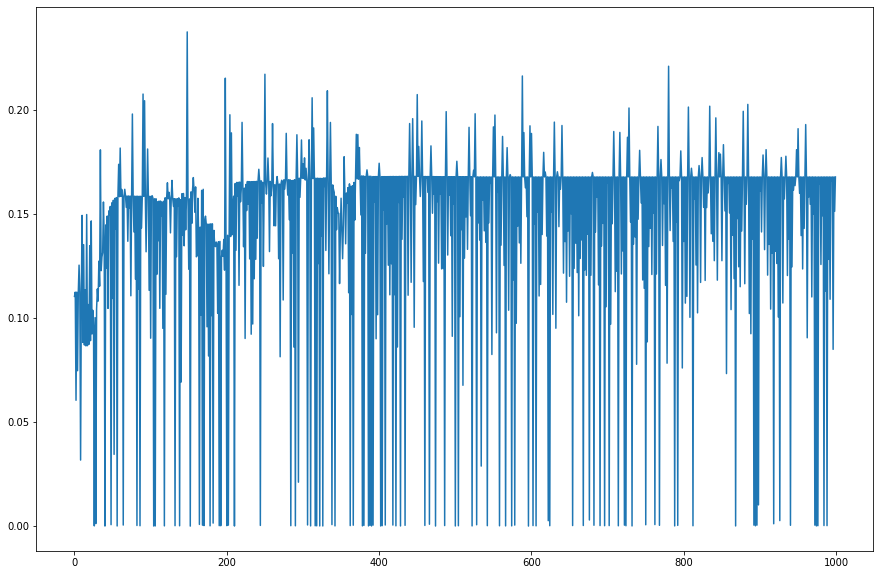

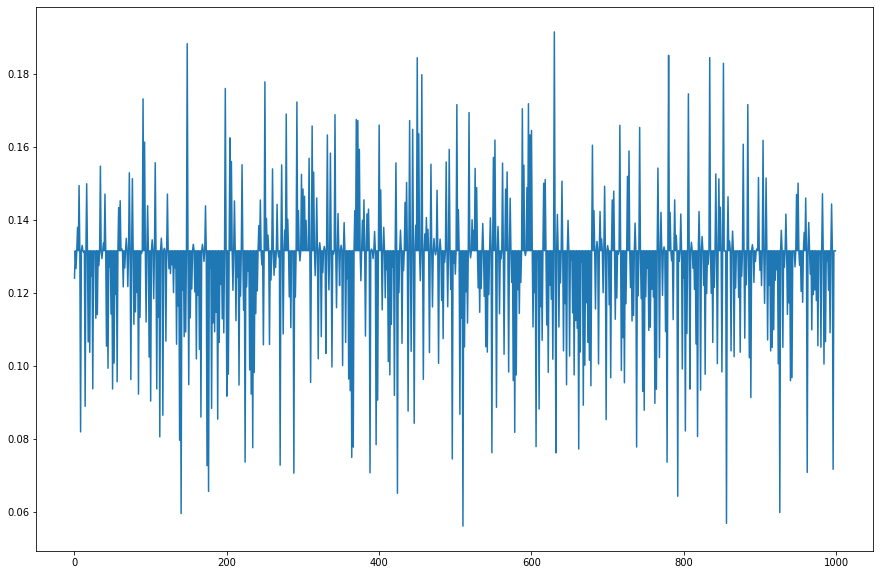

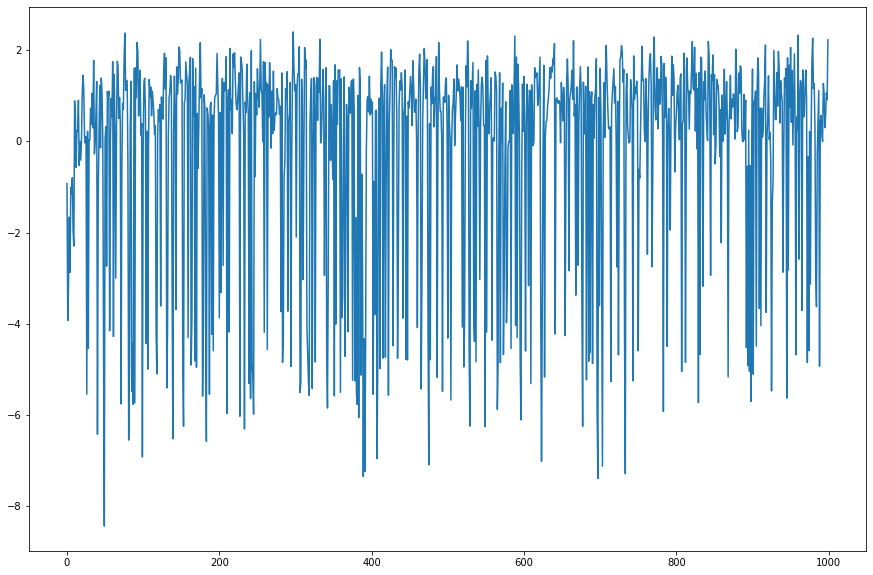

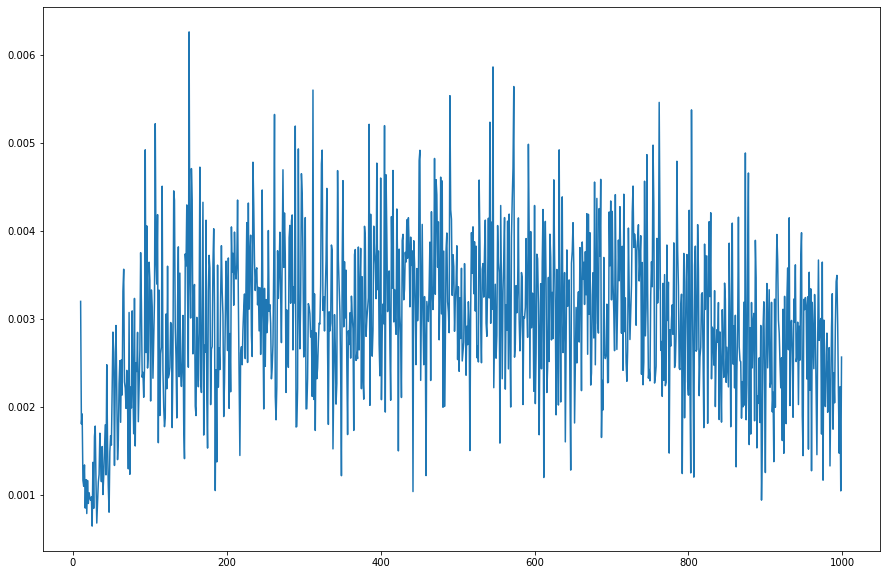

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.4)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

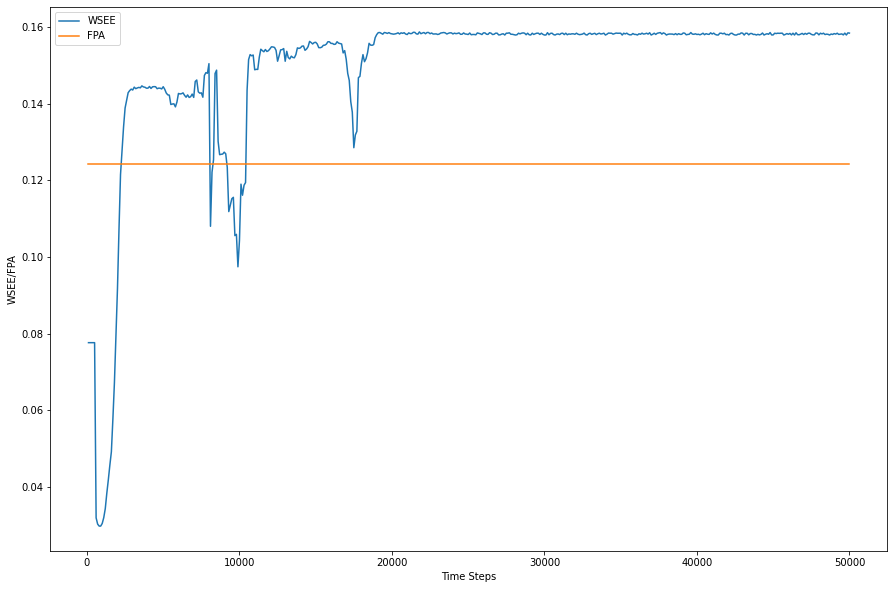

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

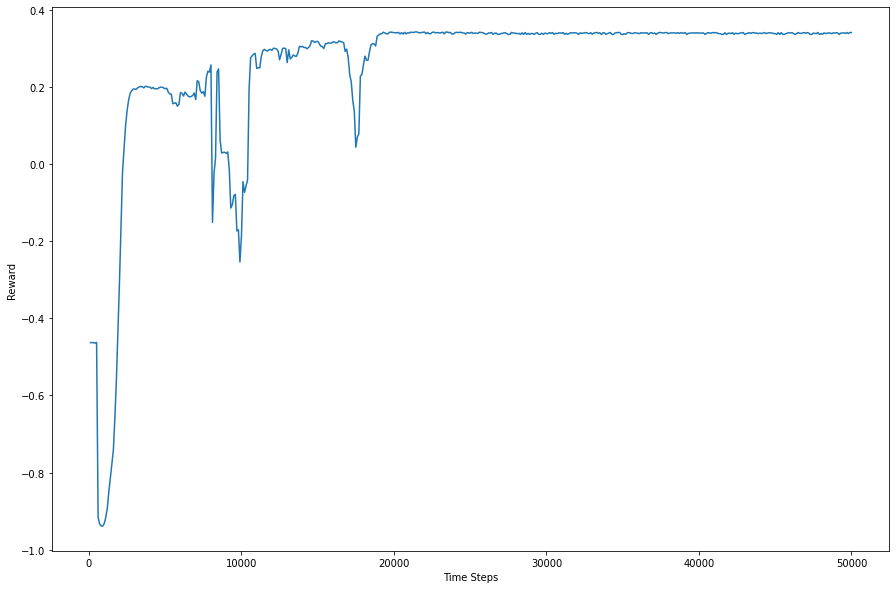

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
